In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tfidf.tfidf import padding_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
from sklearn.cluster import DBSCAN
from collections import Counter
import re
import json
import string
import ast
import os
import networkx as nx

warnings.filterwarnings('ignore')

2025-07-14 17:02:13.820648: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 17:02:13.958257: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 17:02:14.082383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752487334.186023    1562 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752487334.216893    1562 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752487334.455784    1562 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

(23714, 64)
(23714, 70)
(23714, 70)
41700
Total Malicious: 11851
Total Benign: 11863
Total Predicted Malicious but Benign: 23
Total Predicted Benign but Malicious: 18
(23714, 3)
dict_keys(['accuracy', 'precision', 'recall', 'f1', 'auc', 'confusion_matrix'])


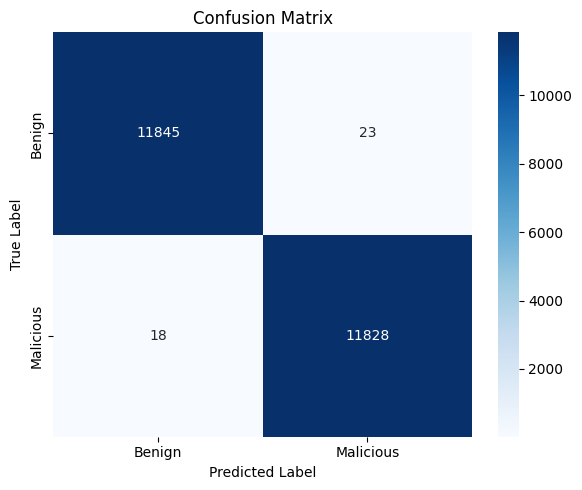

In [2]:
attention_hidden_state = np.load('attention_hidden_state.npy')
print(attention_hidden_state.shape)
attention_weights = np.load('attention_weights.npy')
structure_weights = np.load('structure_weights.npy')
print(attention_weights.shape)
print(structure_weights.shape)
content_vocab = pickle.load(open('both_content_vocab.json', 'rb'))
print(len(content_vocab))
content_vocab = {v: k for k, v in content_vocab.items()}
# vectorizer = pickle.load(open('tfidf_vecotrizer_content_atbilstm_both.pkl', 'rb'))
preds_df = pd.read_excel('evaluation_ATBiLSTM_2025-06-08_23:58:36.xlsx')
total_malicious = preds_df[preds_df['predicted_label'] == 'Malicious']
total_benign = preds_df[preds_df['predicted_label'] == 'Benign']
total_predicted_malicious_but_benign = preds_df[(preds_df['predicted_label'] == 'Malicious') & (preds_df['true_label'] == 'Benign')]
total_predicted_benign_but_malicious = preds_df[(preds_df['predicted_label'] == 'Benign') & (preds_df['true_label'] == 'Malicious')]
print("Total Malicious:", len(total_malicious))
print("Total Benign:", len(total_benign))
print("Total Predicted Malicious but Benign:", len(total_predicted_malicious_but_benign))
print("Total Predicted Benign but Malicious:", len(total_predicted_benign_but_malicious))


print(preds_df.shape)
metrics = json.load(open('evaluation_metrics_ATBiLSTM_epoch-10_lemdim-64_lstmdim-32_batch-200.json', 'r'))
print(metrics.keys())
conf_matrix = metrics['confusion_matrix']
conf_matrix = np.array(conf_matrix)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [3]:
preds_df.head()

tokenized_url predicted_label  \
0  [14, 30511, 14, 34178, 14, 20310, 13, 32885, 1...          Benign   
1  [14, 21499, 14, 6440, 14, 6500, 14, 7170, 1928...       Malicious   
2  [14, 33064, 13, 32885, 14, 828, 14, 34156, 14,...          Benign   
3  [14, 30511, 14, 34178, 14, 20310, 13, 32885, 1...          Benign   
4  [14, 33064, 13, 32885, 14, 828, 14, 34156, 14,...          Benign   

  true_label  
0     Benign  
1  Malicious  
2     Benign  
3     Benign  
4     Benign

In [4]:
def custom_token(text):
    return re.findall(r'\b[a-zA-Z0-9]+\b', text)
def remove_eos(text):
    return text.replace('<eos>', '')
def remove_padding(tok_arr):
    return [tok for tok in tok_arr if tok != -100]

In [5]:
import ast

false_positive_df = preds_df[
    (preds_df['predicted_label'] == 'Malicious') & 
    (preds_df['true_label'] == 'Benign')
].copy()

false_negative_df = preds_df[
    (preds_df['predicted_label'] == 'Benign') & 
    (preds_df['true_label'] == 'Malicious')
].copy()

false_positive_df['tokenized_url'] = false_positive_df['tokenized_url'].apply(ast.literal_eval)
false_negative_df['tokenized_url'] = false_negative_df['tokenized_url'].apply(ast.literal_eval)

print("\n--- FALSE POSITIVES (Pred: Malicious | True: Benign) ---")
for i in range(len(false_positive_df)):
    tokens = false_positive_df['tokenized_url'].iloc[i]
    tokens = remove_padding(tokens)
    tokens = [content_vocab[token] for token in tokens if token in content_vocab]
    print(f"URL: {' '.join(tokens)}")
    print(f"Predicted: {false_positive_df['predicted_label'].iloc[i]}, True: {false_positive_df['true_label'].iloc[i]}\n")

print("\n--- FALSE NEGATIVES (Pred: Benign | True: Malicious) ---")
for i in range(len(false_negative_df)):
    tokens = false_negative_df['tokenized_url'].iloc[i]
    tokens = remove_padding(tokens)
    tokens = [content_vocab[token] for token in tokens if token in content_vocab]
    print(f"URL: {' '.join(tokens)}")
    print(f"Predicted: {false_negative_df['predicted_label'].iloc[i]}, True: {false_negative_df['true_label'].iloc[i]}\n")



--- FALSE POSITIVES (Pred: Malicious | True: Benign) ---
URL: / <UNK> / <UNK> _ client . php <query> client = <UNK> & img = / tmp | echo ` id ` | <UNK> / usr / local / <UNK> / <UNK> / <UNK> . txt
Predicted: Malicious, True: Benign

URL: / cms / info . php <query> mod = list < / script > < script > alert ( document . domain ) < / script >
Predicted: Malicious, True: Benign

URL: / theme / degrade / style / fonts / fontawesome / fontawesome - webfont . woff <query> v = fuzz ' \ " > < <UNK>
Predicted: Malicious, True: Benign

URL: / take - home - pay / daftar - pendapatan / get - rincian - pendapatan <query> id _ pegawai = a6b49f87 - f8c5 - 4898 - b6c9 - 3234e724e15a & is _ admin = & tahun = 2025 & is _ apbn = 1
Predicted: Malicious, True: Benign

URL: / take - home - pay / daftar - pendapatan / get - rincian - pendapatan <query> id _ pegawai = <UNK> - <UNK> - <UNK> - <UNK> - <UNK> & is _ admin = & tahun = 2025 & is _ apbn = 2
Predicted: Malicious, True: Benign

URL: / $ { @ java . lang 

In [6]:
malicious_df = preds_df[preds_df['predicted_label'] == 'Malicious']
true_malicious_df = malicious_df[malicious_df['true_label'] == 'Malicious']
print(malicious_df.shape)
print(true_malicious_df.shape)
malicious_indices = true_malicious_df.index.tolist()
print(len(malicious_indices))
print(len(attention_hidden_state))
print(len(attention_weights))
print(attention_hidden_state.shape)
print(attention_weights.shape)

(11851, 3)
(11828, 3)
11828
23714
23714
(23714, 64)
(23714, 70)


In [7]:
malicious_hidden_states = attention_hidden_state[malicious_indices]
malicious_weights = attention_weights[malicious_indices]
malicious_structure_weights = structure_weights[malicious_indices]
scaler = StandardScaler()
malicious_hidden_states = scaler.fit_transform(malicious_hidden_states)
print(malicious_hidden_states.shape)
print(malicious_hidden_states[0])
print(malicious_weights.shape)

(11828, 64)
[ 0.24022317  0.29256722  0.35586178 -0.33028337  0.01515008  0.32397723
  0.25843877  0.30938676  0.01439052 -0.2658592   0.12254333 -0.35154688
 -0.3285054   0.37801298 -0.3423301  -0.3255964  -0.35300088 -0.3859324
  0.3036197   0.05707714 -0.2423762   0.11286892  0.15857315 -0.2064286
 -0.32154694 -0.30392987  0.34672305 -0.32510233 -0.35587078  0.06342389
  0.37199655  0.35287917 -0.37921214  0.42169073 -0.37086138  0.38623223
 -0.3921816  -0.3915347  -0.38234195 -0.40337053  0.38526902 -0.39400047
  0.39763153  0.39308098 -0.38987637  0.35100606  0.36822483 -0.37847716
  0.38945588 -0.39266953 -0.3902961   0.3949513   0.3859373   0.3655759
 -0.38176134 -0.38551182 -0.3692567  -0.37911645  0.36957687 -0.39052537
 -0.38660842  0.3887459  -0.38367045  0.38075966]
(11828, 70)


In [8]:
dbscan = DBSCAN(eps=0.5, min_samples=10, metric='euclidean', n_jobs=-1)
clustering = dbscan.fit(malicious_hidden_states)
cluster_labels = clustering.labels_
clusters_counts = Counter(cluster_labels)

In [9]:
unique_clusters = np.unique(cluster_labels)
unique_clusters = unique_clusters[unique_clusters != -1]
print(f"Unique clusters found: {unique_clusters}")

Unique clusters found: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]



Processing Cluster 0...
Members in cluster 0: 9603
 Top 10 words by TFIDF: ['quiz', 'mod', 'test', 'contenteditable', 'attempt', 'oncut', 'x22alert', 'select', 'pluginfile', 'question']
shape of candidate sets: 9018

--- Co-occurrence Analysis for Top 5 Keywords ---


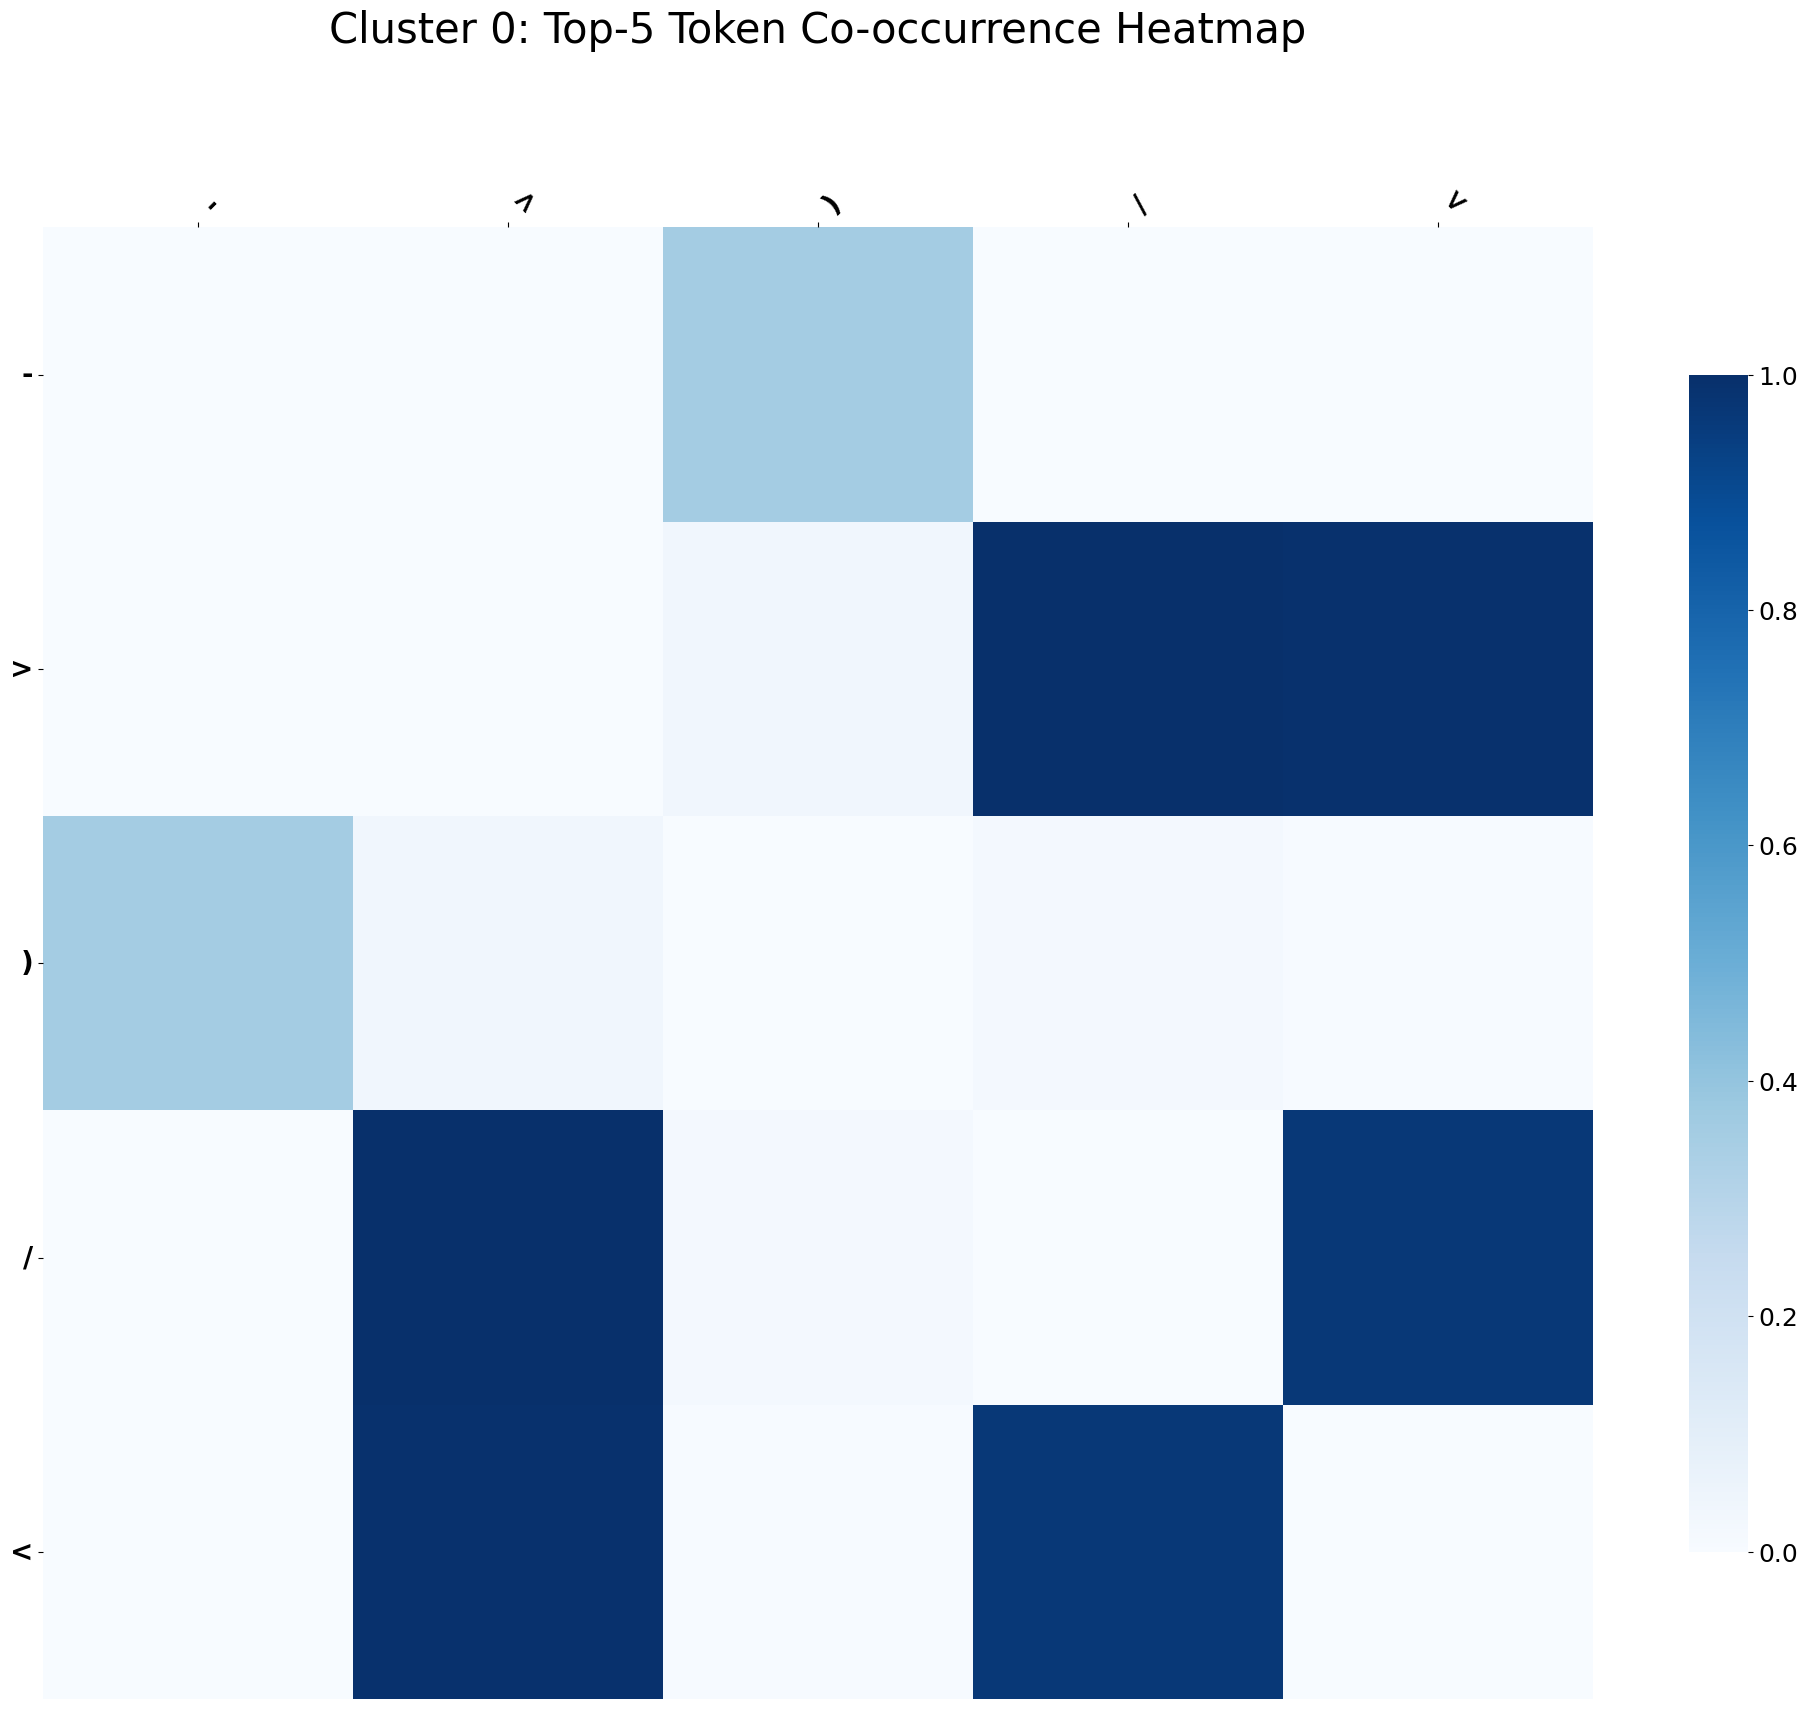

Discovered patterns for cluster 0 (Top-5): [['/', '<', '>']]

--- Co-occurrence Analysis for Top 10 Keywords ---


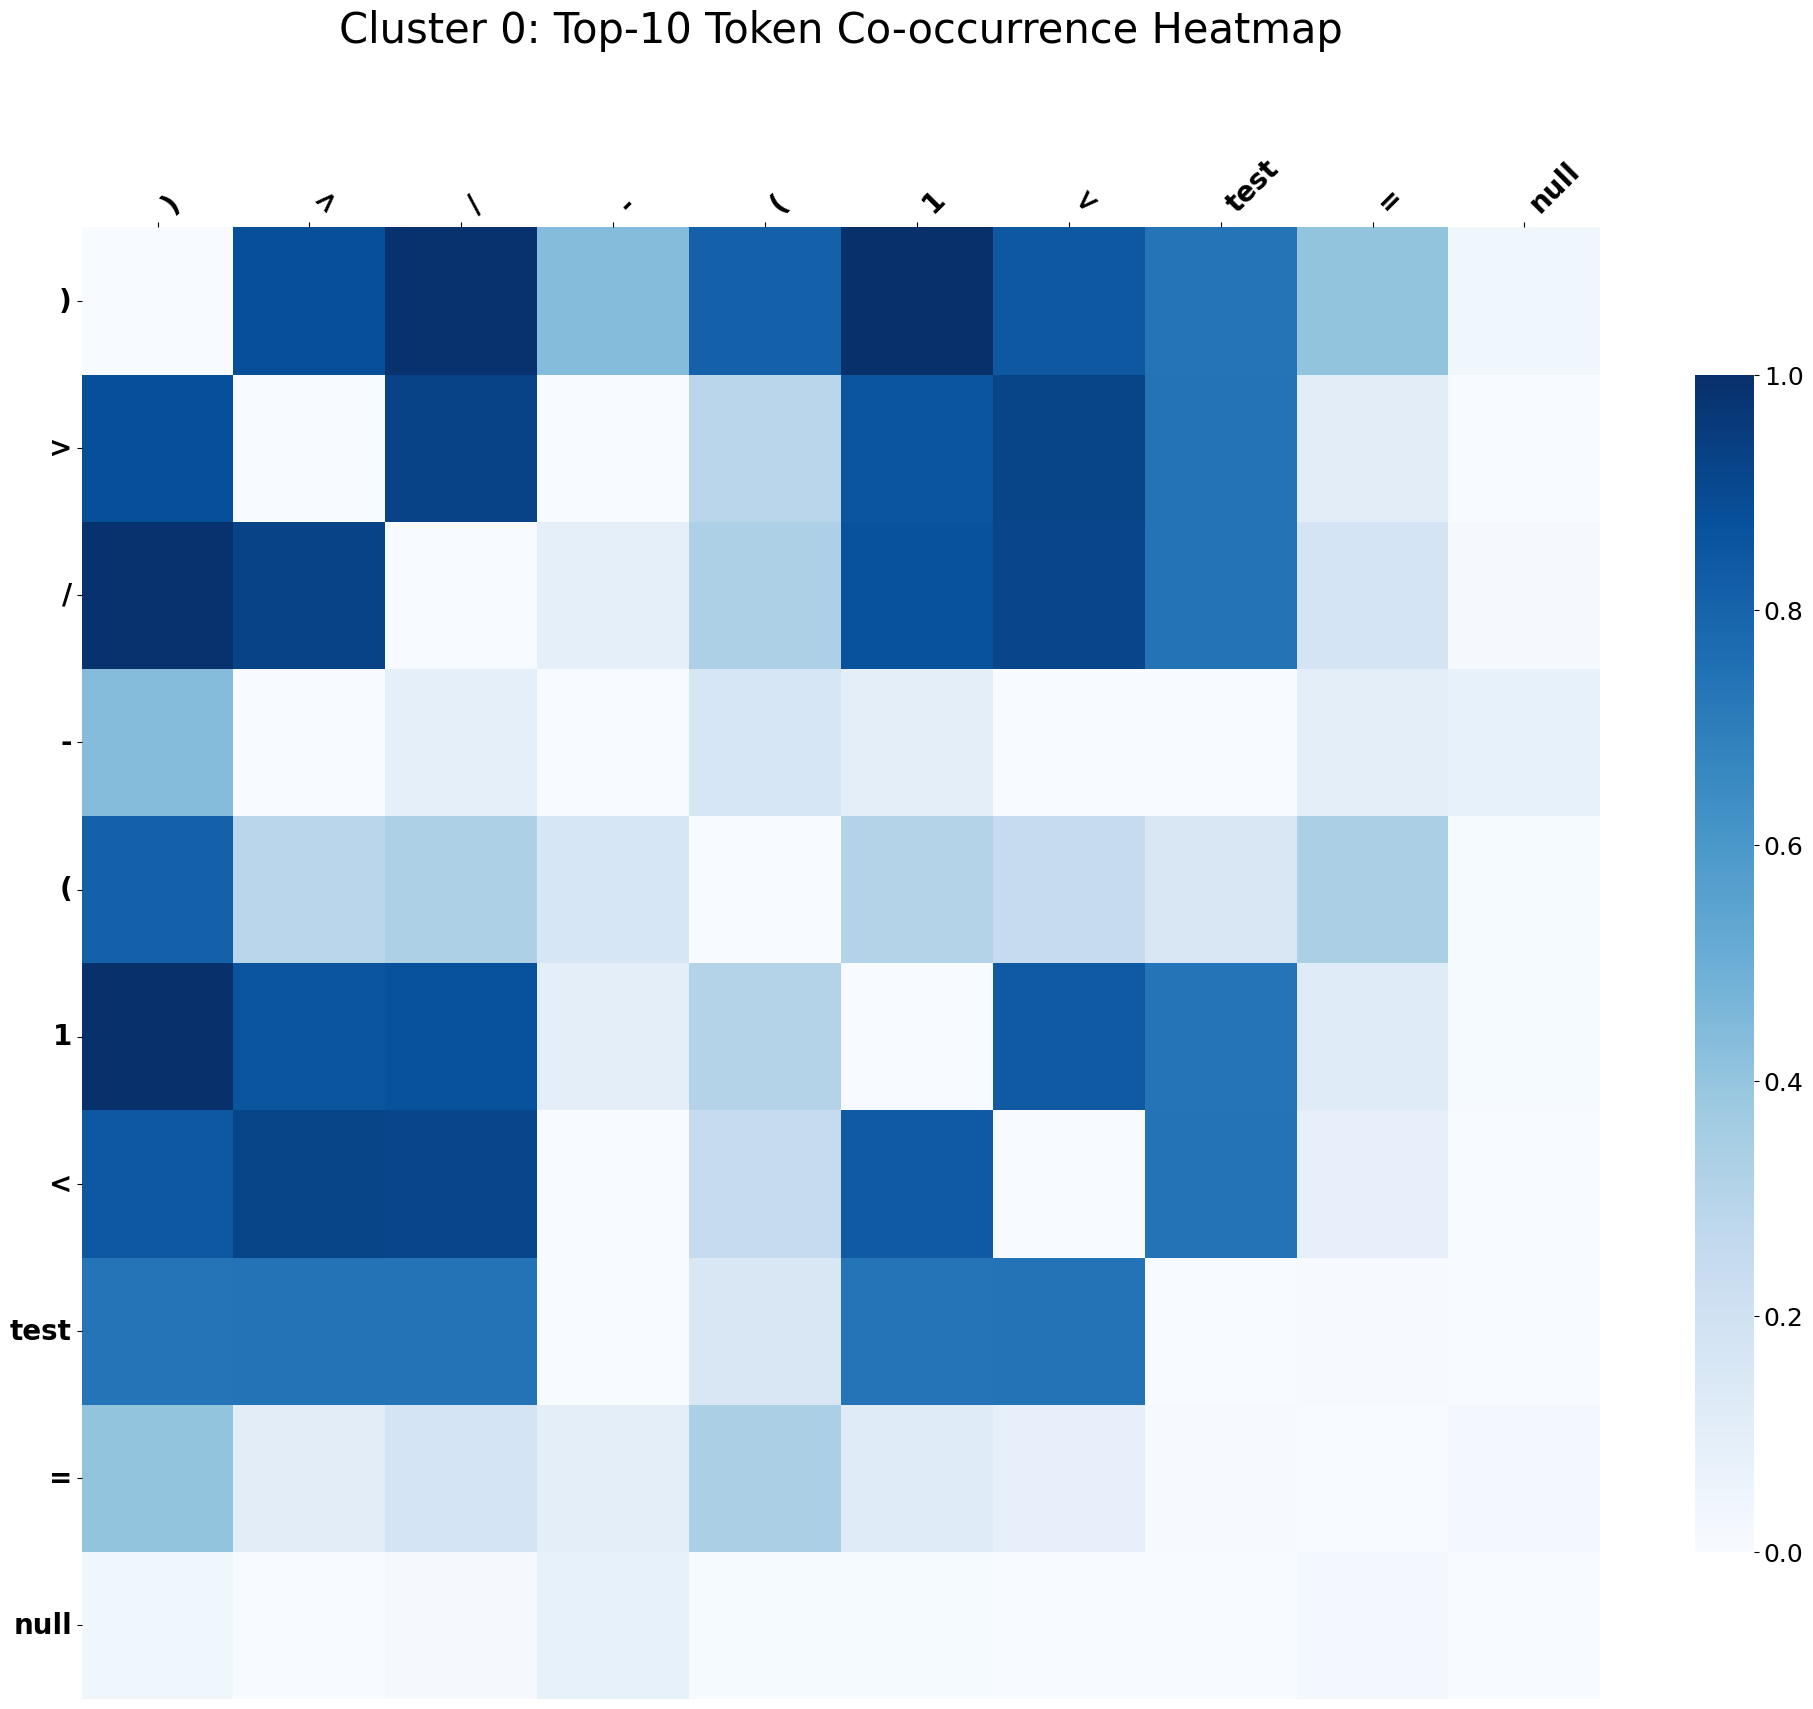

Discovered patterns for cluster 0 (Top-10): [['(', ')', '-', '/', '1', '<', '=', '>', 'test']]

--- Co-occurrence Analysis for Top 20 Keywords ---


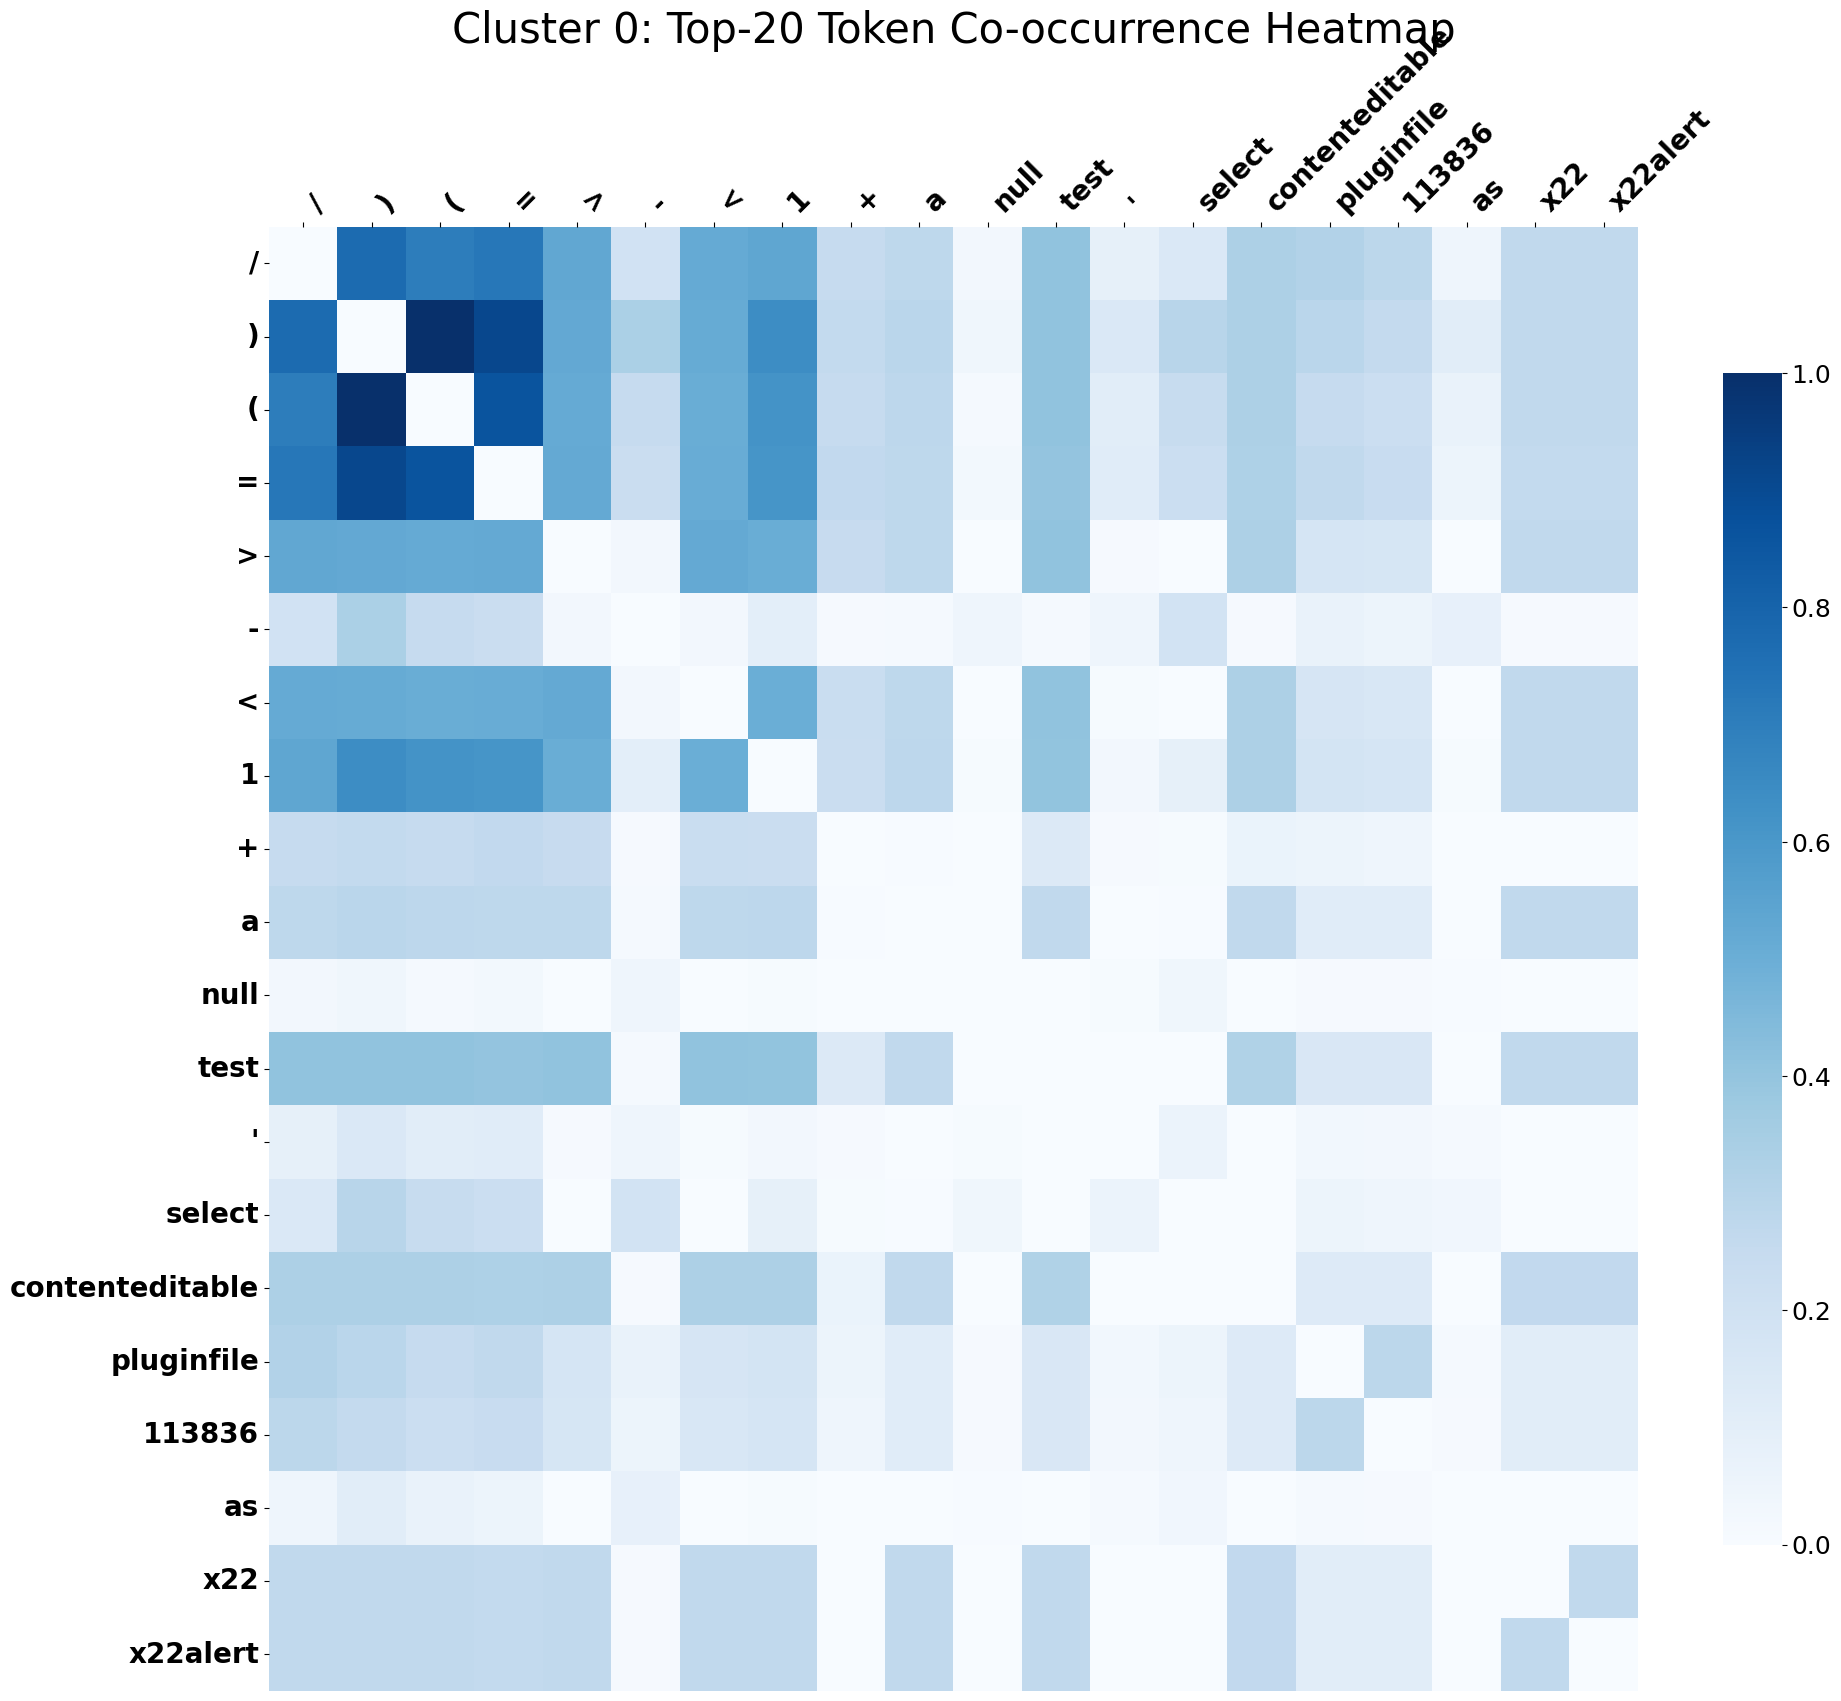

Discovered patterns for cluster 0 (Top-20): [['(', ')', '/', '1', '<', '=', '>', 'test']]

Processing Cluster 1...
Members in cluster 1: 18
 Top 10 words by TFIDF: ['select', 'from', '6429', '1535', '7359', 'and', 'mod', 'by', 'floor', 'elt']
shape of candidate sets: 18

--- Co-occurrence Analysis for Top 5 Keywords ---


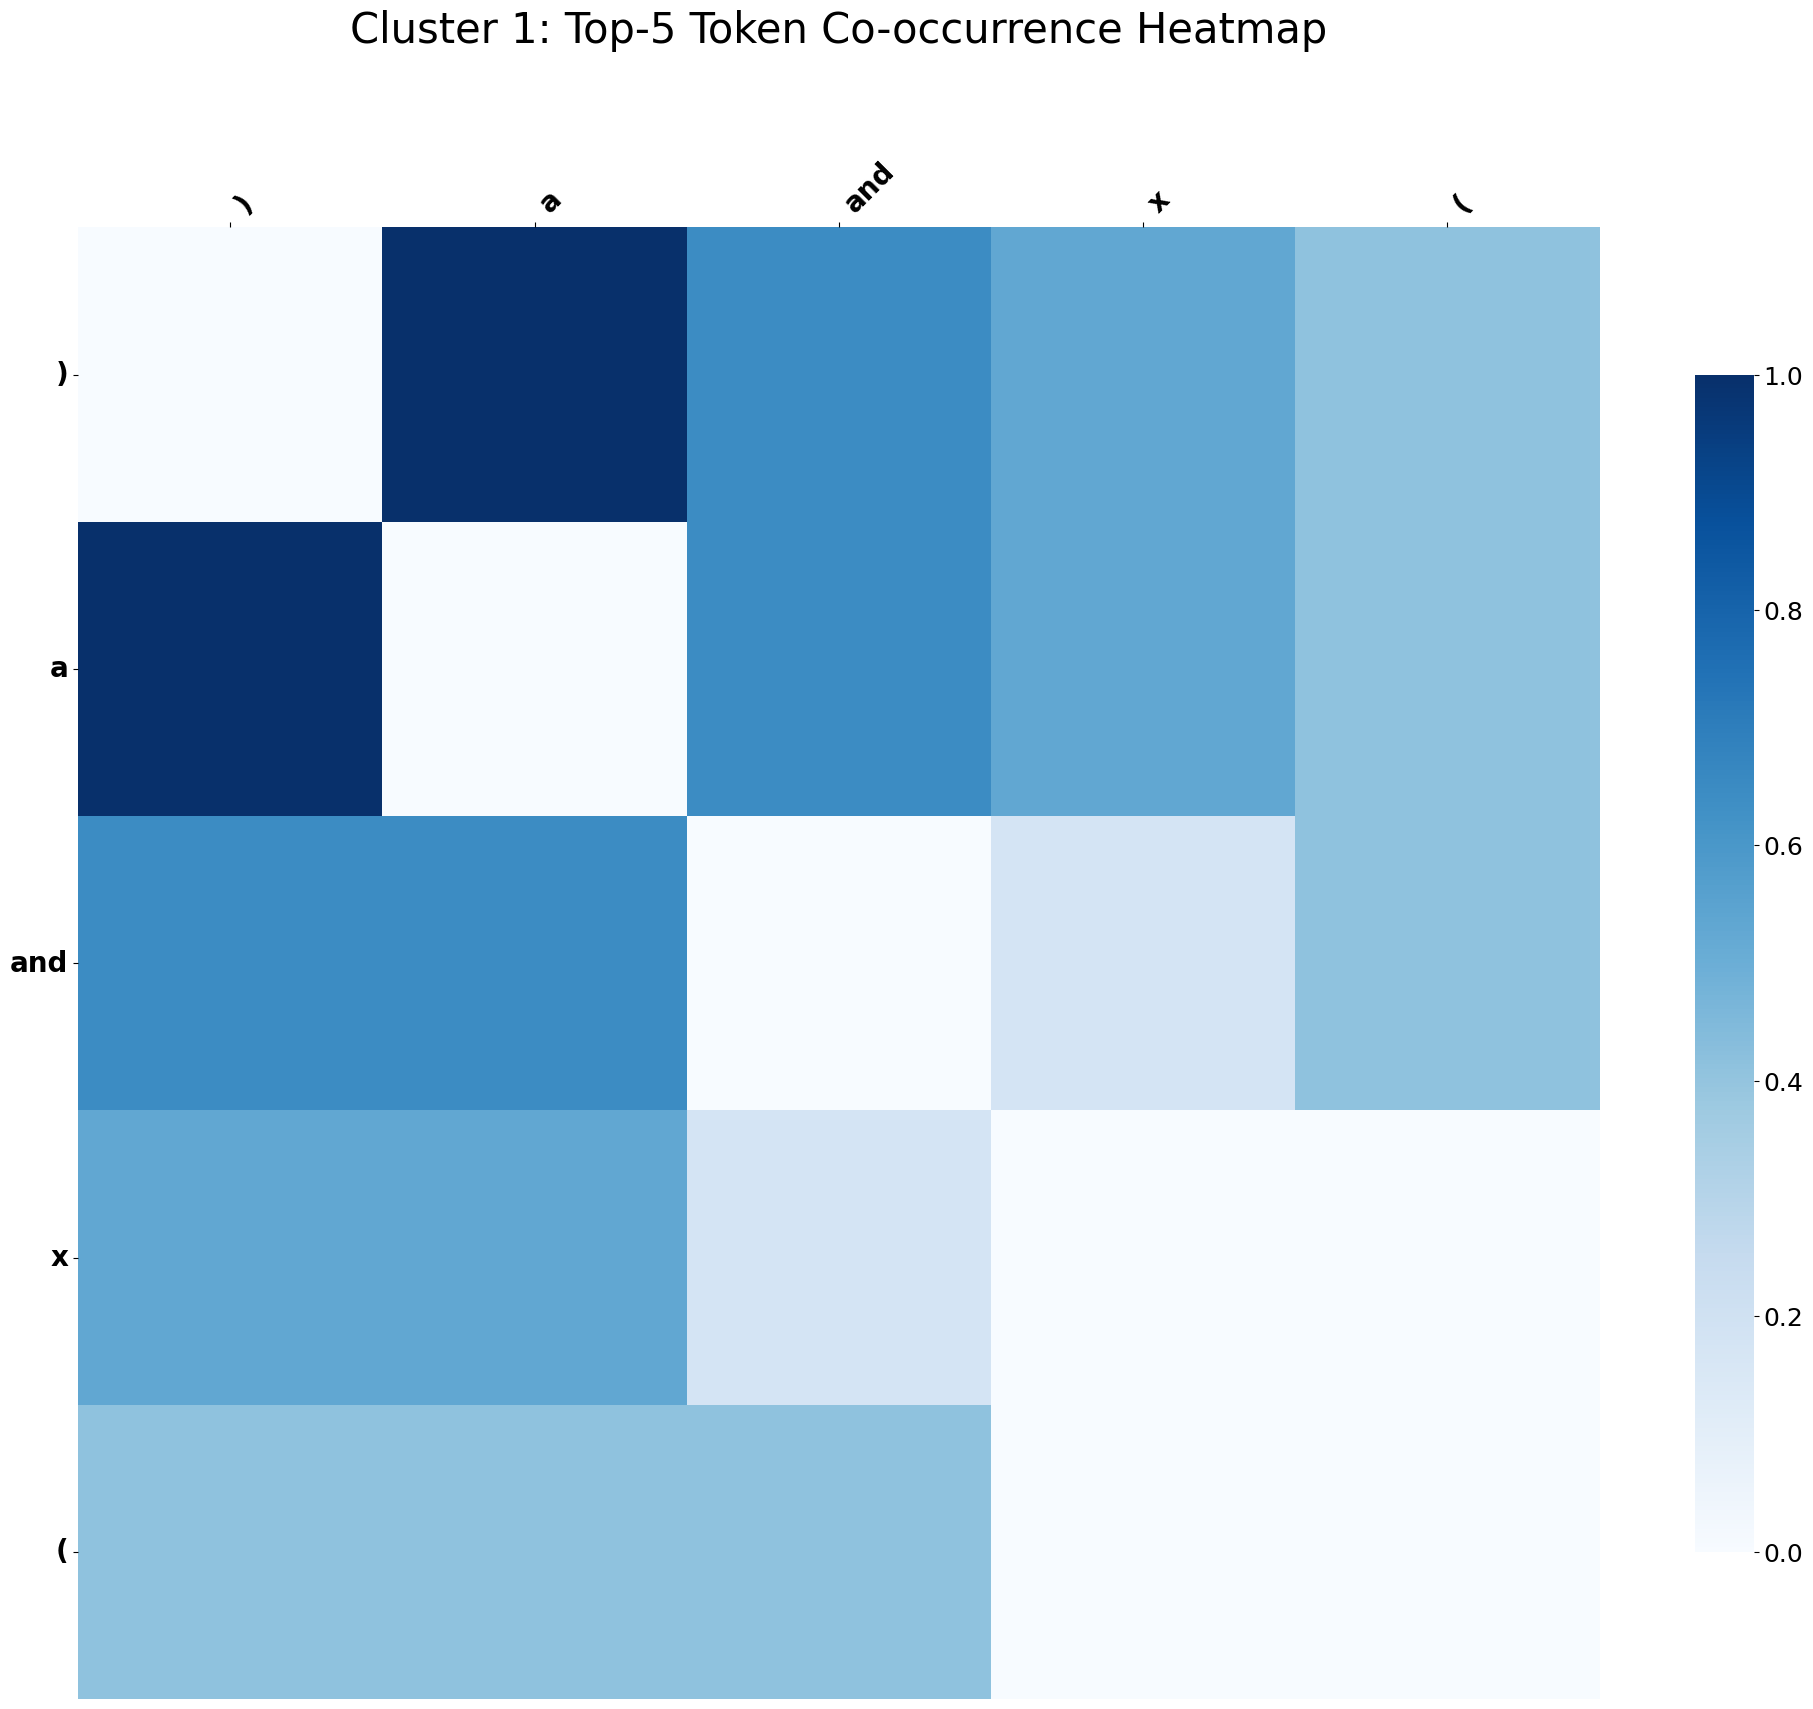

Discovered patterns for cluster 1 (Top-5): [['(', ')', 'a', 'and', 'x']]

--- Co-occurrence Analysis for Top 10 Keywords ---


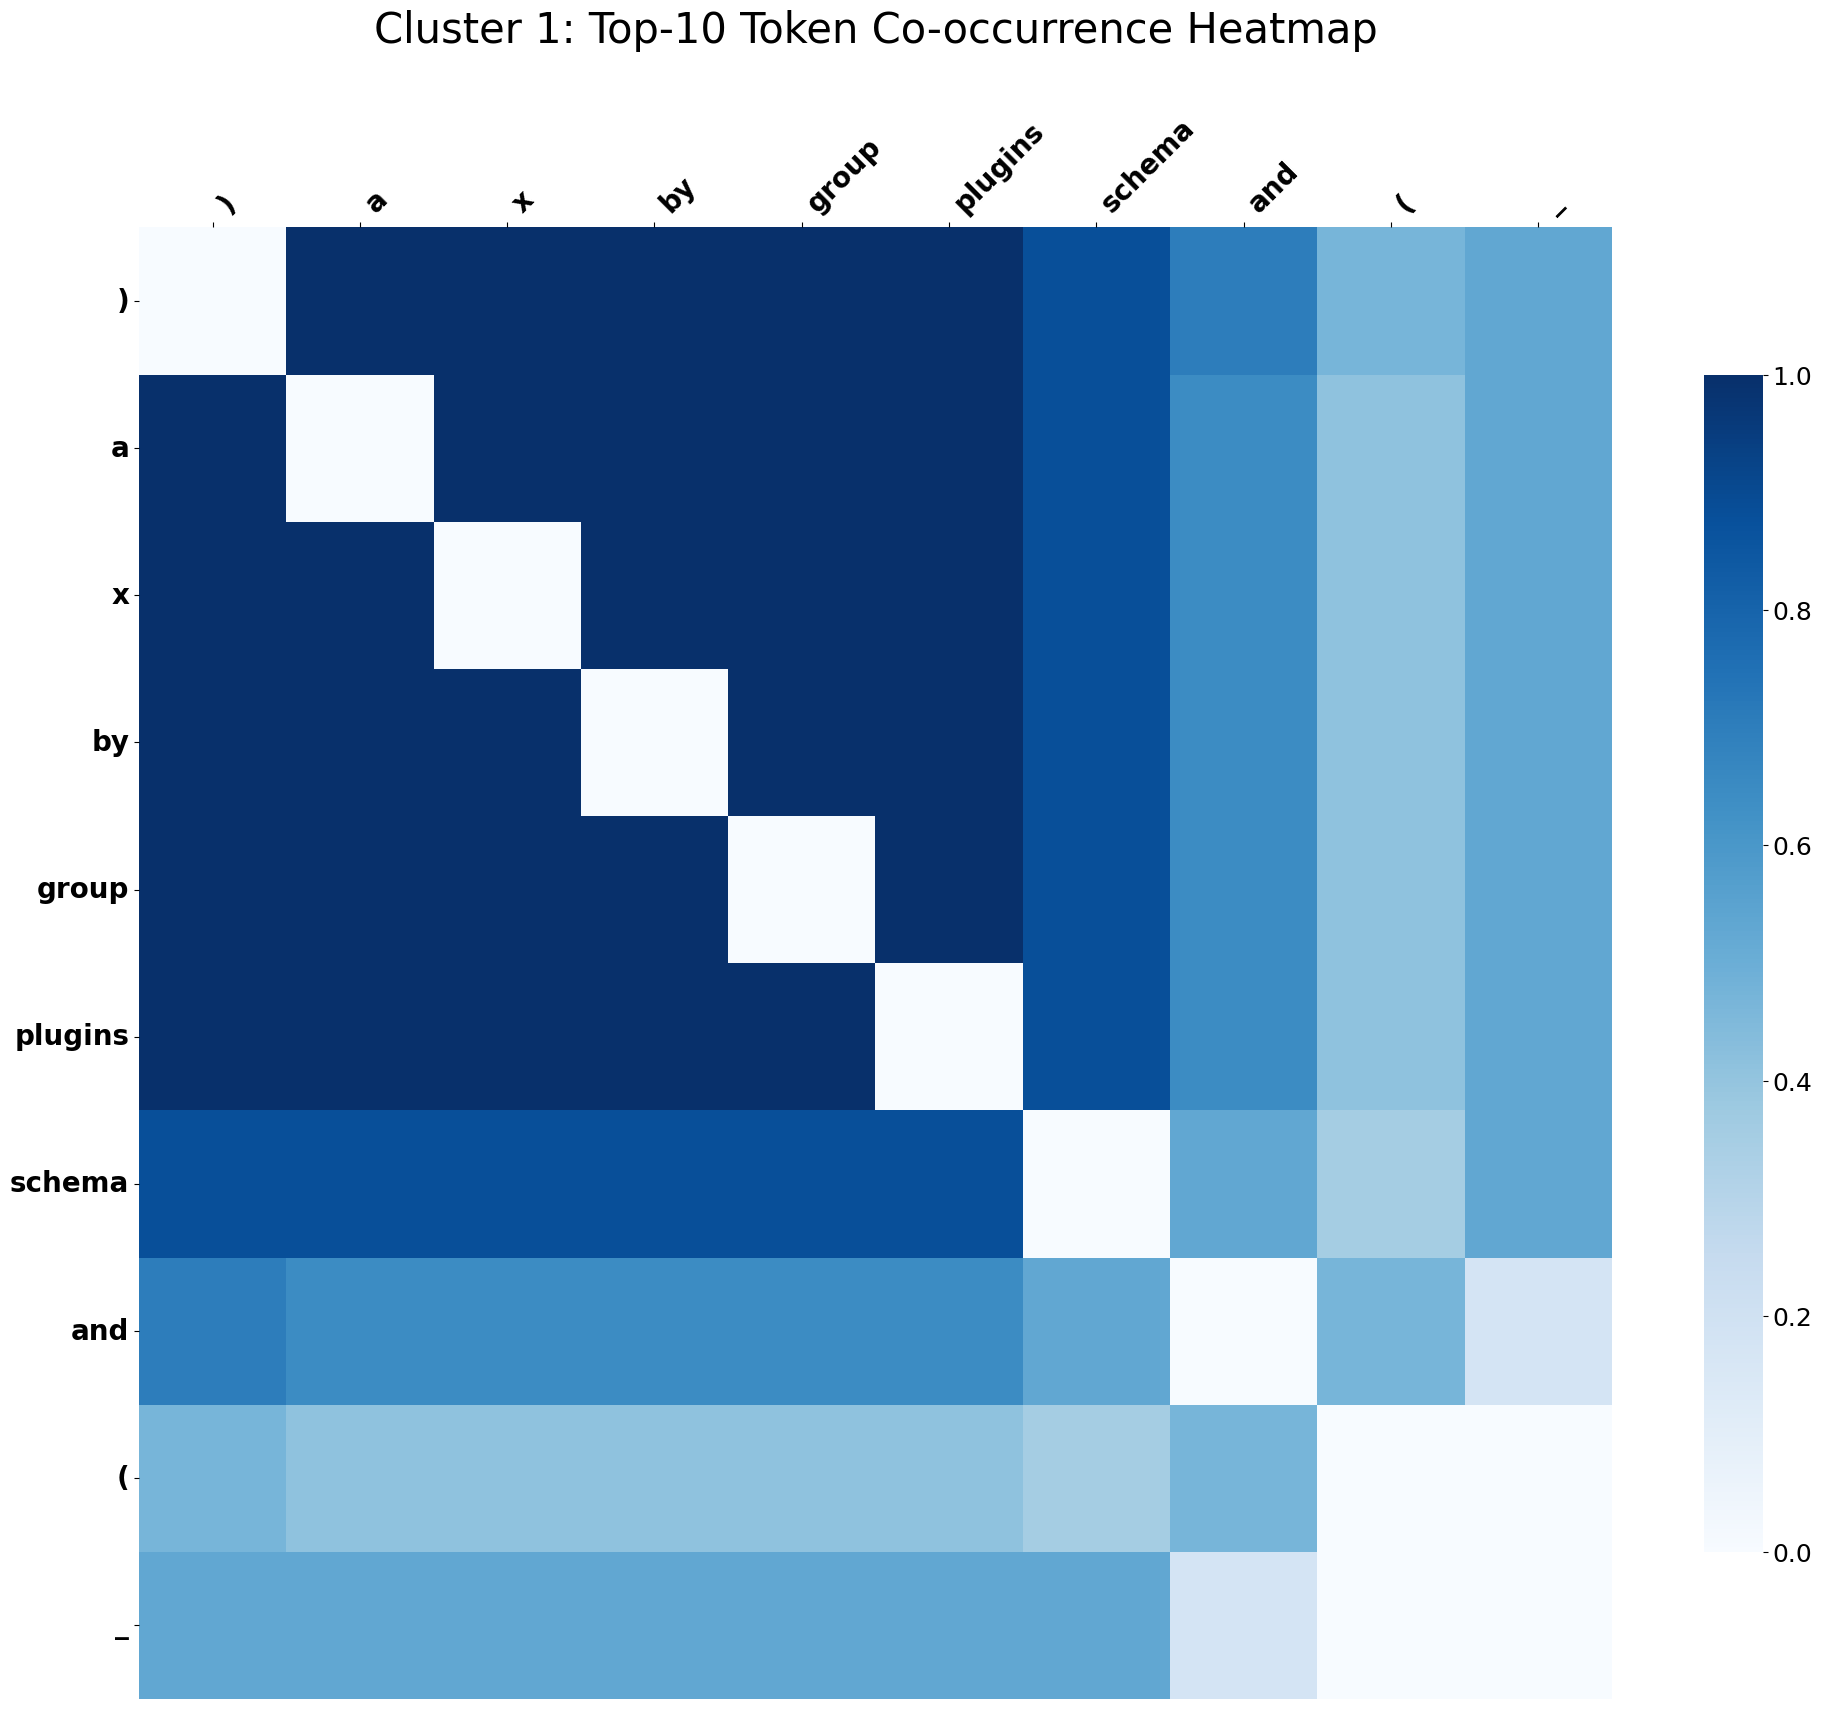

Discovered patterns for cluster 1 (Top-10): [['(', ')', '_', 'a', 'and', 'by', 'group', 'plugins', 'schema', 'x']]

--- Co-occurrence Analysis for Top 20 Keywords ---


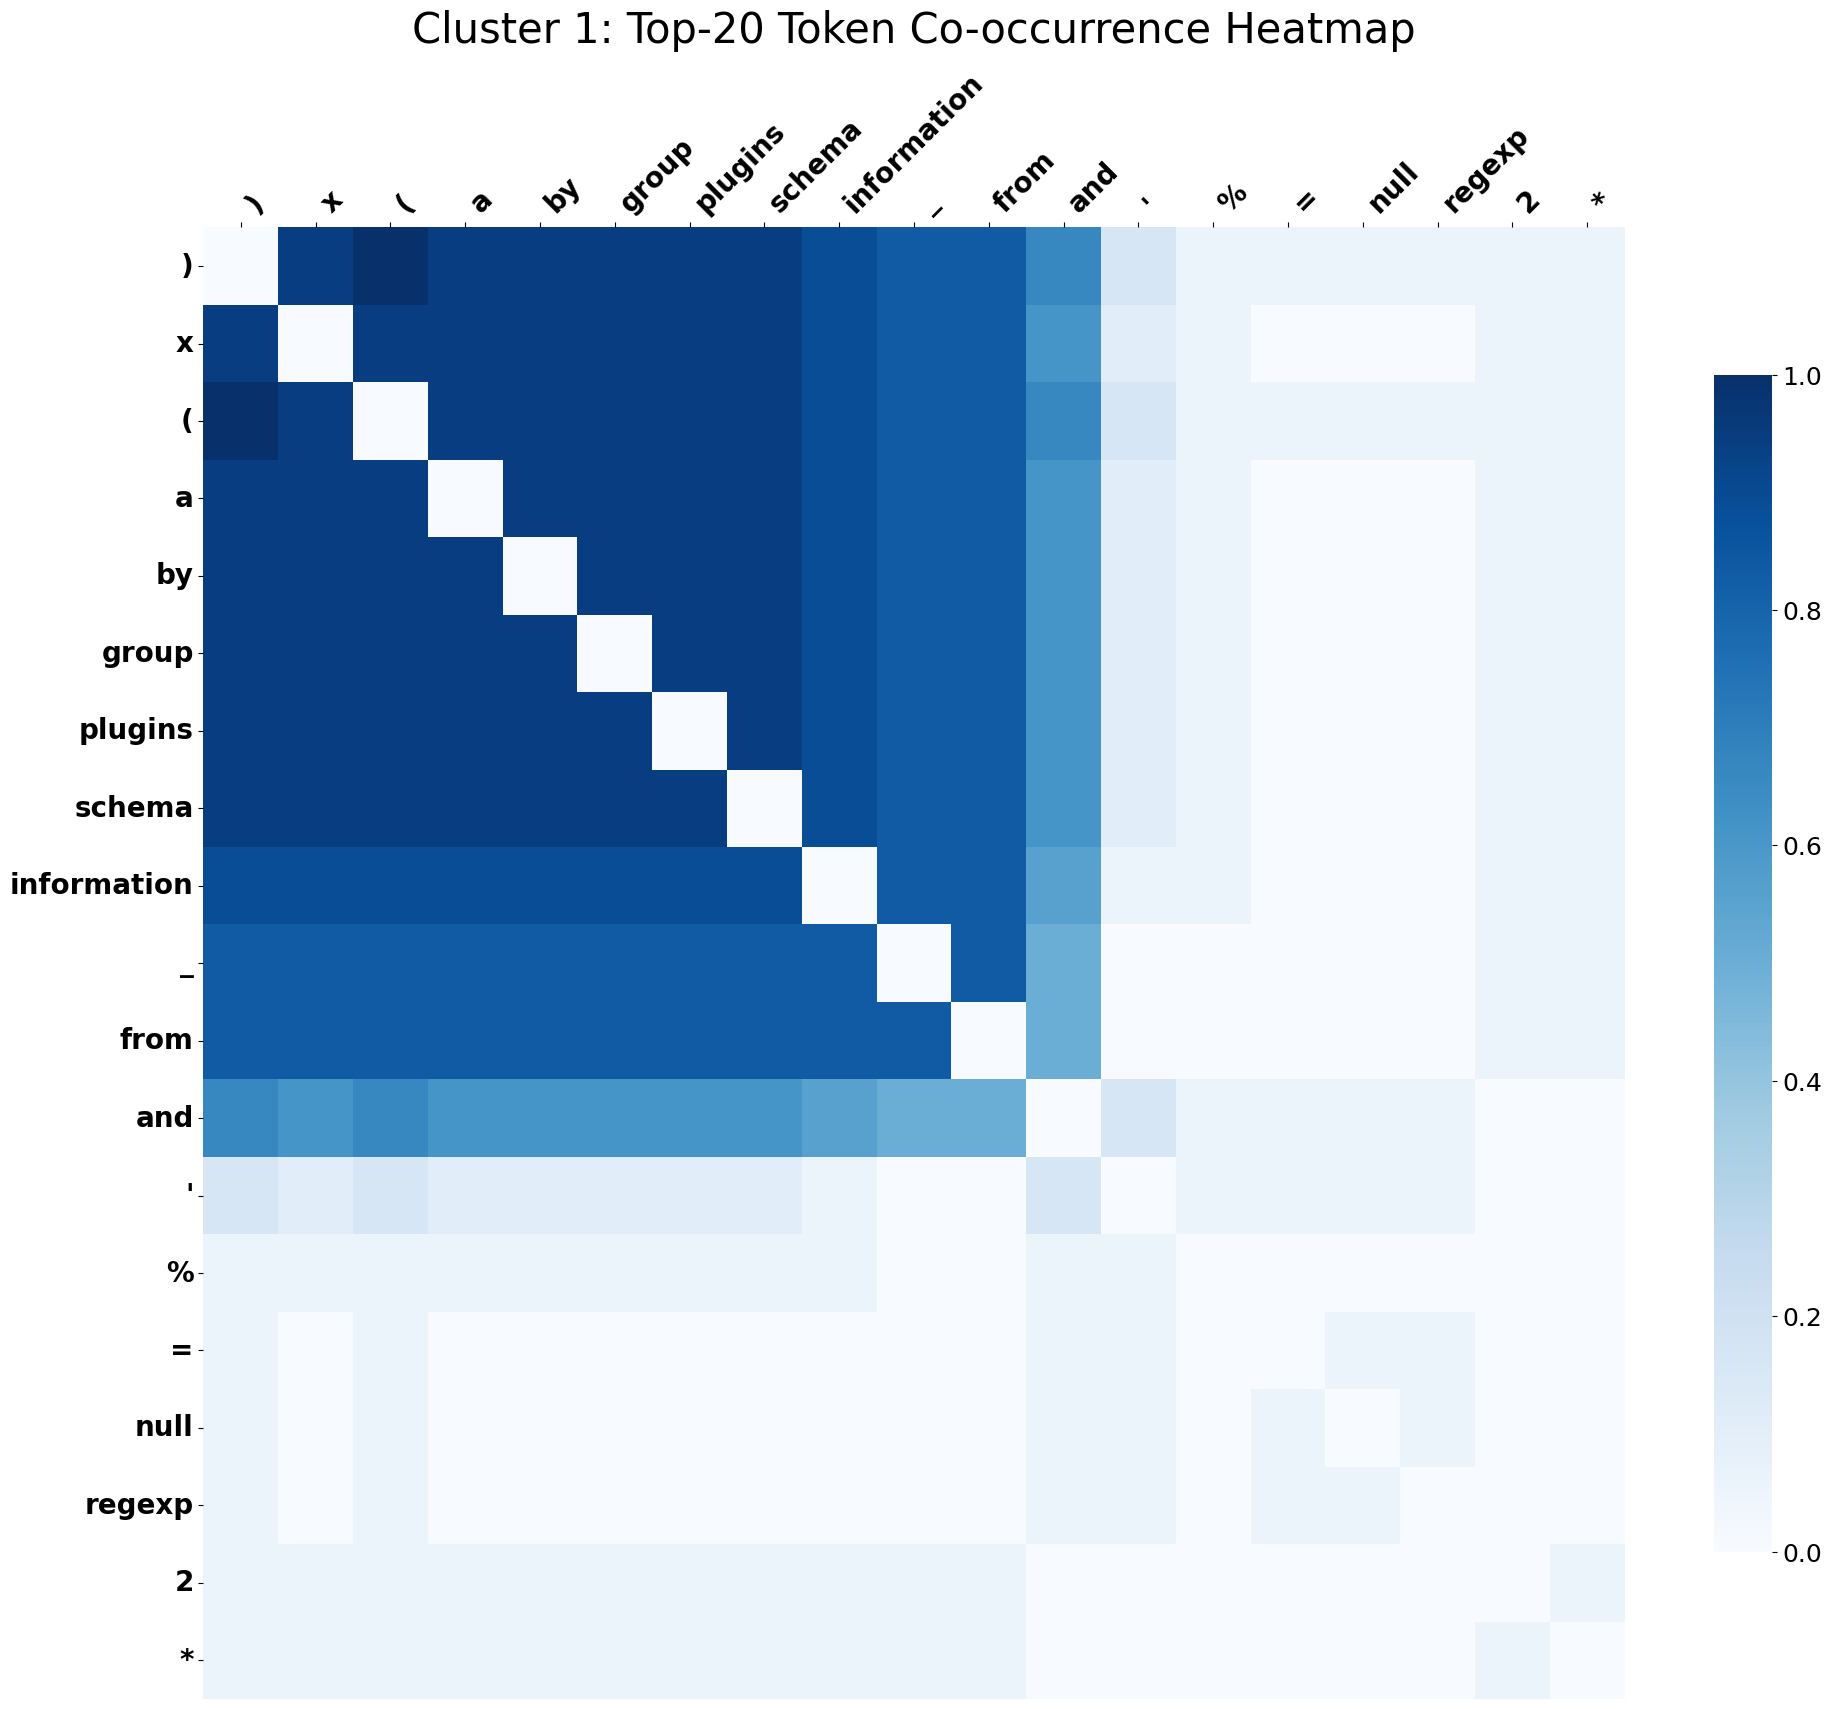

Discovered patterns for cluster 1 (Top-20): [['(', ')', '_', 'a', 'and', 'by', 'from', 'group', 'information', 'plugins', 'schema', 'x']]

Processing Cluster 2...
Members in cluster 2: 13
 Top 10 words by TFIDF: ['all', 'union', 'select', 'quiz', 'mod', 'attempt', 'wp', 'content', 'where', 'pluginfile']
shape of candidate sets: 13

--- Co-occurrence Analysis for Top 5 Keywords ---


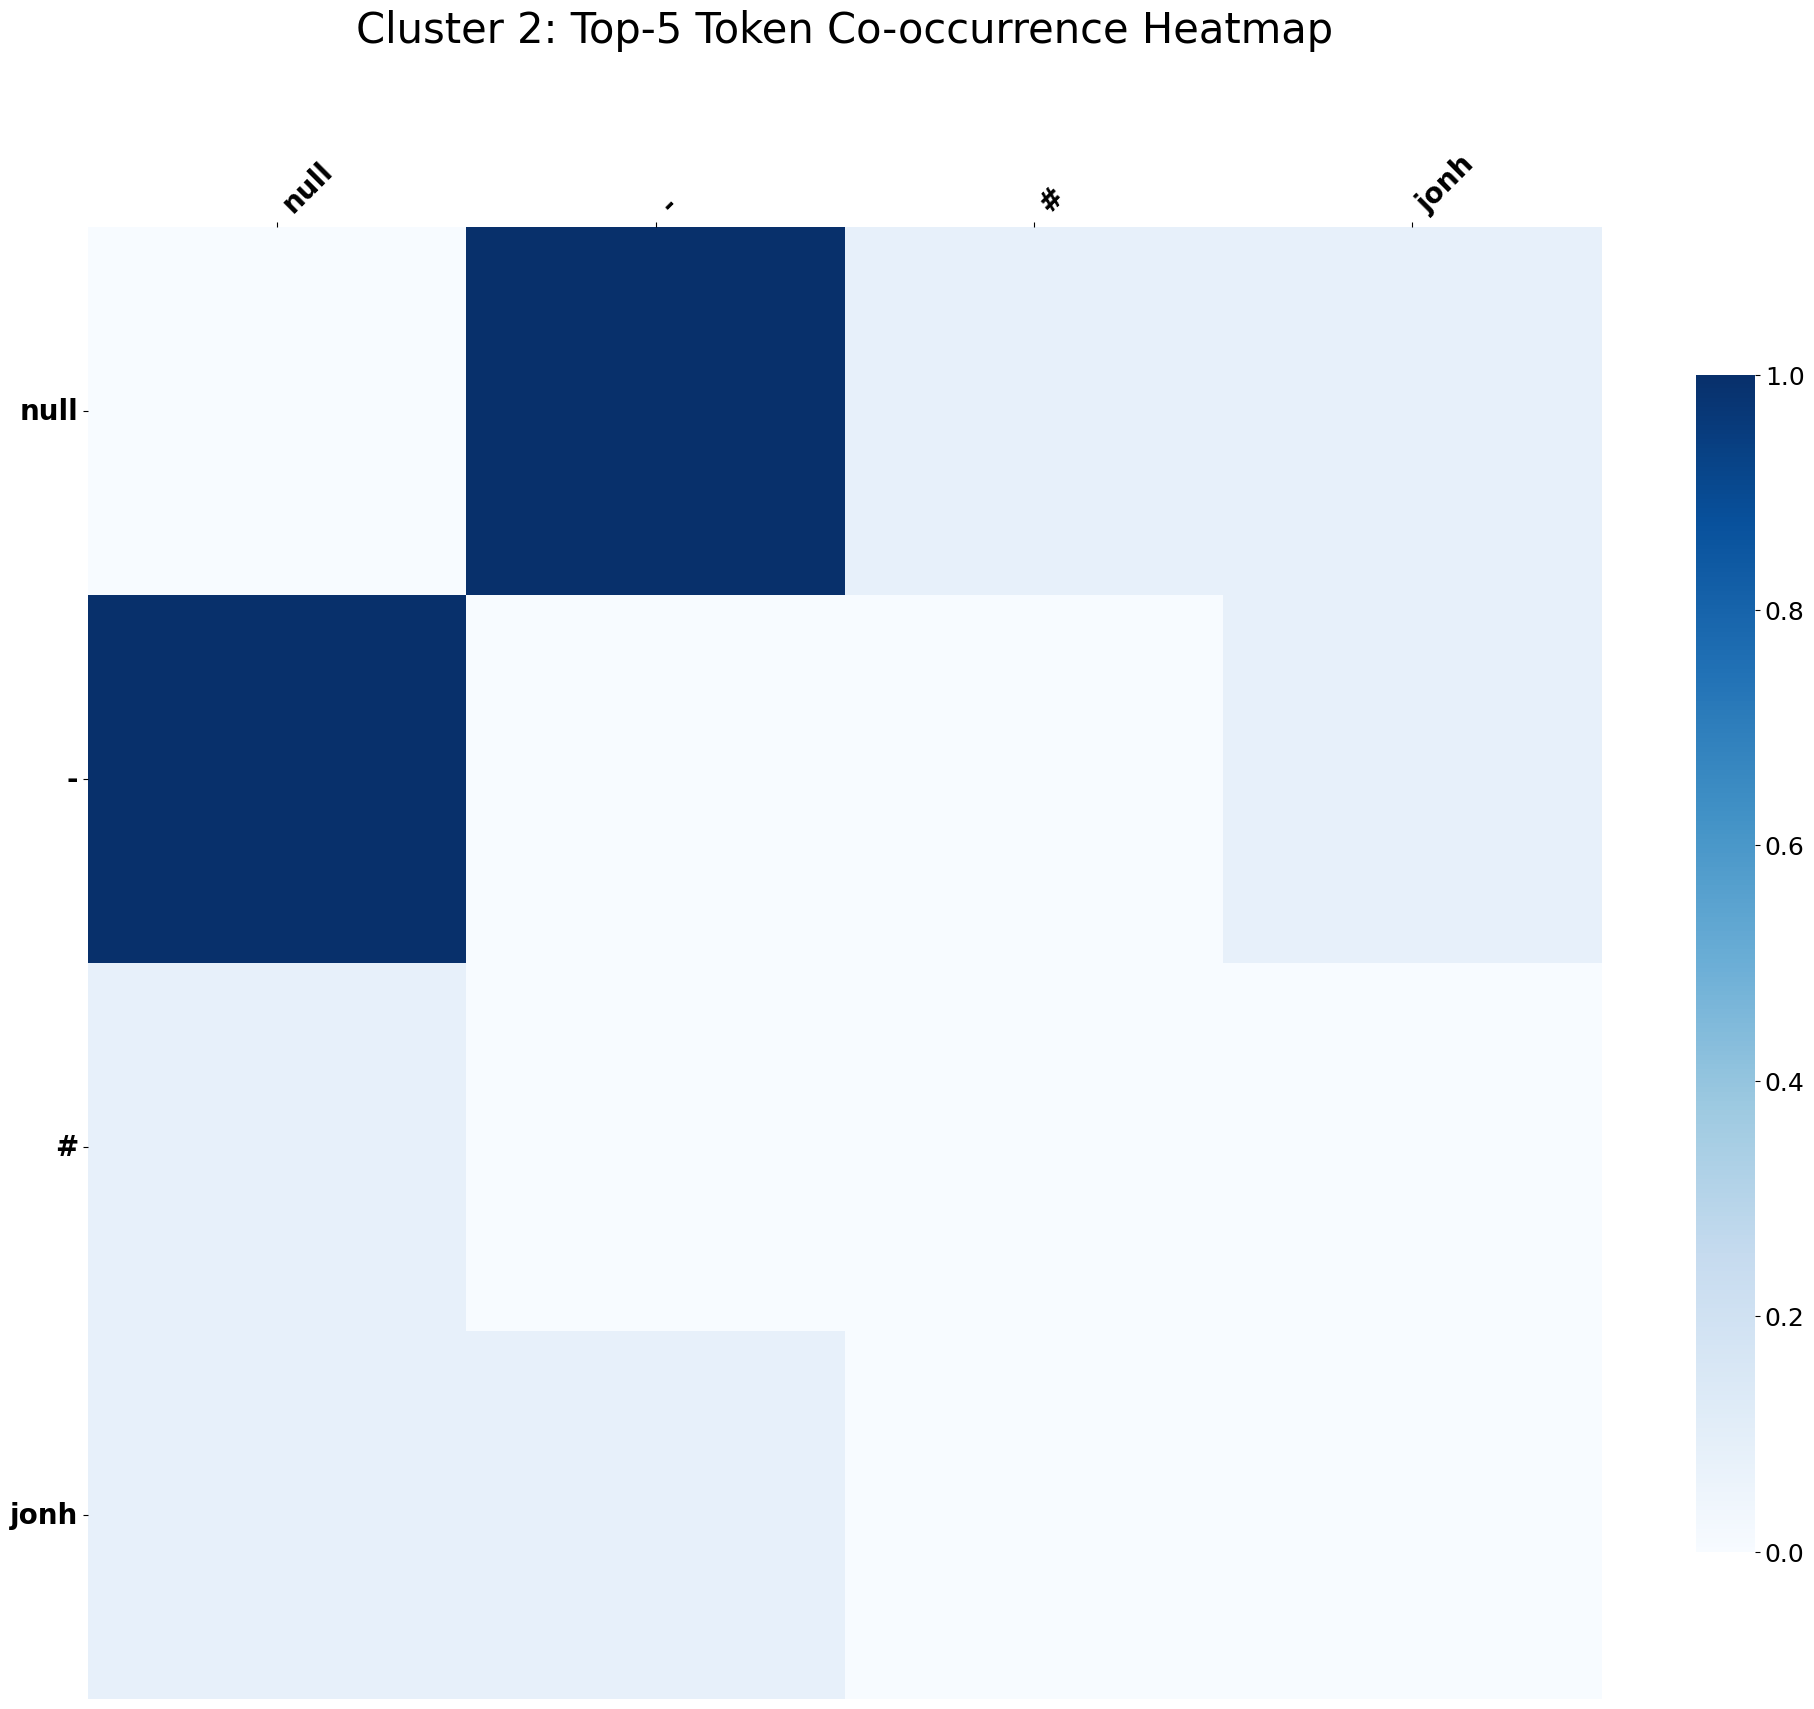

Discovered patterns for cluster 2 (Top-5): [['-', 'null']]

--- Co-occurrence Analysis for Top 10 Keywords ---


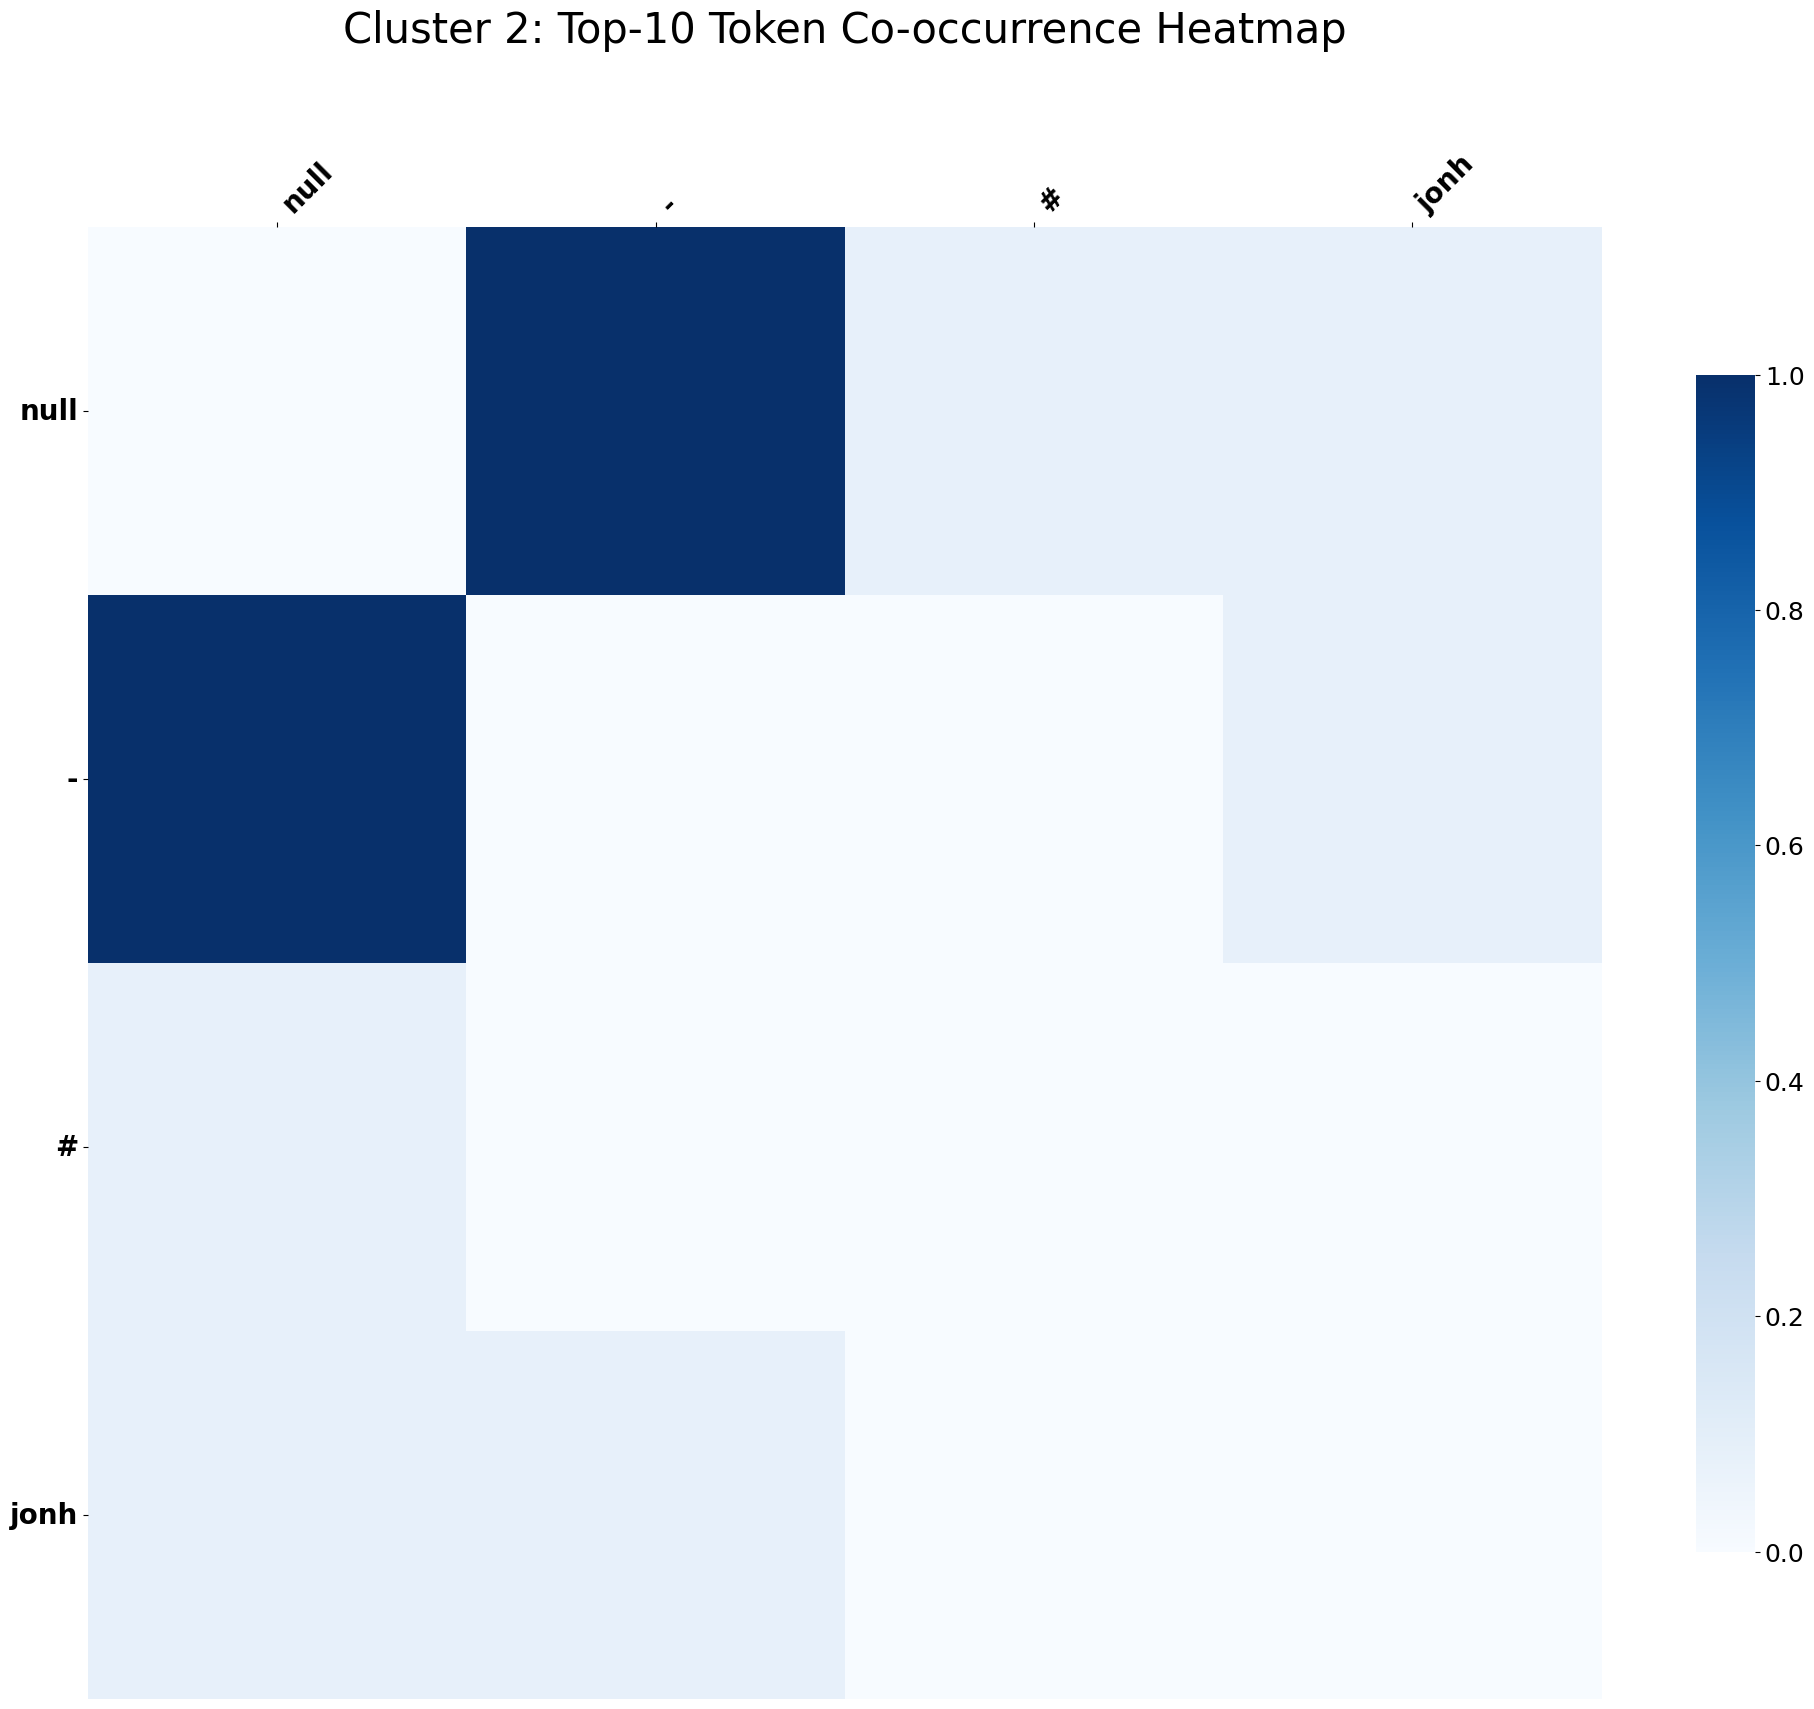

Discovered patterns for cluster 2 (Top-10): [['-', 'null']]

--- Co-occurrence Analysis for Top 20 Keywords ---


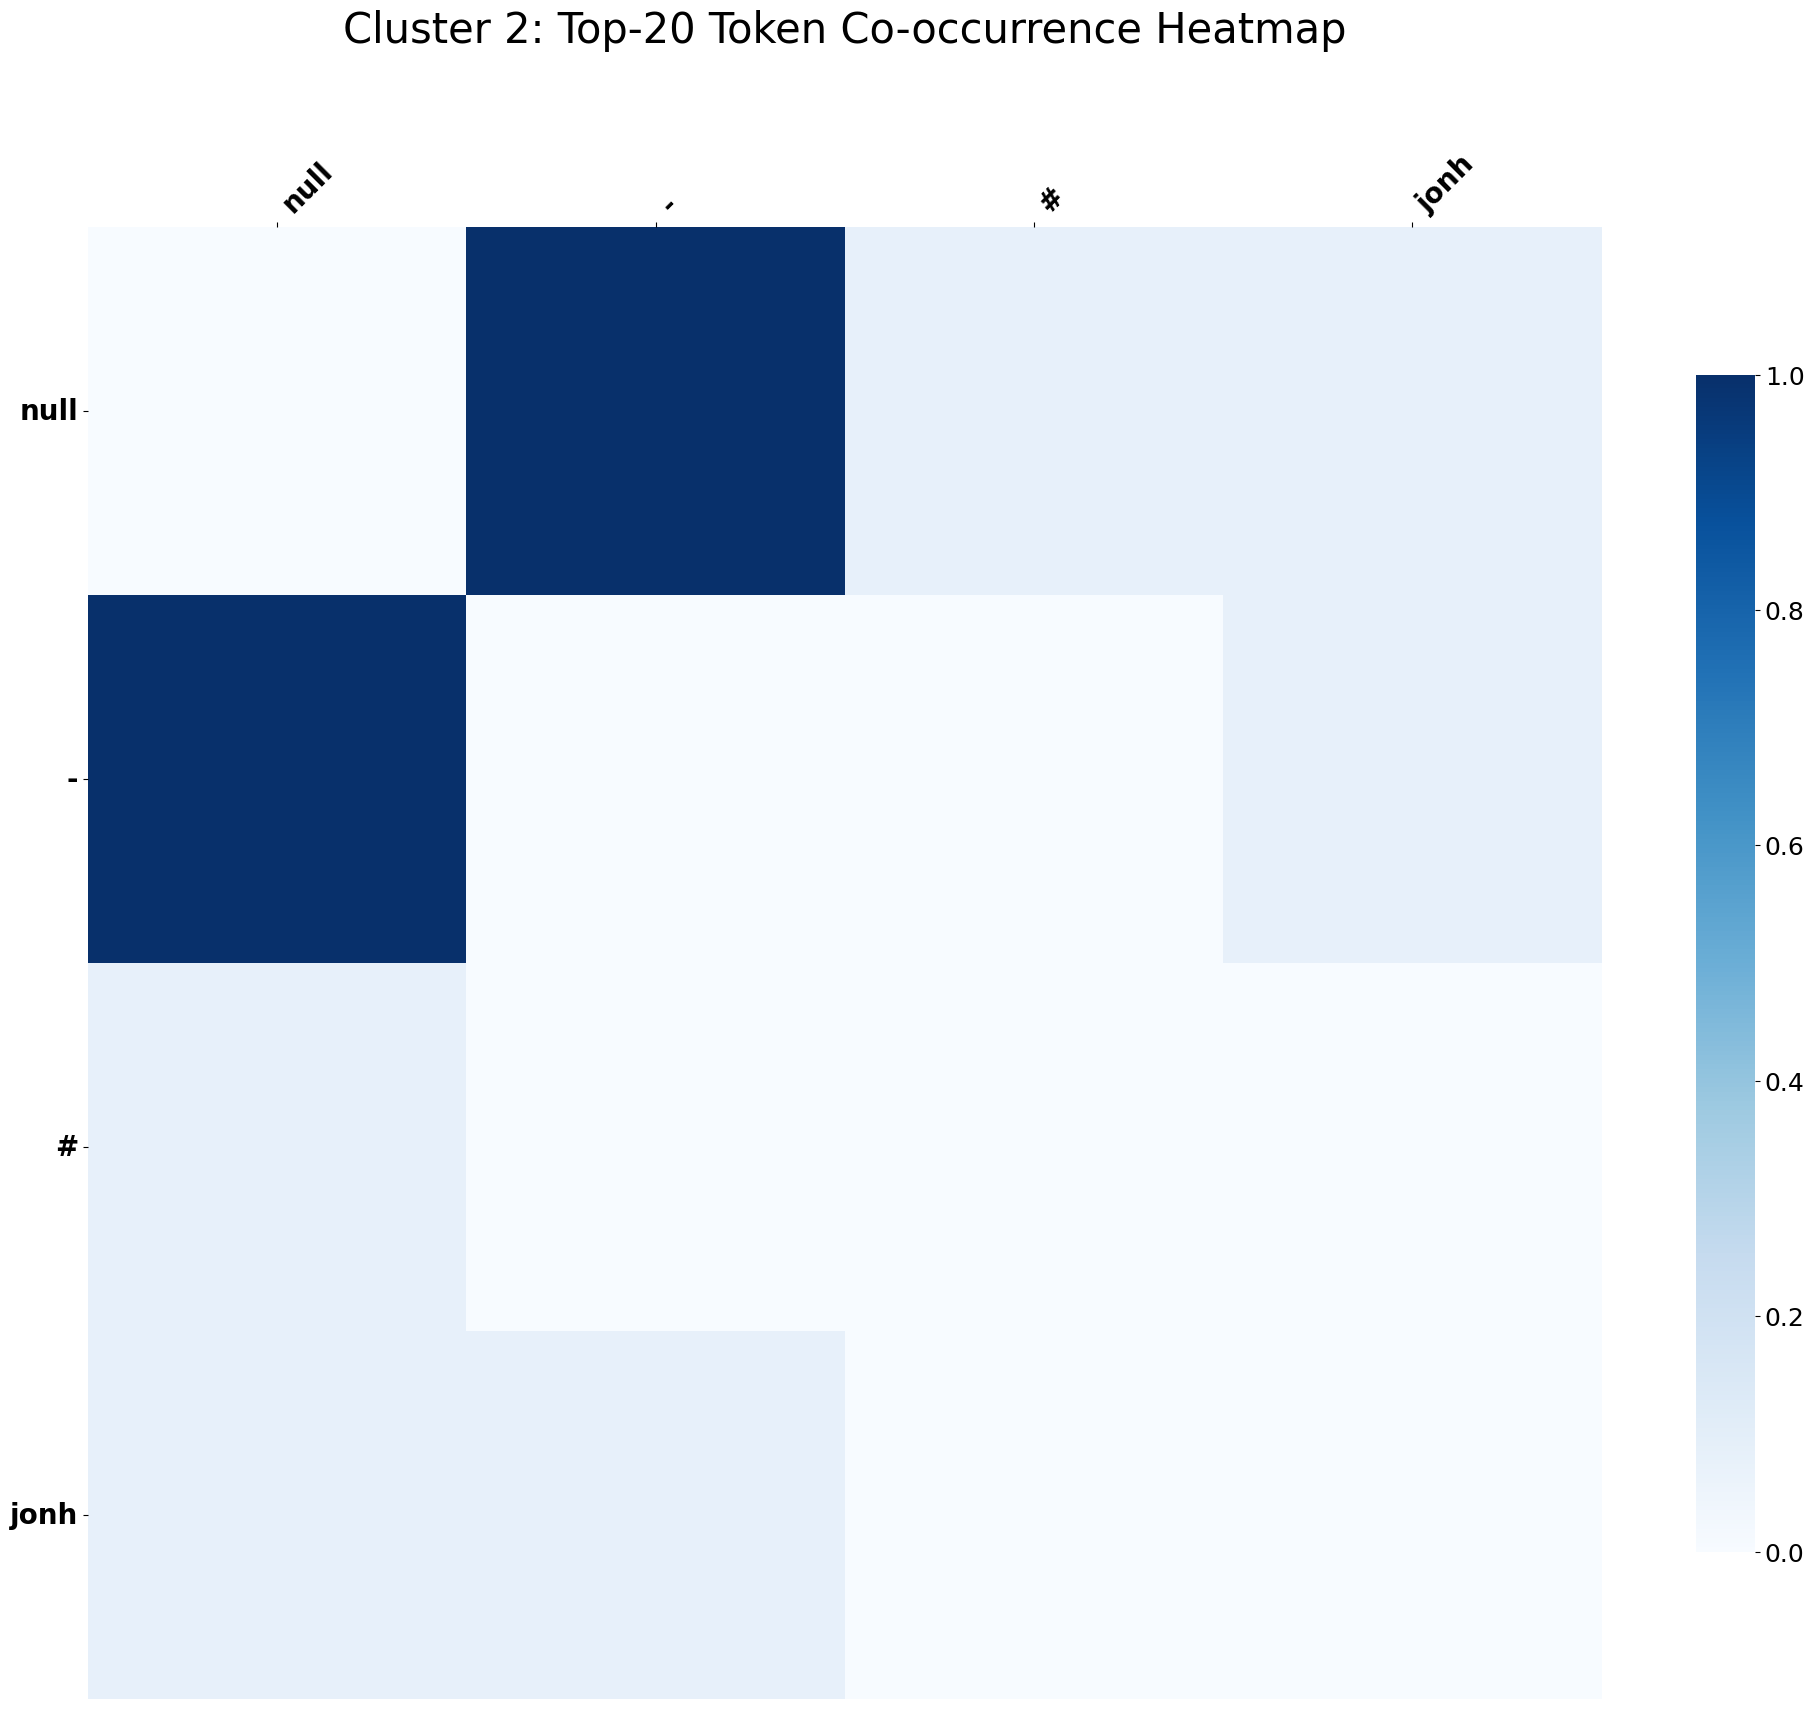

Discovered patterns for cluster 2 (Top-20): [['-', 'null']]

Processing Cluster 3...
Members in cluster 3: 38
 Top 10 words by TFIDF: ['quiz', 'mod', 'attempt', 'select', 'all', 'union', 'cmid', 'pluginfile', 'summary', 'question']
shape of candidate sets: 38

--- Co-occurrence Analysis for Top 5 Keywords ---


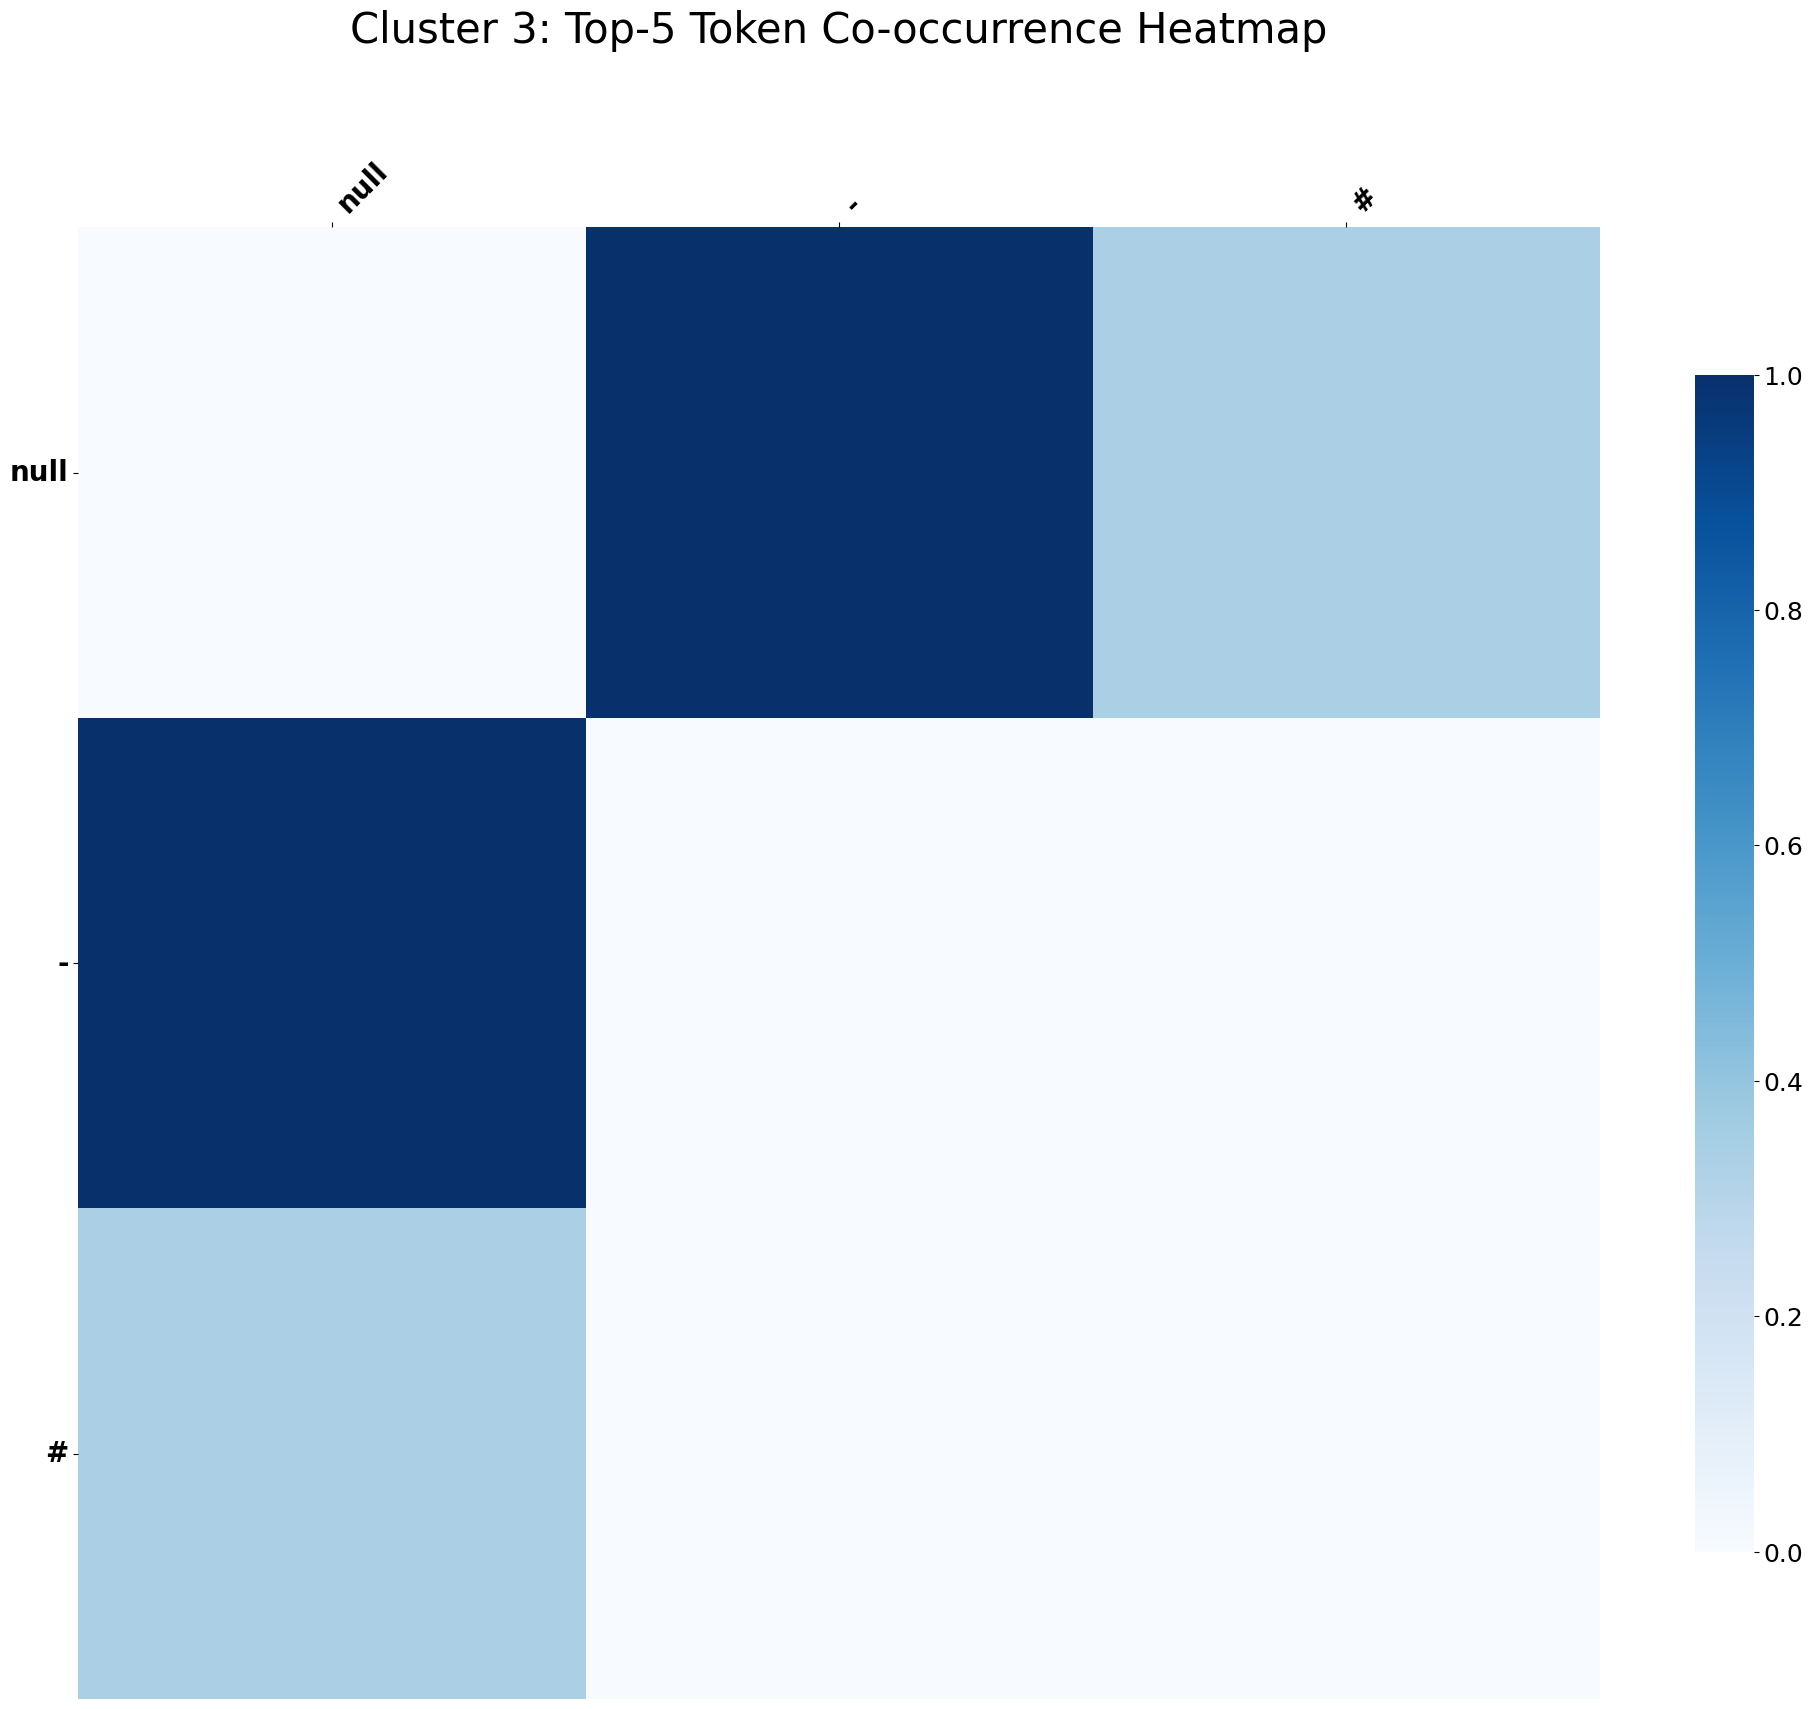

Discovered patterns for cluster 3 (Top-5): [['-', 'null']]

--- Co-occurrence Analysis for Top 10 Keywords ---


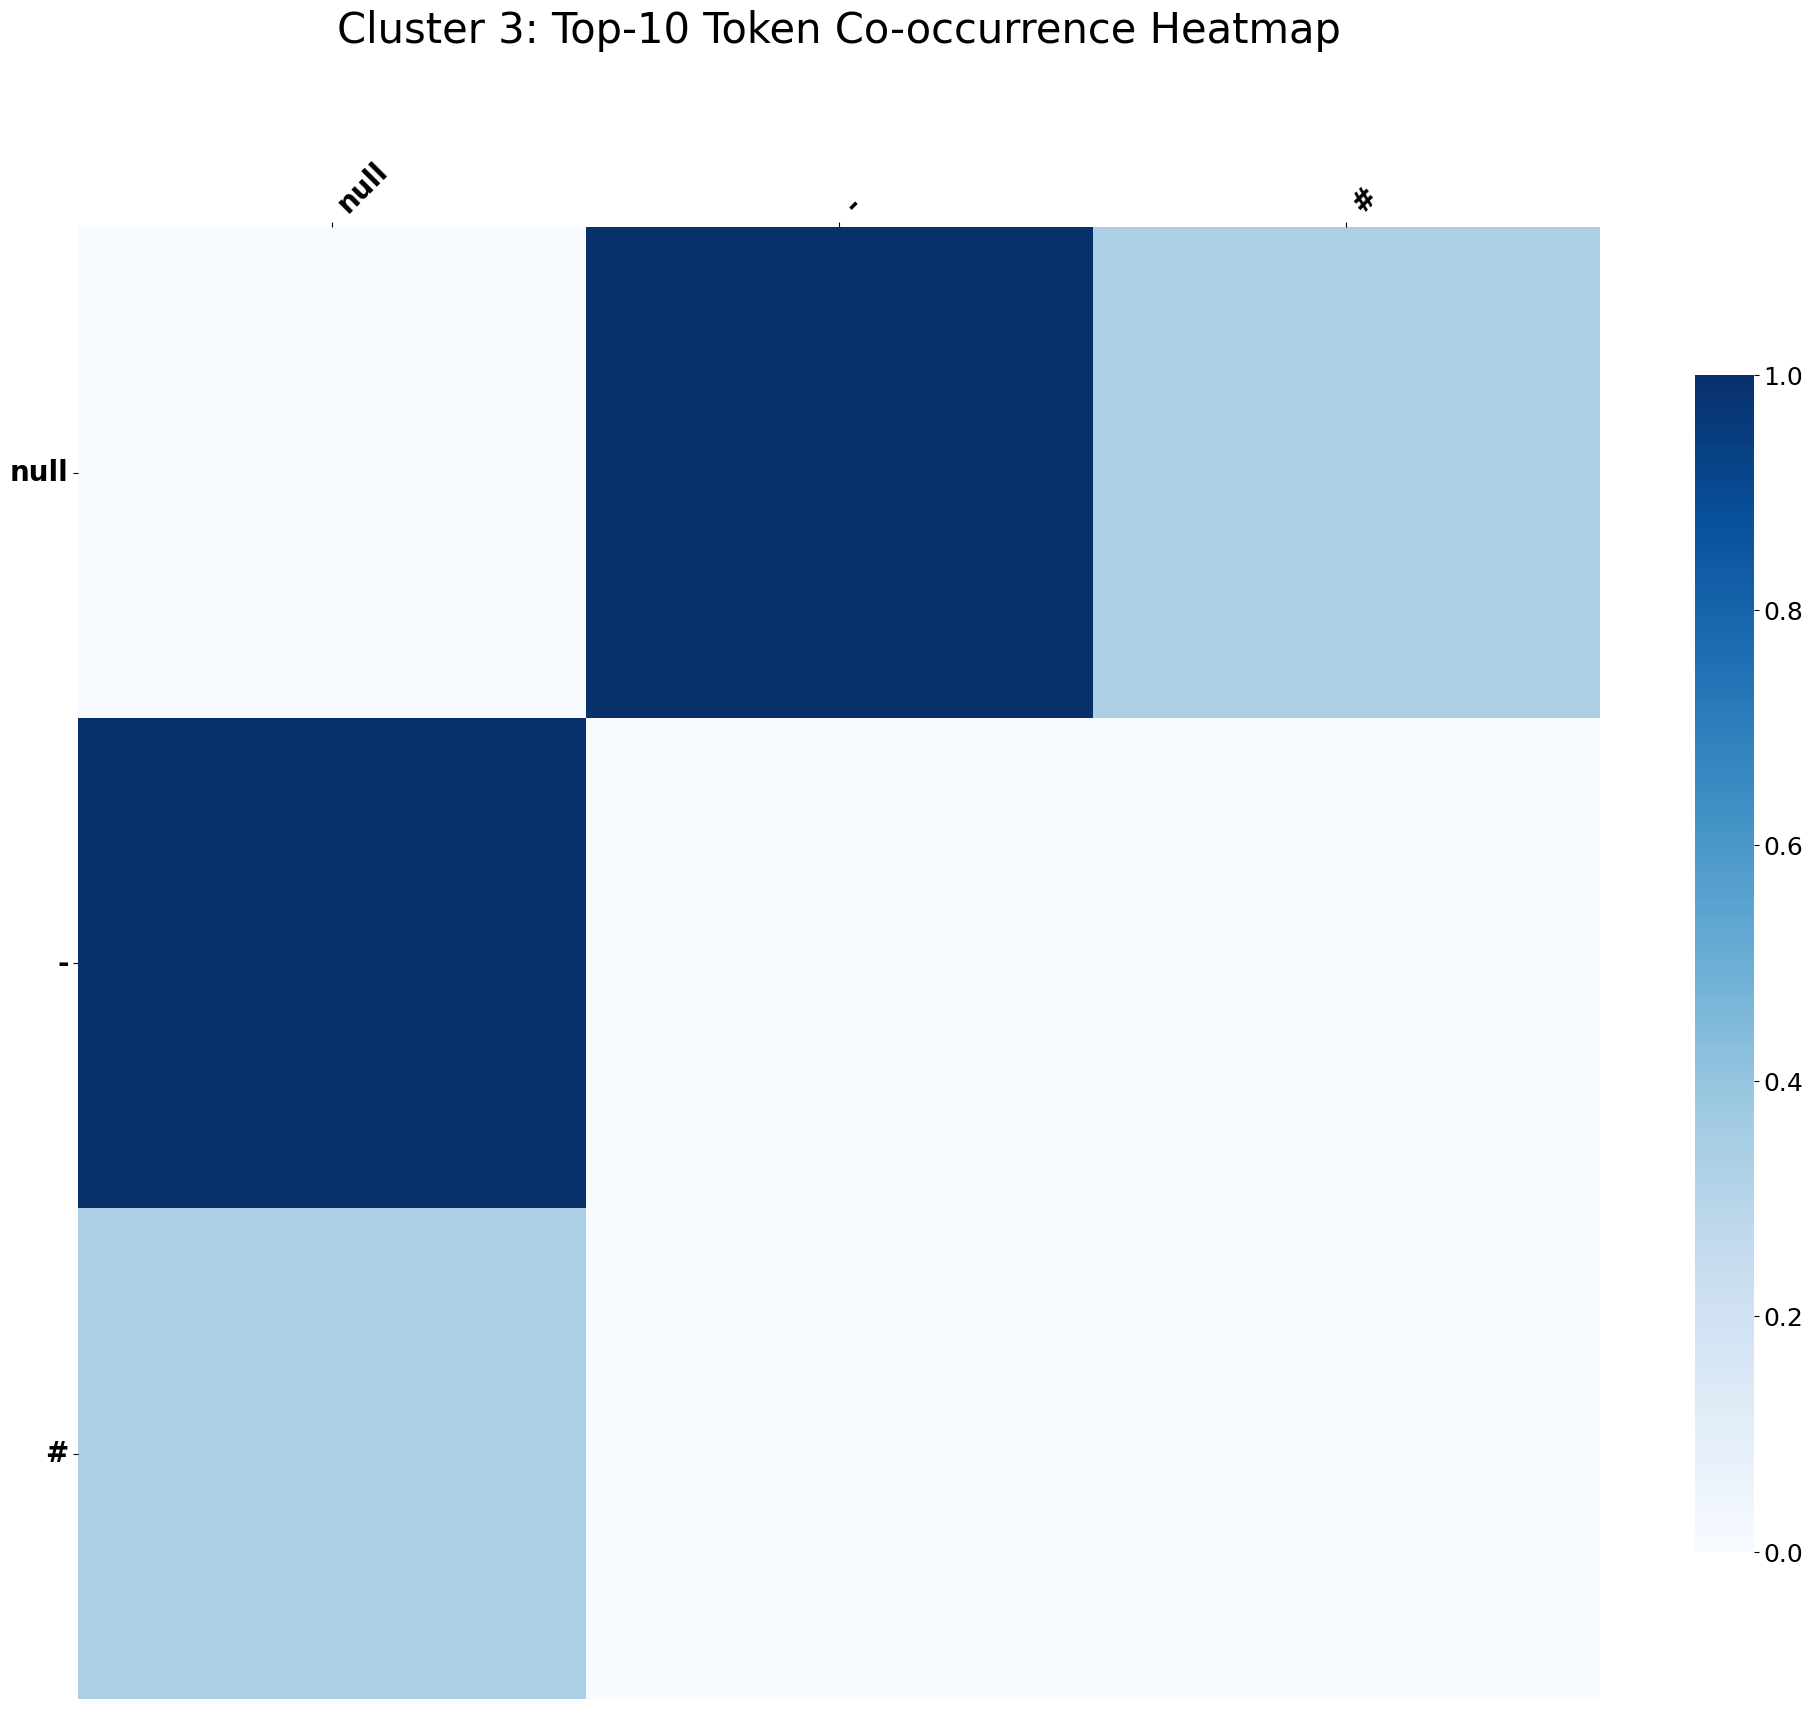

Discovered patterns for cluster 3 (Top-10): [['-', 'null']]

--- Co-occurrence Analysis for Top 20 Keywords ---


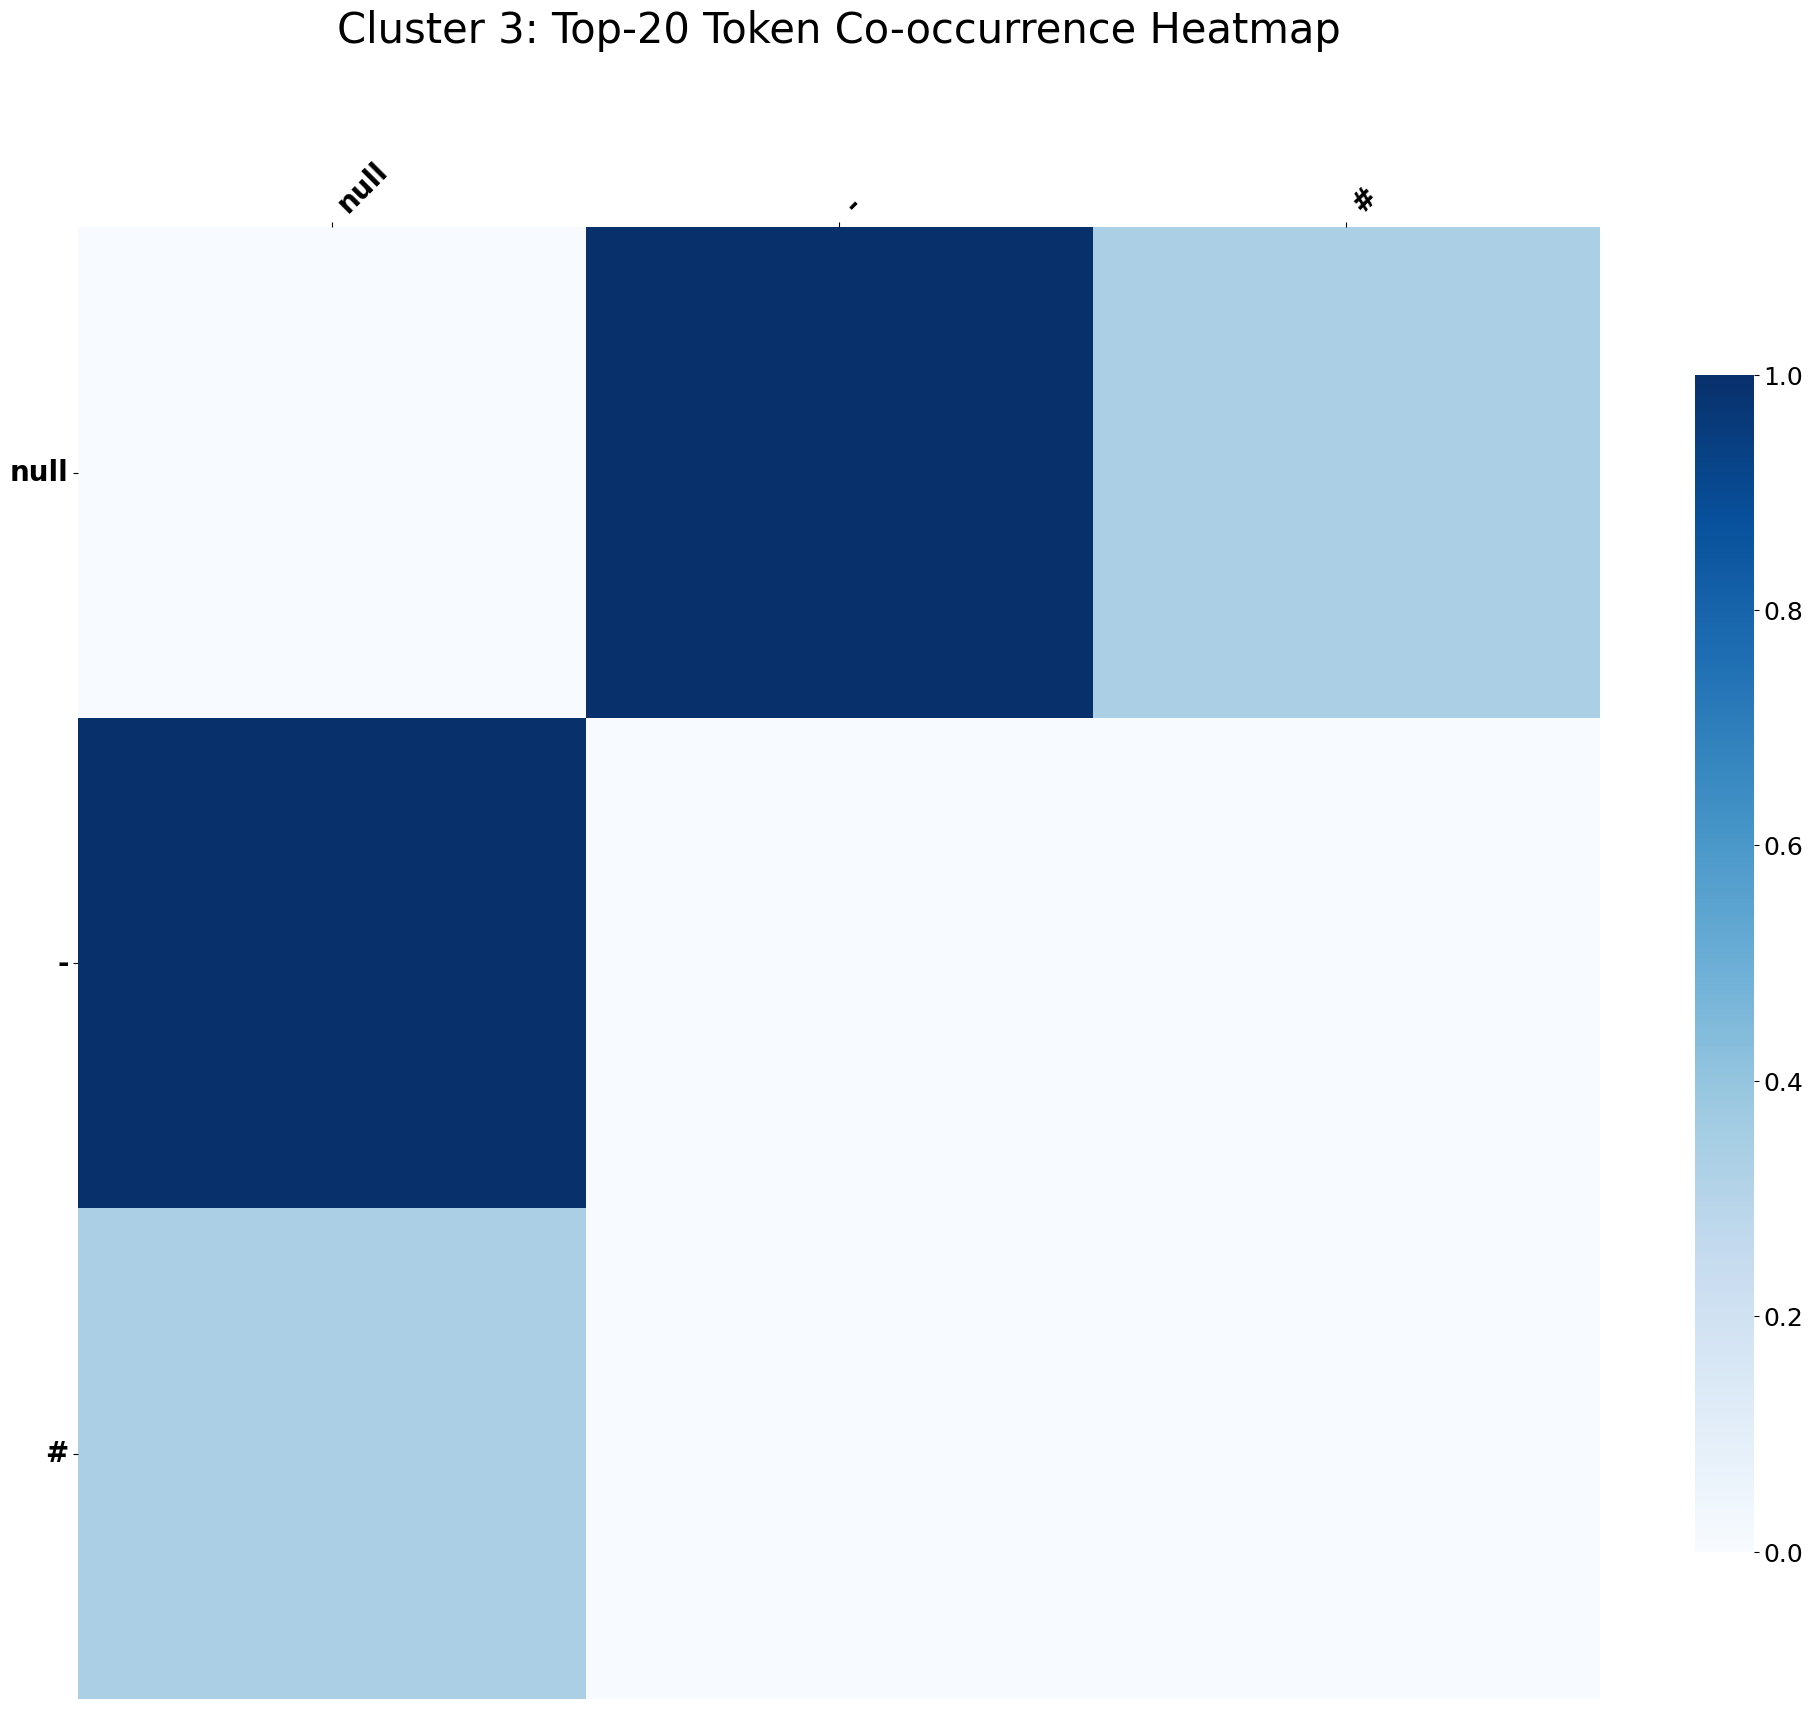

Discovered patterns for cluster 3 (Top-20): [['-', 'null']]

Processing Cluster 4...
Members in cluster 4: 27
 Top 10 words by TFIDF: ['style', 'pluginfile', 'question', 'alert', 'animation', 'keyframes', 'name', '113836', 'answer', 'onanimationstart']
shape of candidate sets: 27

--- Co-occurrence Analysis for Top 5 Keywords ---


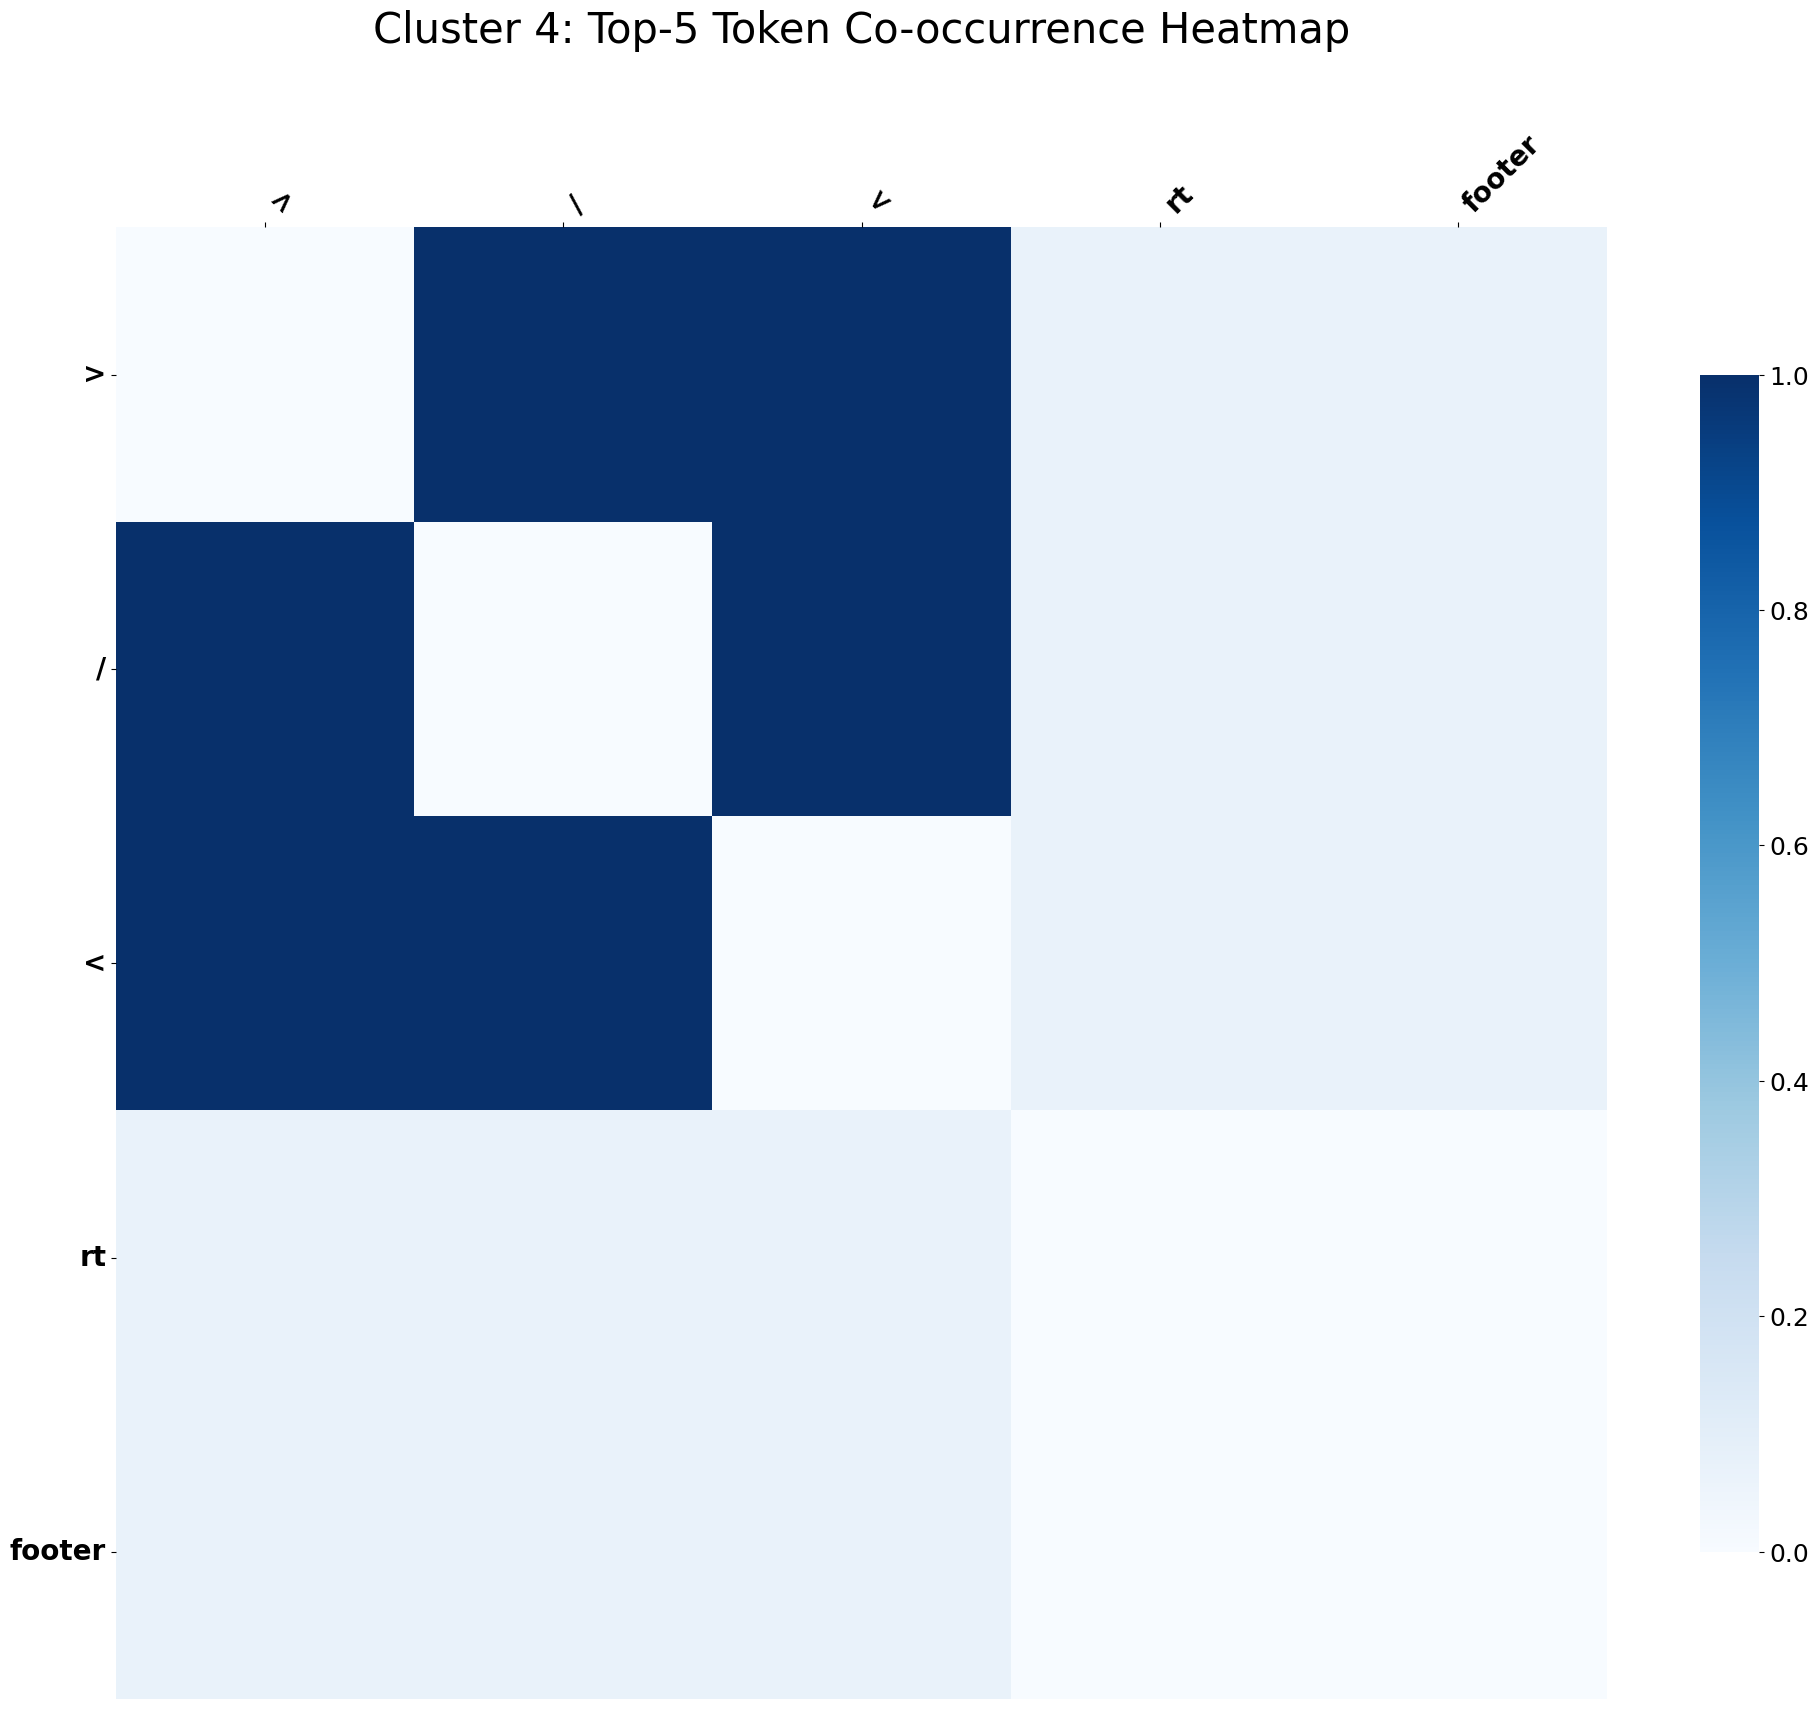

Discovered patterns for cluster 4 (Top-5): [['/', '<', '>']]

--- Co-occurrence Analysis for Top 10 Keywords ---


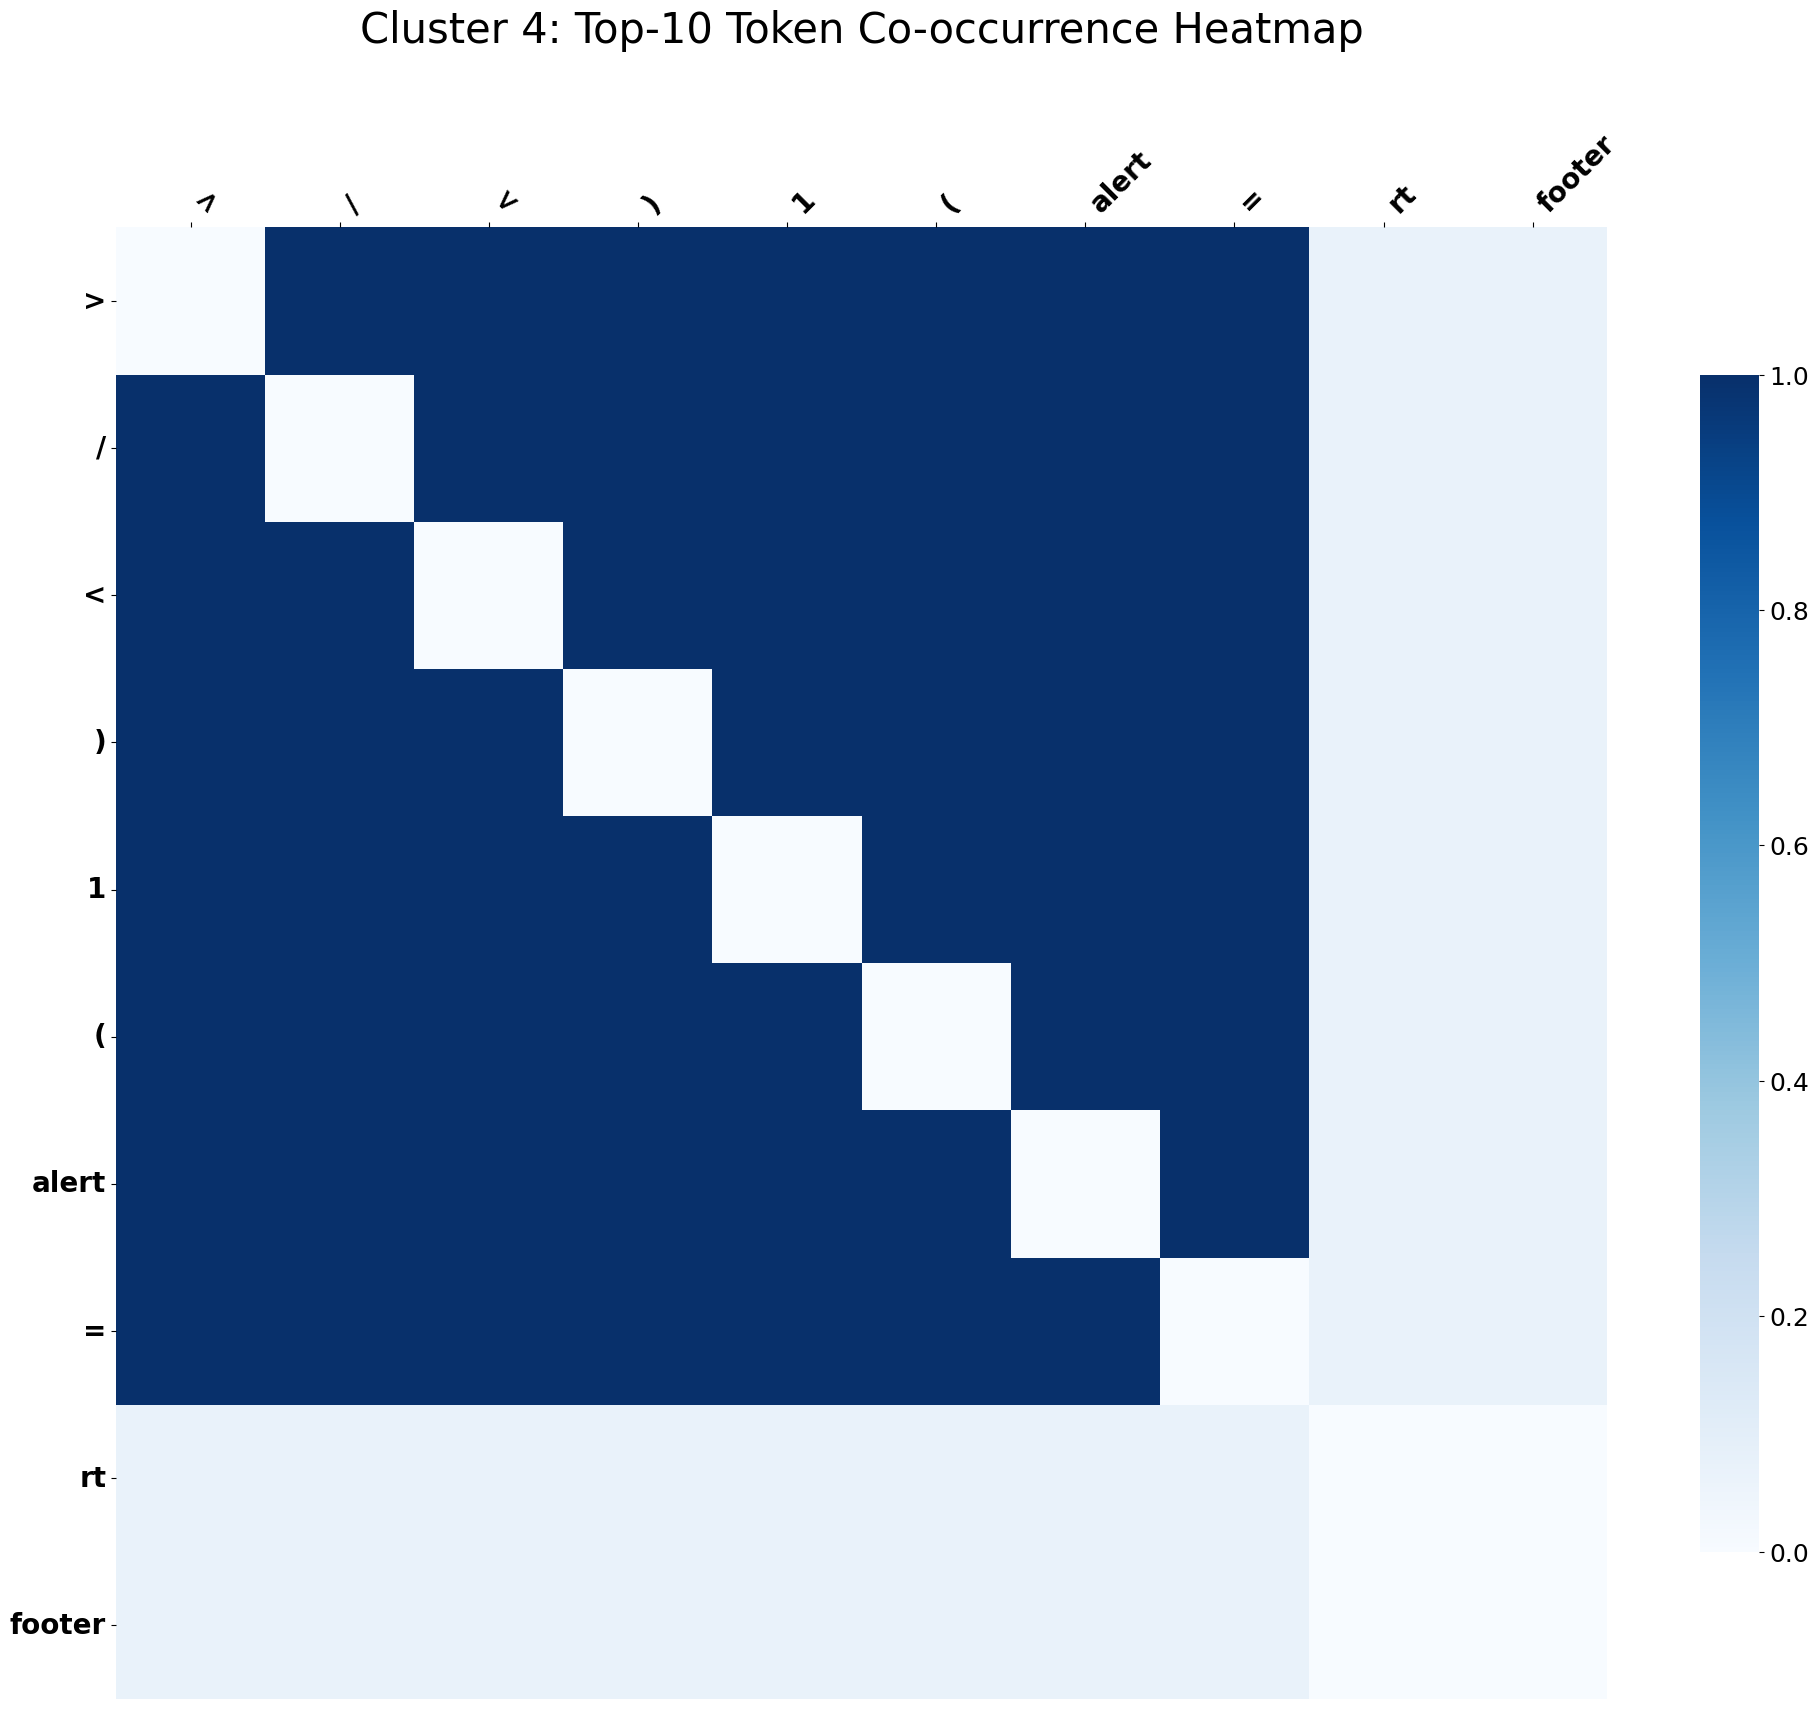

Discovered patterns for cluster 4 (Top-10): [['(', ')', '/', '1', '<', '=', '>', 'alert']]

--- Co-occurrence Analysis for Top 20 Keywords ---


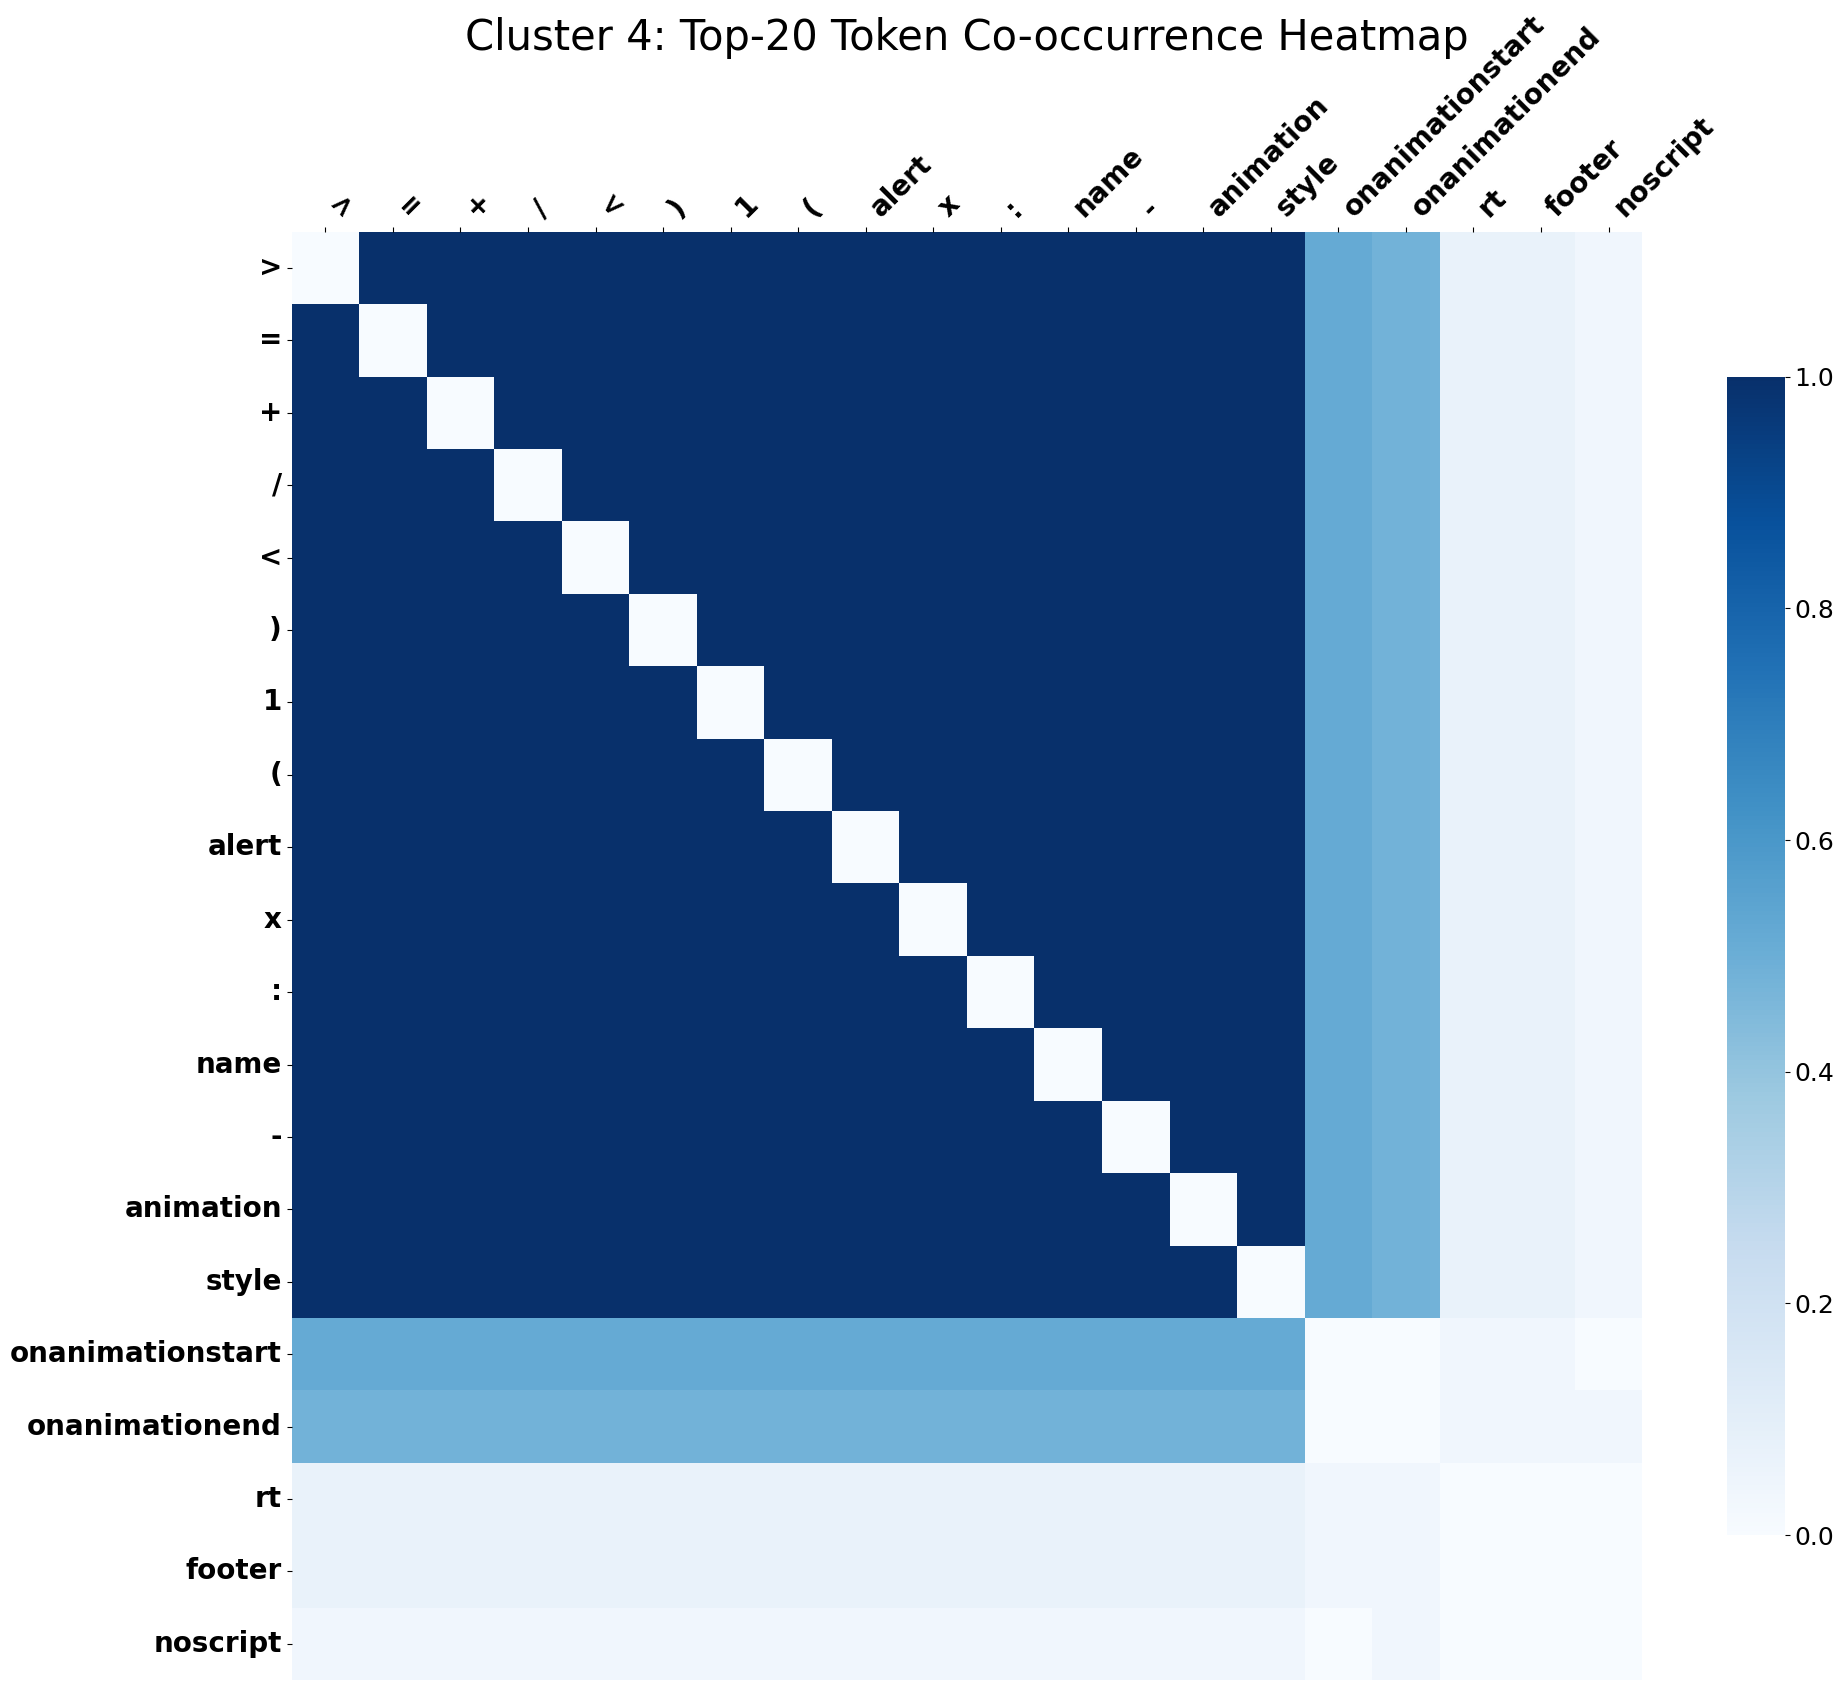

Discovered patterns for cluster 4 (Top-20): [['(', ')', '+', '-', '/', '1', ':', '<', '=', '>', 'alert', 'animation', 'name', 'onanimationend', 'onanimationstart', 'style', 'x']]

Processing Cluster 5...
Members in cluster 5: 10
 Top 10 words by TFIDF: ['style', 'animation', 'quiz', 'mod', 'count', 'name', 'onanimationiteration', 'keyframes', 'iteration', 'duration']
shape of candidate sets: 10

--- Co-occurrence Analysis for Top 5 Keywords ---


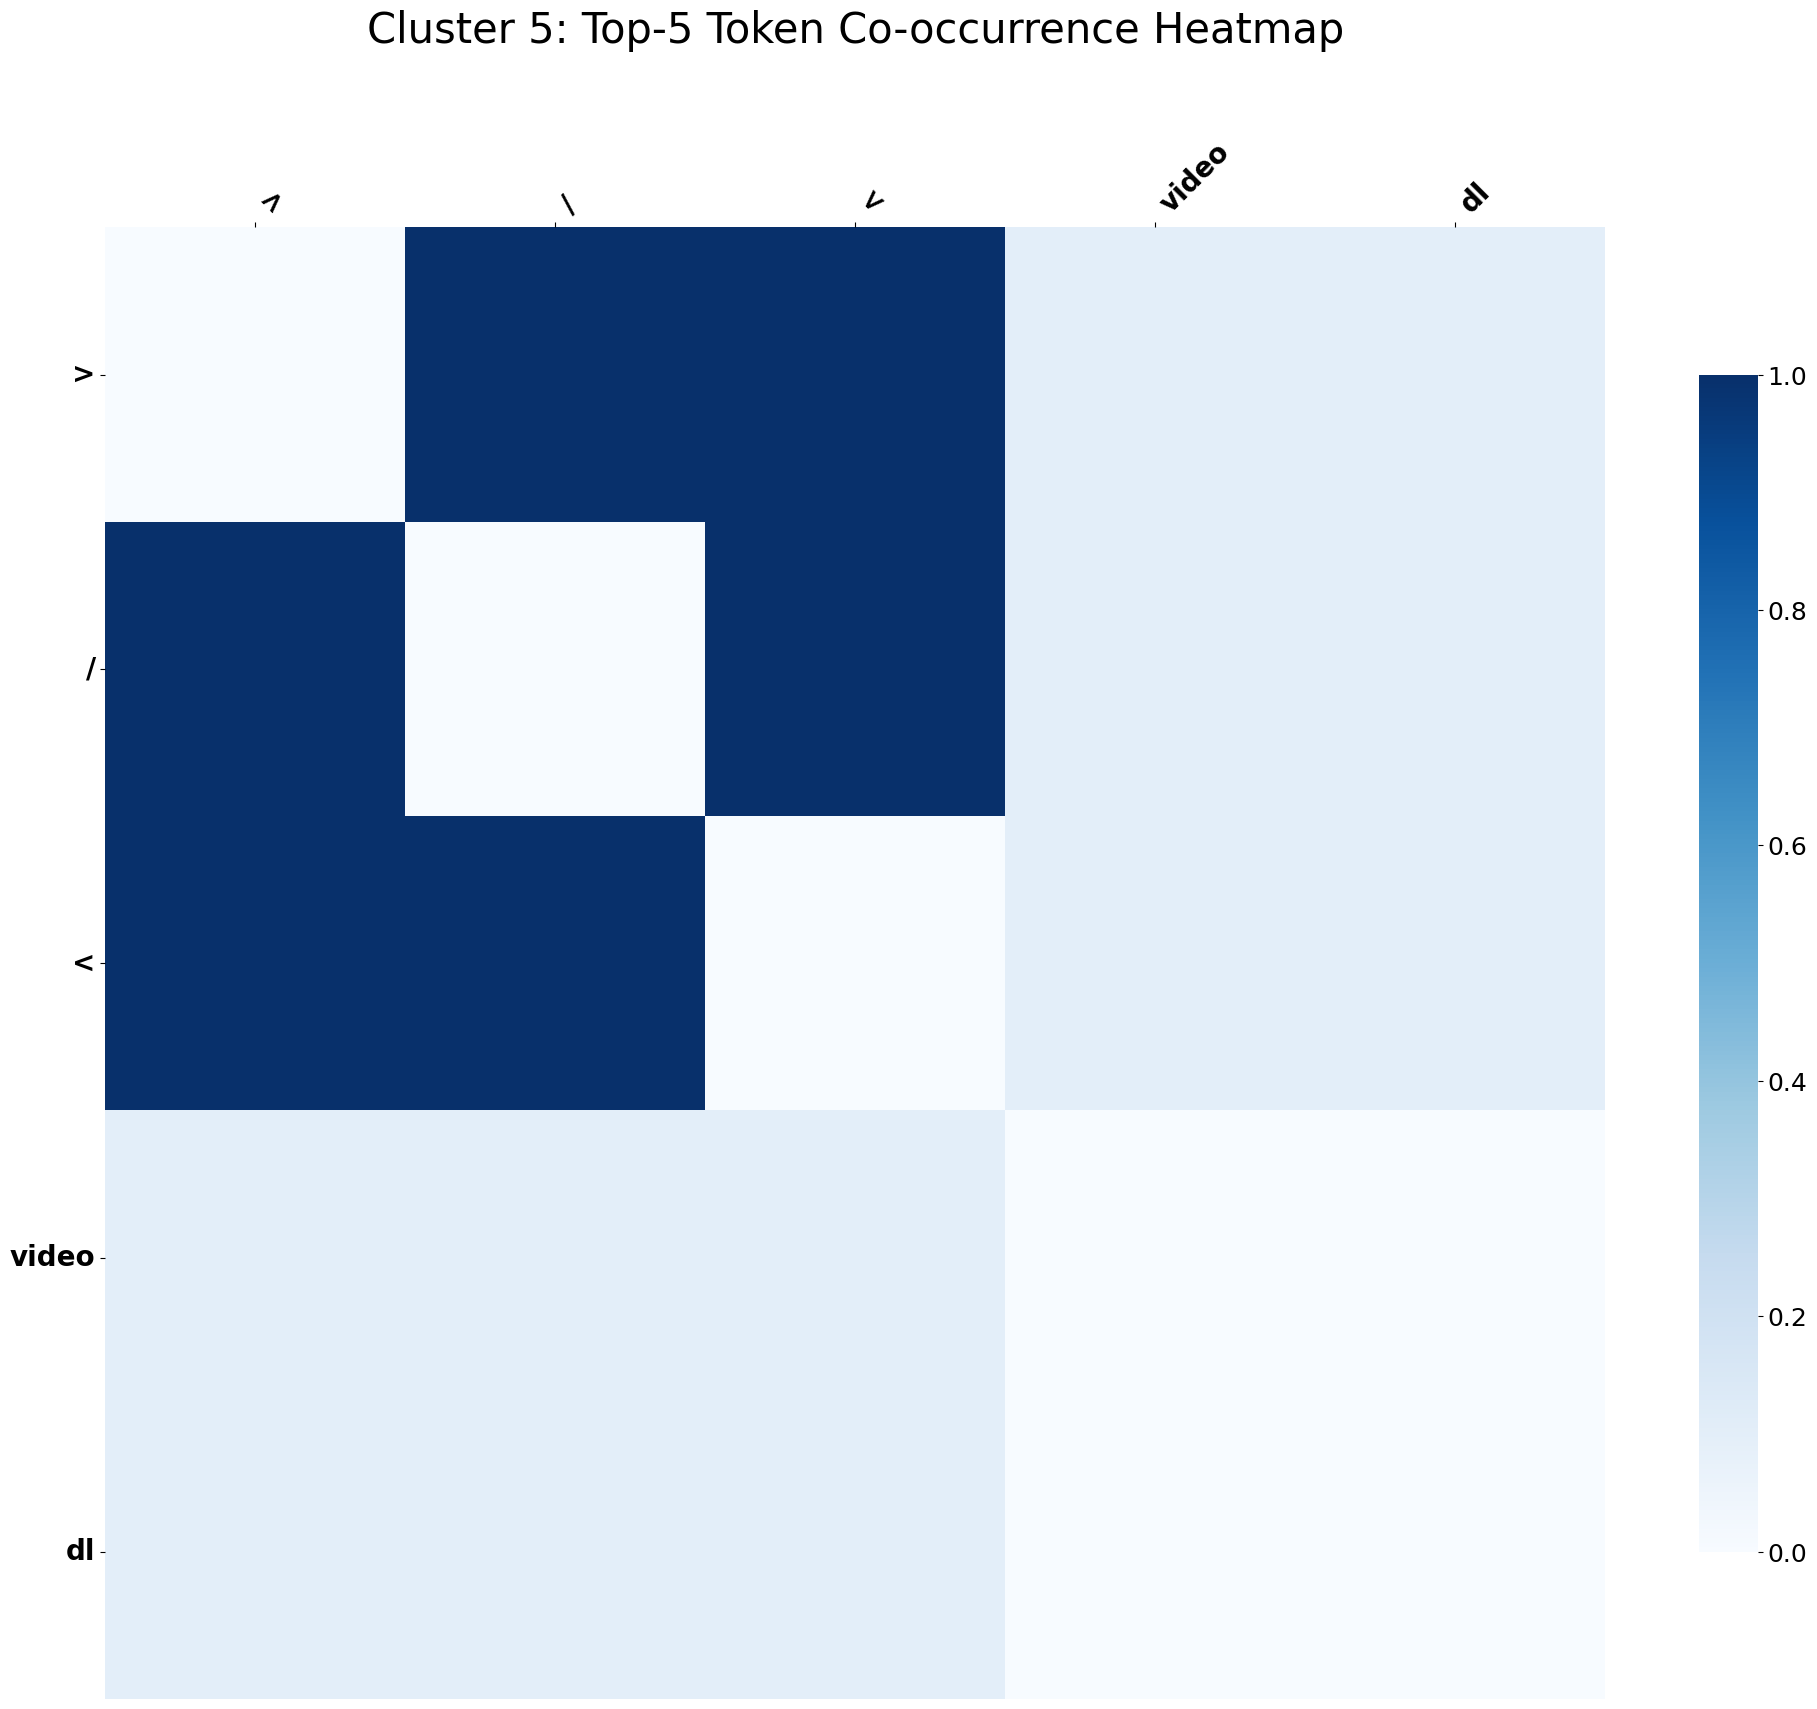

Discovered patterns for cluster 5 (Top-5): [['/', '<', '>']]

--- Co-occurrence Analysis for Top 10 Keywords ---


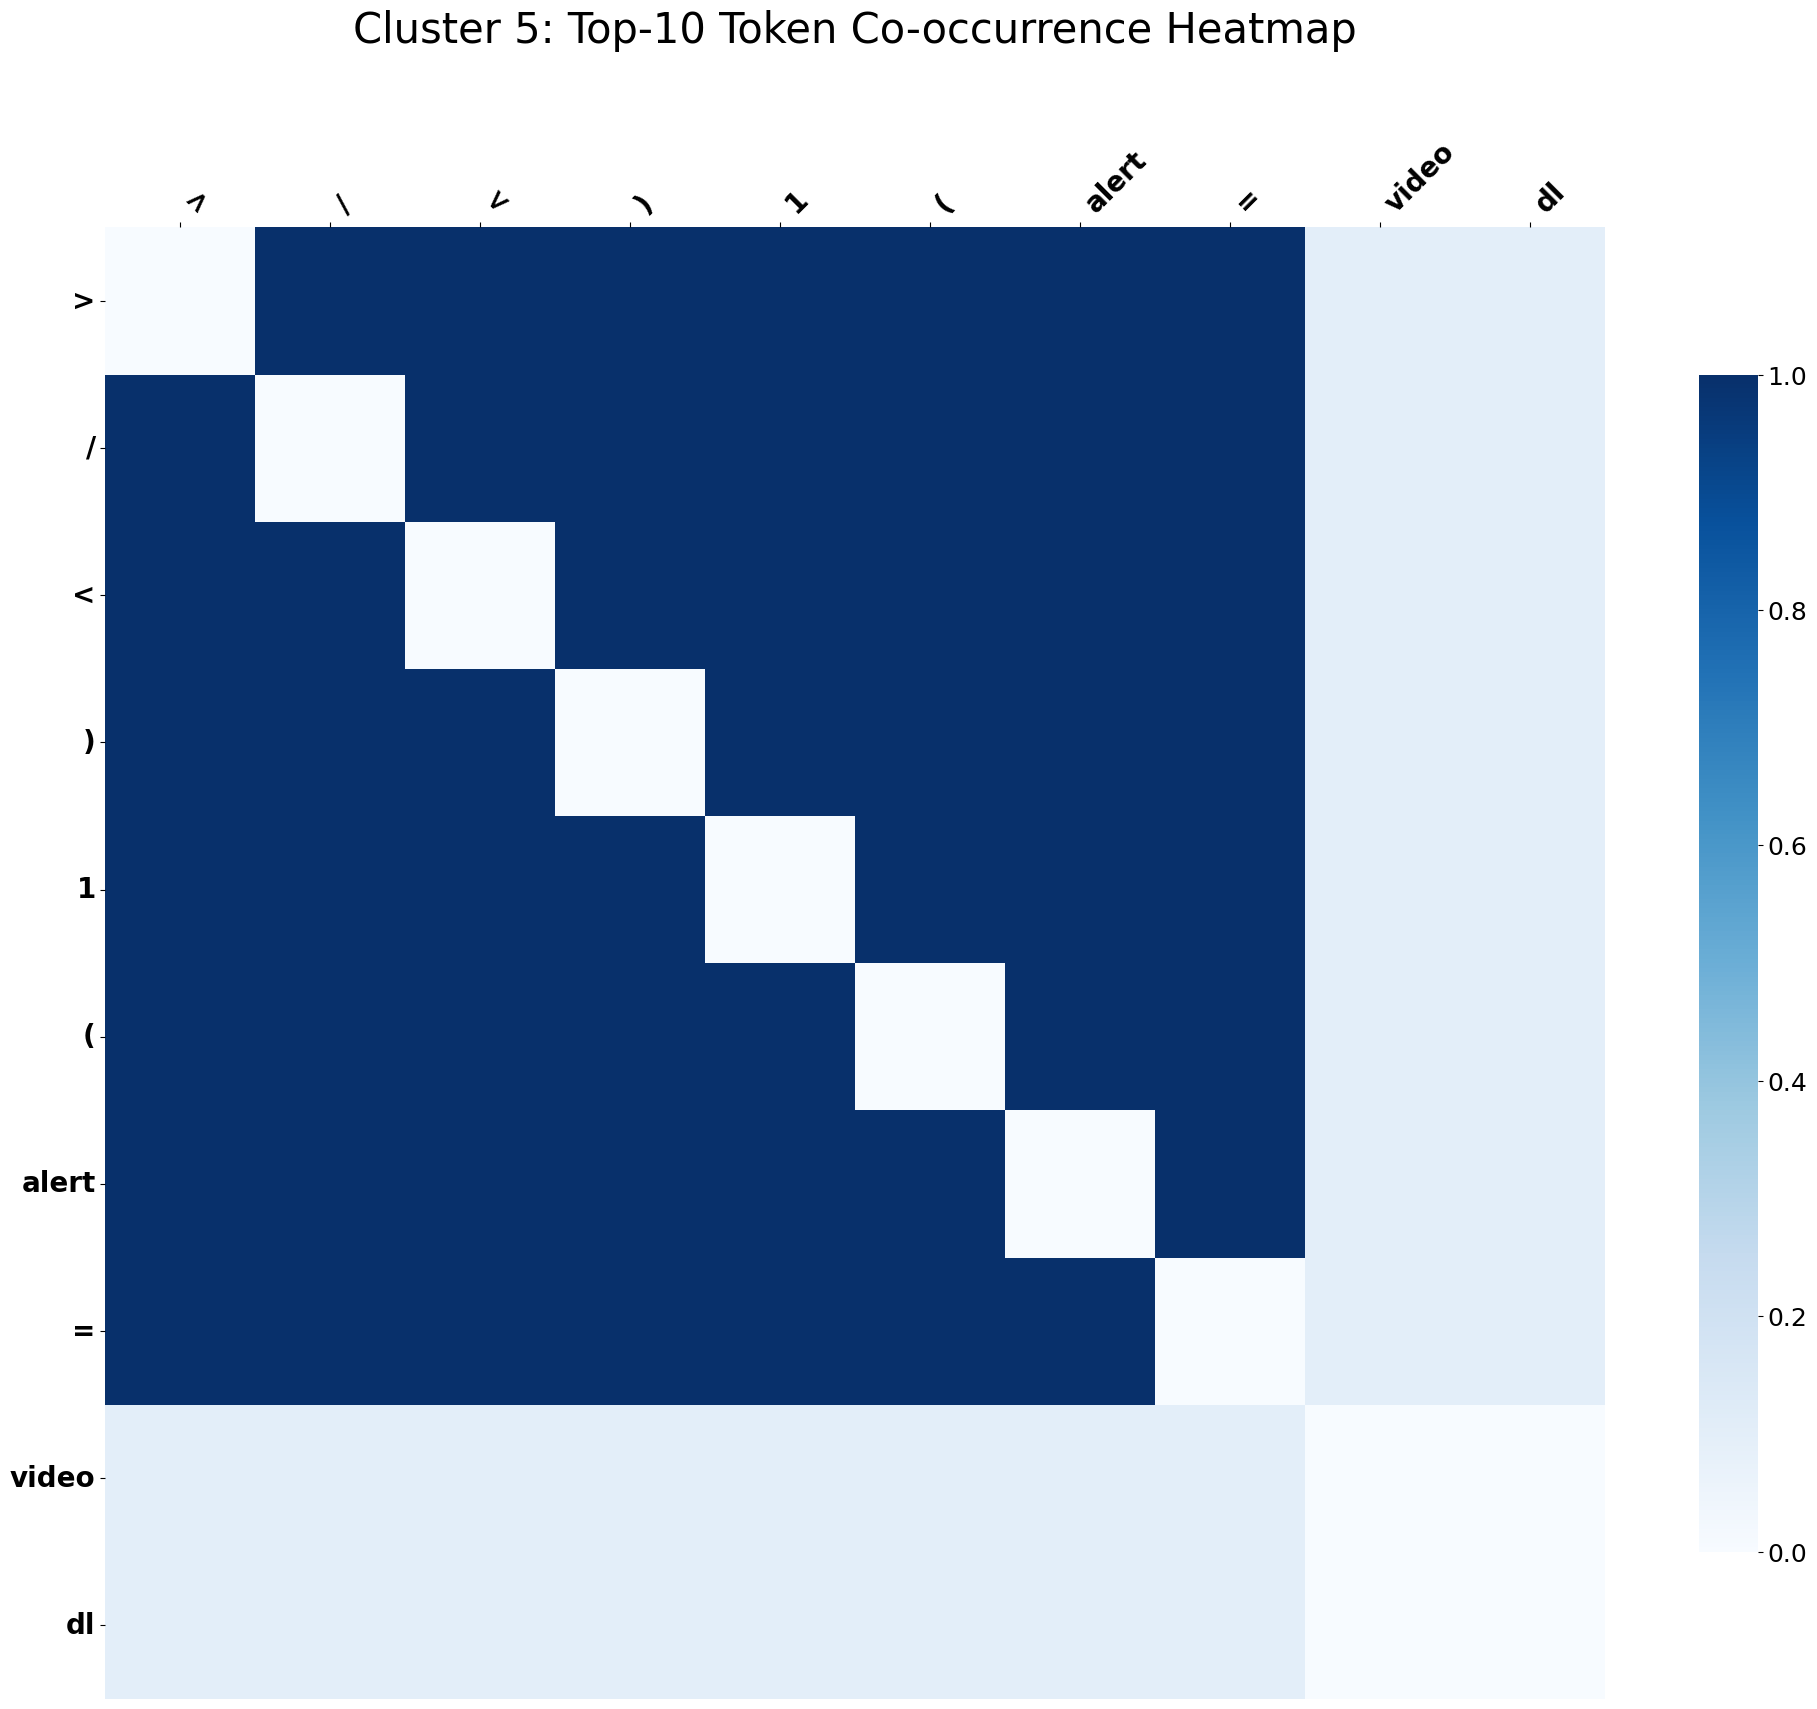

Discovered patterns for cluster 5 (Top-10): [['(', ')', '/', '1', '<', '=', '>', 'alert']]

--- Co-occurrence Analysis for Top 20 Keywords ---


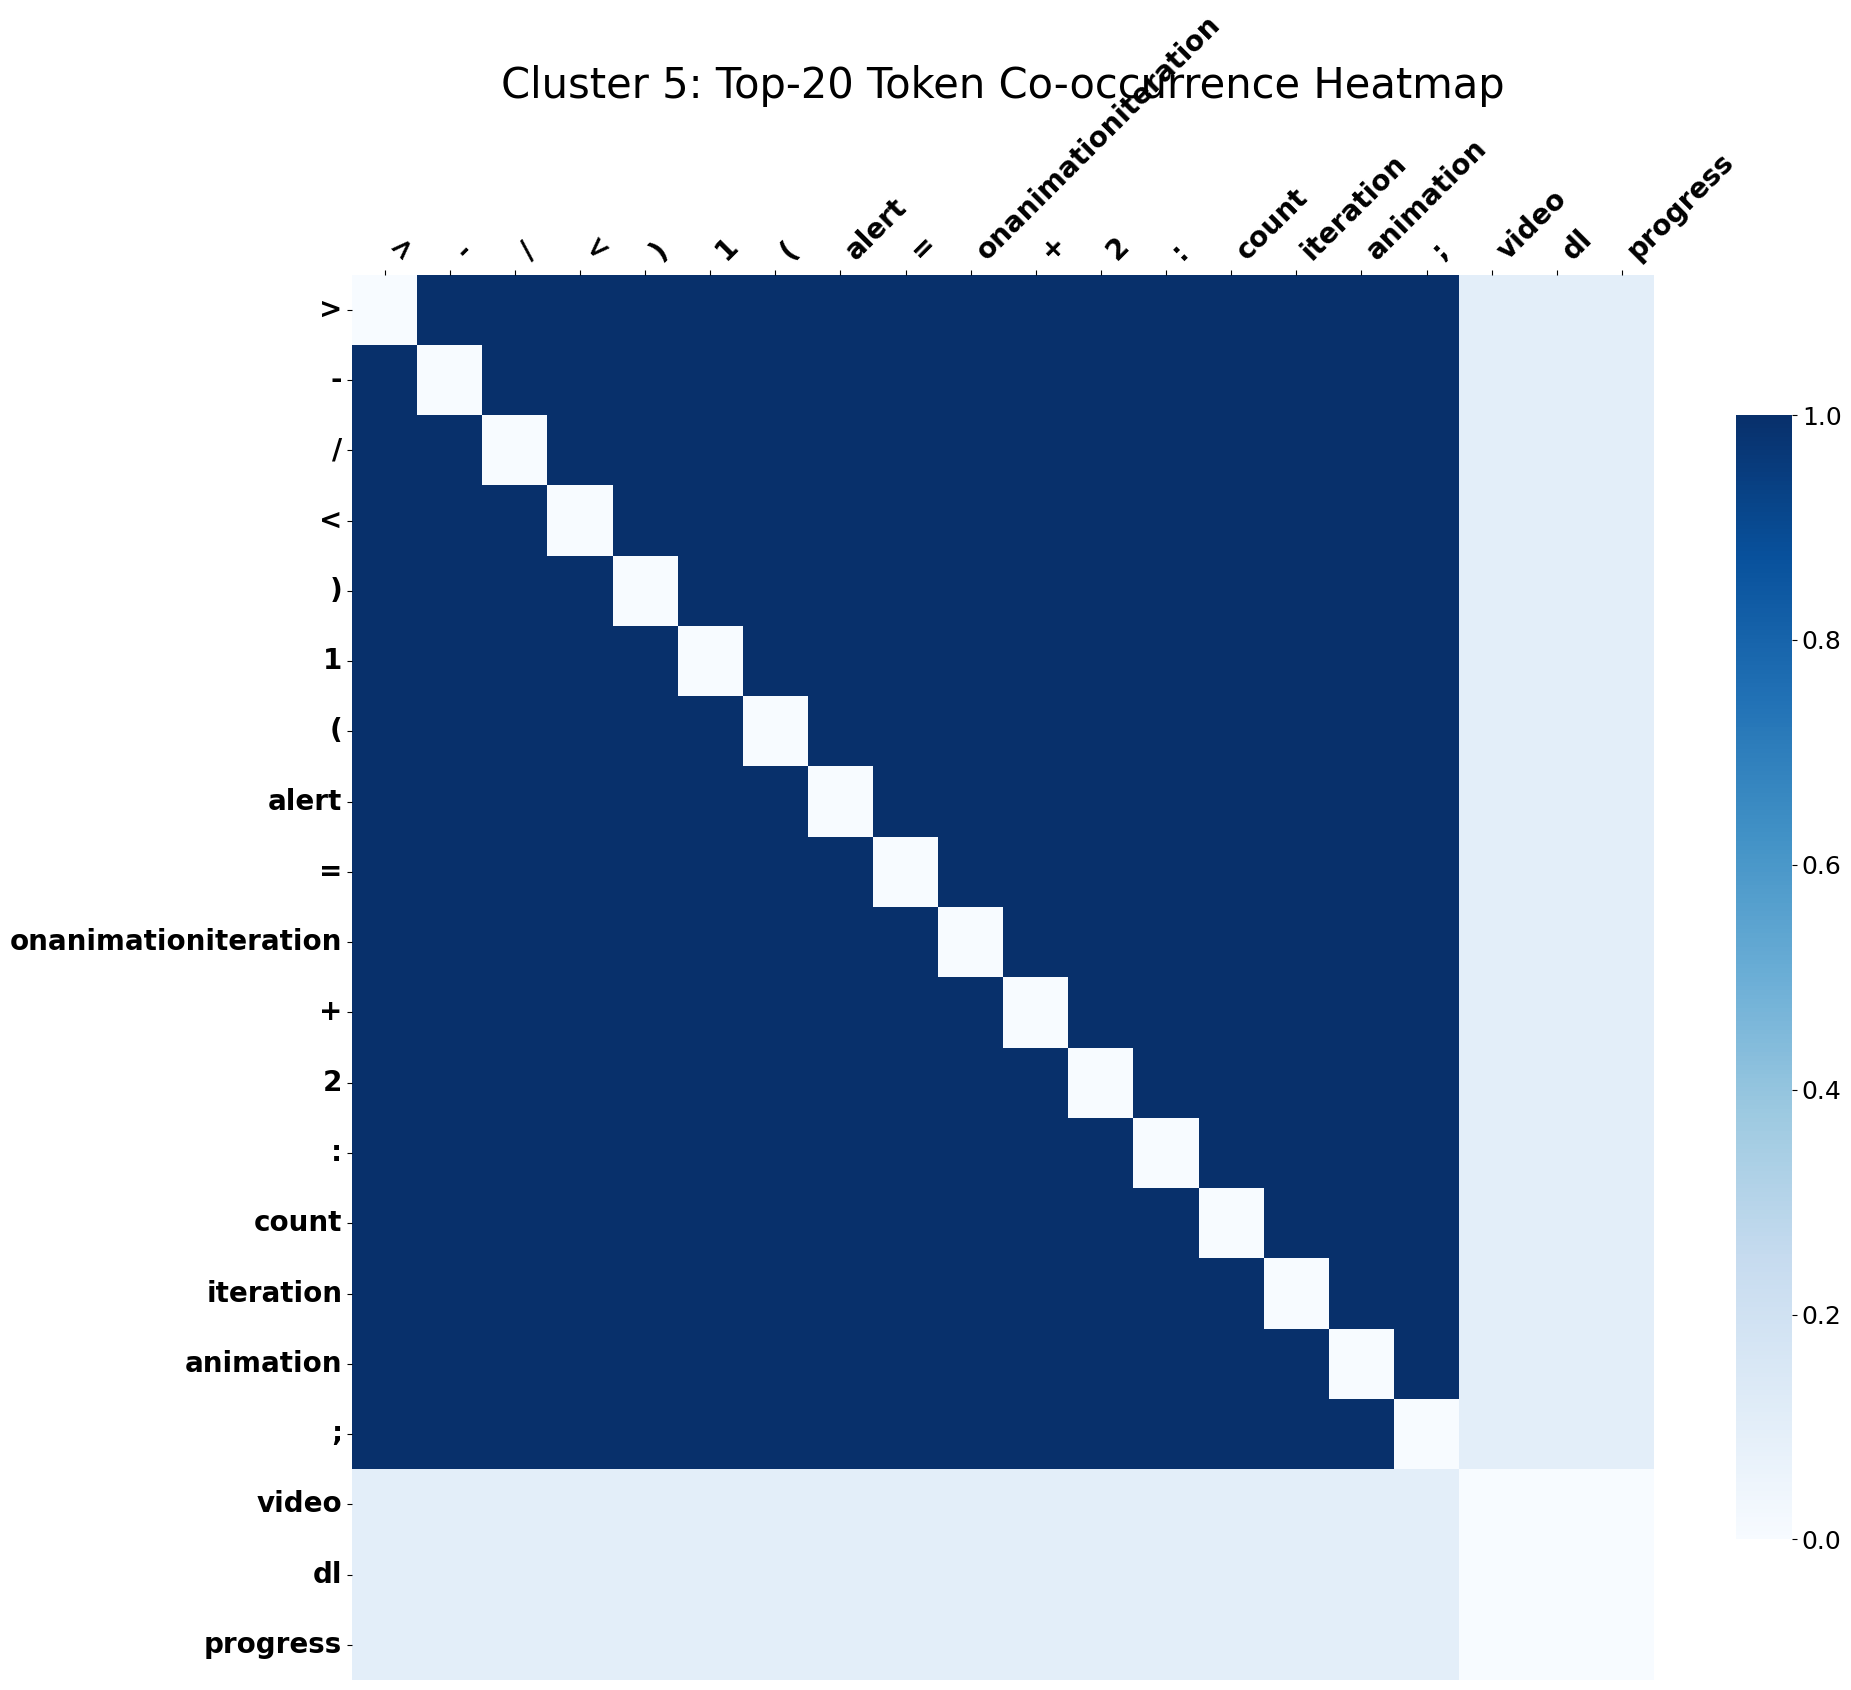

Discovered patterns for cluster 5 (Top-20): [['(', ')', '+', '-', '/', '1', '2', ':', ';', '<', '=', '>', 'alert', 'animation', 'count', 'iteration', 'onanimationiteration']]

Processing Cluster 6...
Members in cluster 6: 39
 Top 10 words by TFIDF: ['question', 'pluginfile', 'answer', '113836', 'select', 'union', 'all', 'jpg', 'questiontext', 'q12']
shape of candidate sets: 39

--- Co-occurrence Analysis for Top 5 Keywords ---


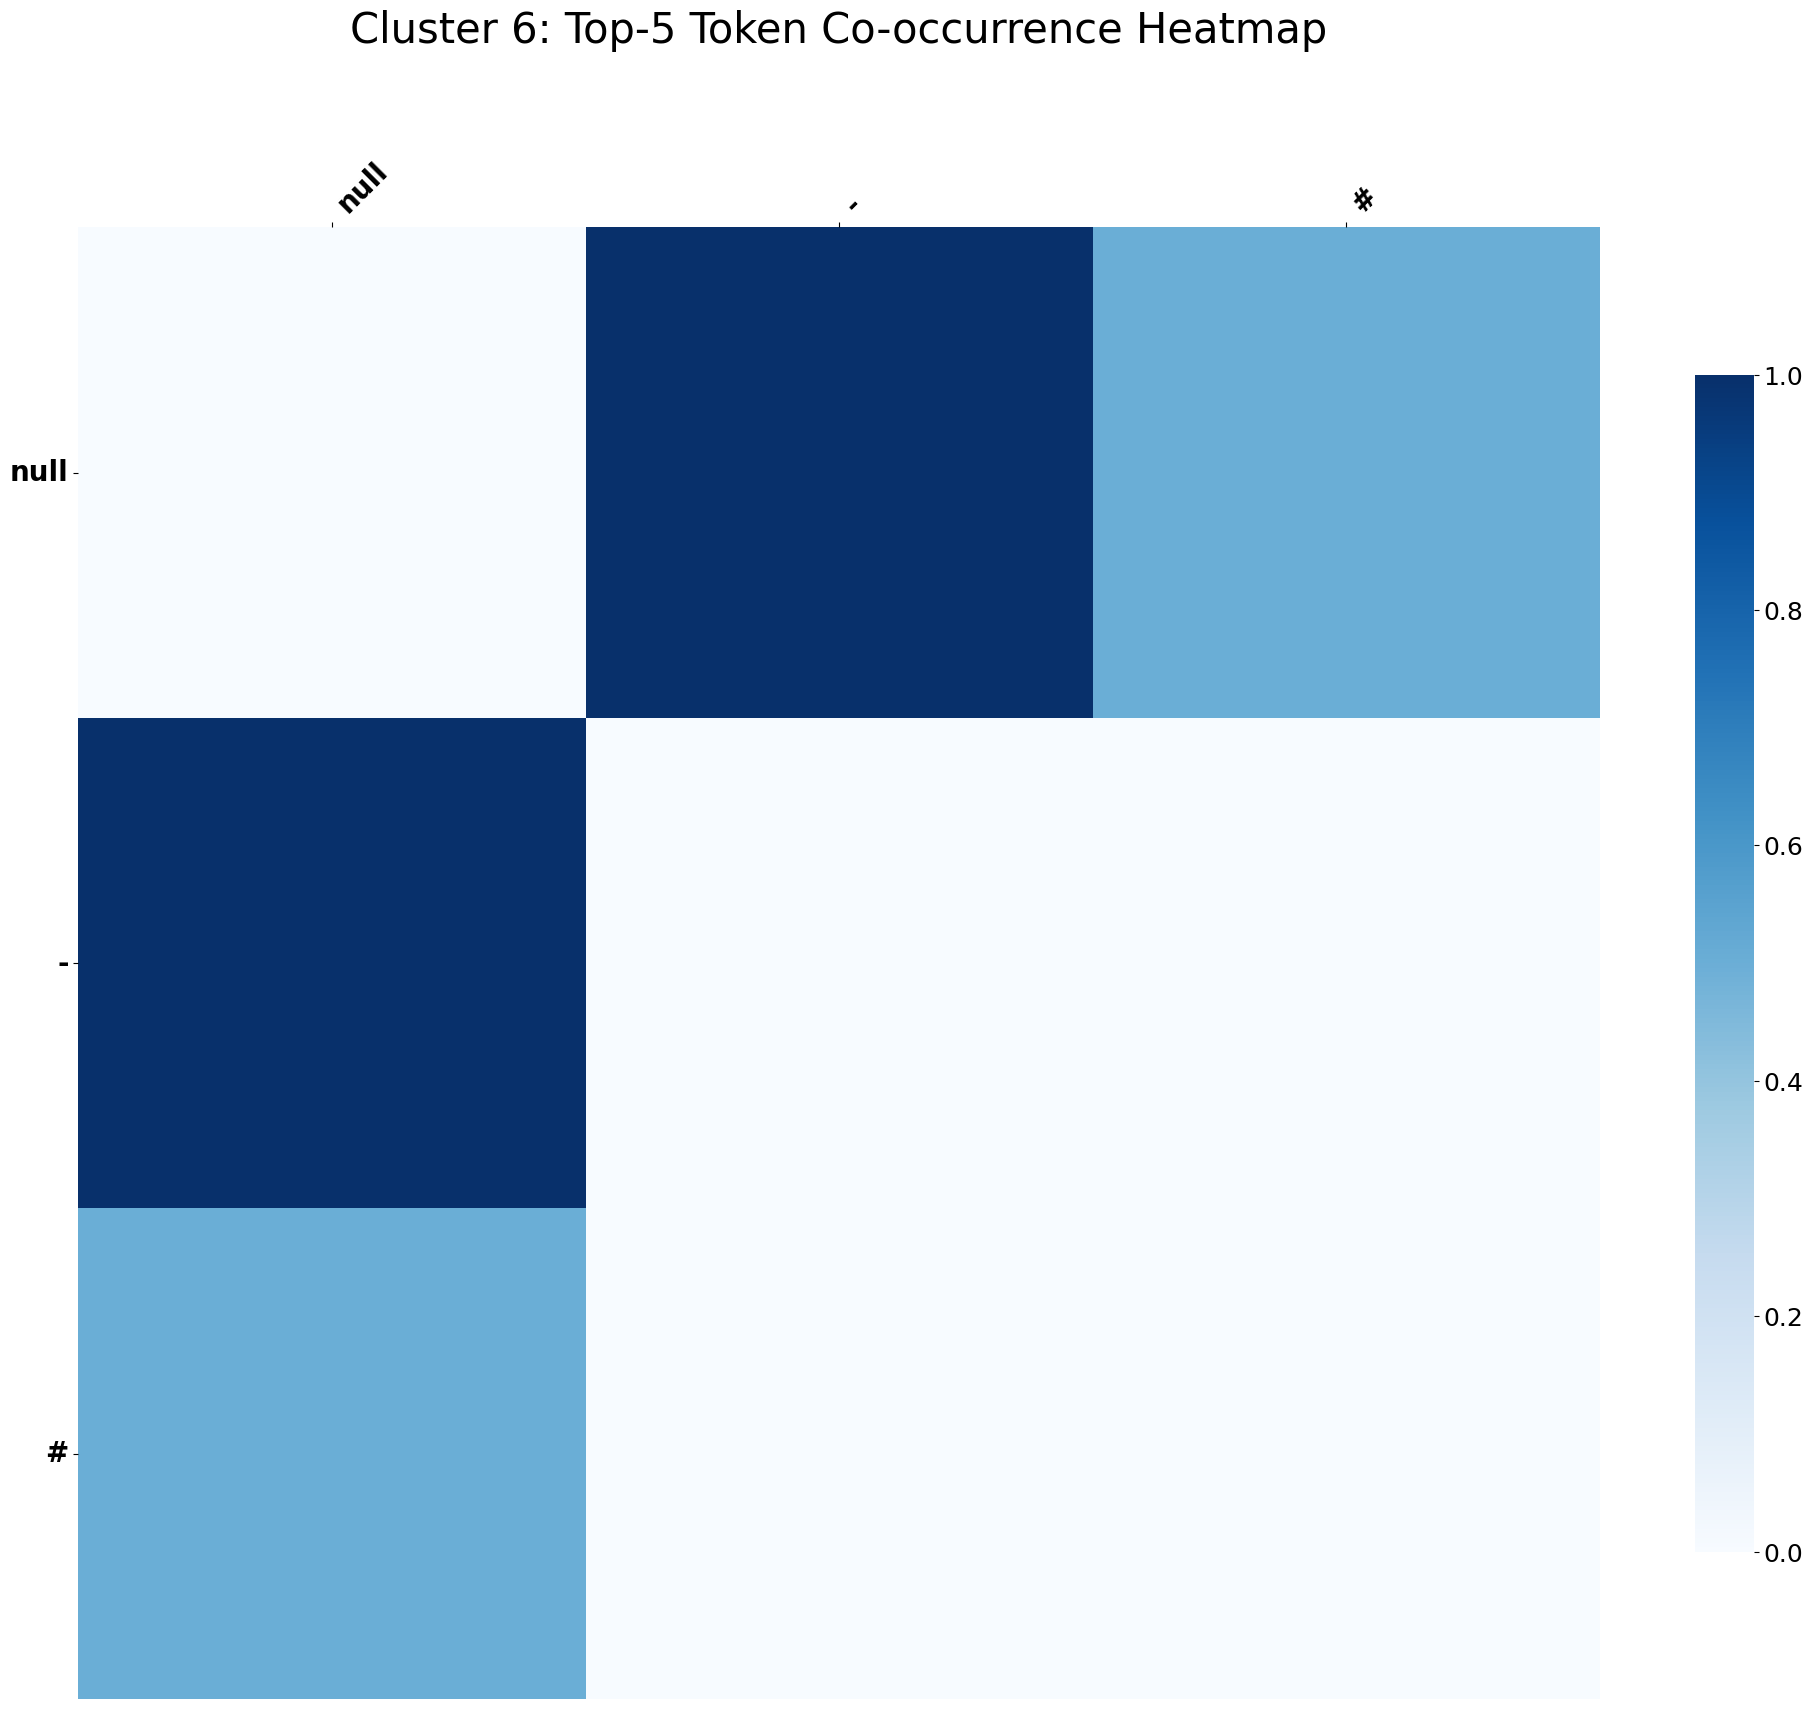

Discovered patterns for cluster 6 (Top-5): [['#', '-', 'null']]

--- Co-occurrence Analysis for Top 10 Keywords ---


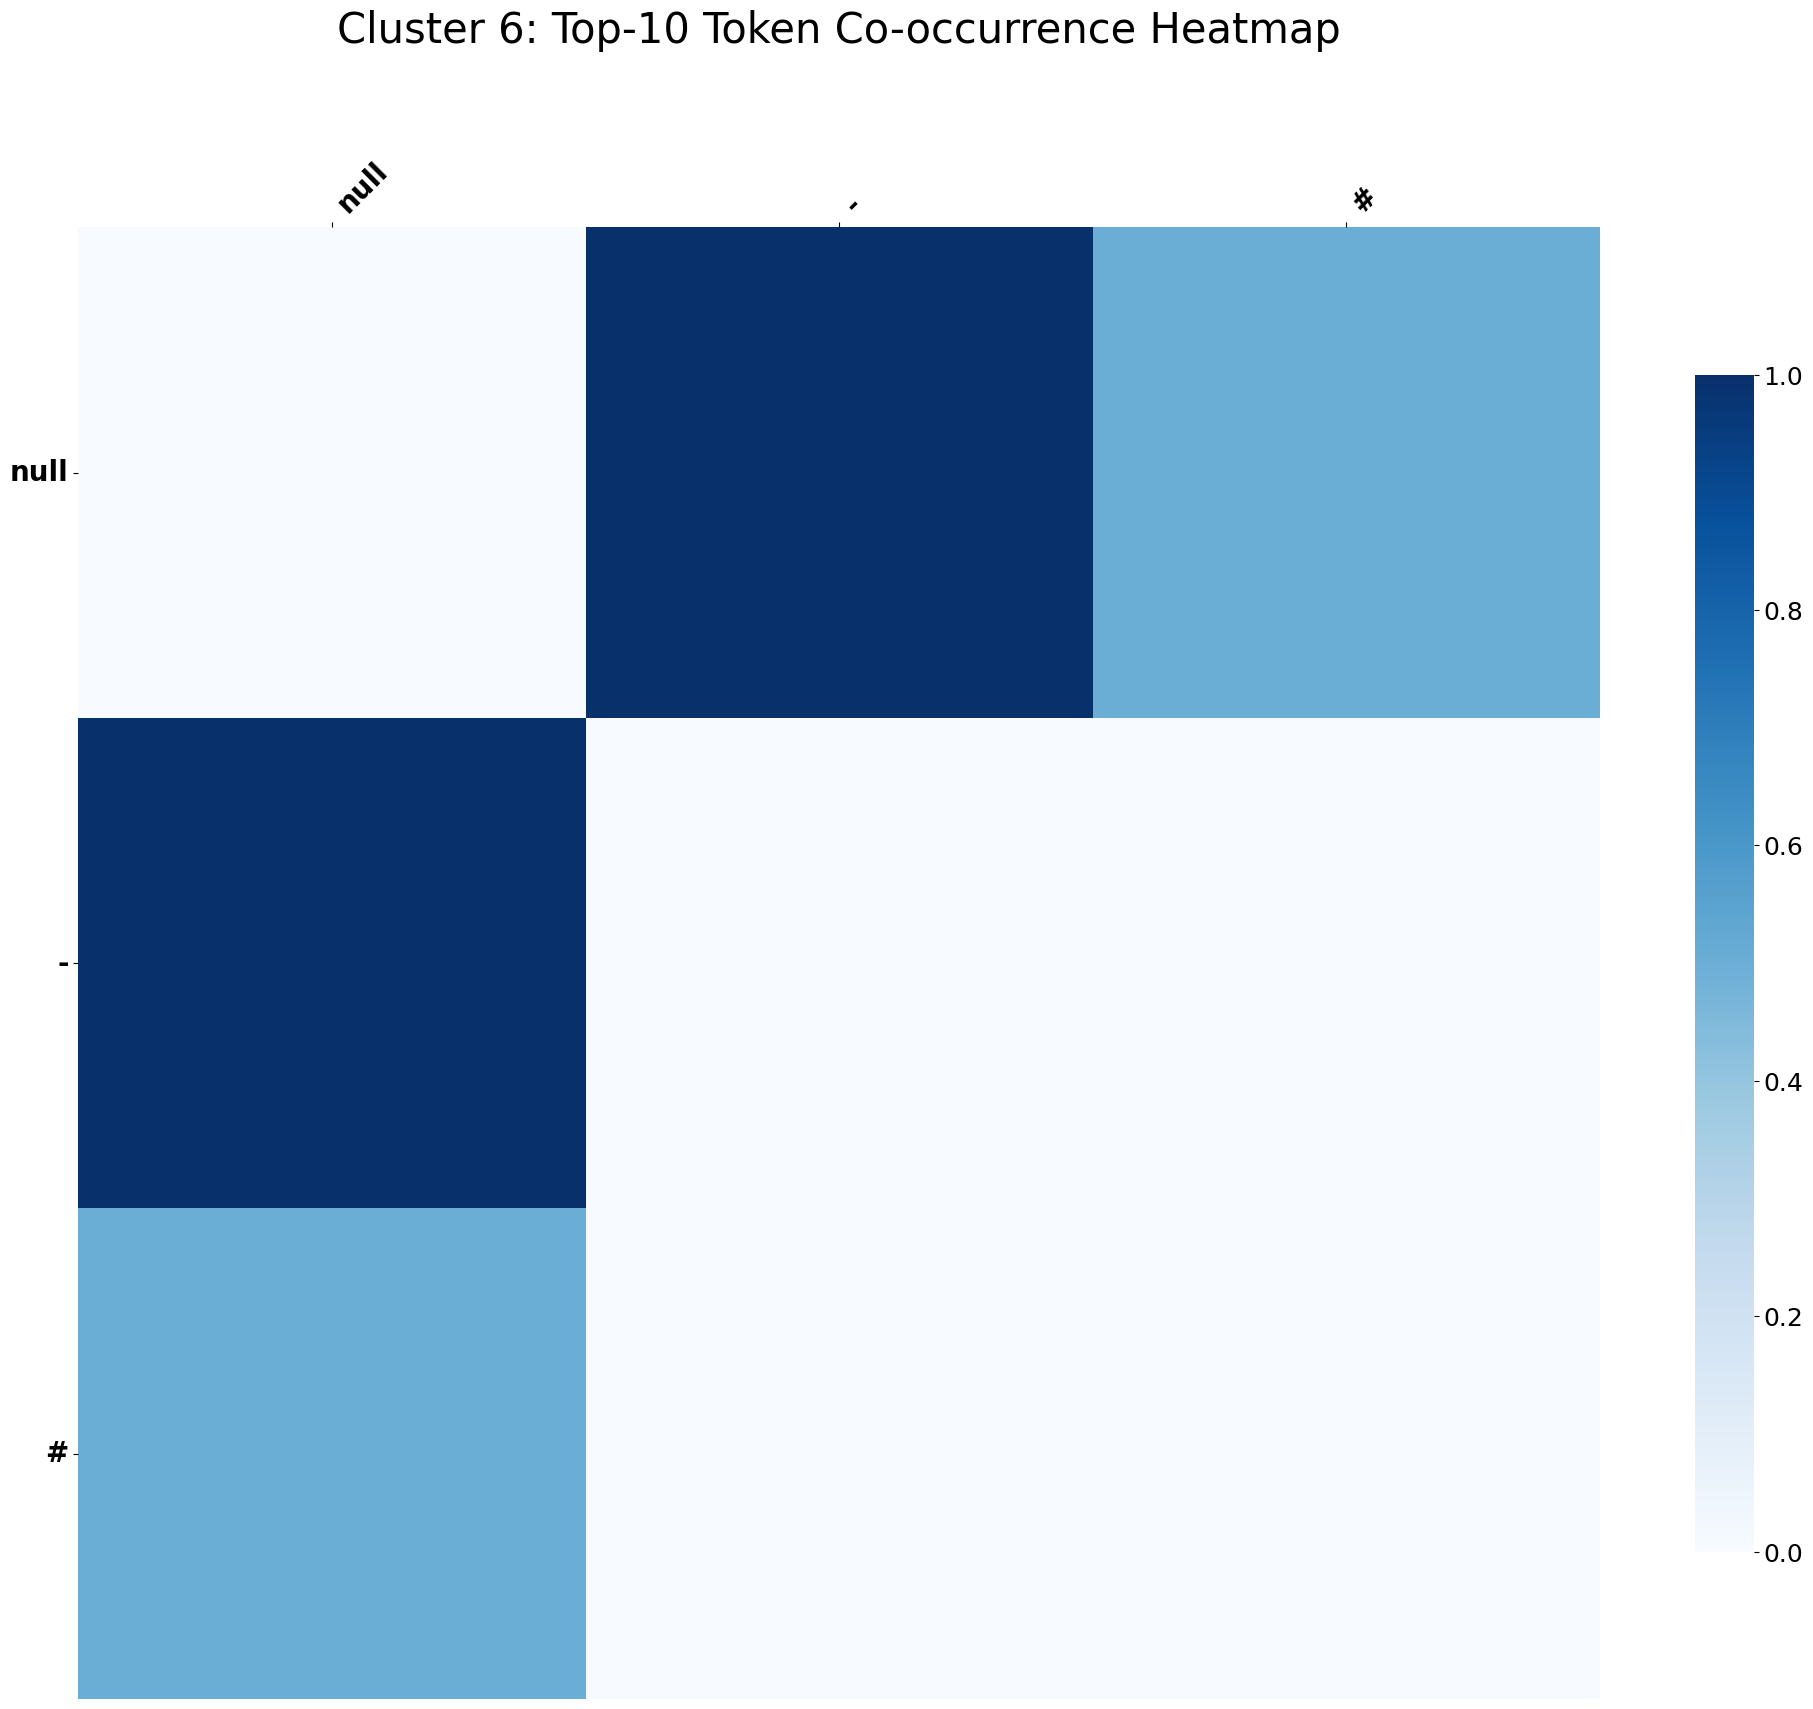

Discovered patterns for cluster 6 (Top-10): [['#', '-', 'null']]

--- Co-occurrence Analysis for Top 20 Keywords ---


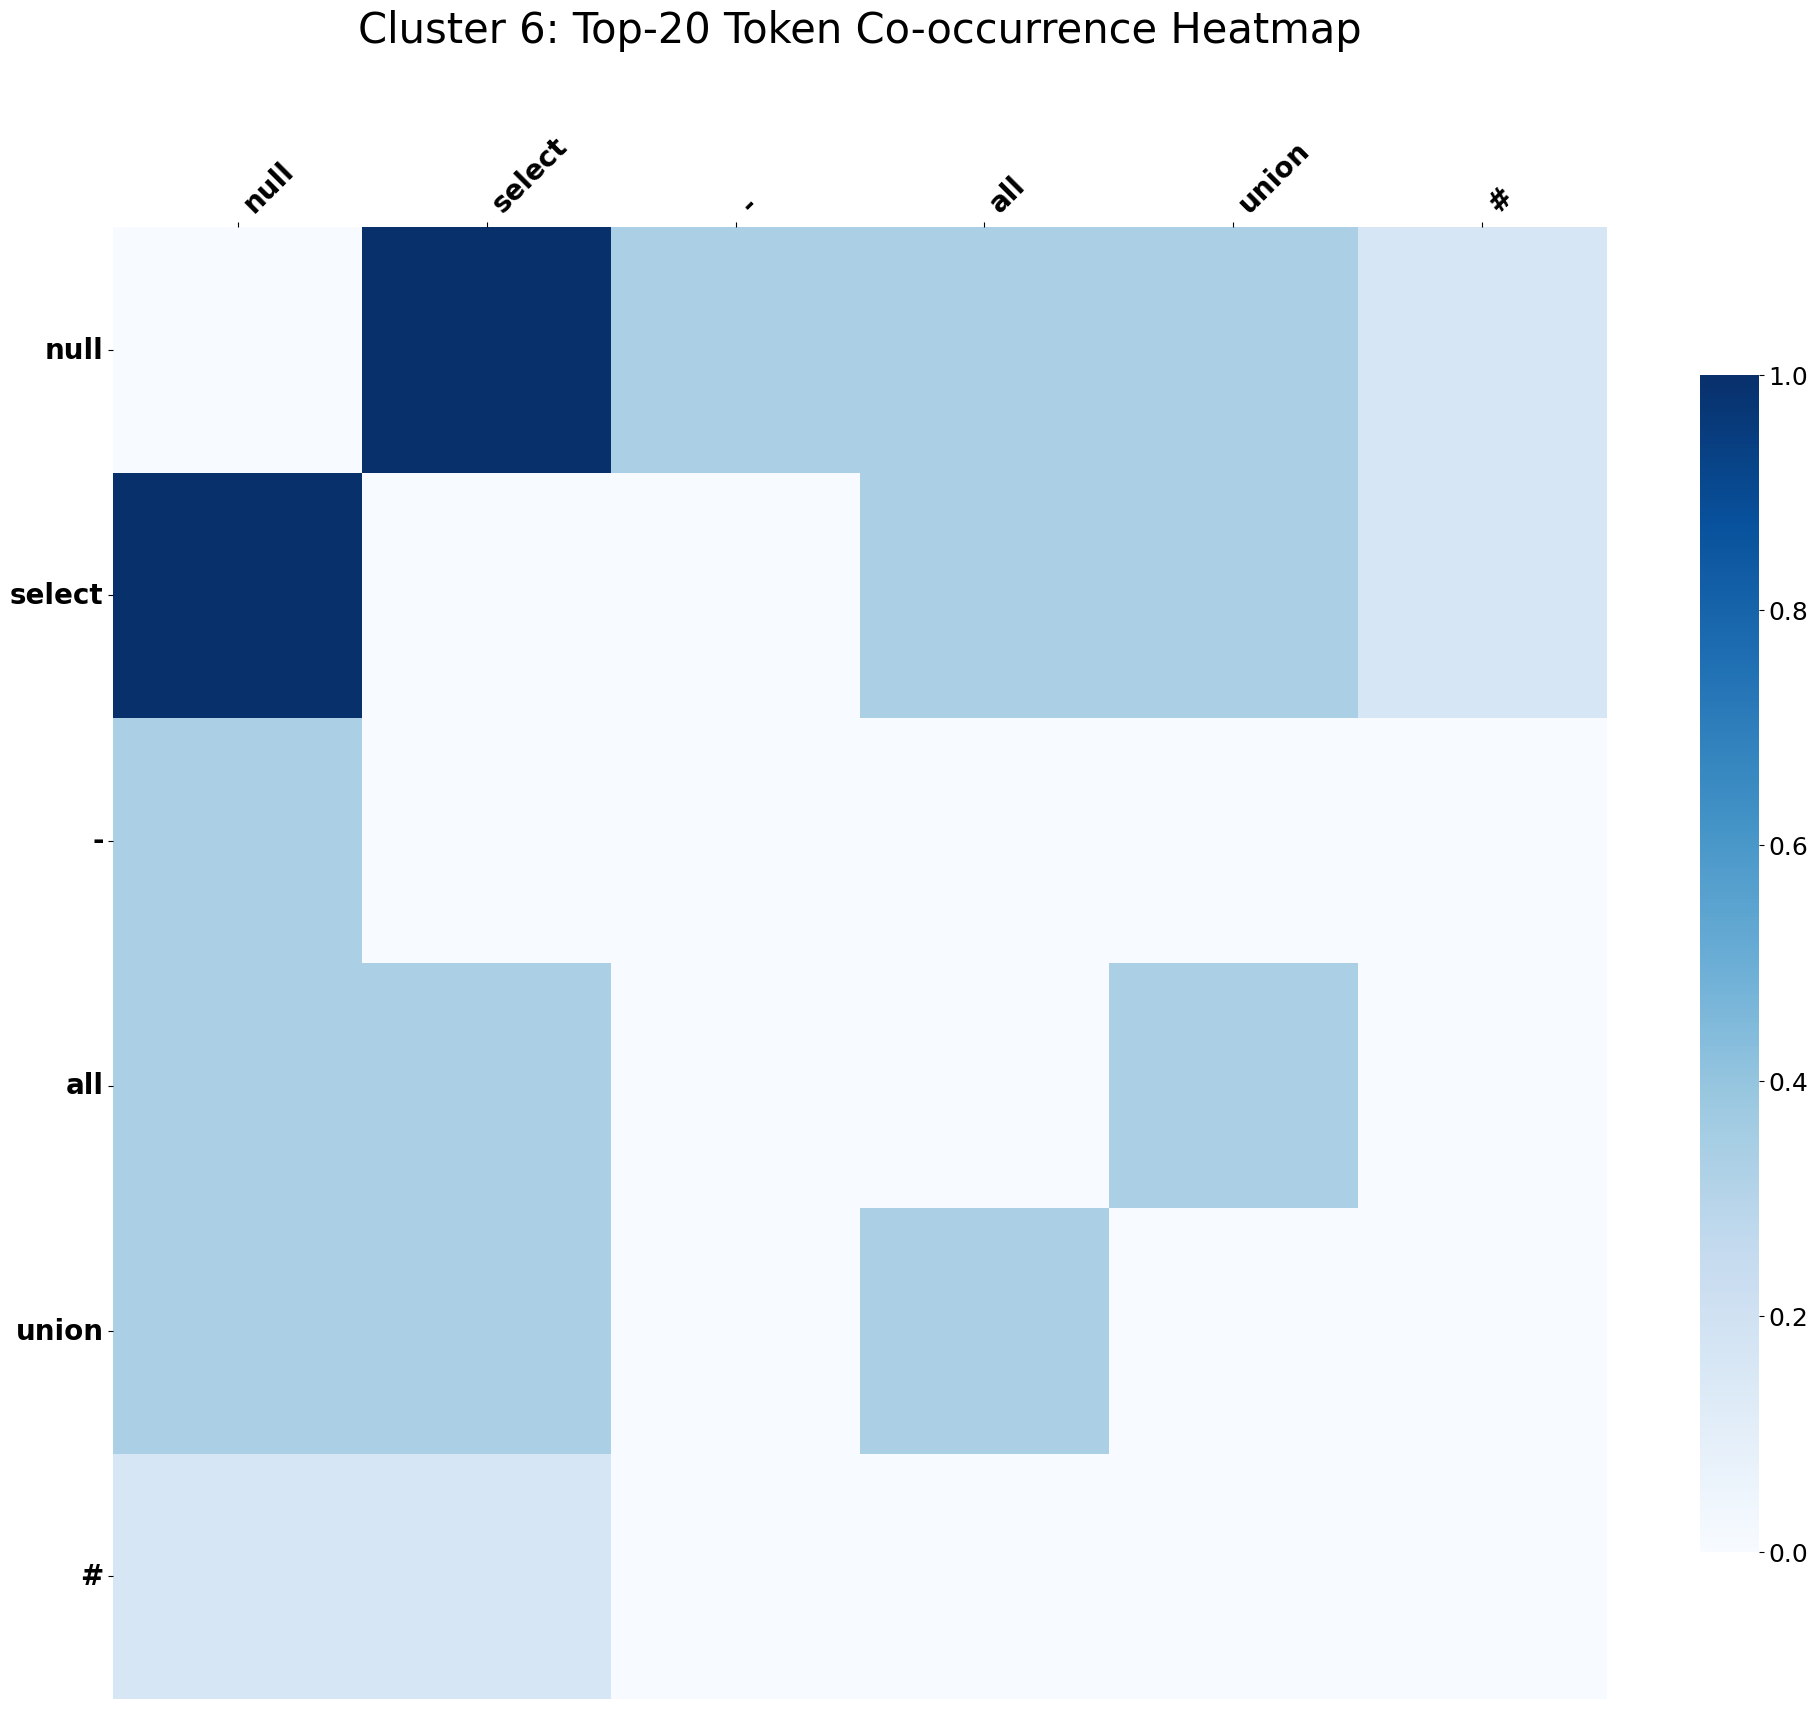

Discovered patterns for cluster 6 (Top-20): [['null', 'select']]

Processing Cluster 7...
Members in cluster 7: 15
 Top 10 words by TFIDF: ['char', 'chr', 'select', 'quiz', 'where', 'mod', 'or', 'substring', 'repeat', 'regexp']
shape of candidate sets: 15

--- Co-occurrence Analysis for Top 5 Keywords ---


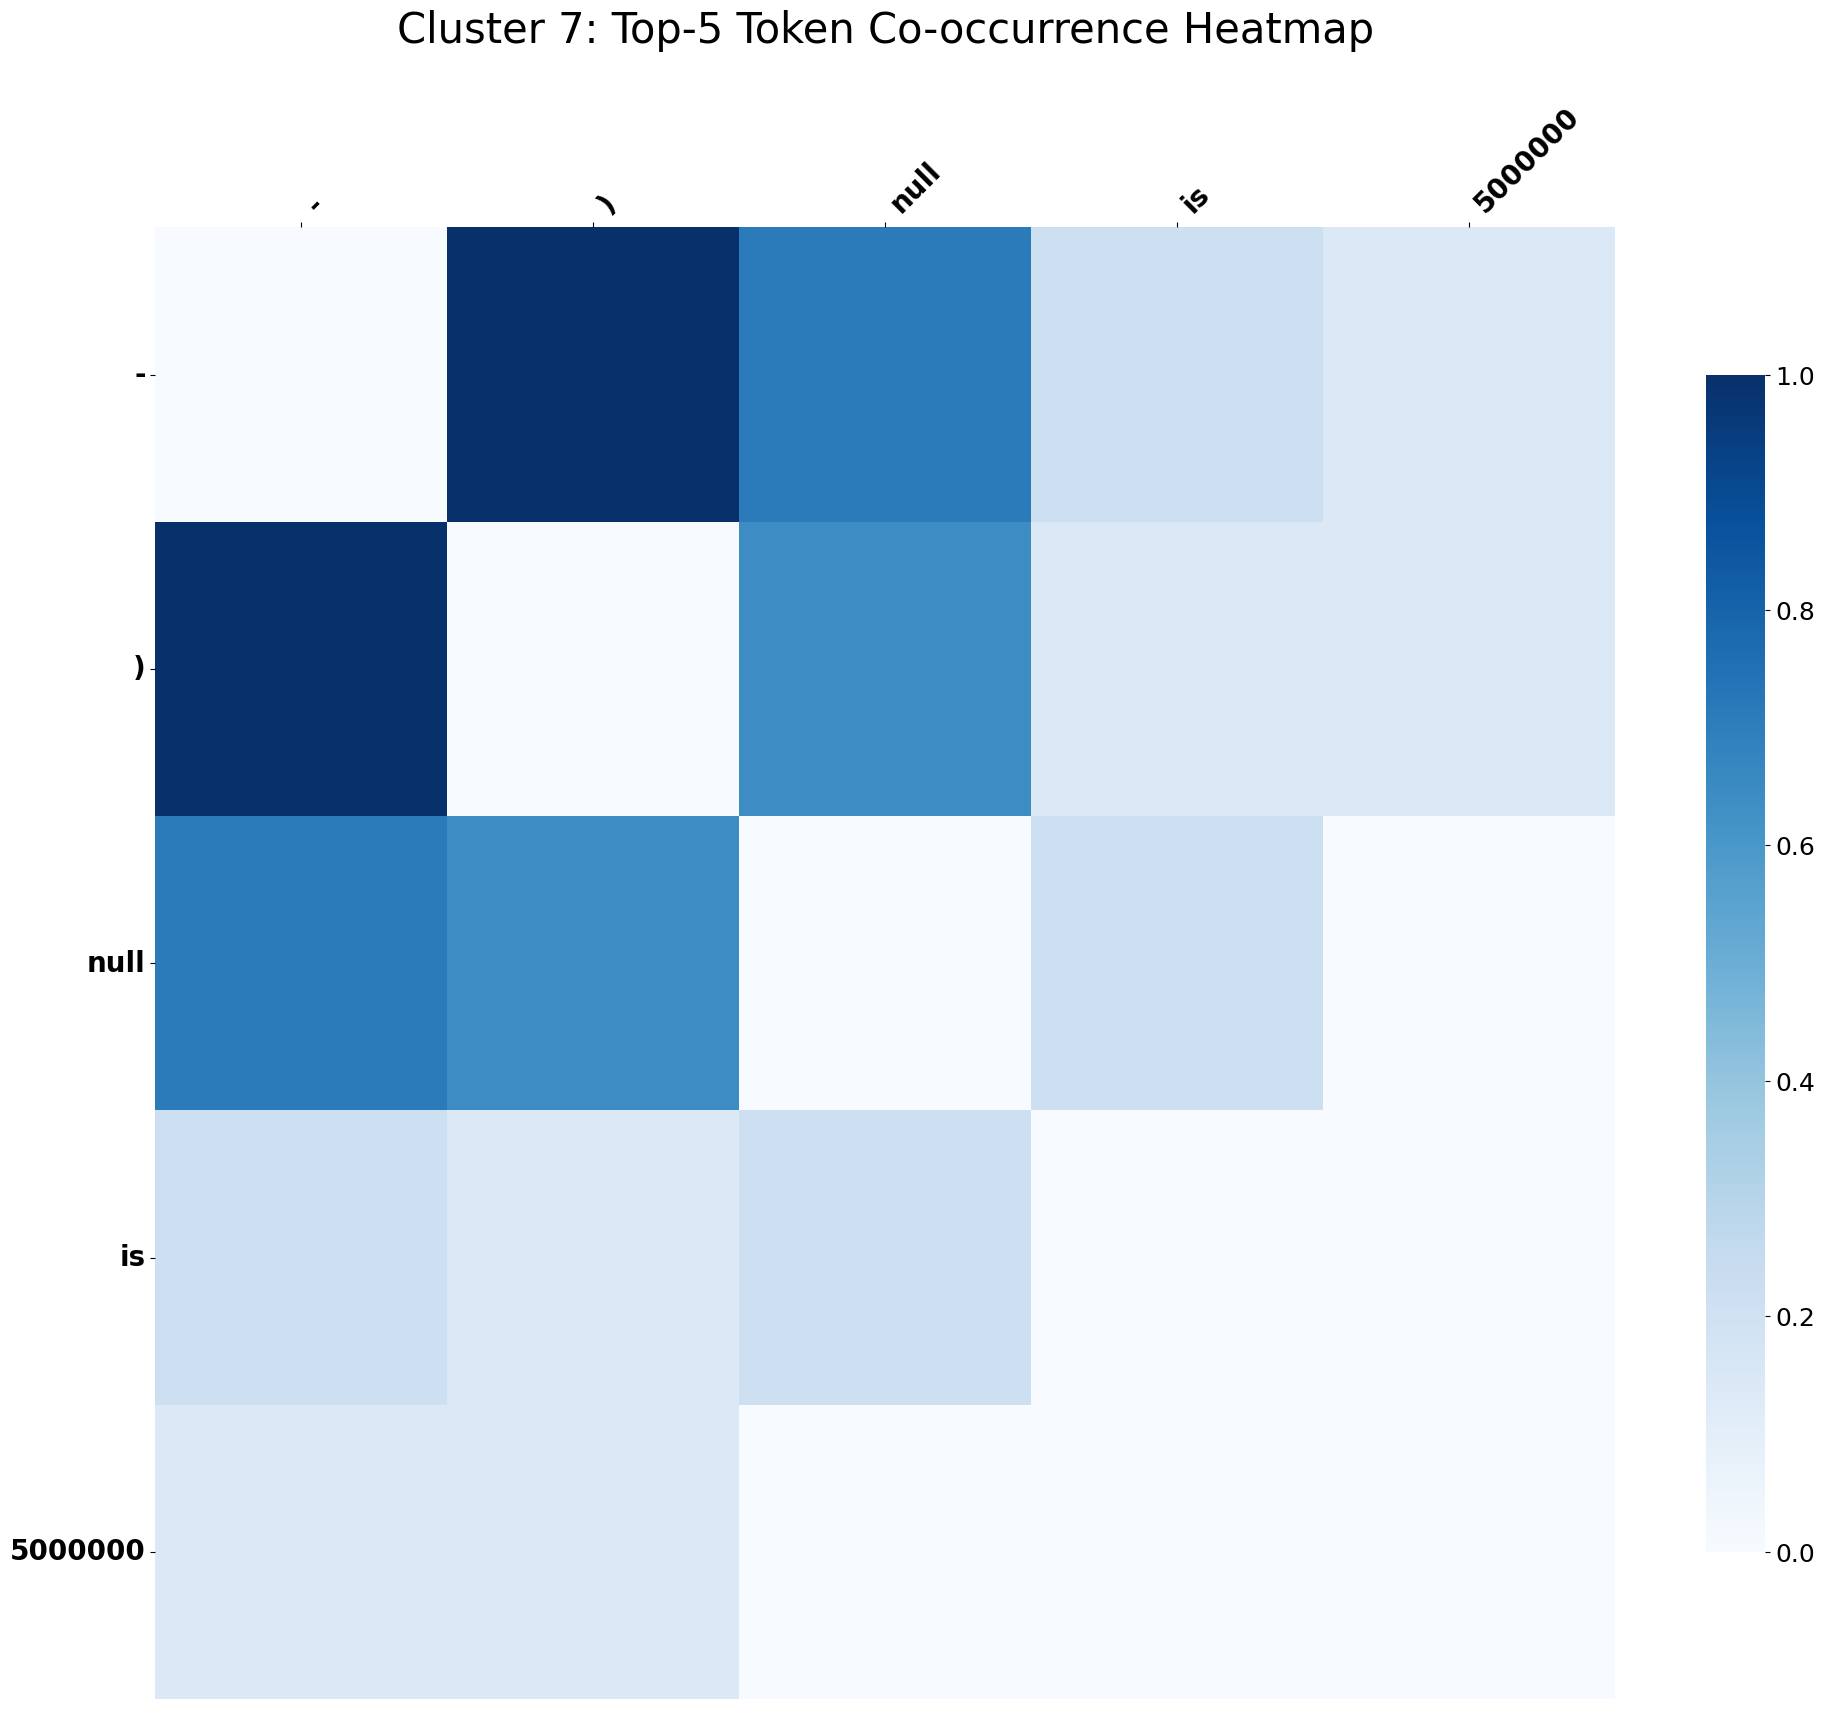

Discovered patterns for cluster 7 (Top-5): [[')', '-', 'null']]

--- Co-occurrence Analysis for Top 10 Keywords ---


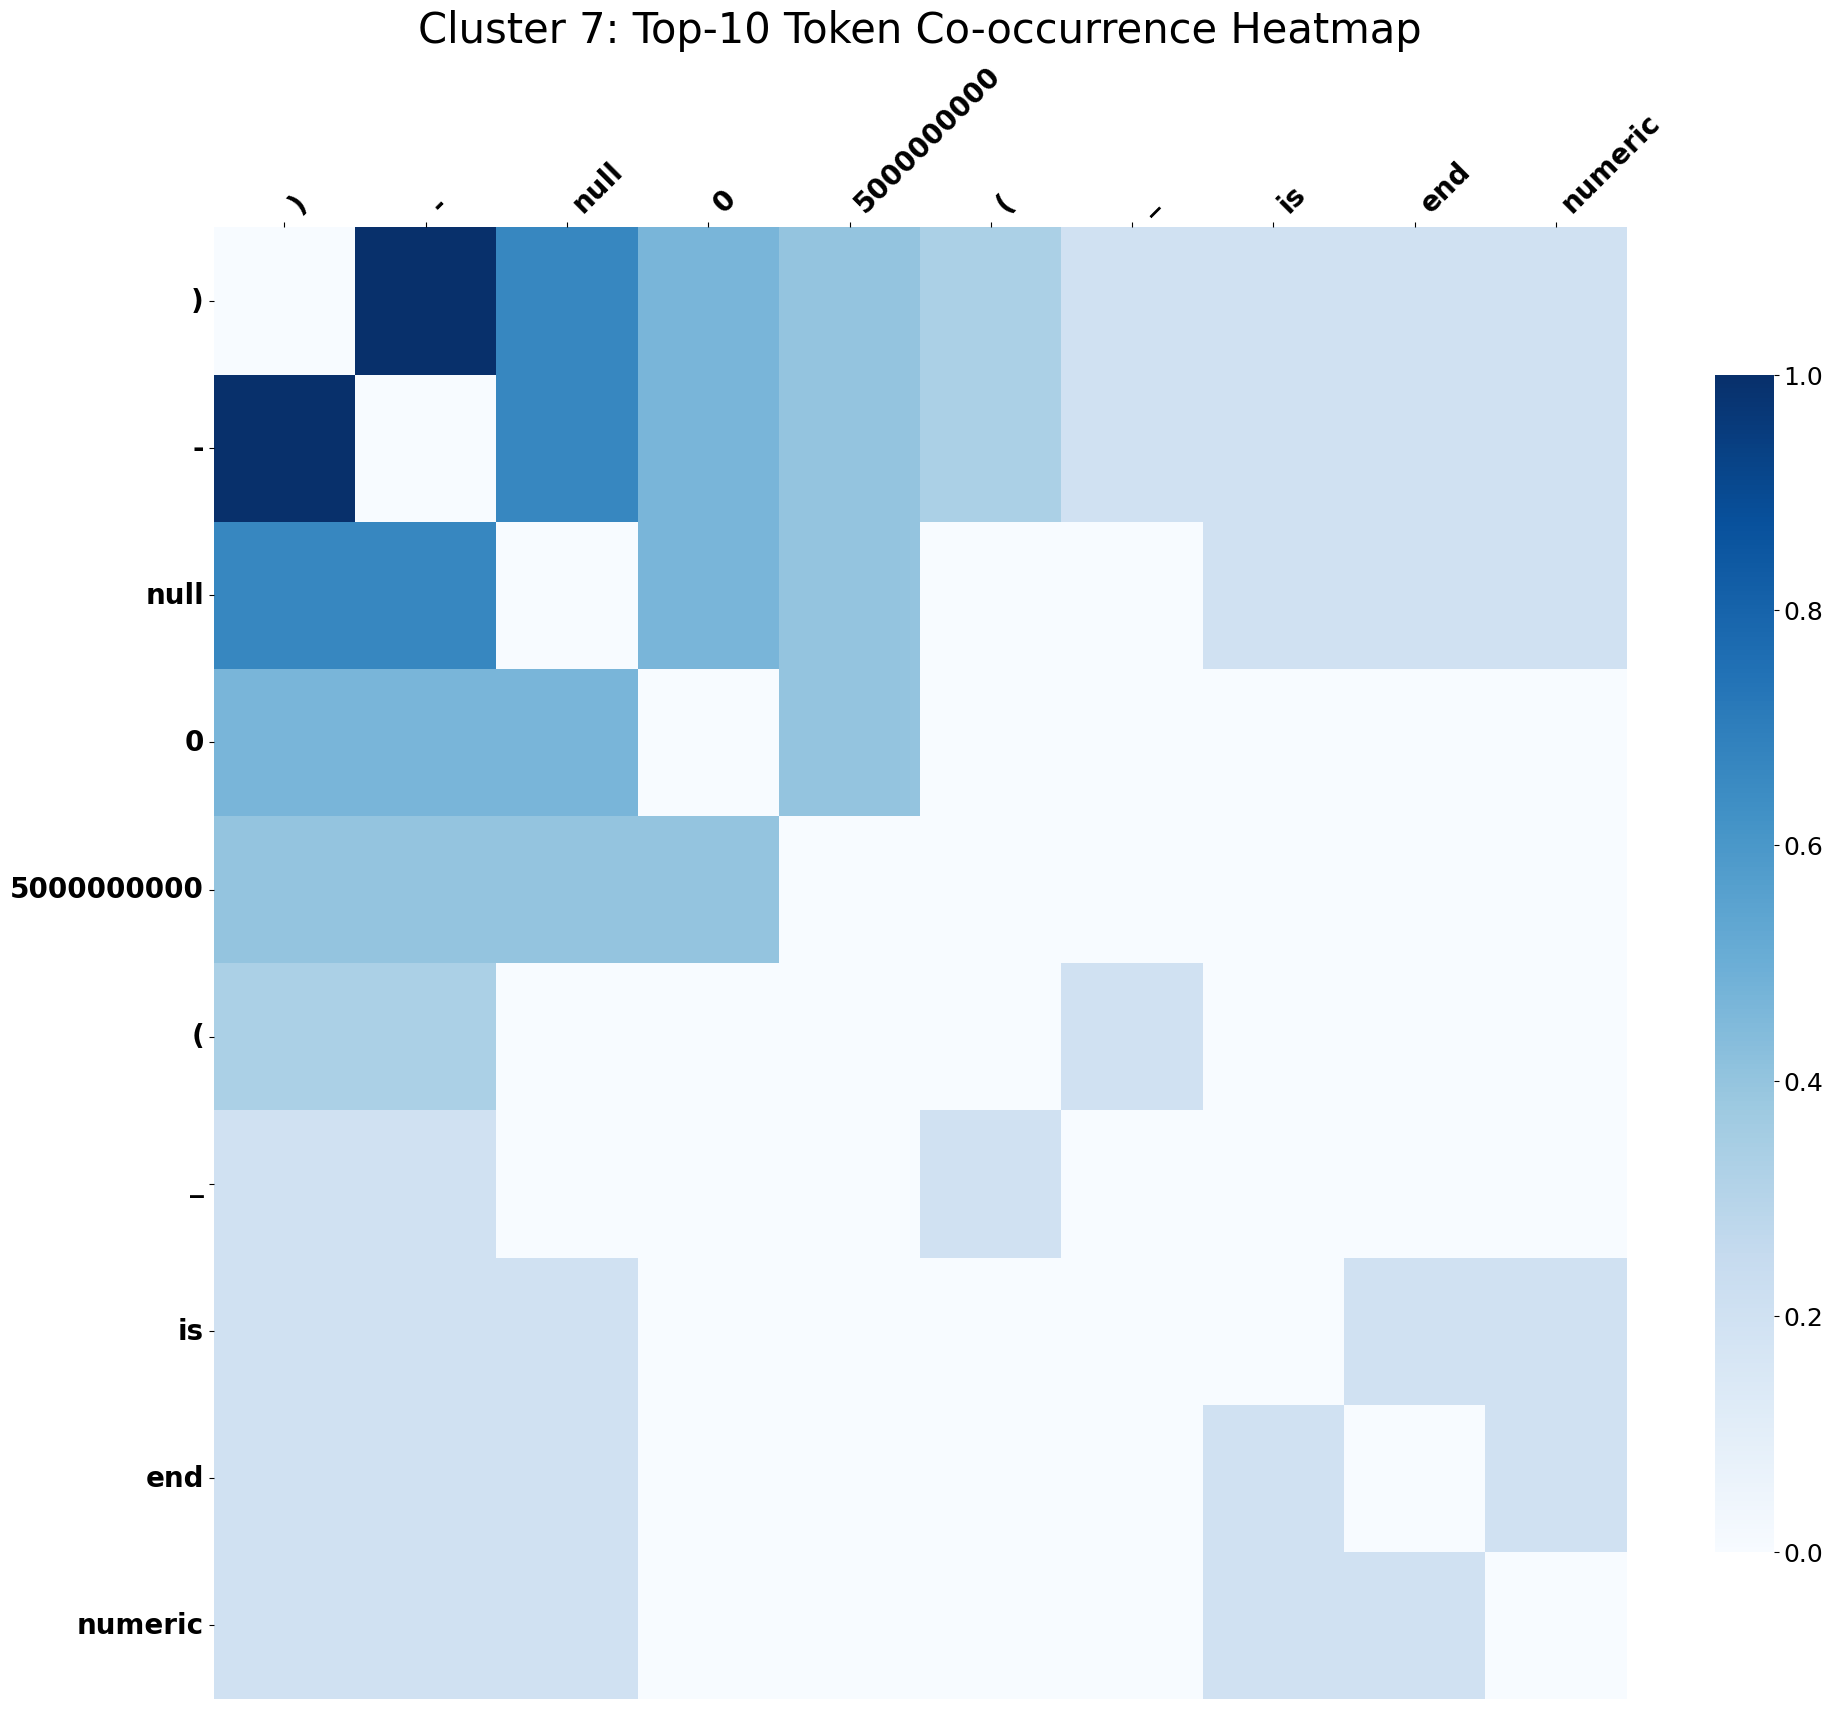

Discovered patterns for cluster 7 (Top-10): [[')', '-', '0', '5000000000', 'null']]

--- Co-occurrence Analysis for Top 20 Keywords ---


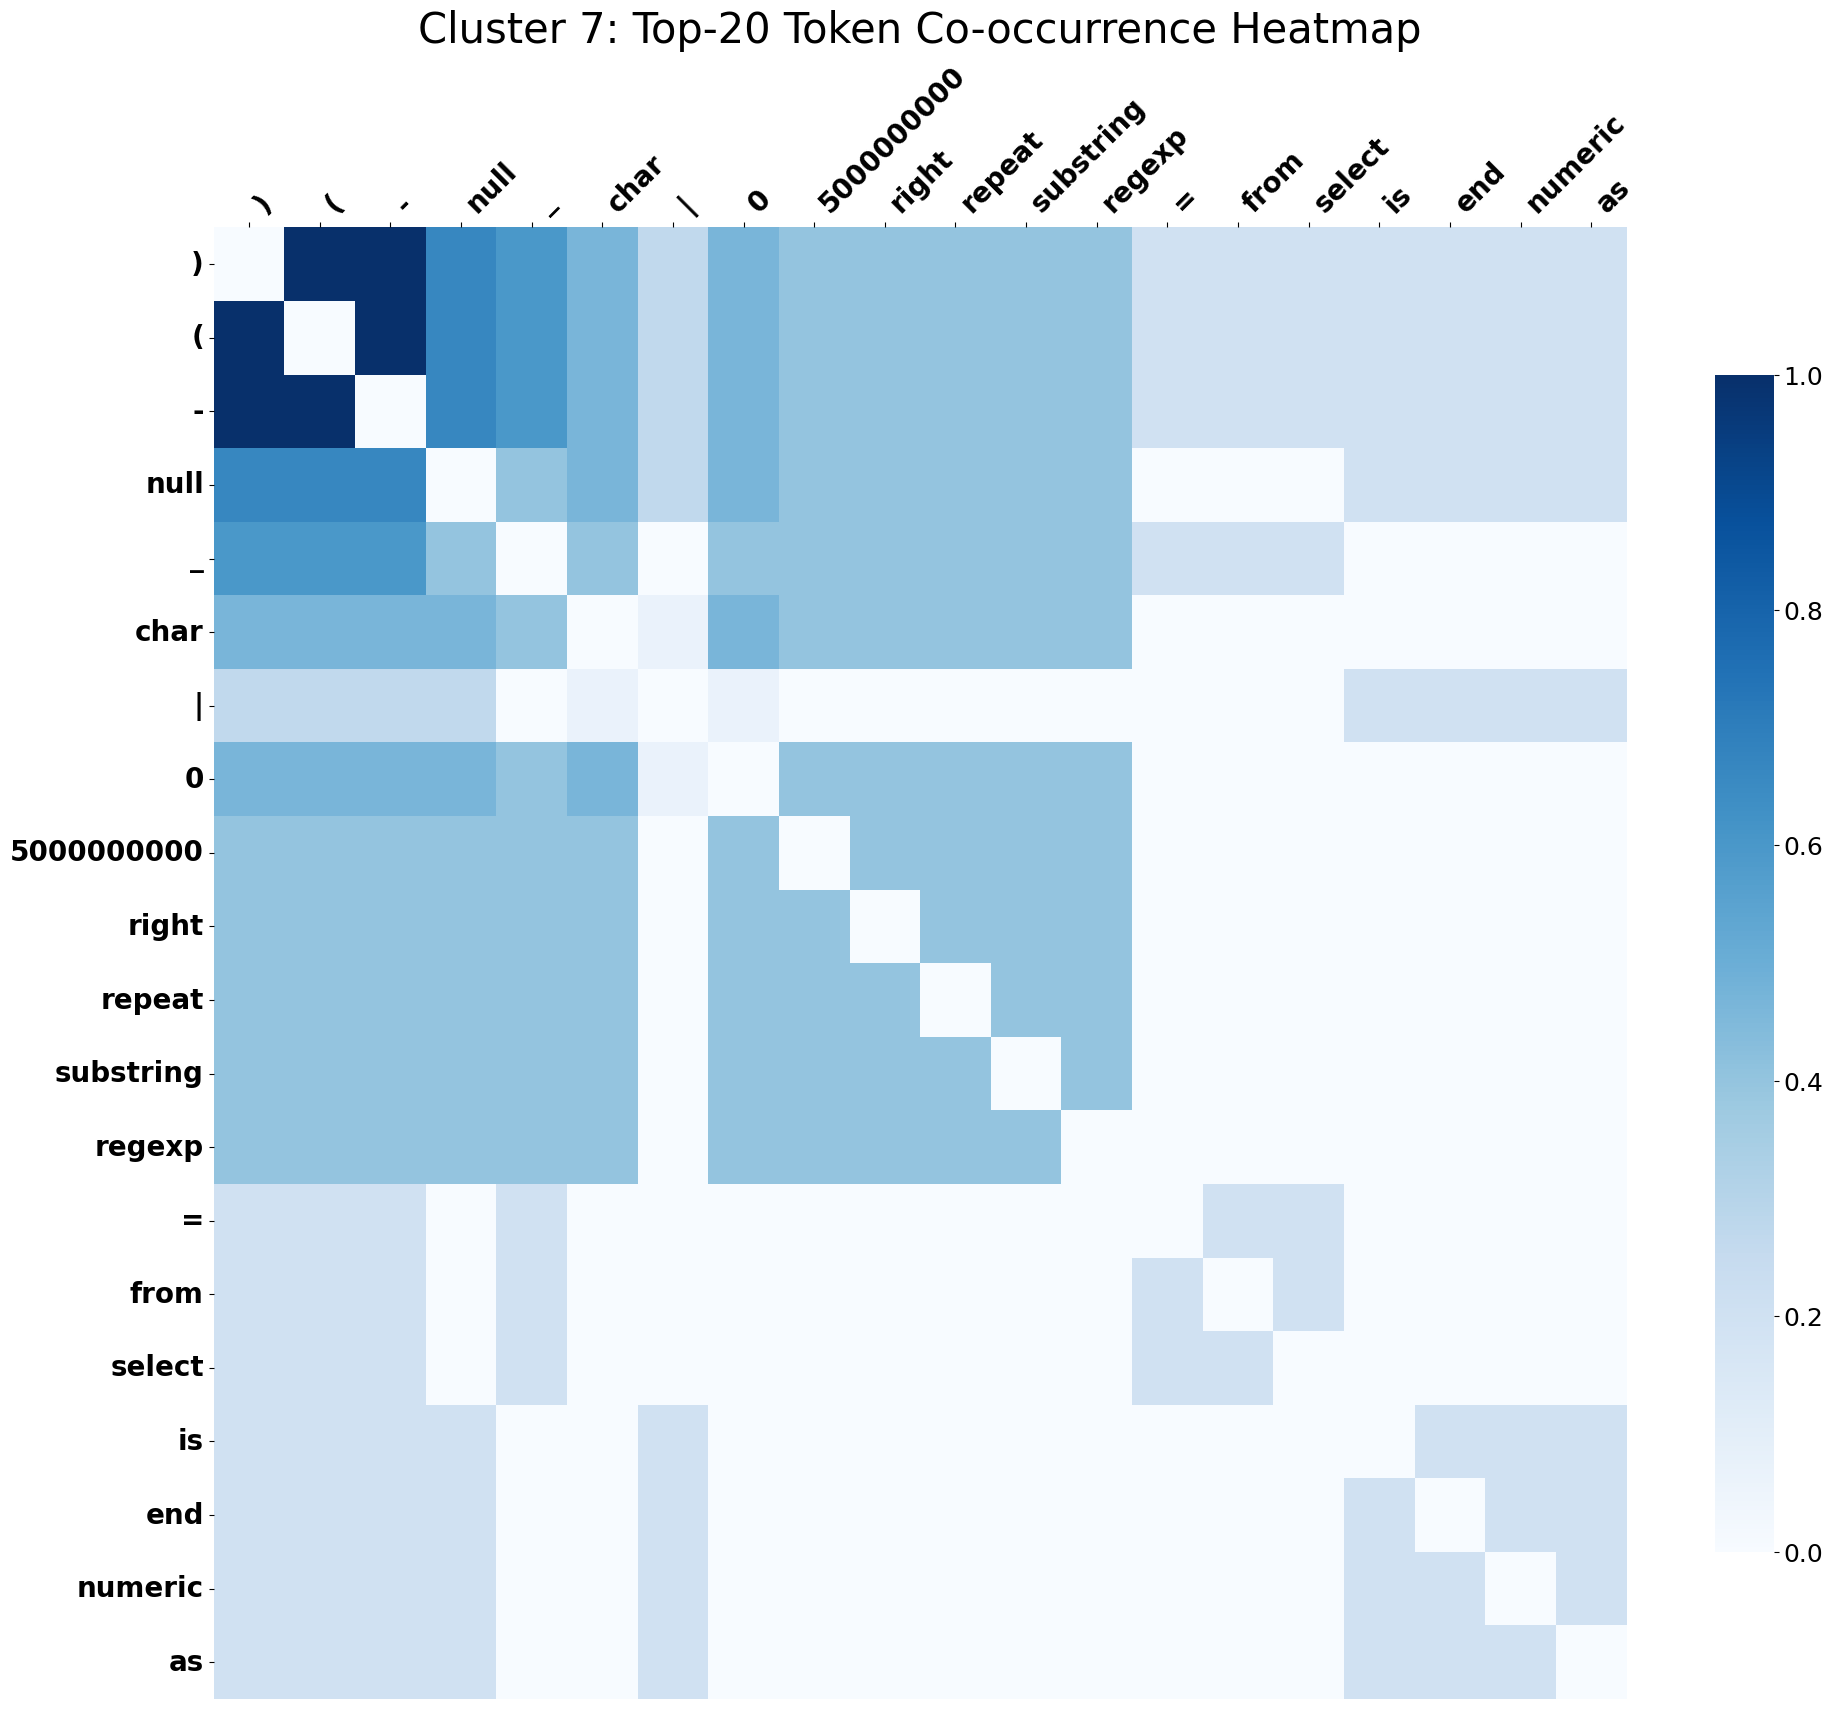

Discovered patterns for cluster 7 (Top-20): [['(', ')', '-', '0', '5000000000', '_', 'char', 'null', 'regexp', 'repeat', 'right', 'substring']]

Processing Cluster 8...
Members in cluster 8: 26
 Top 10 words by TFIDF: ['select', '1535', 'from', '6874', 'question', 'pluginfile', '8785', 'answer', 'concat', '113836']
shape of candidate sets: 26

--- Co-occurrence Analysis for Top 5 Keywords ---


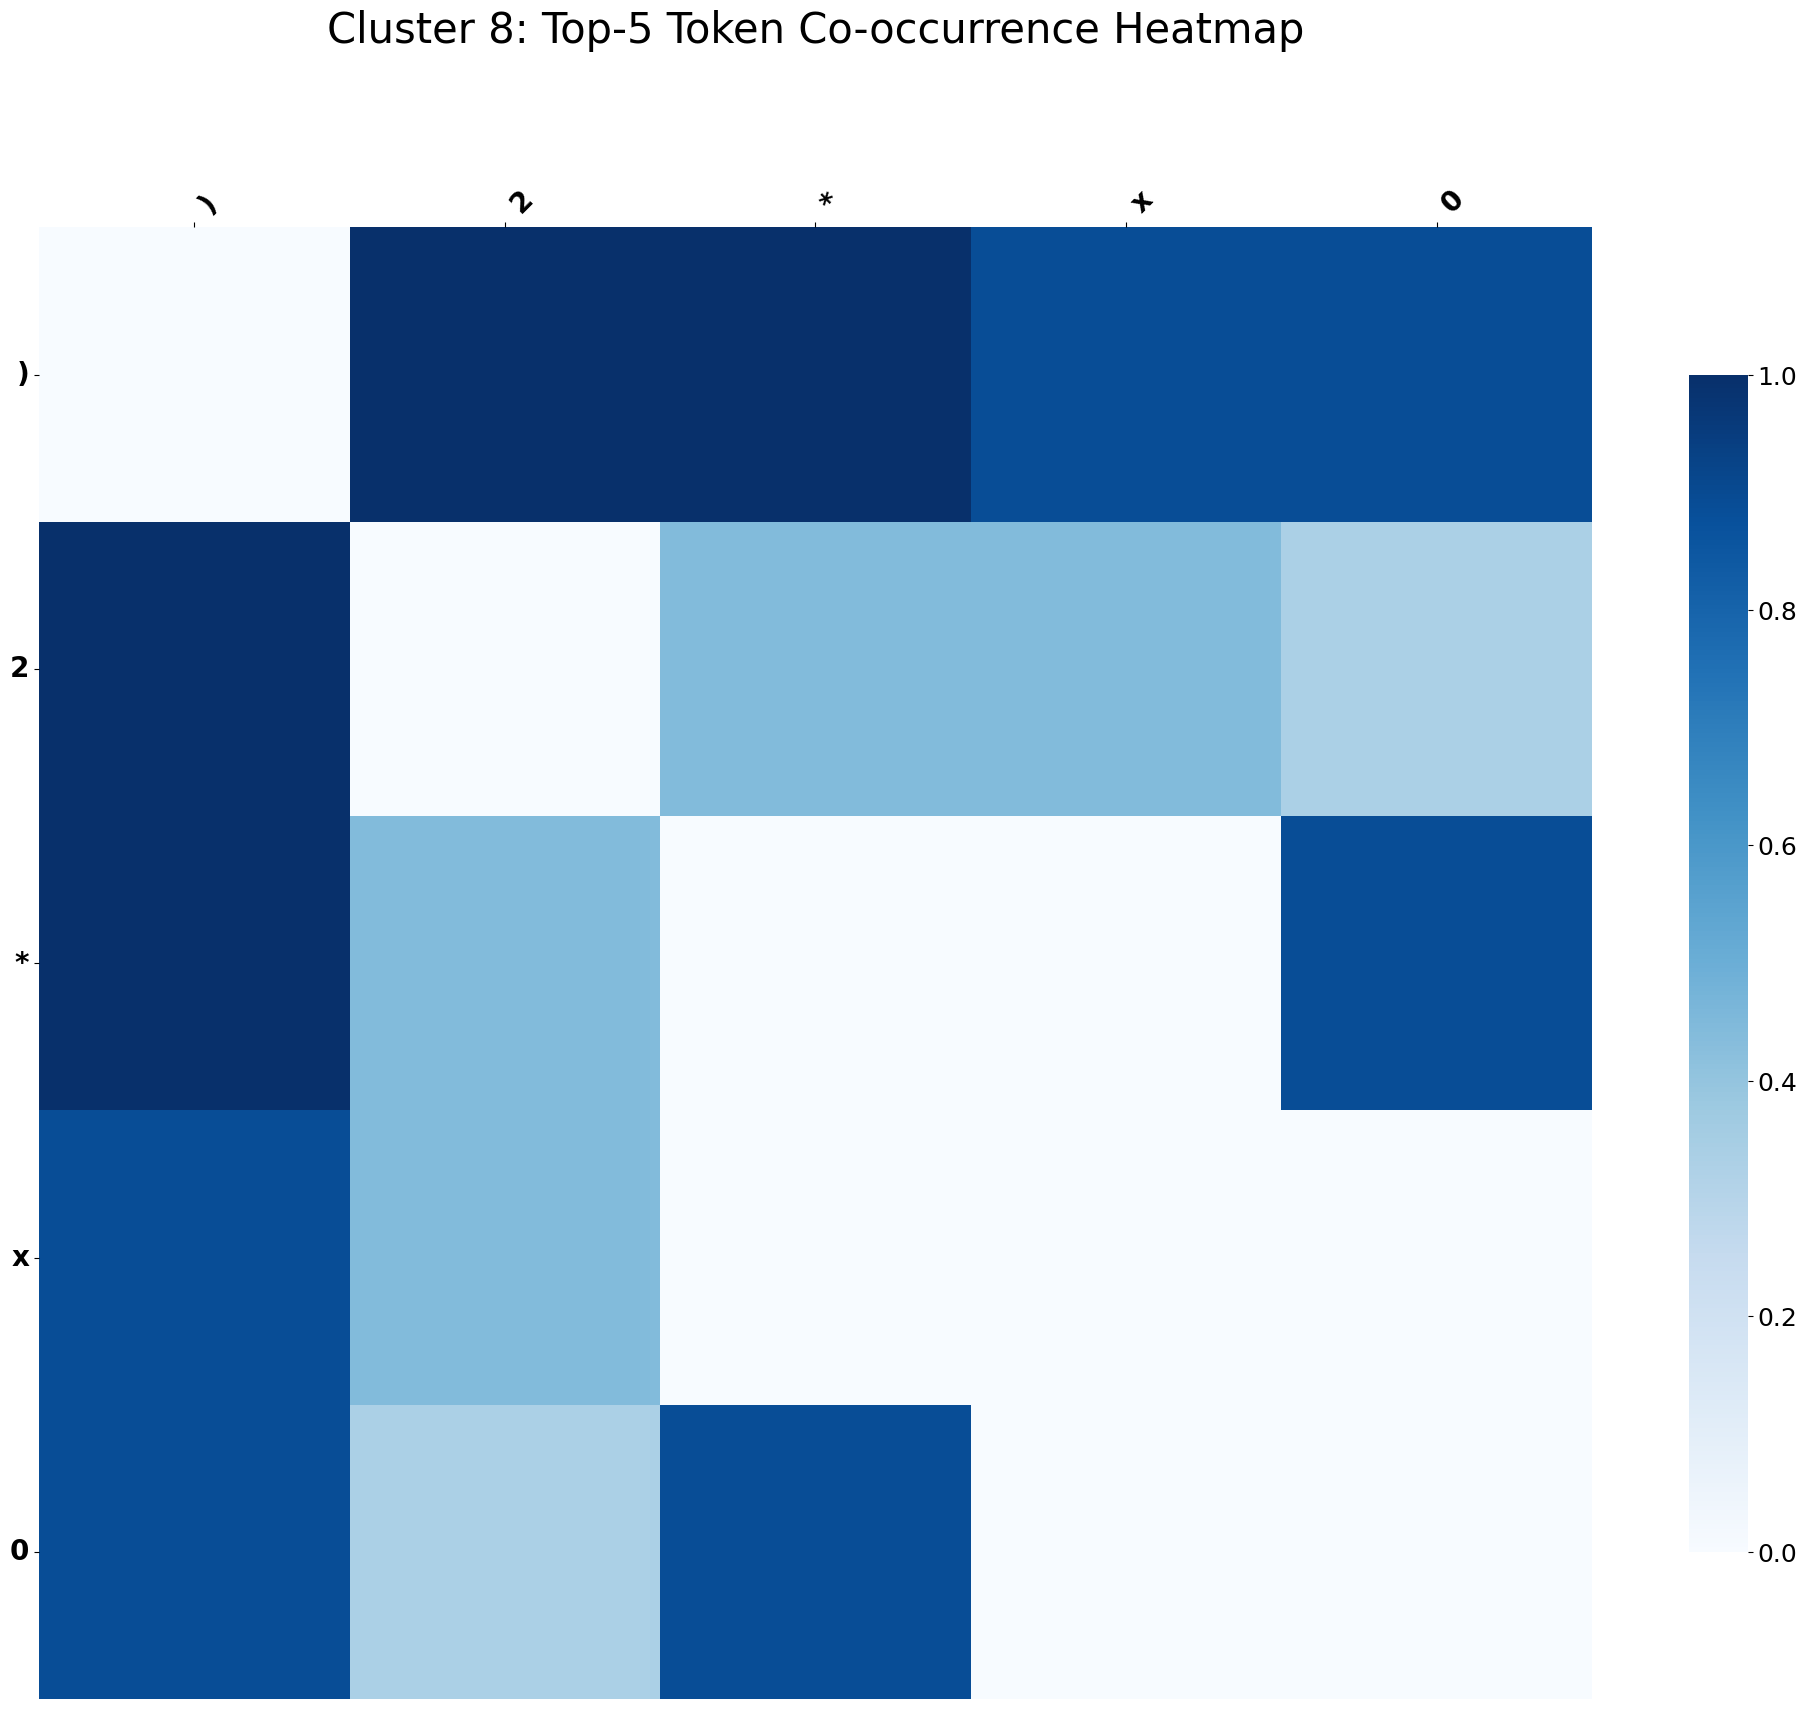

Discovered patterns for cluster 8 (Top-5): [[')', '*', '0', '2', 'x']]

--- Co-occurrence Analysis for Top 10 Keywords ---


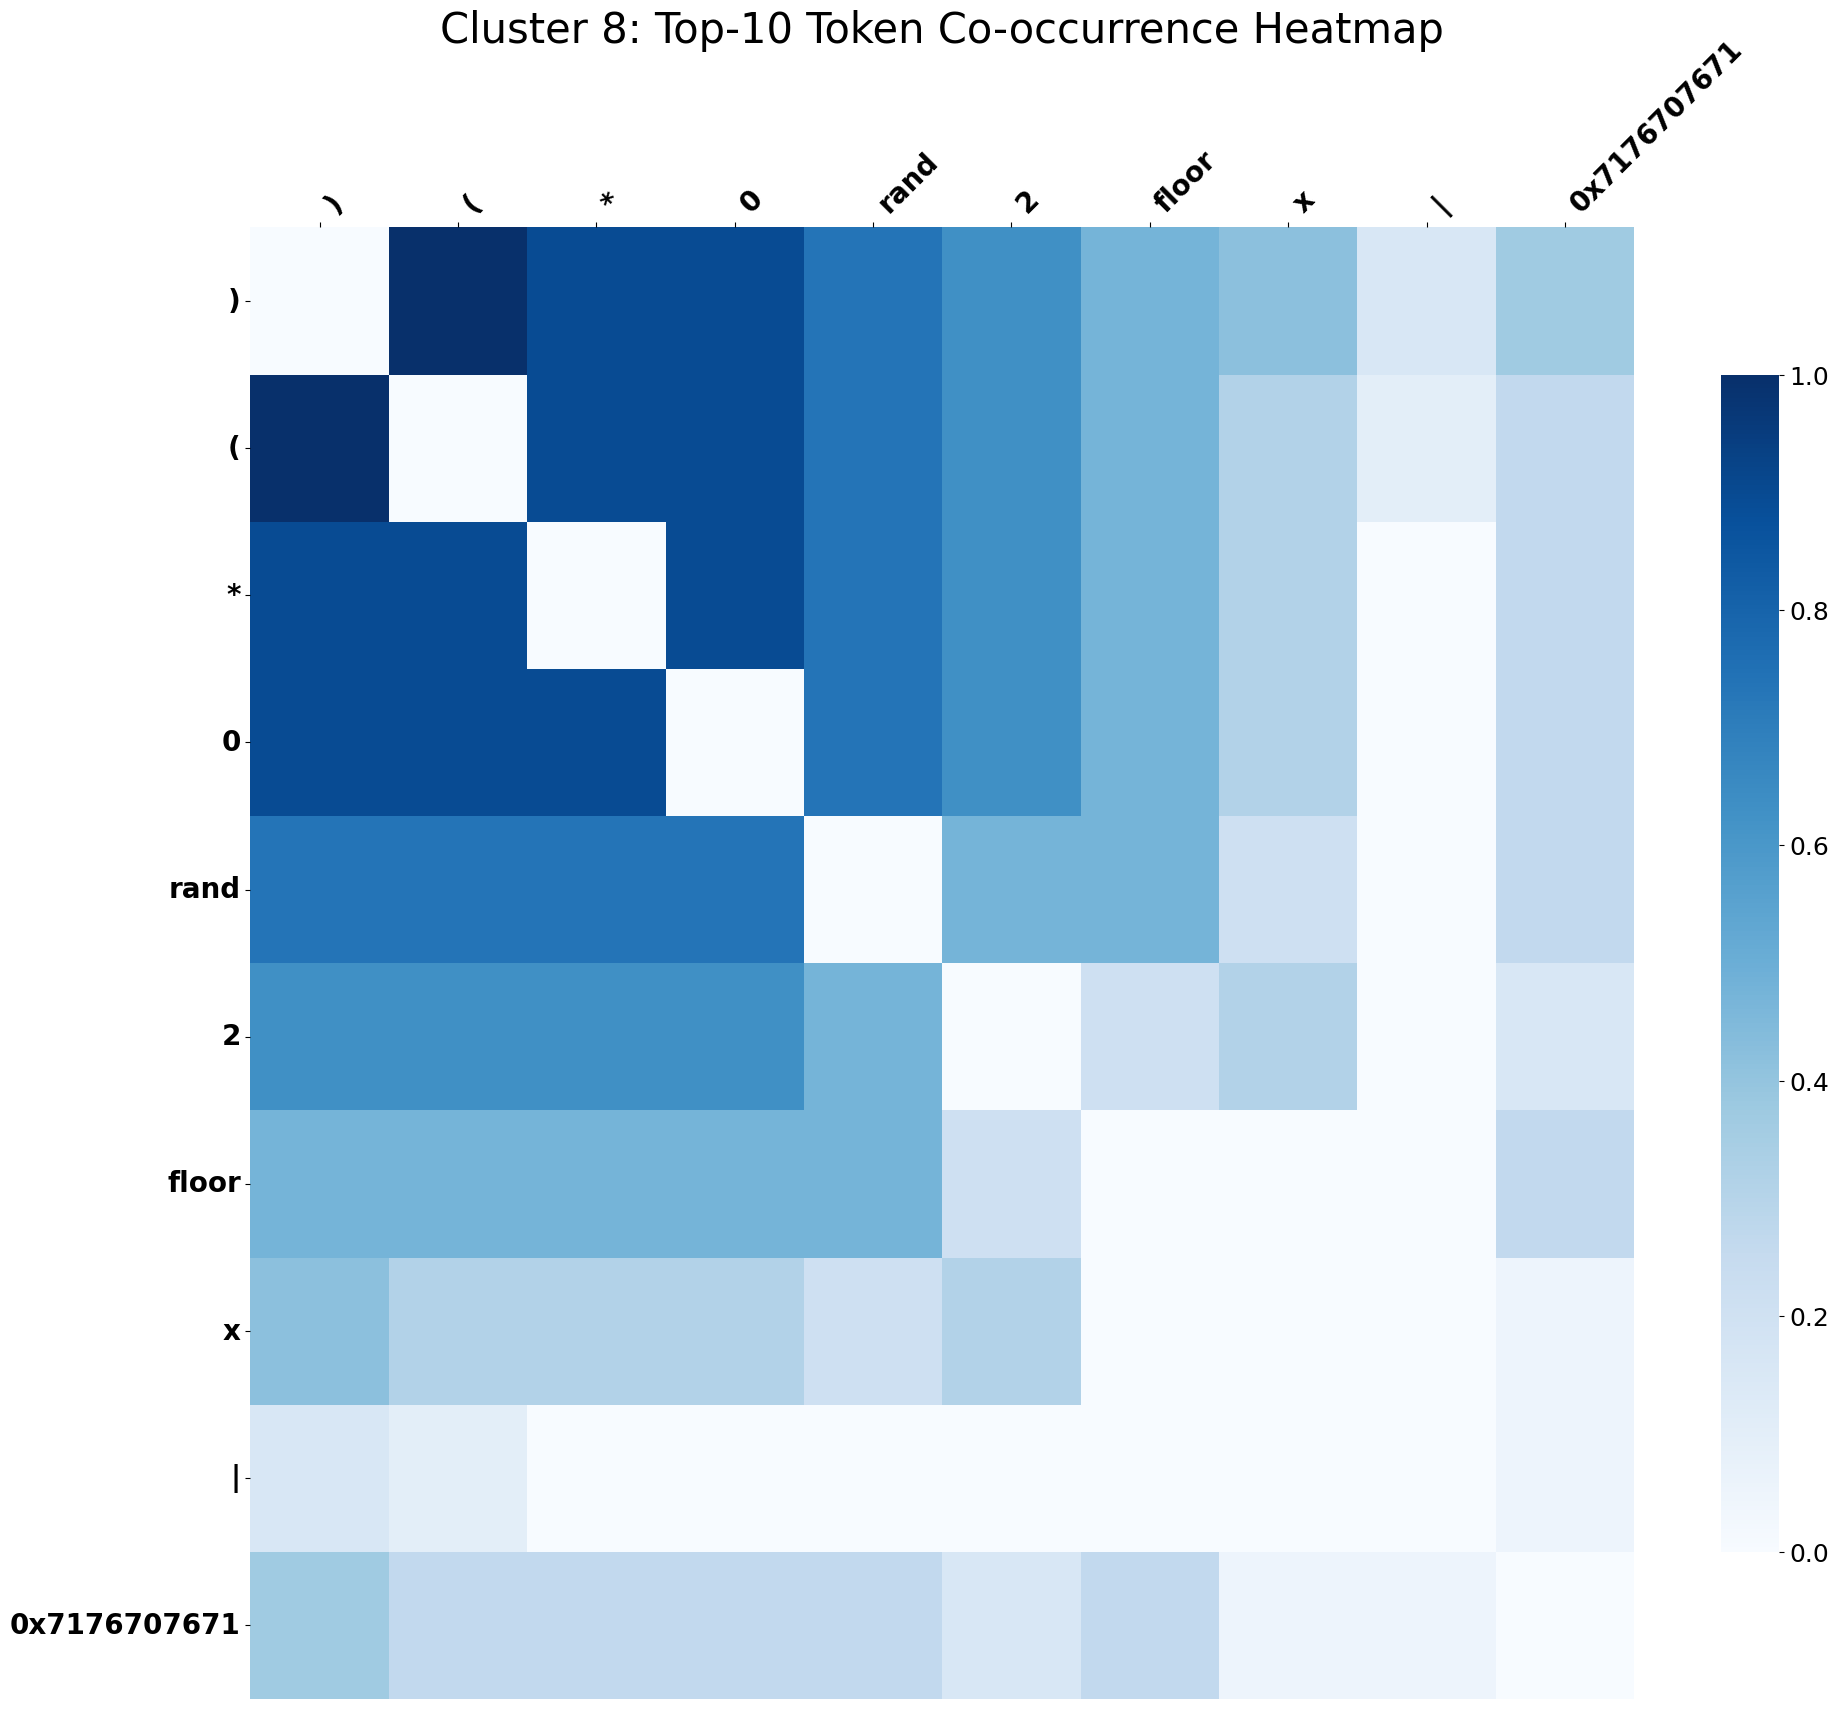

Discovered patterns for cluster 8 (Top-10): [['(', ')', '*', '0', '2', 'floor', 'rand', 'x']]

--- Co-occurrence Analysis for Top 20 Keywords ---


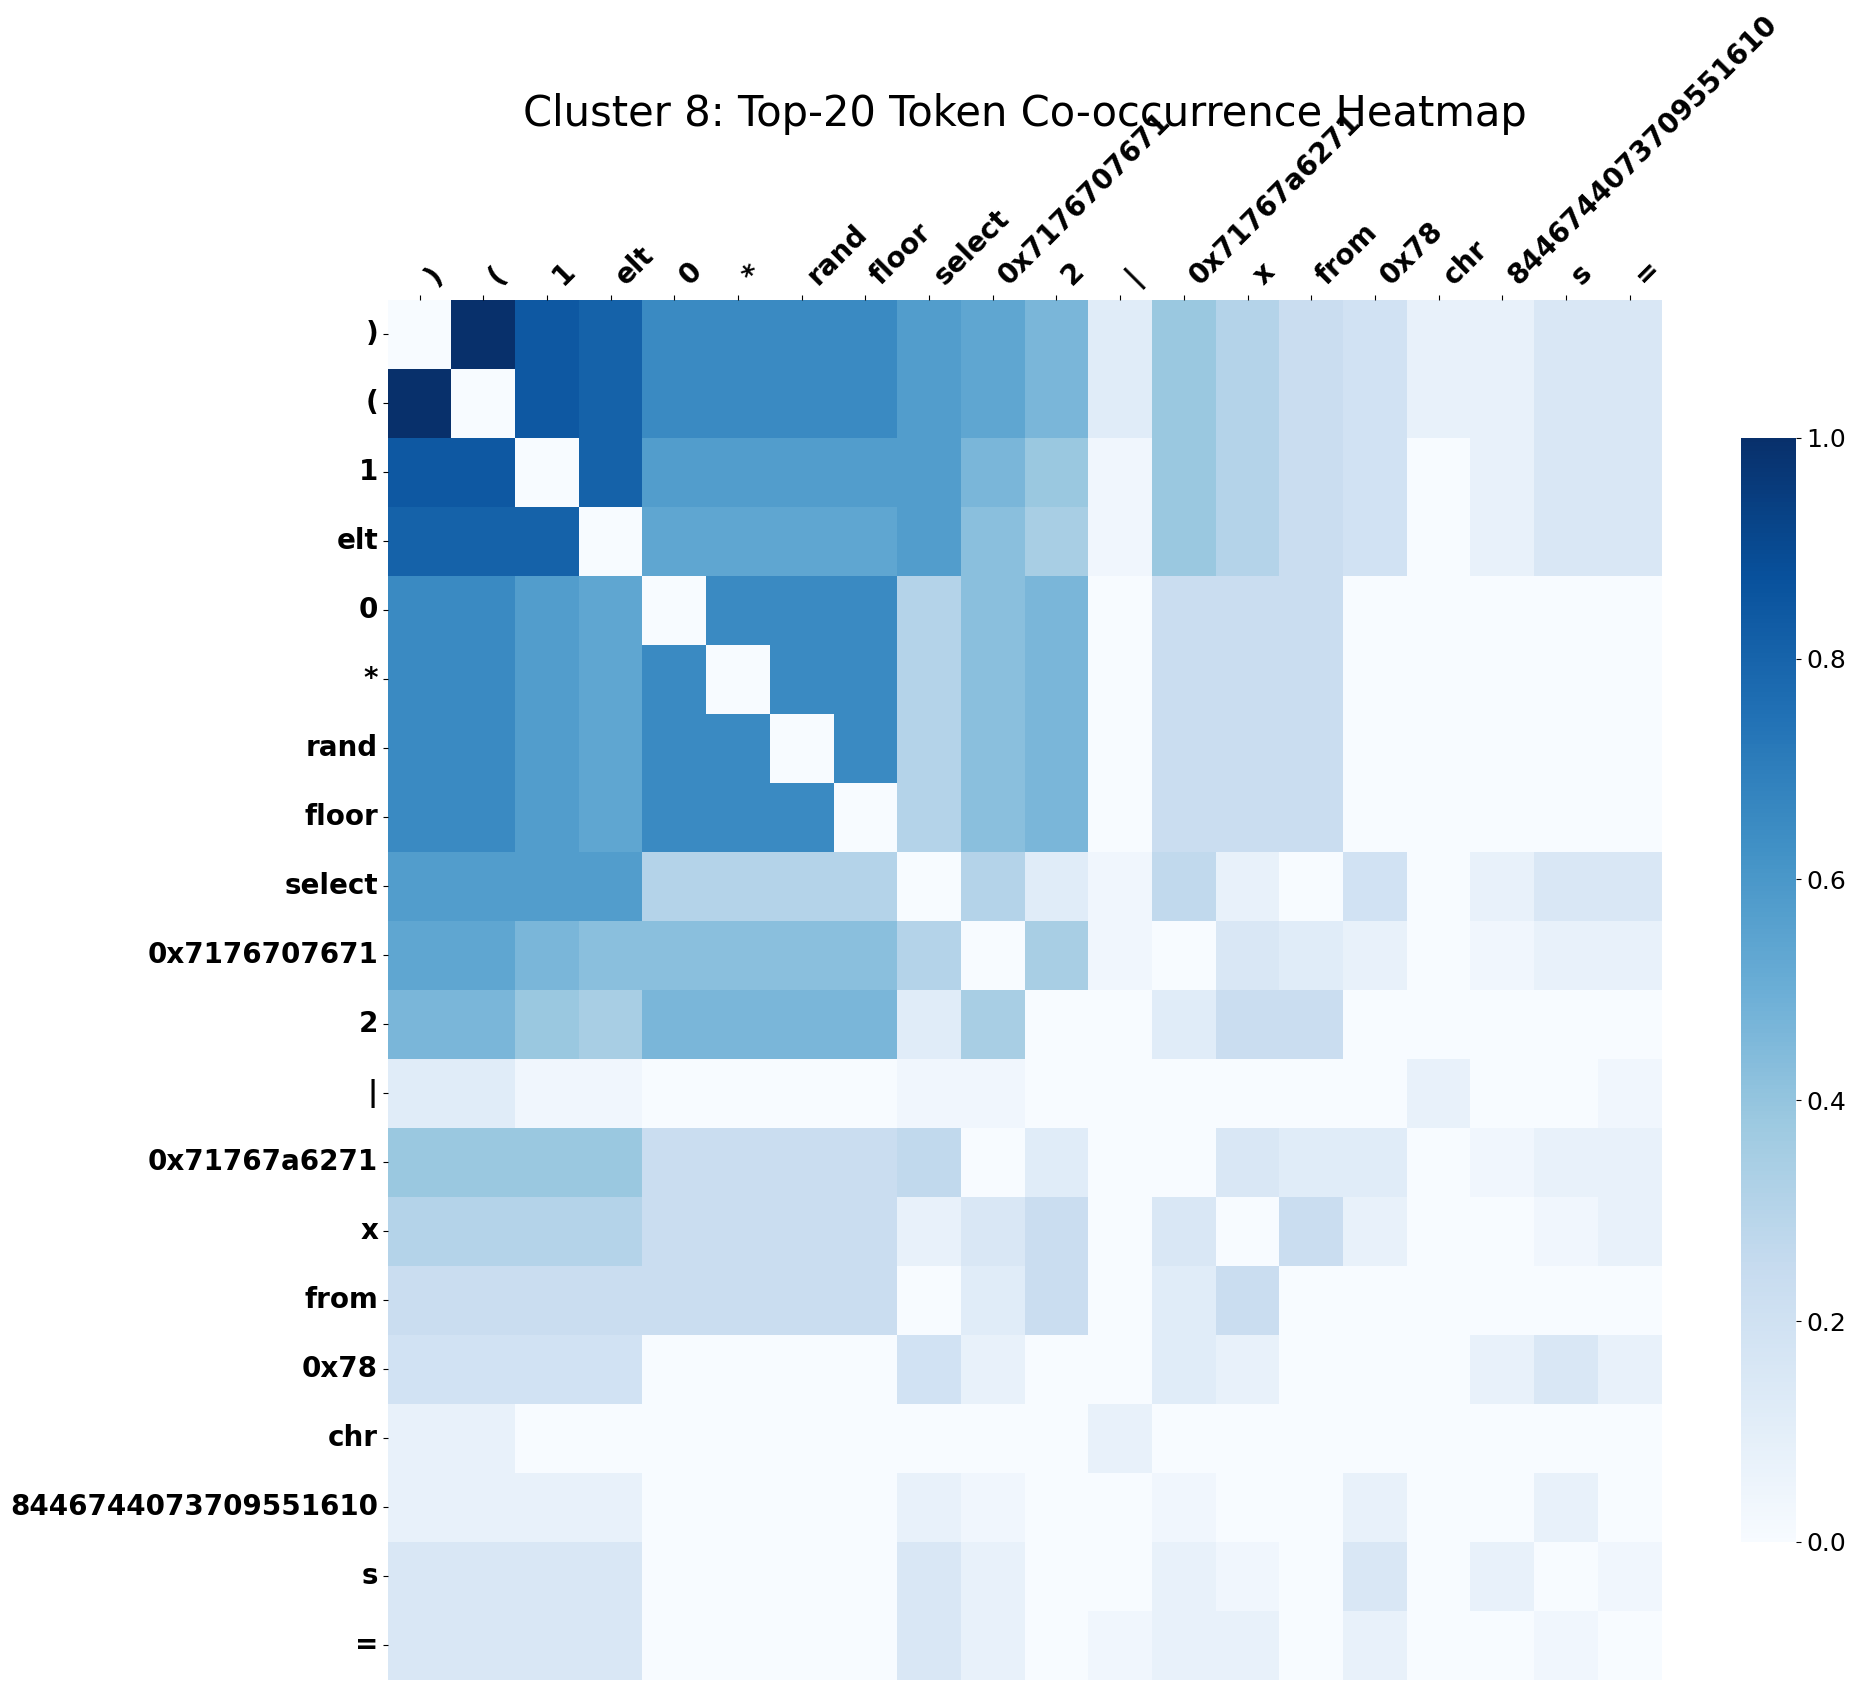

Discovered patterns for cluster 8 (Top-20): [['(', ')', '*', '0', '0x7176707671', '1', '2', 'elt', 'floor', 'rand', 'select']]

Processing Cluster 9...
Members in cluster 9: 11
 Top 10 words by TFIDF: ['style', 'color', 'transform', 'transition', 'question', '113836', 'alert', 'pluginfile', 'answer', 'target']
shape of candidate sets: 11

--- Co-occurrence Analysis for Top 5 Keywords ---


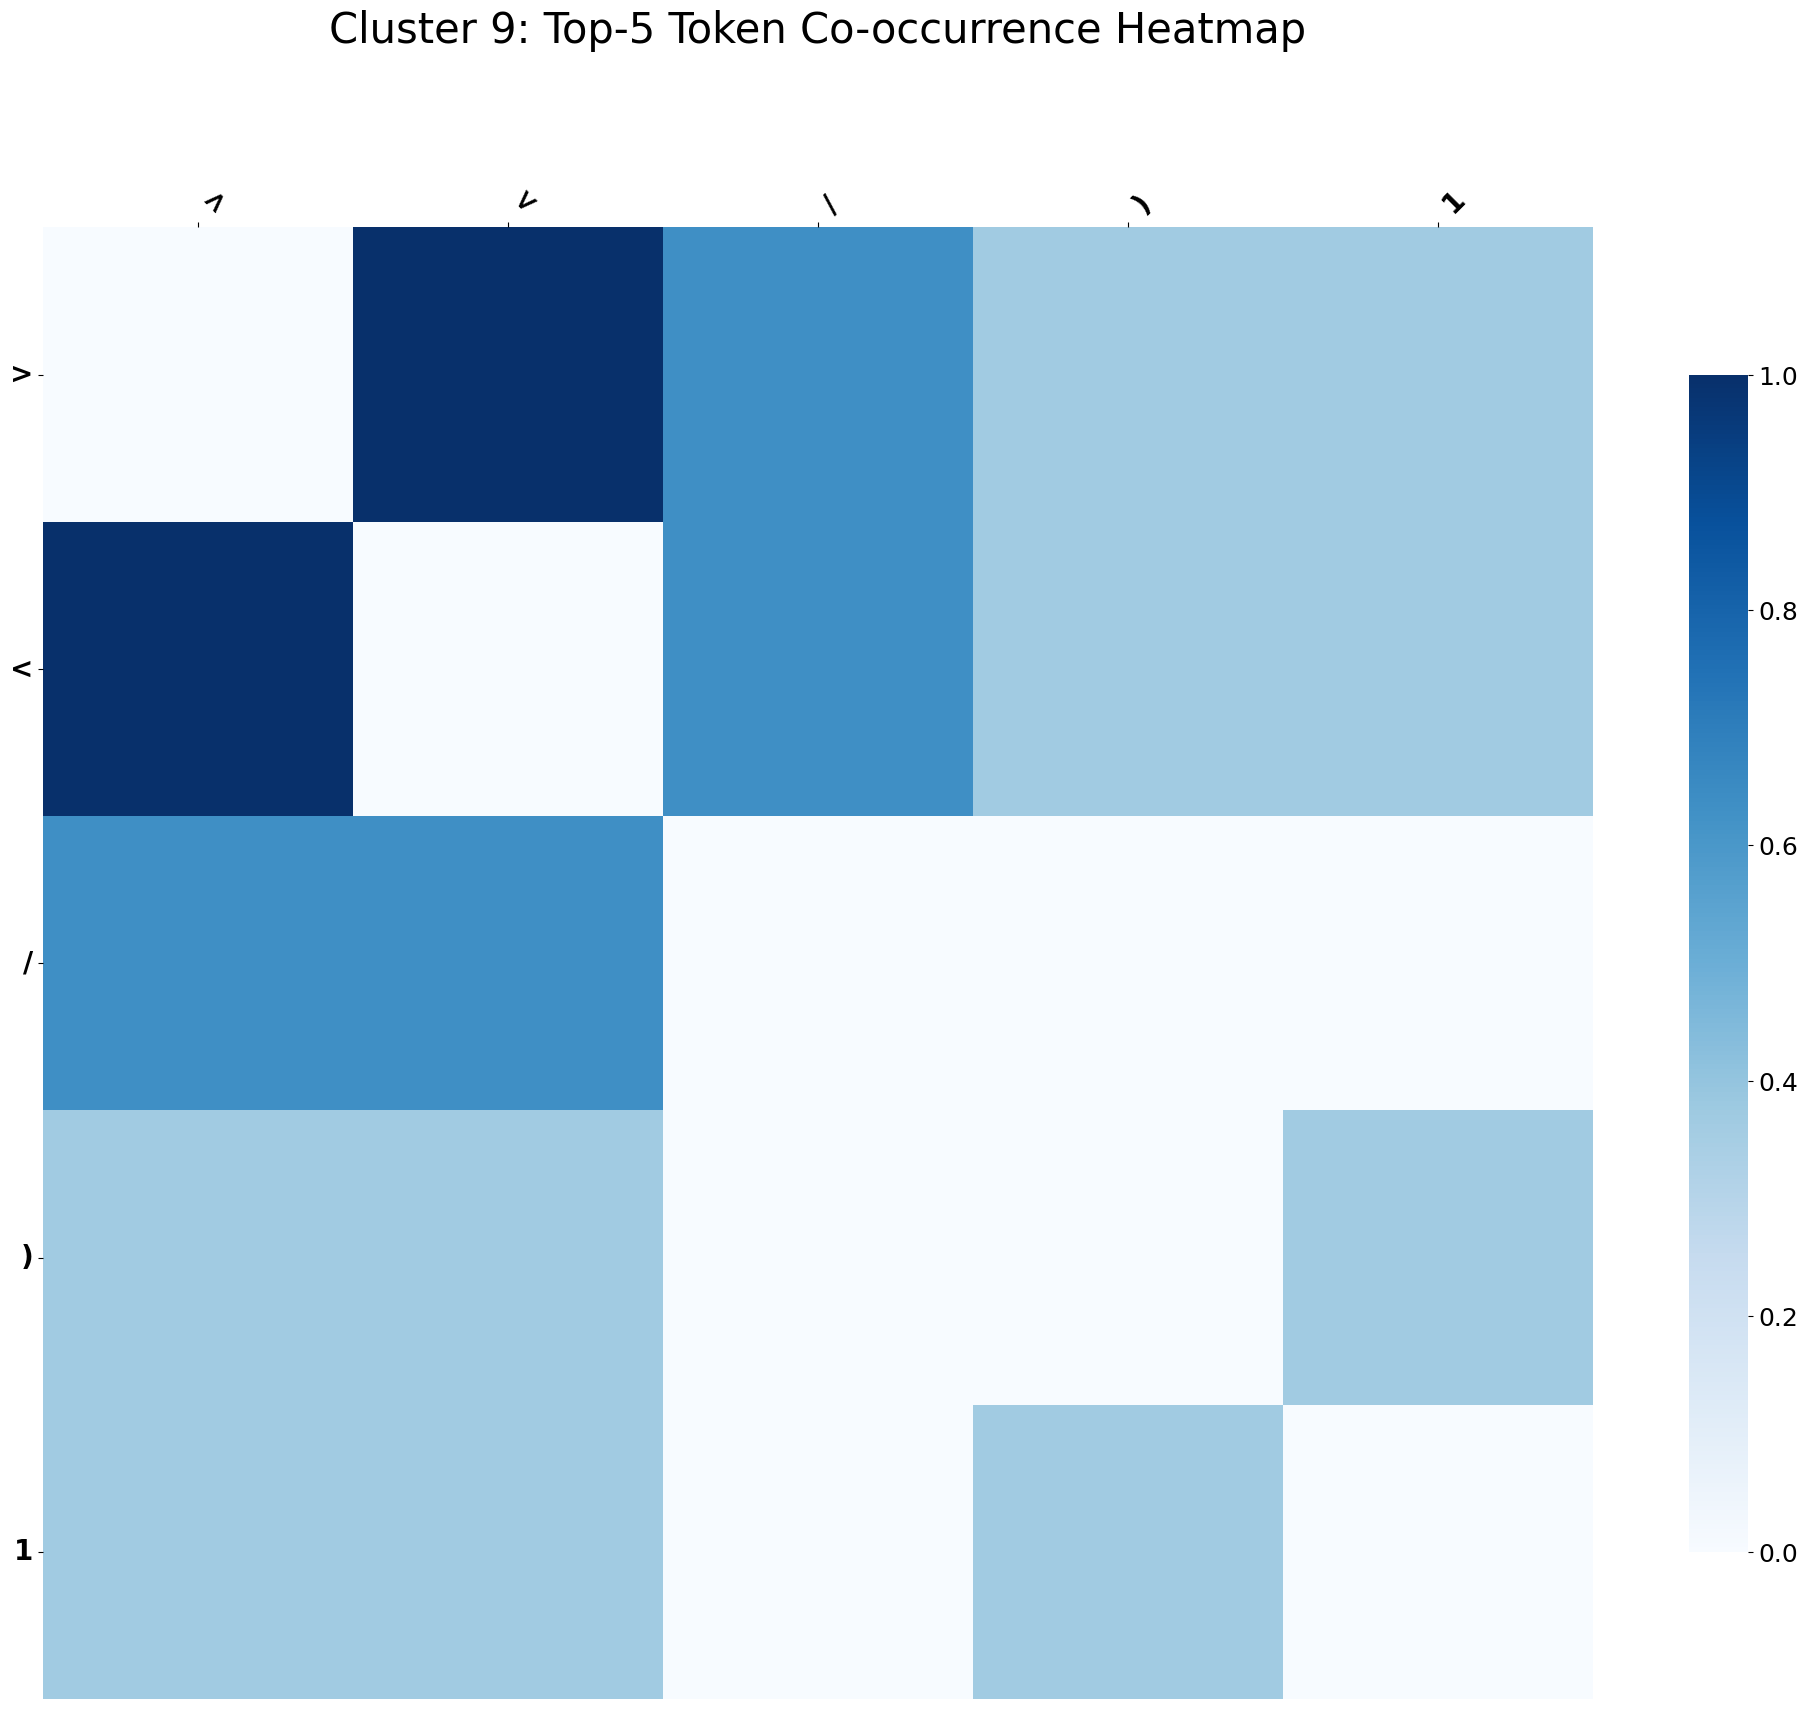

Discovered patterns for cluster 9 (Top-5): [['/', '<', '>']]

--- Co-occurrence Analysis for Top 10 Keywords ---


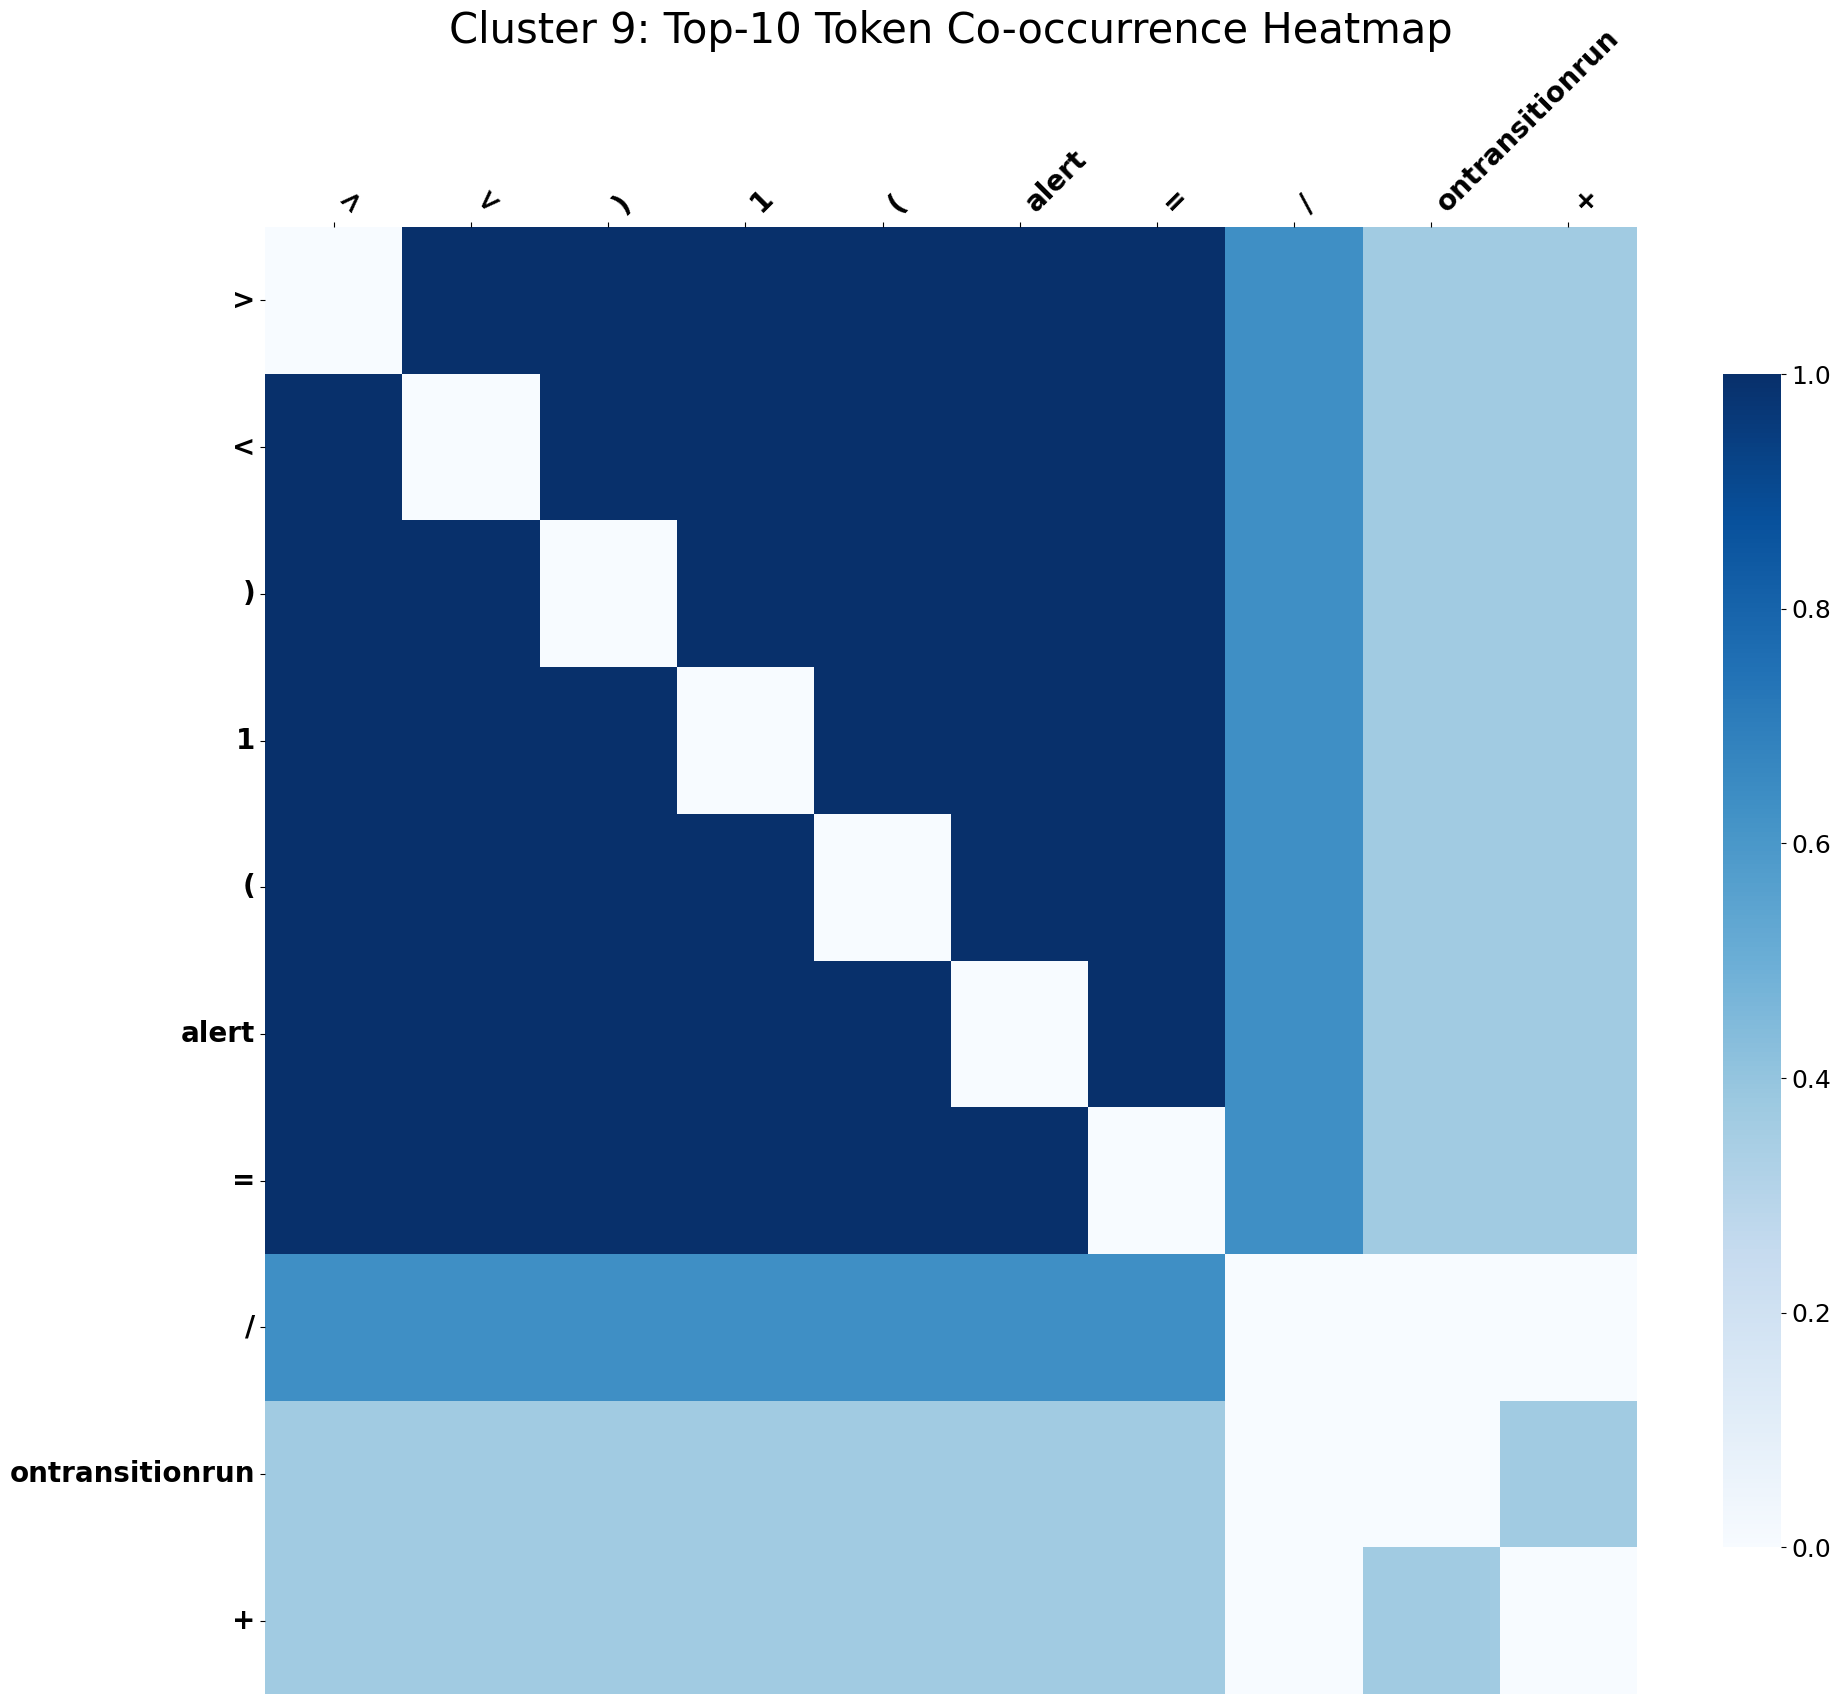

Discovered patterns for cluster 9 (Top-10): [['(', ')', '/', '1', '<', '=', '>', 'alert']]

--- Co-occurrence Analysis for Top 20 Keywords ---


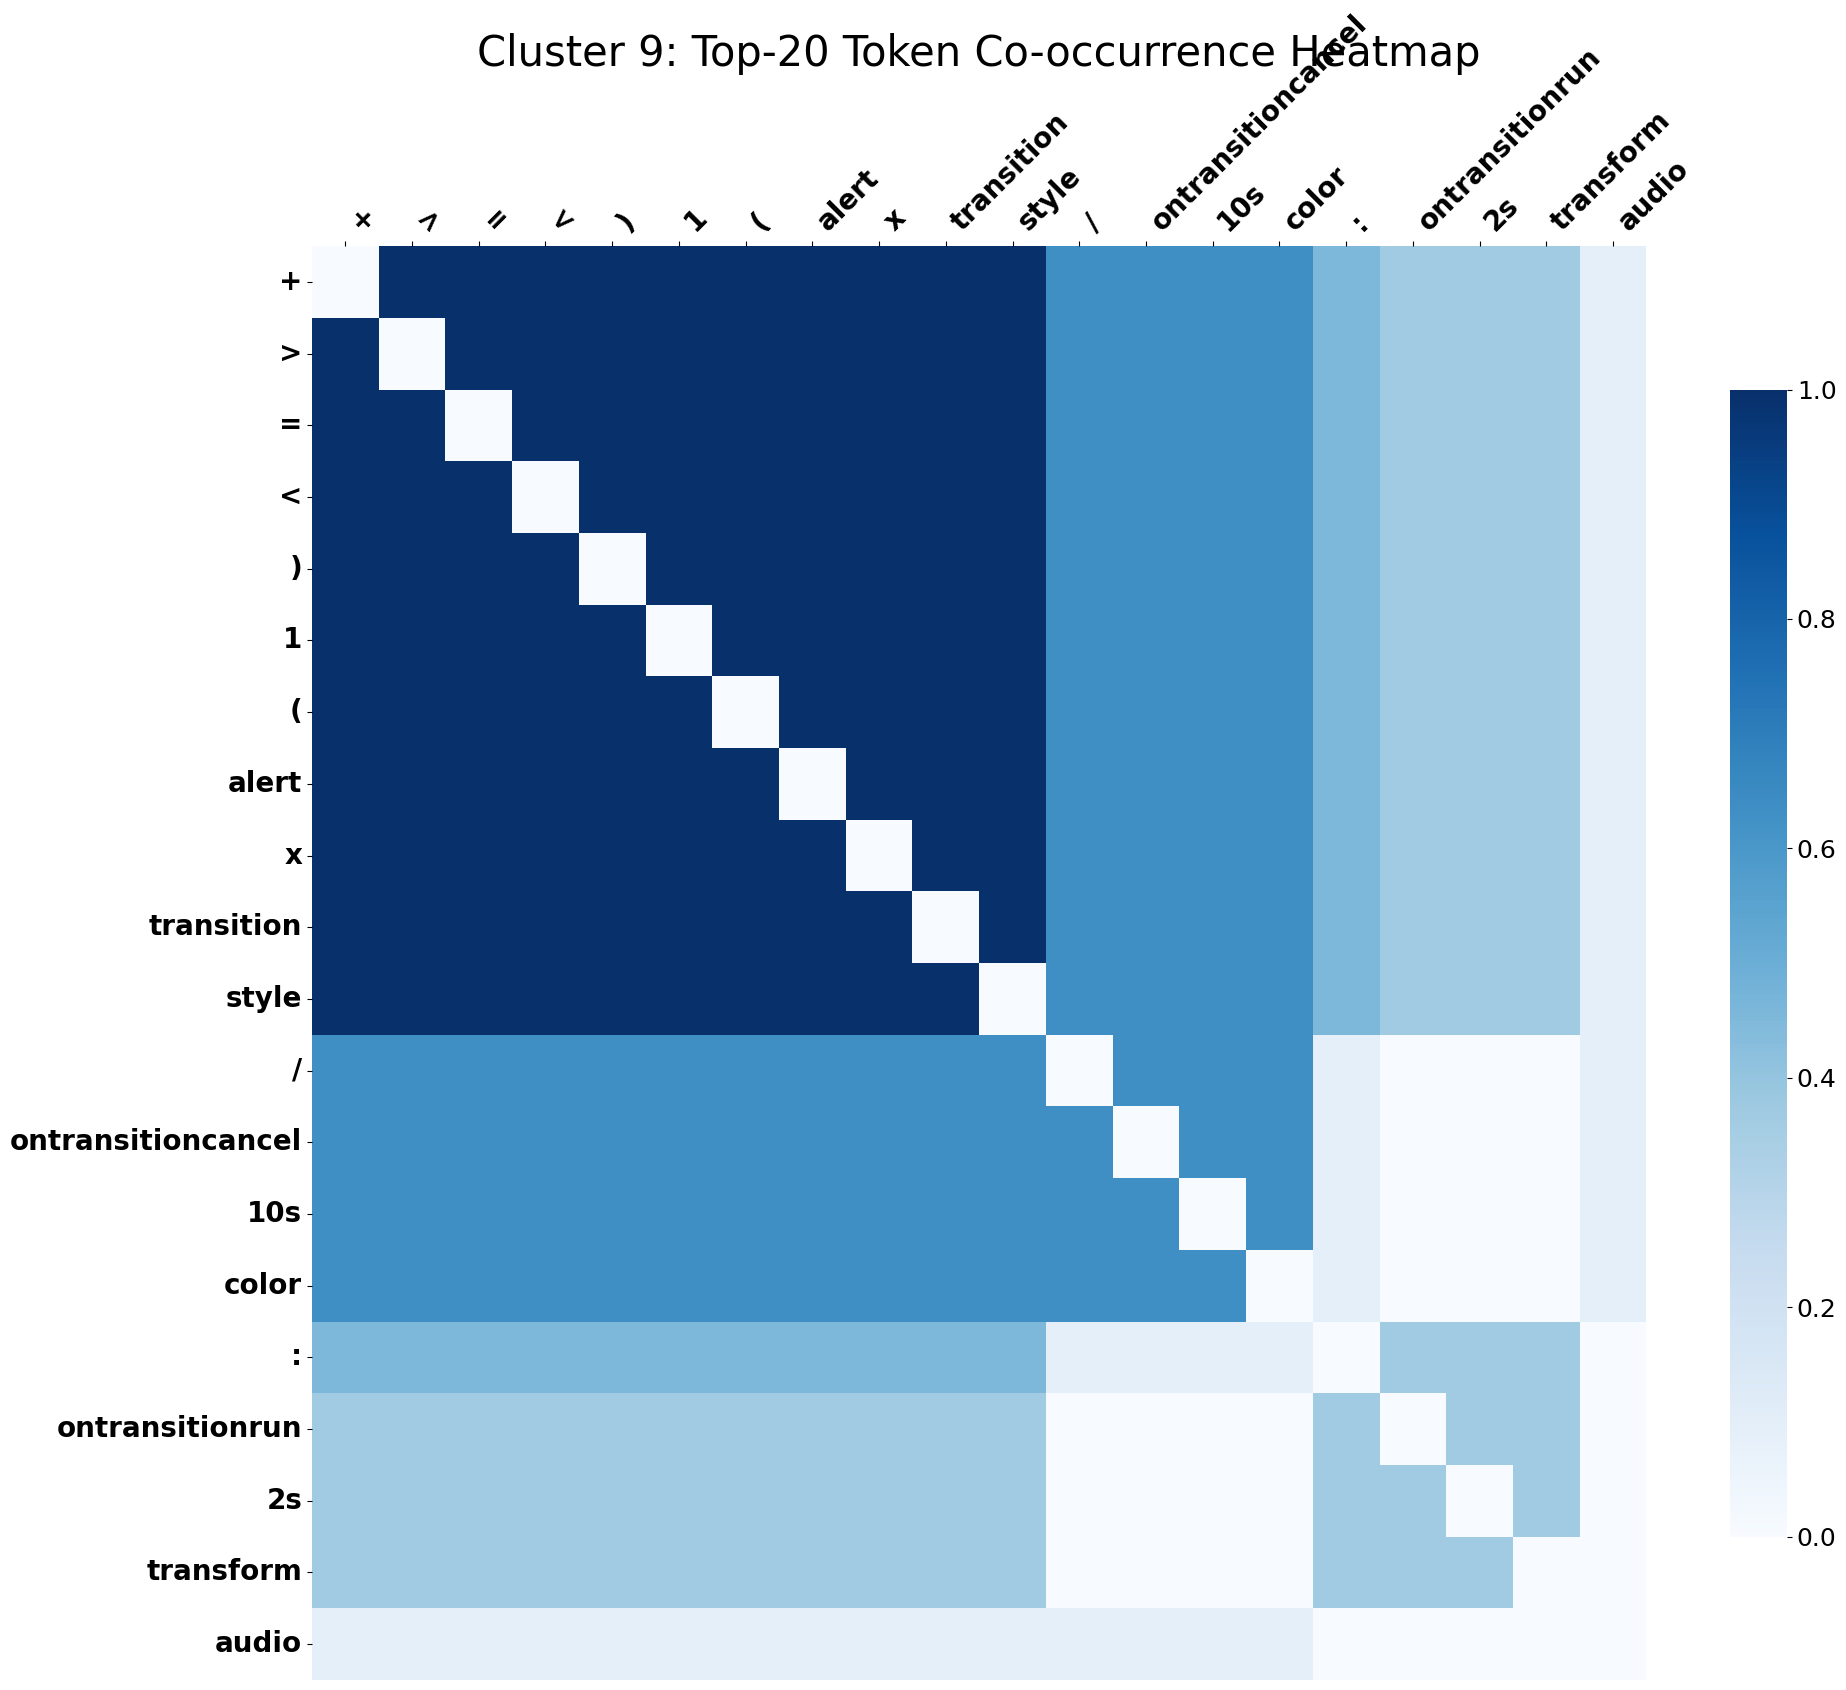

Discovered patterns for cluster 9 (Top-20): [['(', ')', '+', '/', '1', '10s', ':', '<', '=', '>', 'alert', 'color', 'ontransitioncancel', 'style', 'transition', 'x']]

Processing Cluster 10...
Members in cluster 10: 15
 Top 10 words by TFIDF: ['and', 'as', 'columns', 'schema', 'information', '1430', 'answer', 'question', 'select', '113836']
shape of candidate sets: 15

--- Co-occurrence Analysis for Top 5 Keywords ---


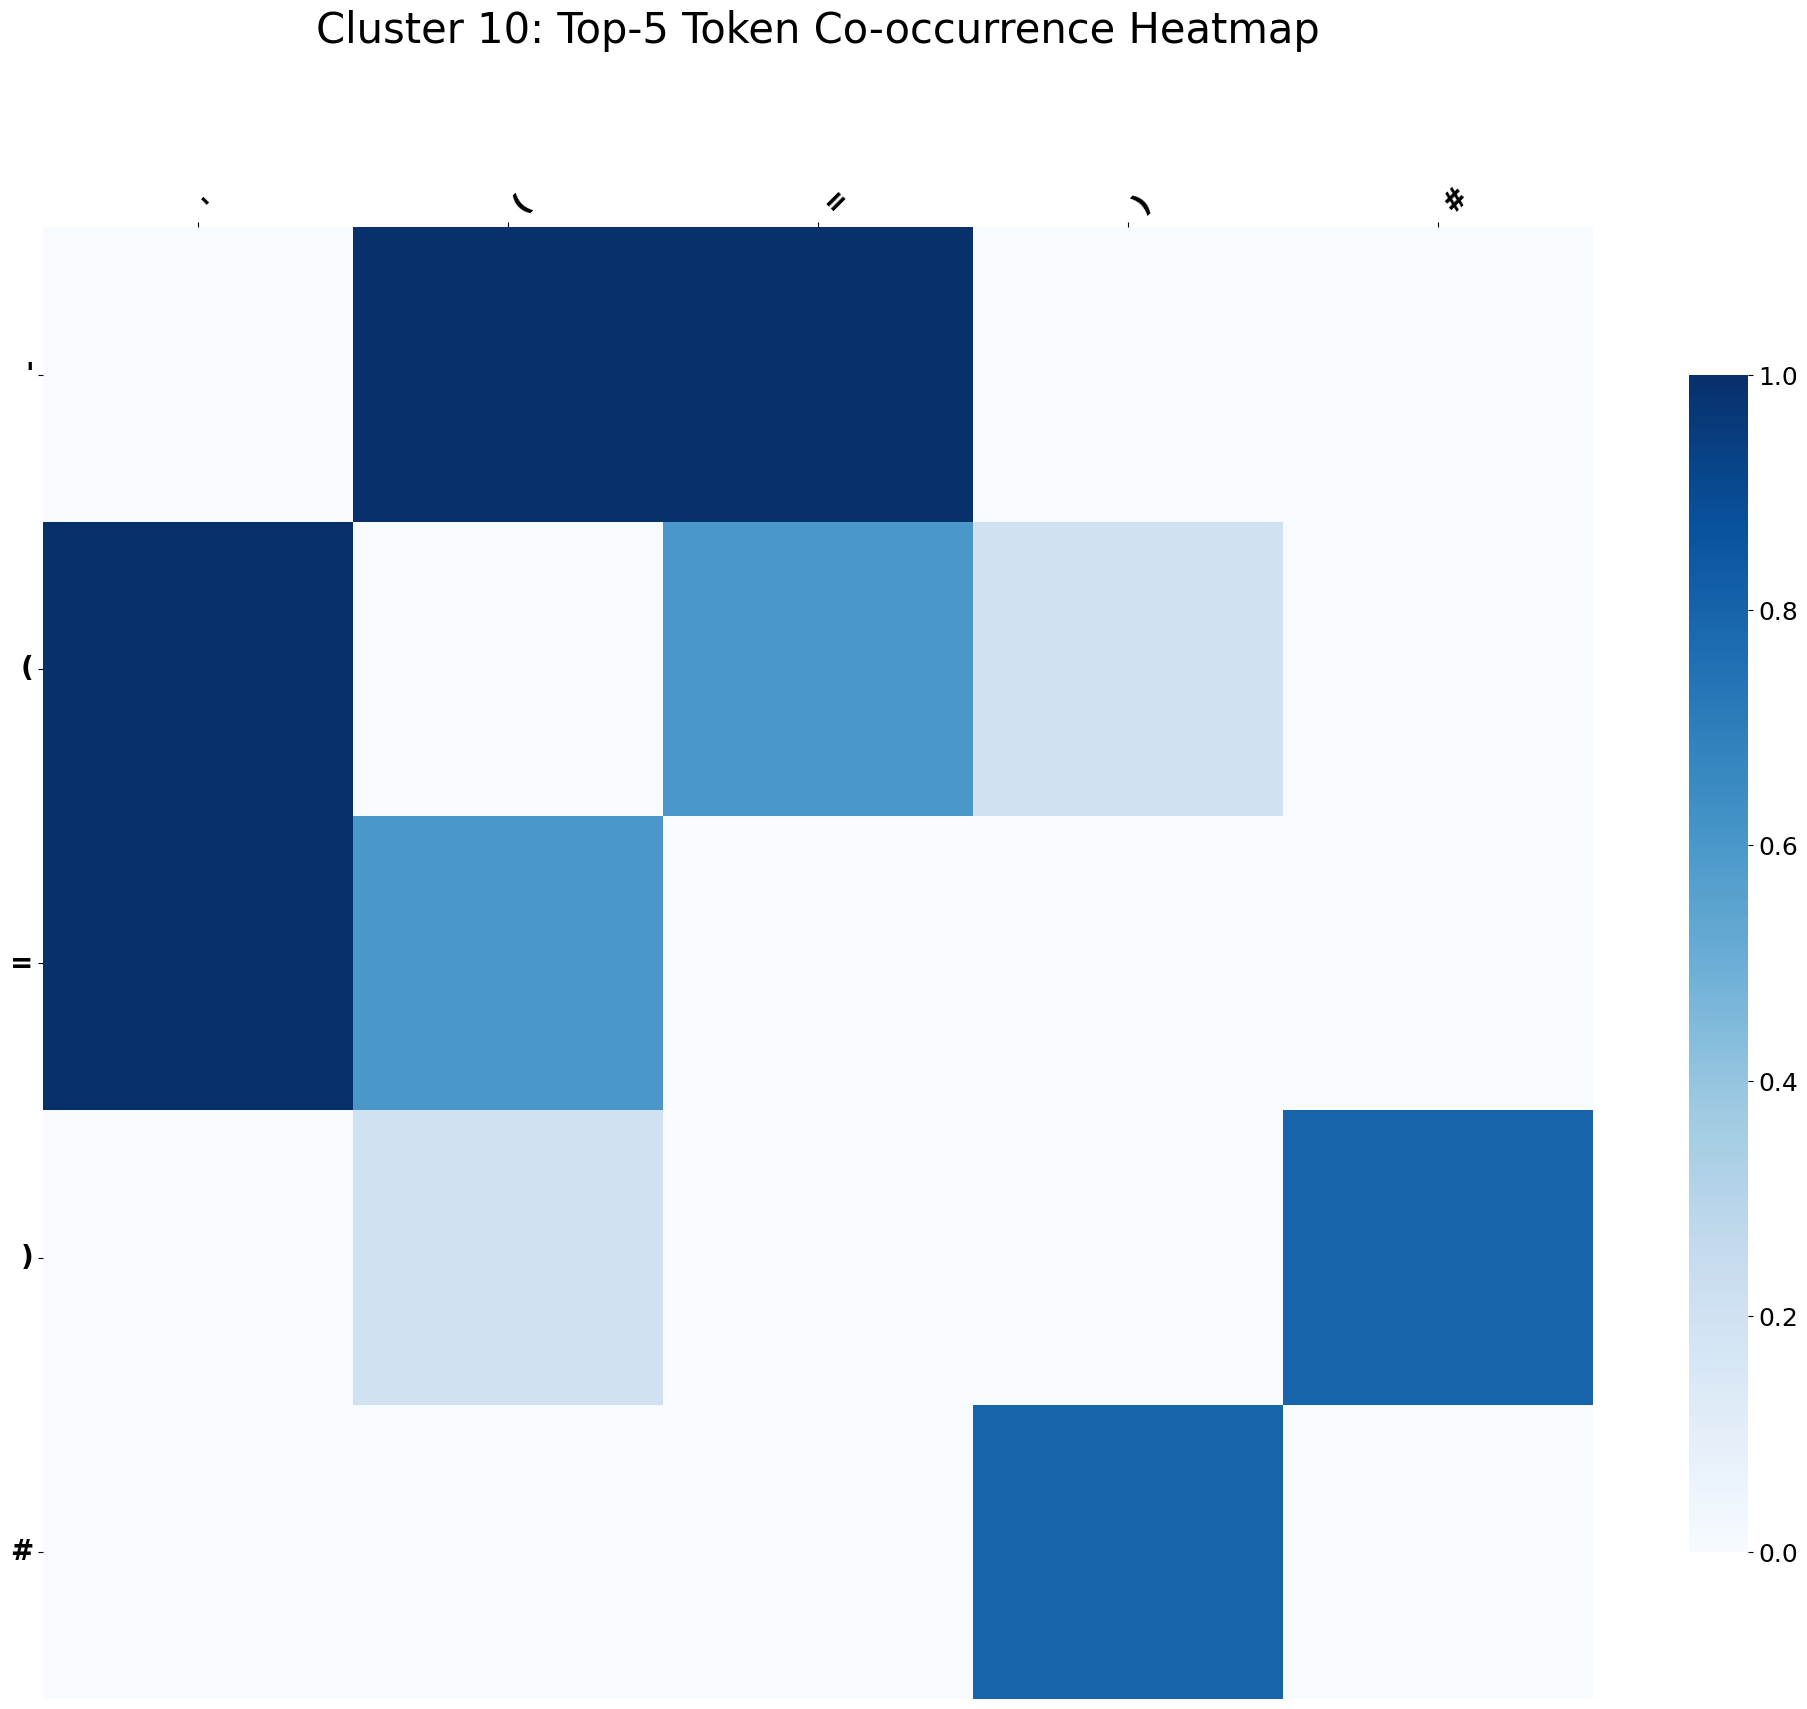

Discovered patterns for cluster 10 (Top-5): [["'", '(', '='], ['#', ')']]

--- Co-occurrence Analysis for Top 10 Keywords ---


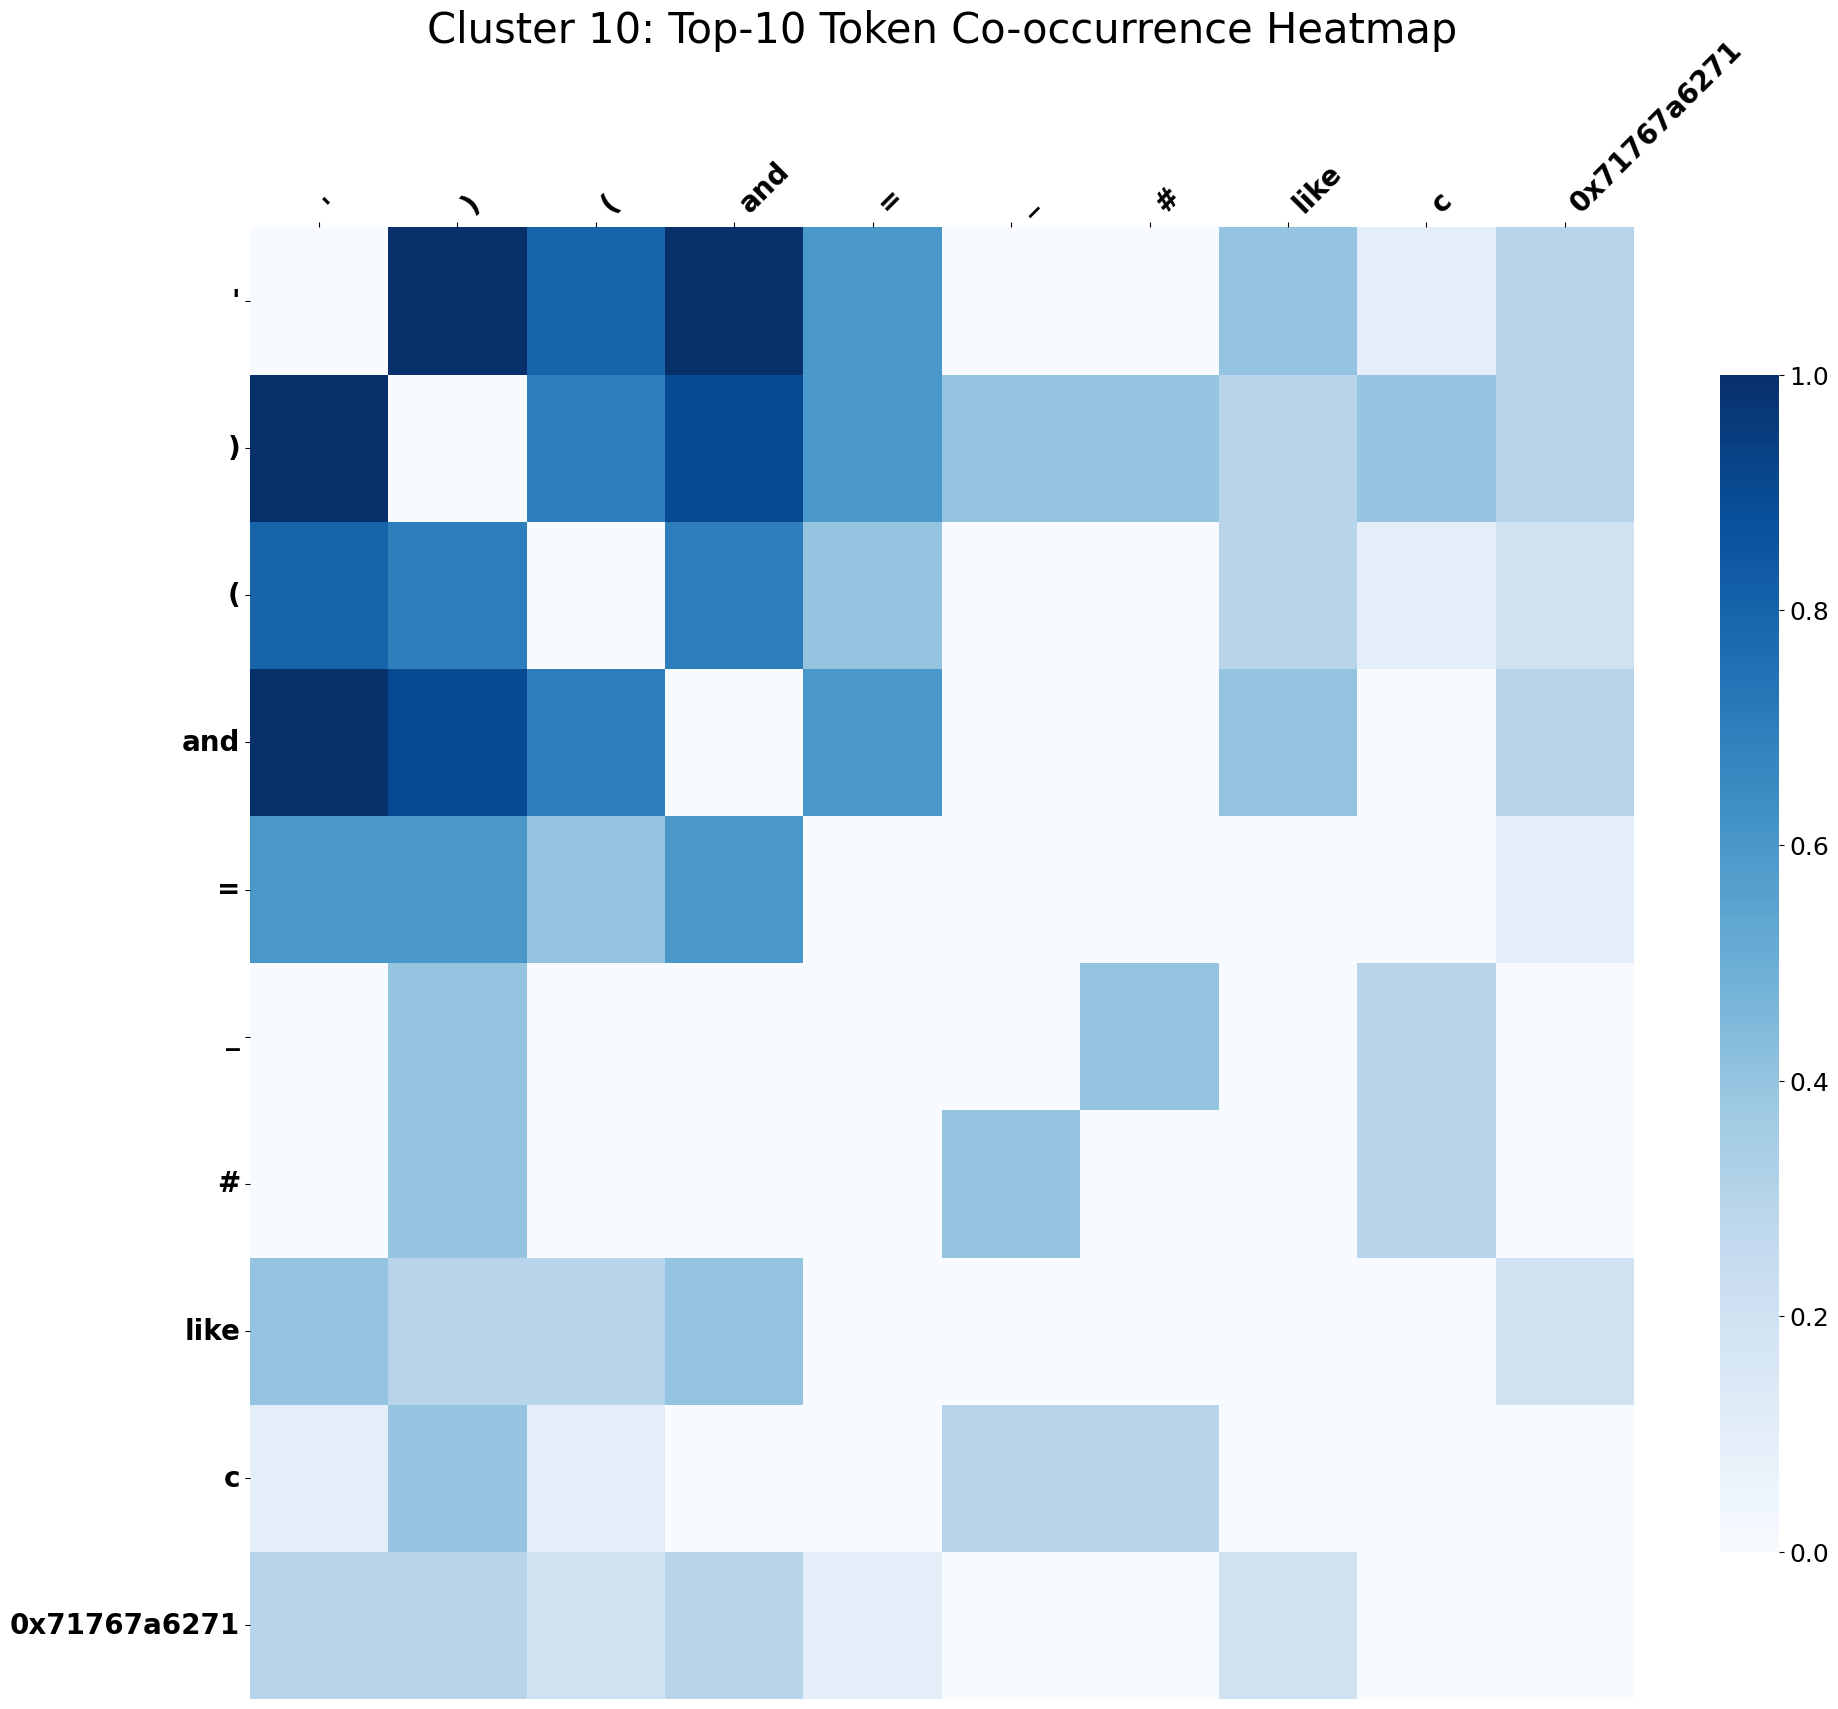

Discovered patterns for cluster 10 (Top-10): [['#', "'", '(', ')', '=', '_', 'and', 'c', 'like']]

--- Co-occurrence Analysis for Top 20 Keywords ---


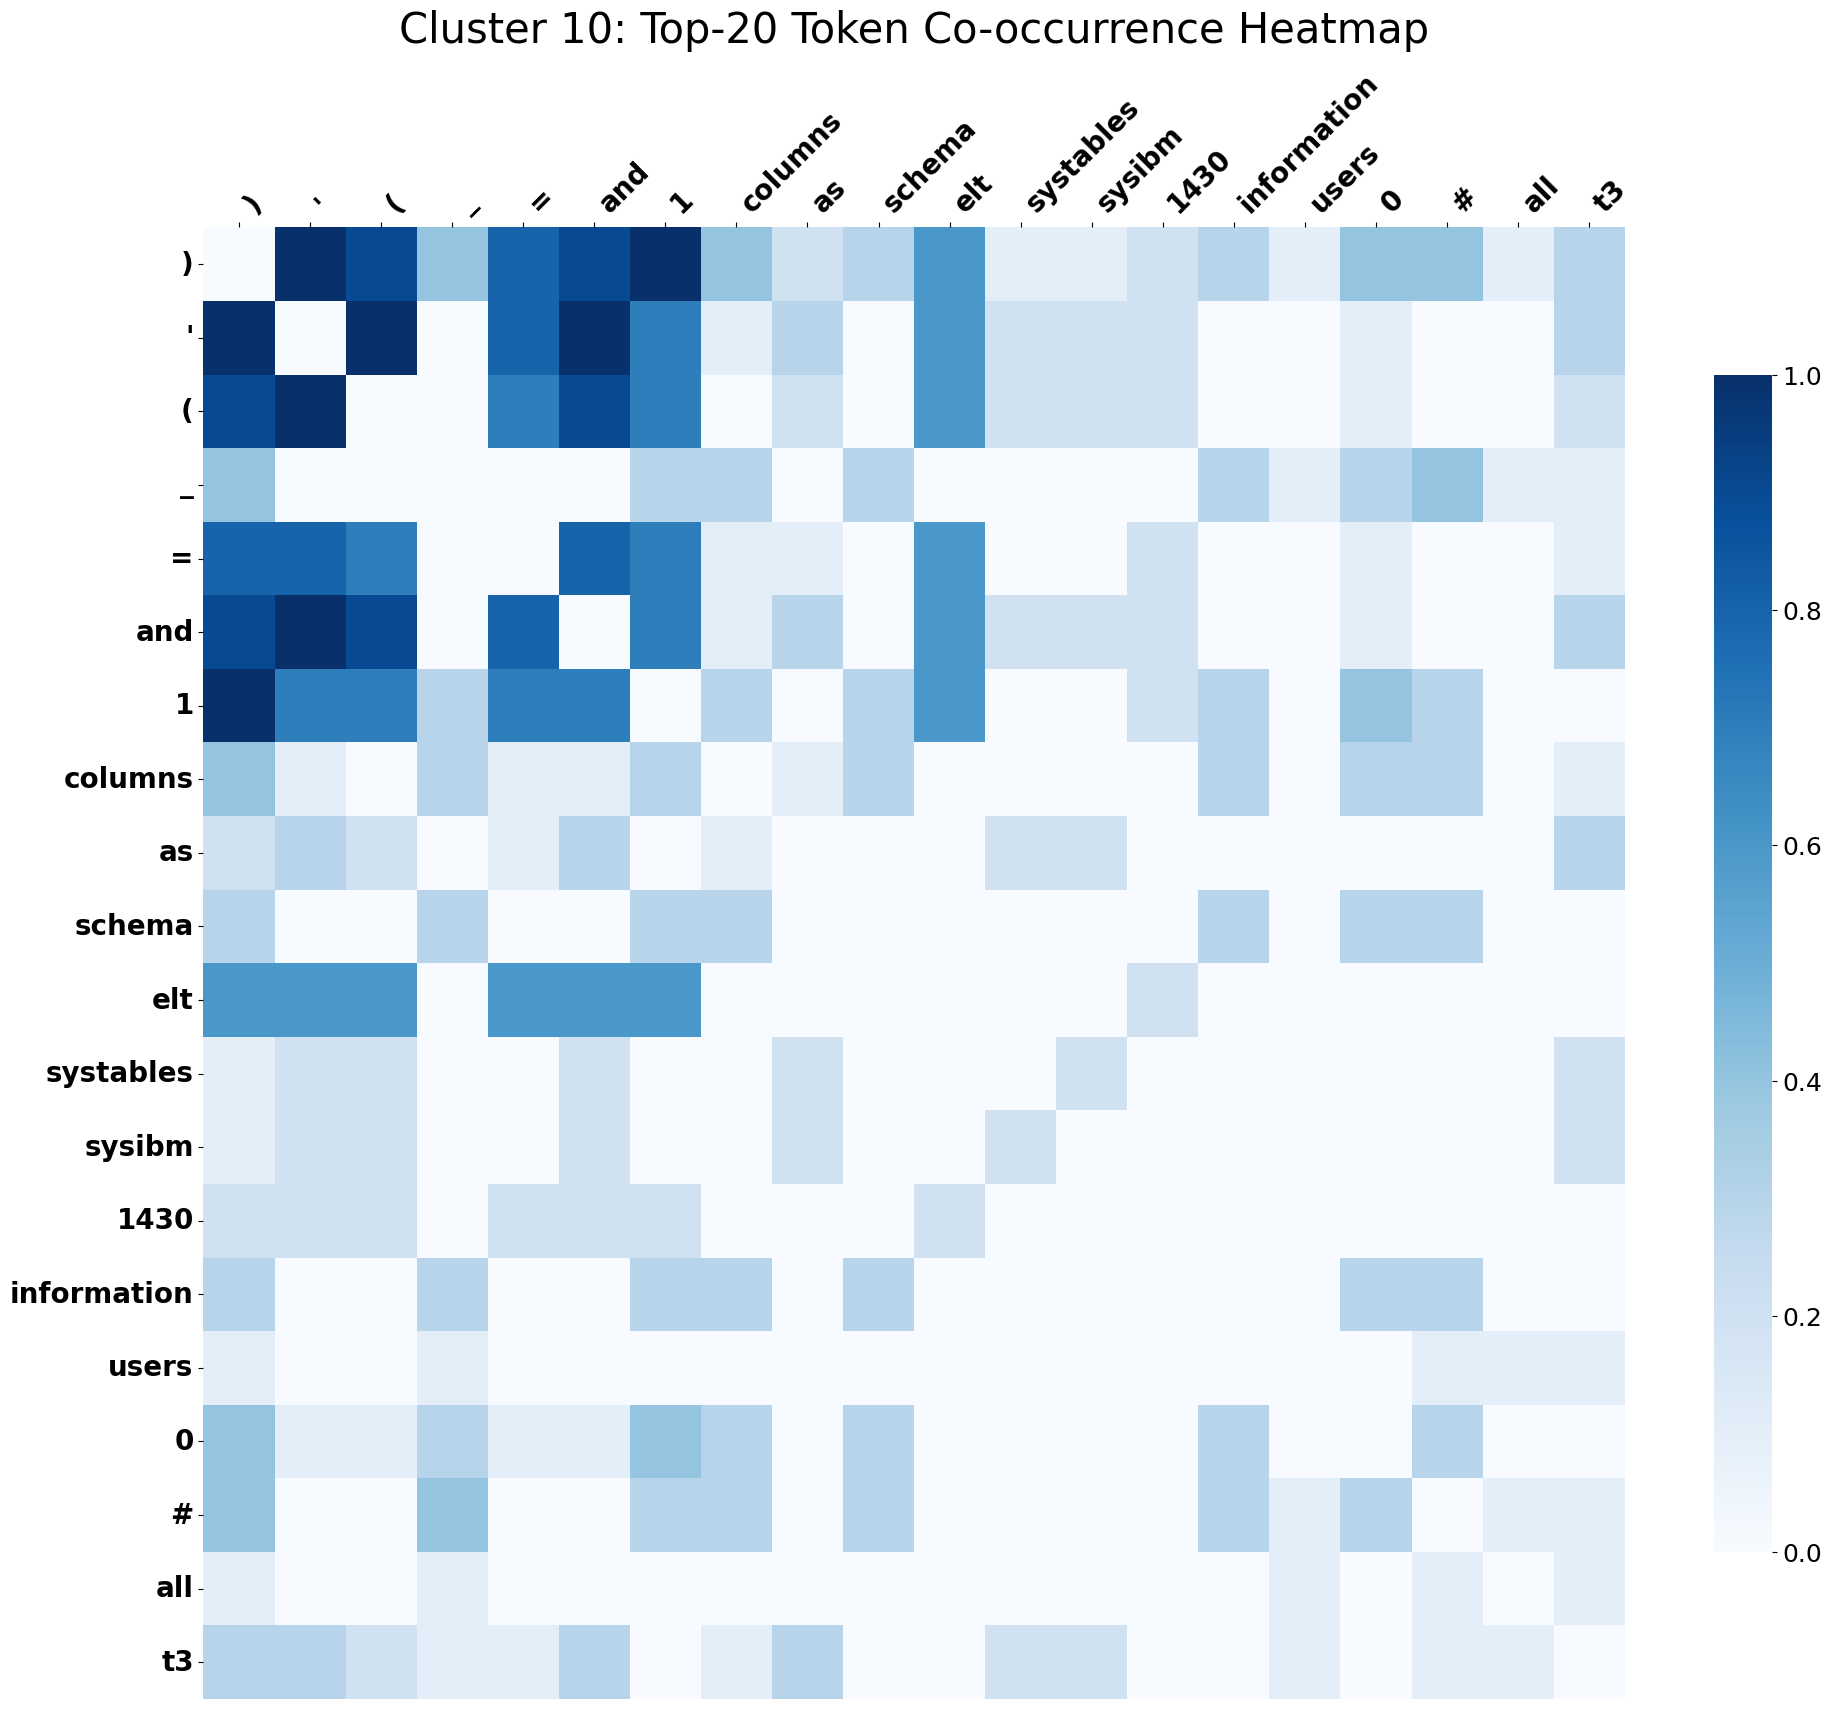

Discovered patterns for cluster 10 (Top-20): [['#', "'", '(', ')', '0', '1', '=', '_', 'and', 'columns', 'elt']]

Processing Cluster 11...
Members in cluster 11: 17
 Top 10 words by TFIDF: ['answer', 'pluginfile', 'union', 'select', '113836', 'question', 'all', 'where', 'as', 'jpg']
shape of candidate sets: 17

--- Co-occurrence Analysis for Top 5 Keywords ---


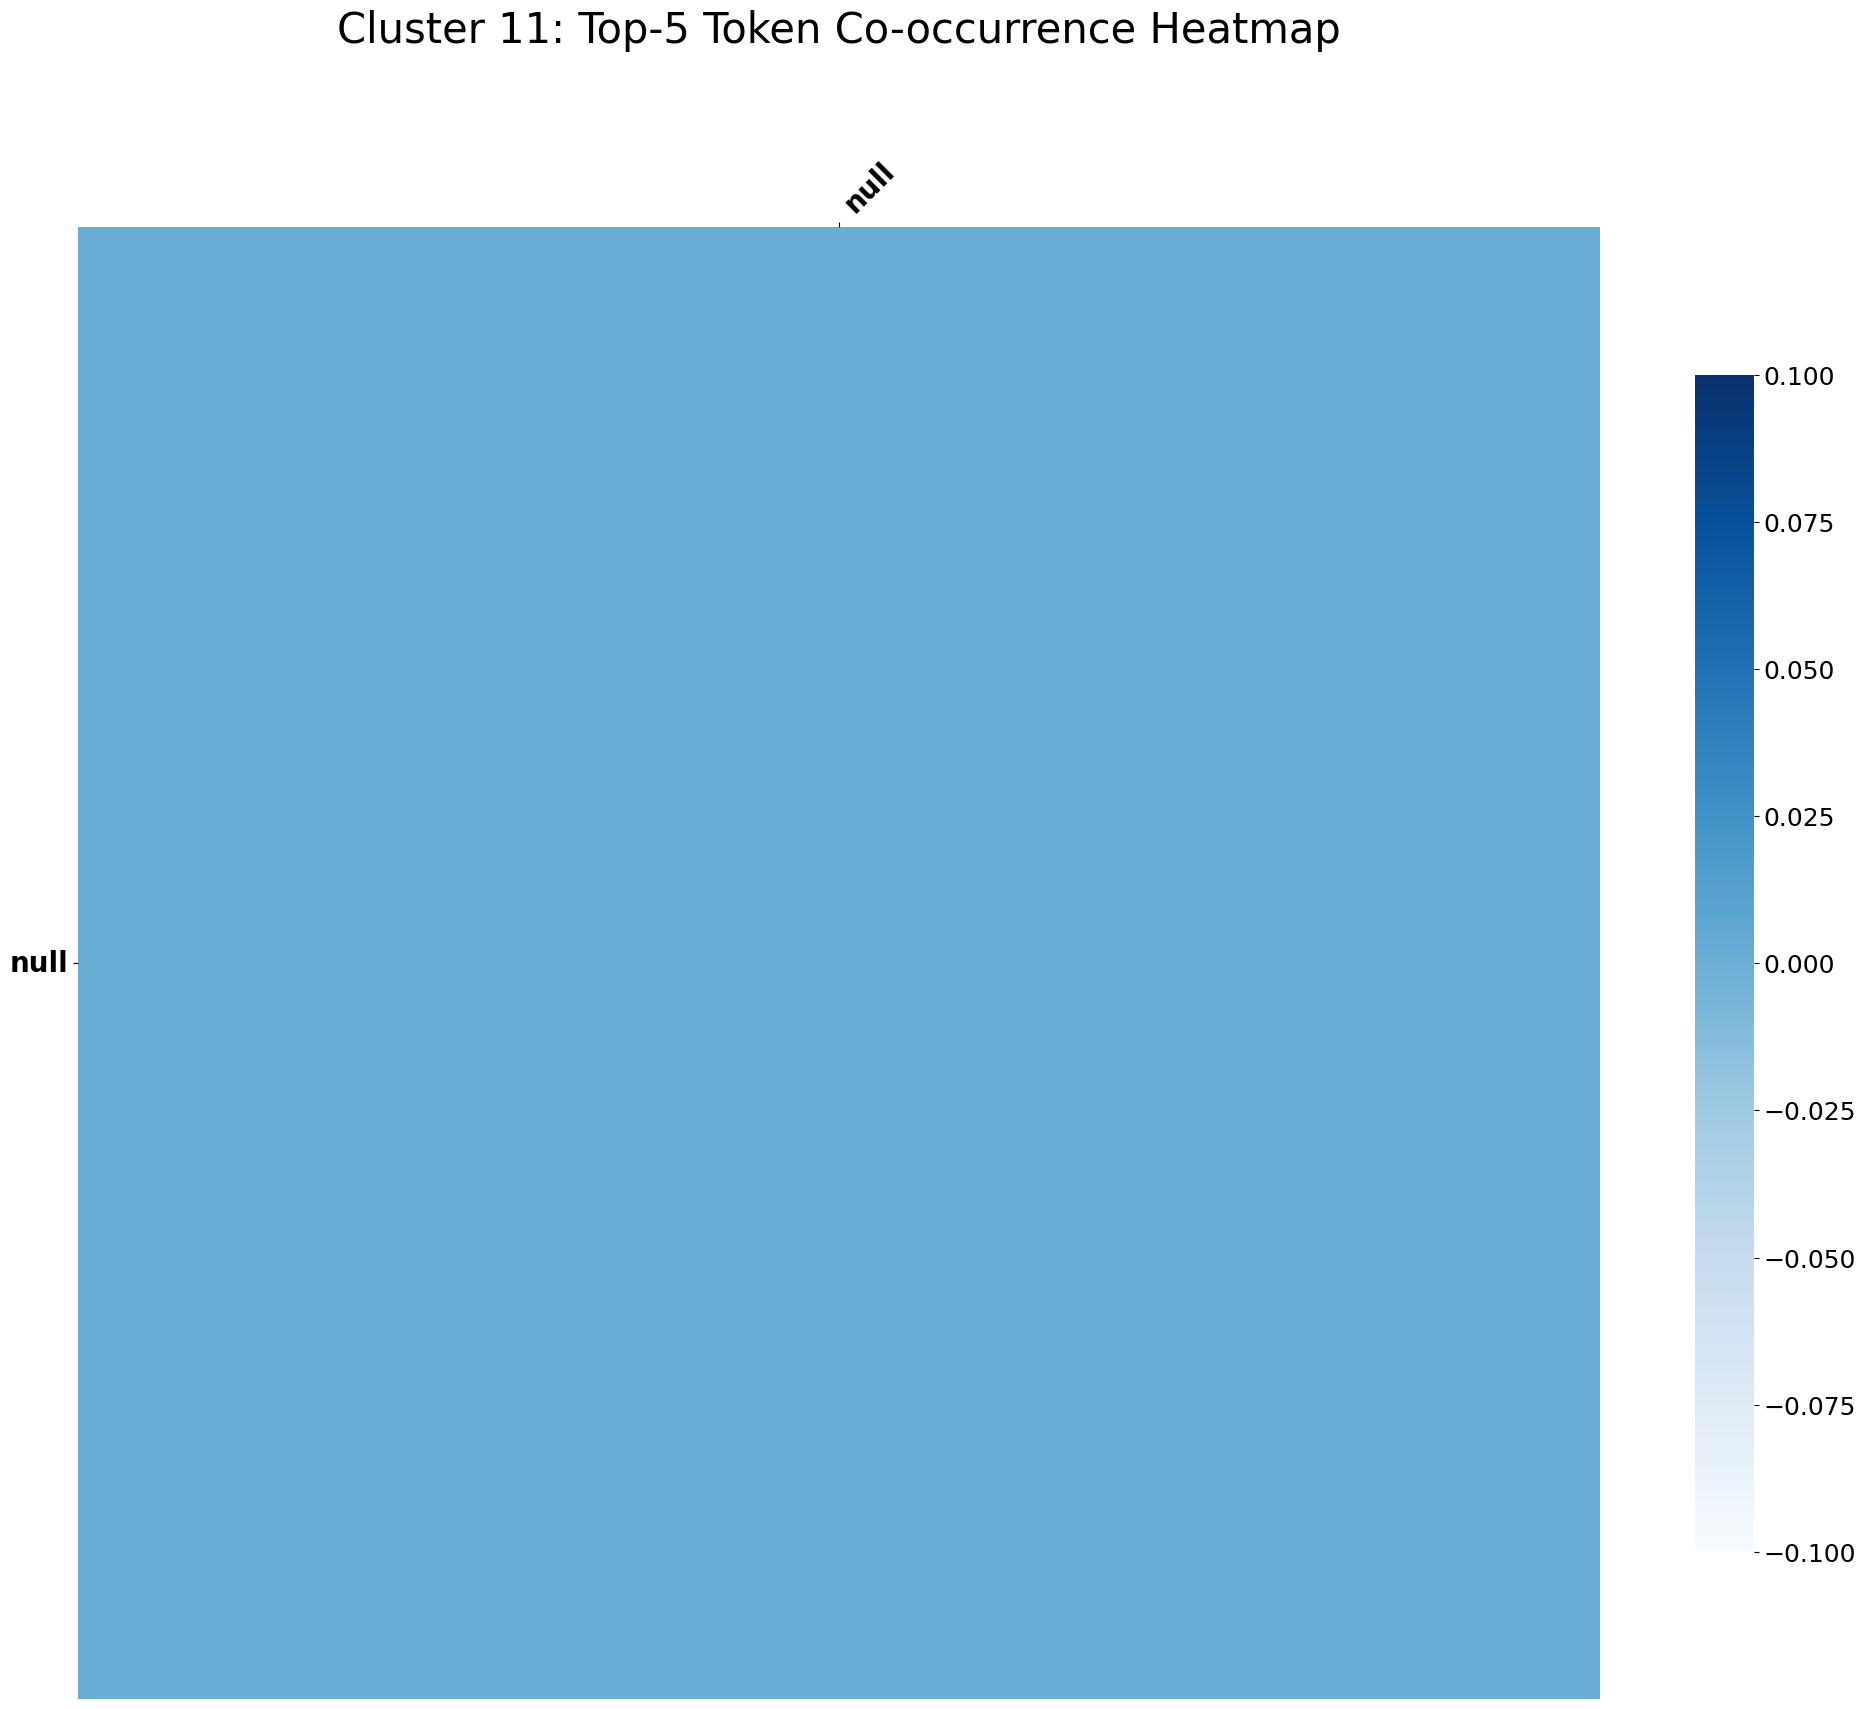

Discovered patterns for cluster 11 (Top-5): []

--- Co-occurrence Analysis for Top 10 Keywords ---


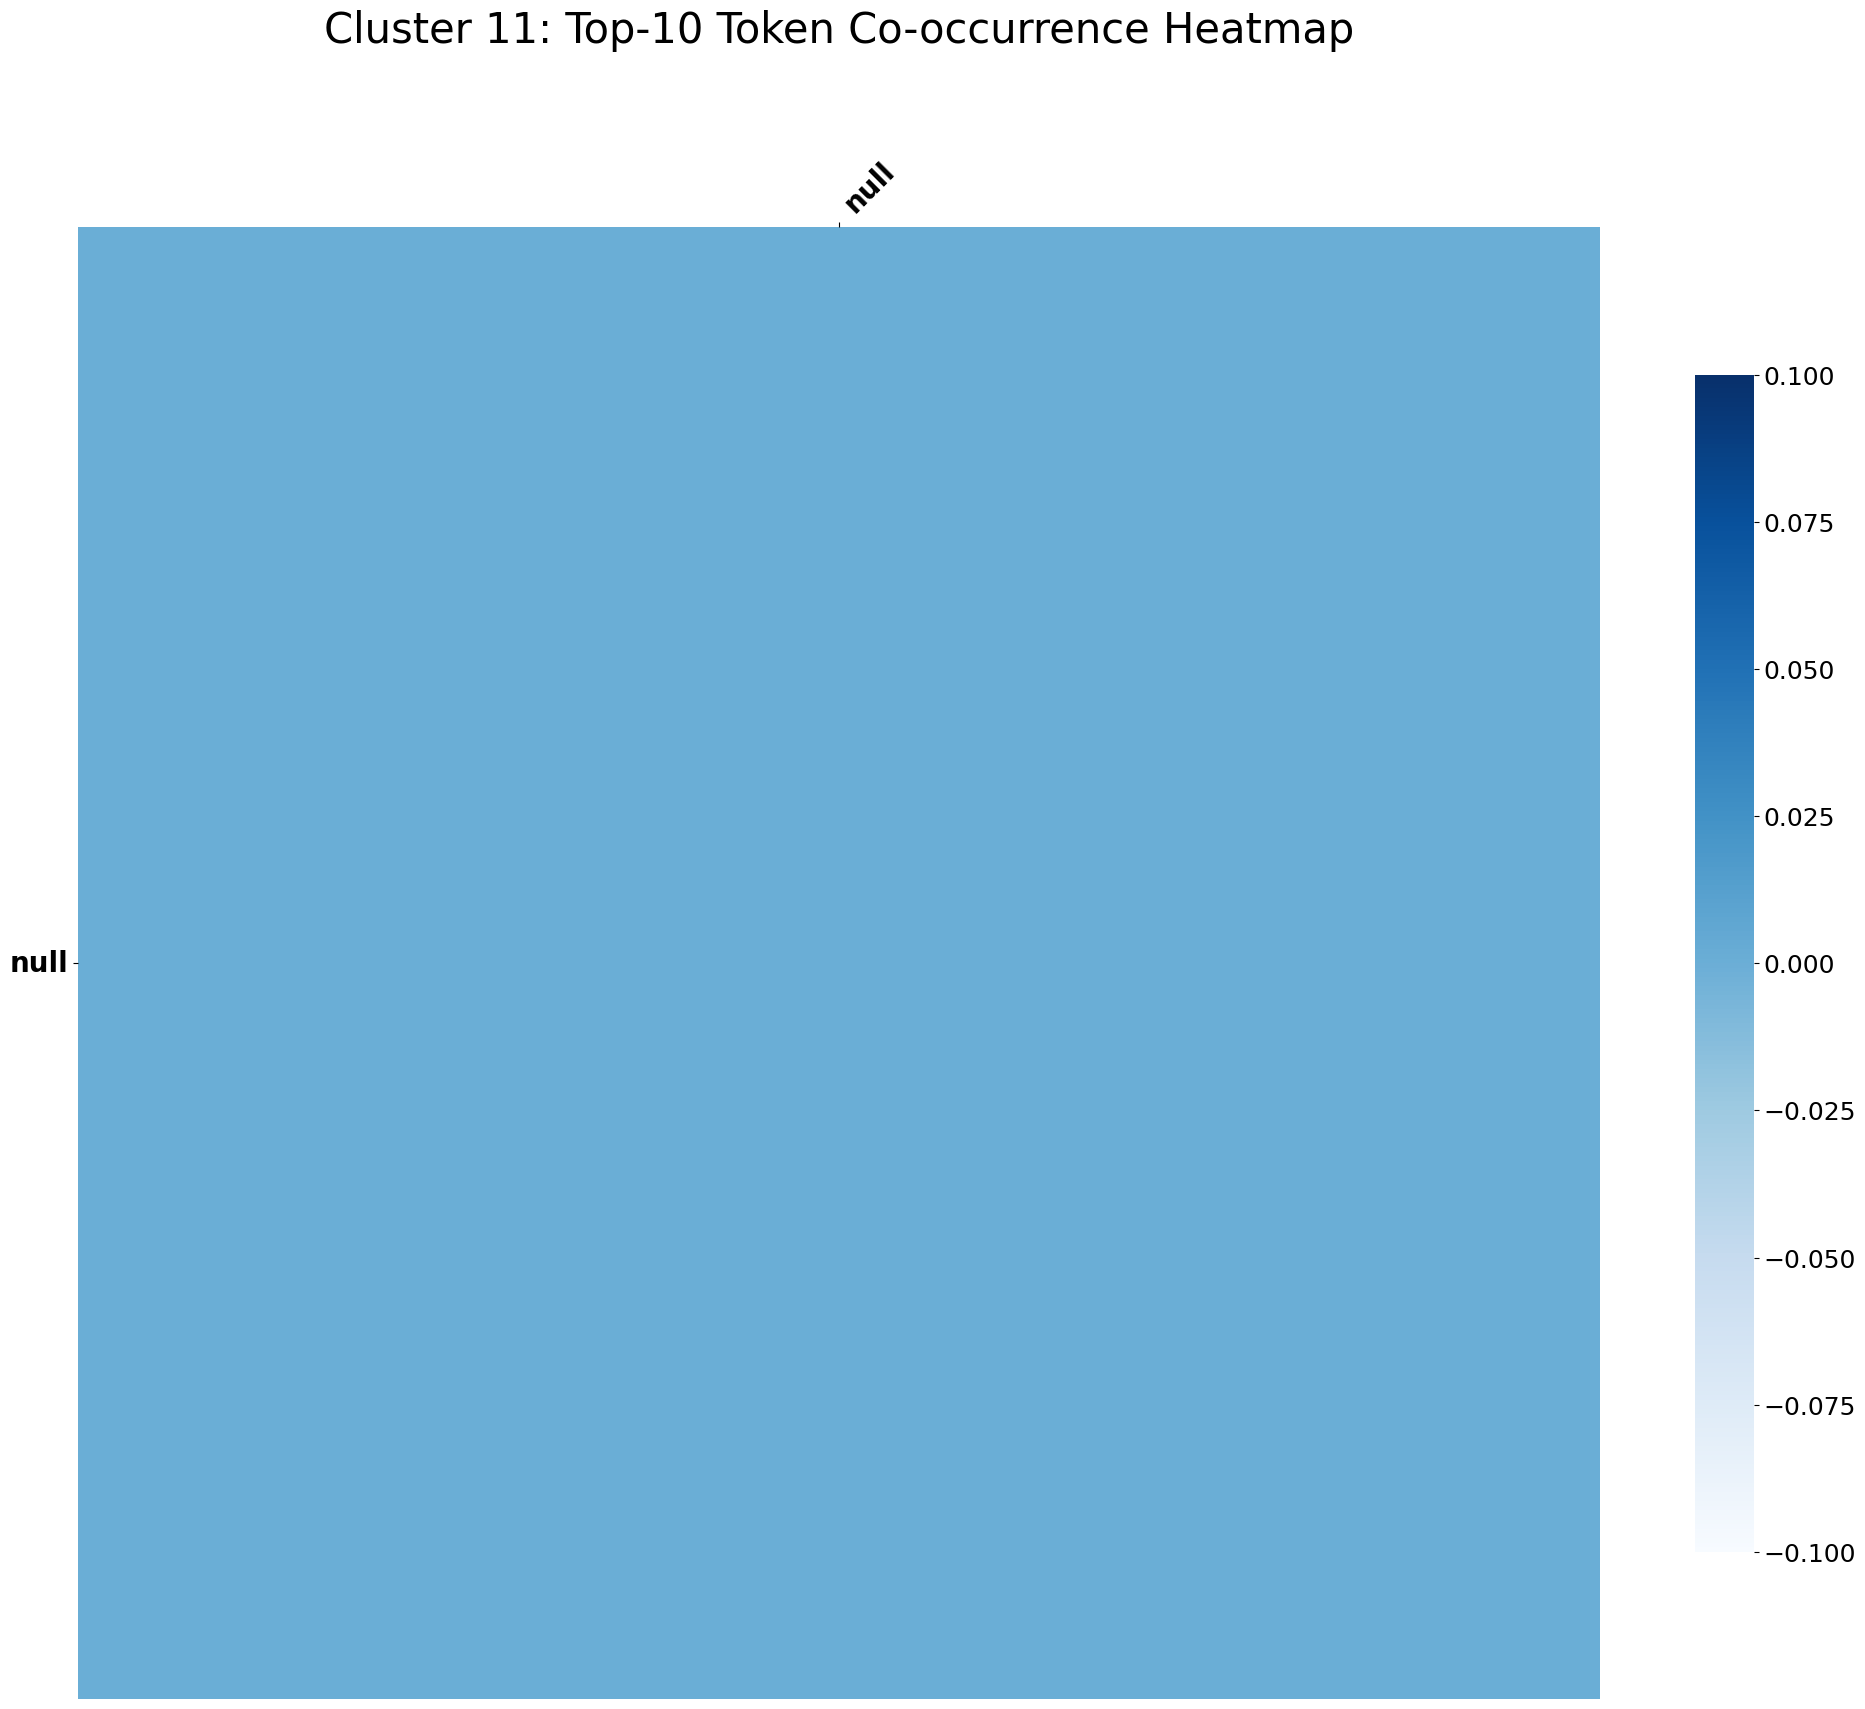

Discovered patterns for cluster 11 (Top-10): []

--- Co-occurrence Analysis for Top 20 Keywords ---


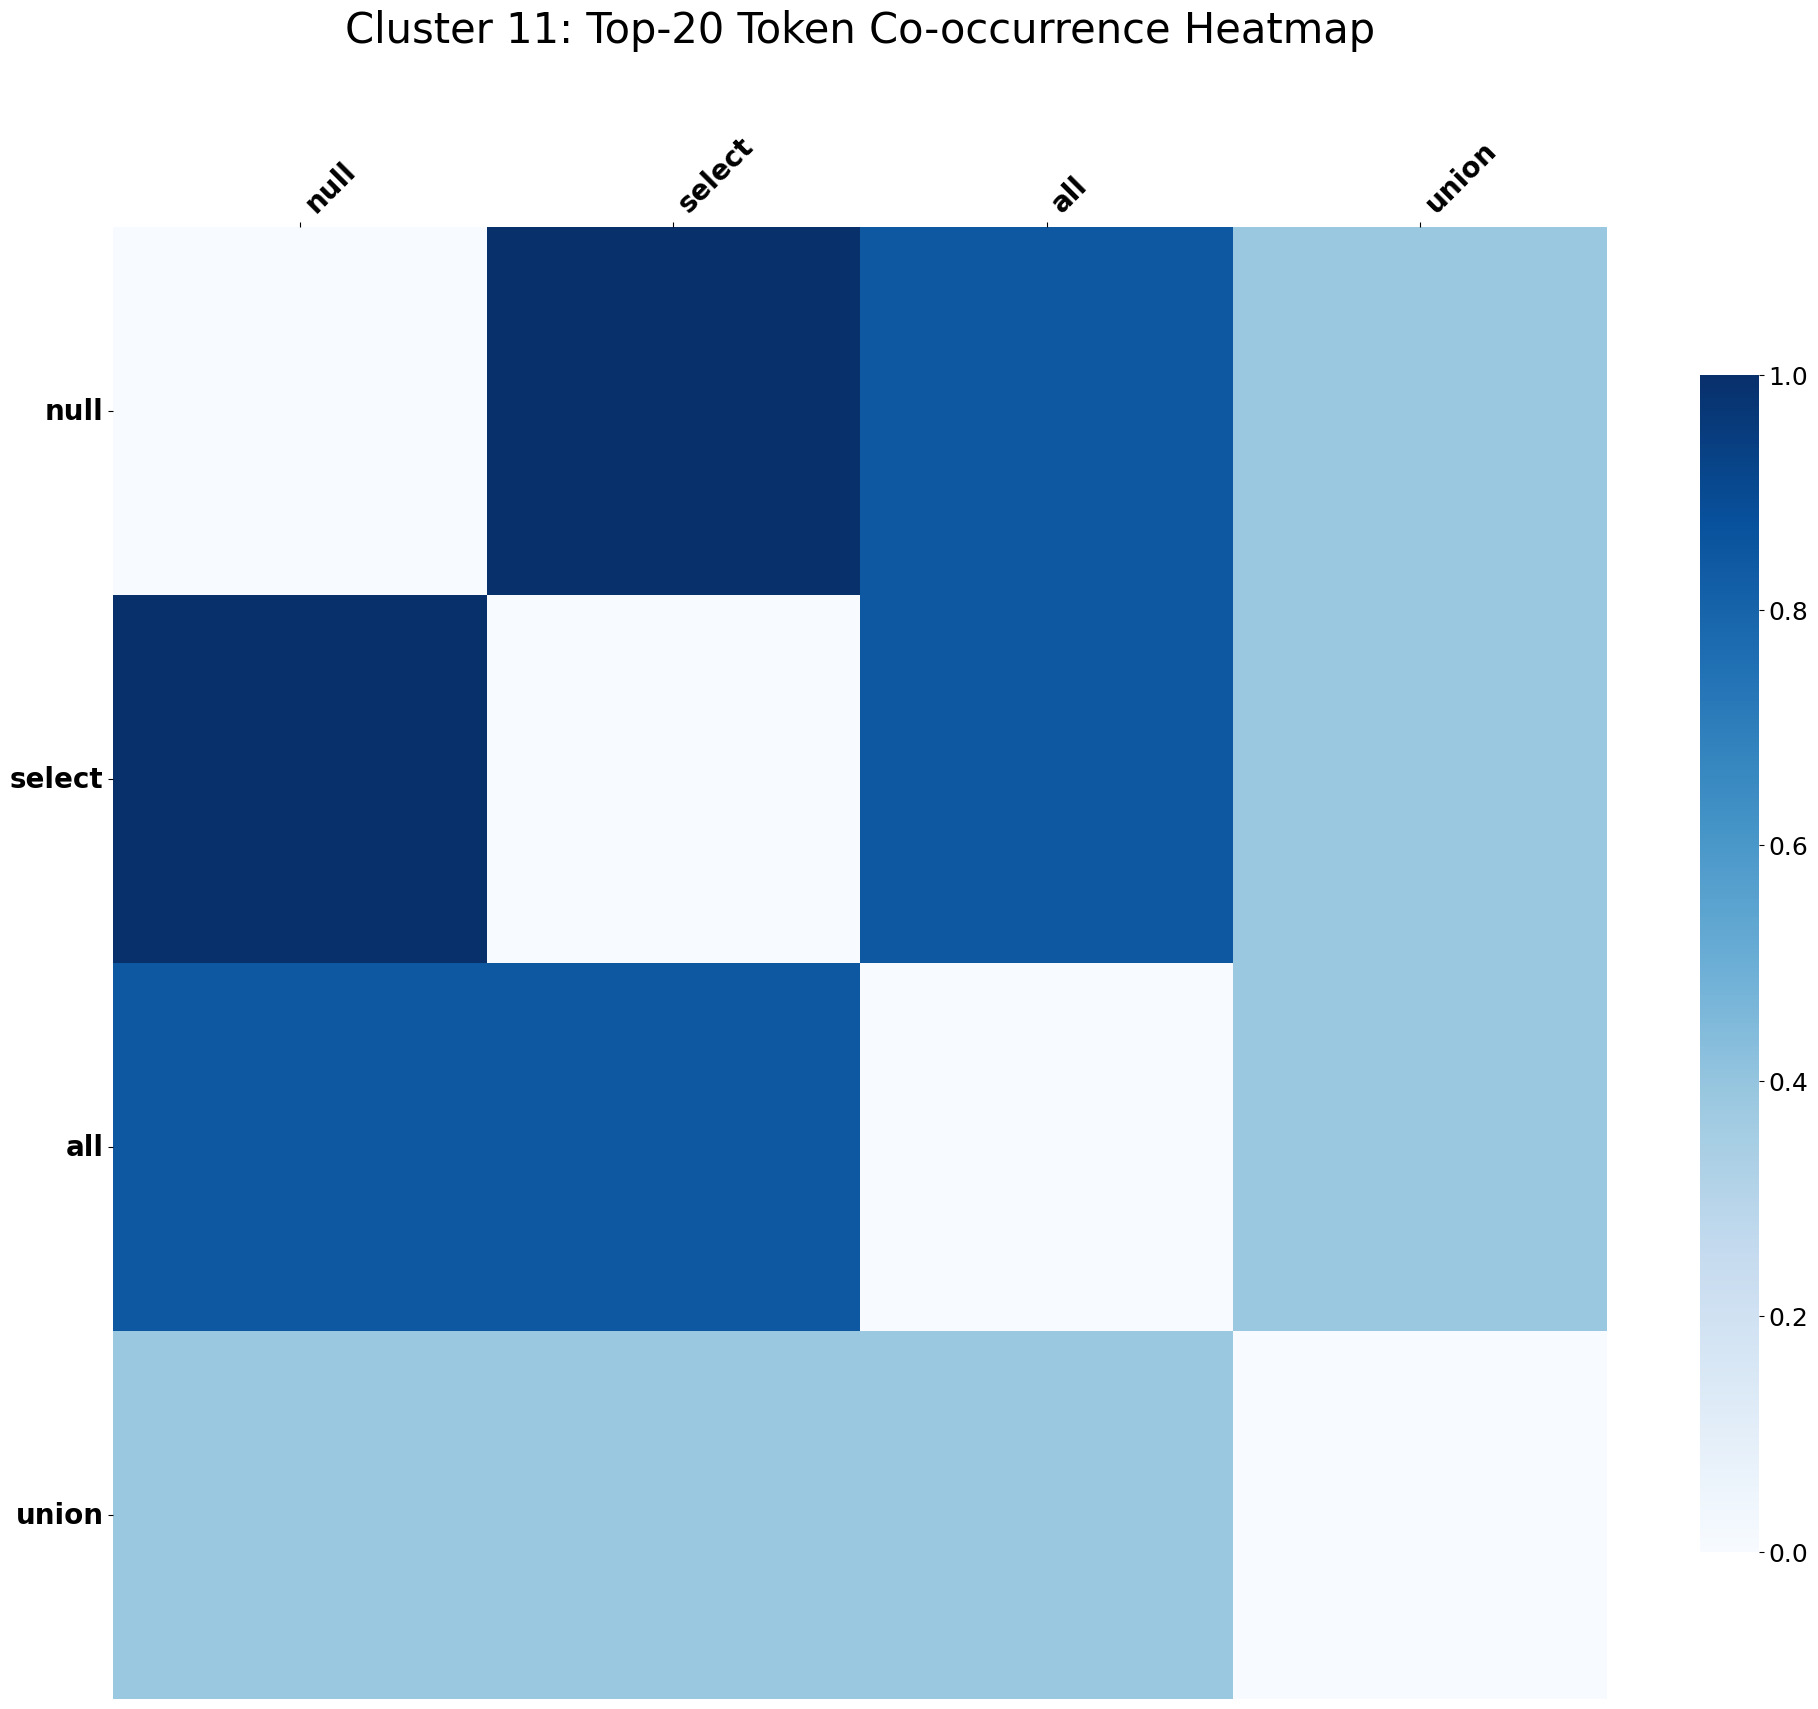

Discovered patterns for cluster 11 (Top-20): [['all', 'null', 'select']]

Processing Cluster 12...
Members in cluster 12: 31
 Top 10 words by TFIDF: ['char', 'chr', '83', '65', '69', 'quiz', 'substring', 'left', 'key', 'crypt']
shape of candidate sets: 31

--- Co-occurrence Analysis for Top 5 Keywords ---


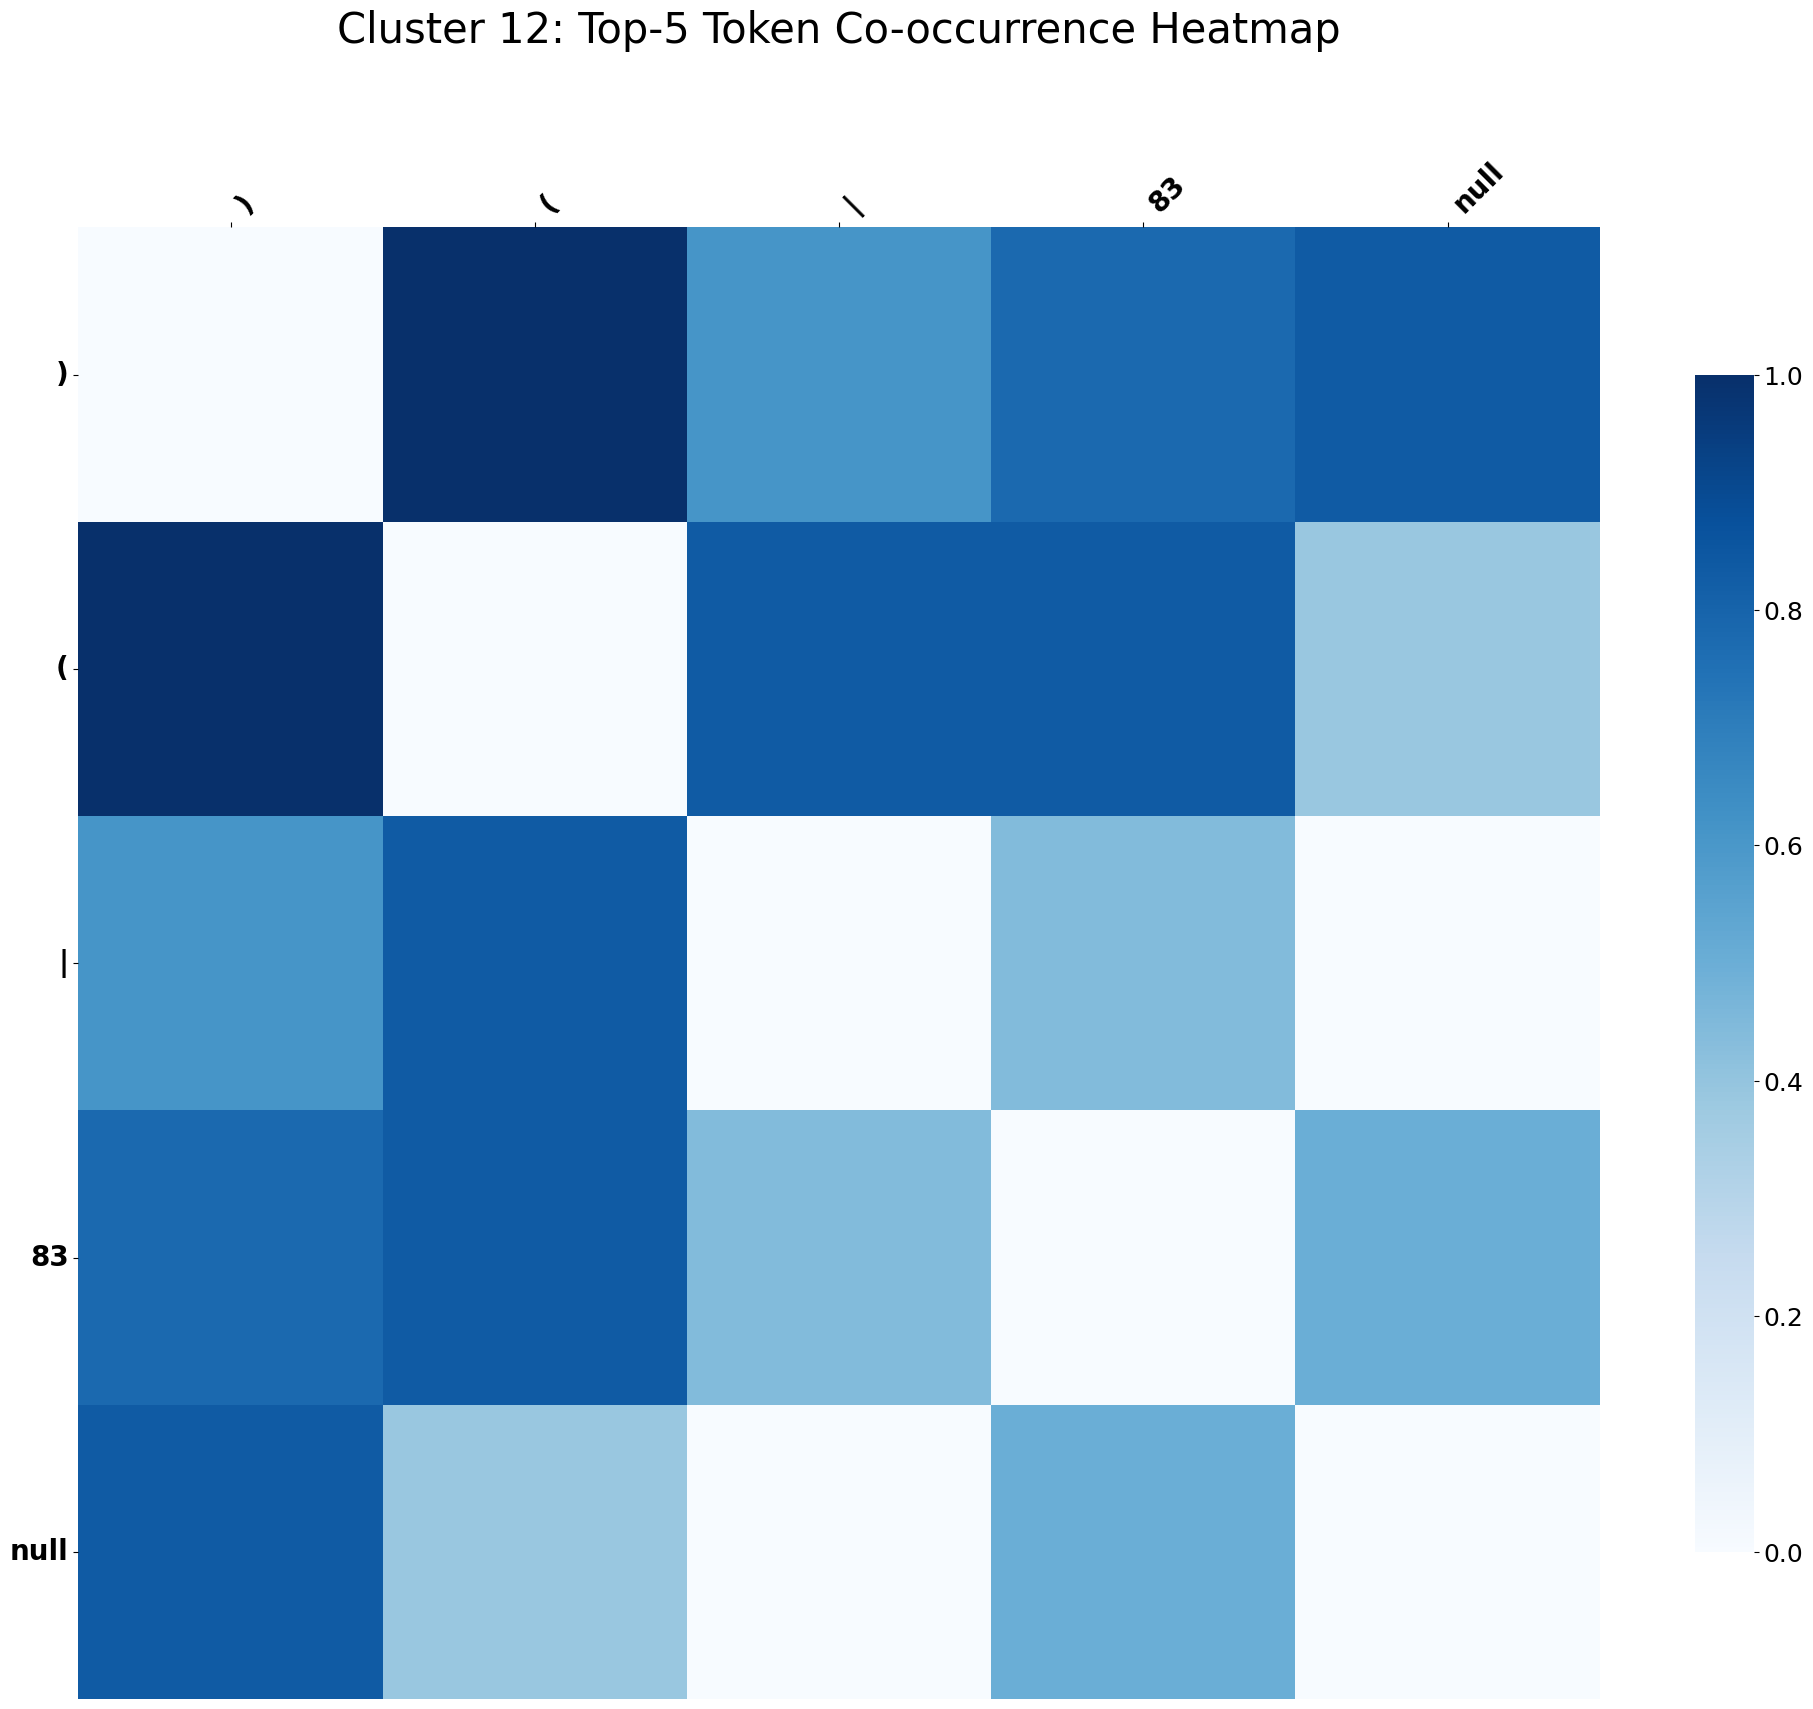

Discovered patterns for cluster 12 (Top-5): [['(', ')', '83', 'null', '|']]

--- Co-occurrence Analysis for Top 10 Keywords ---


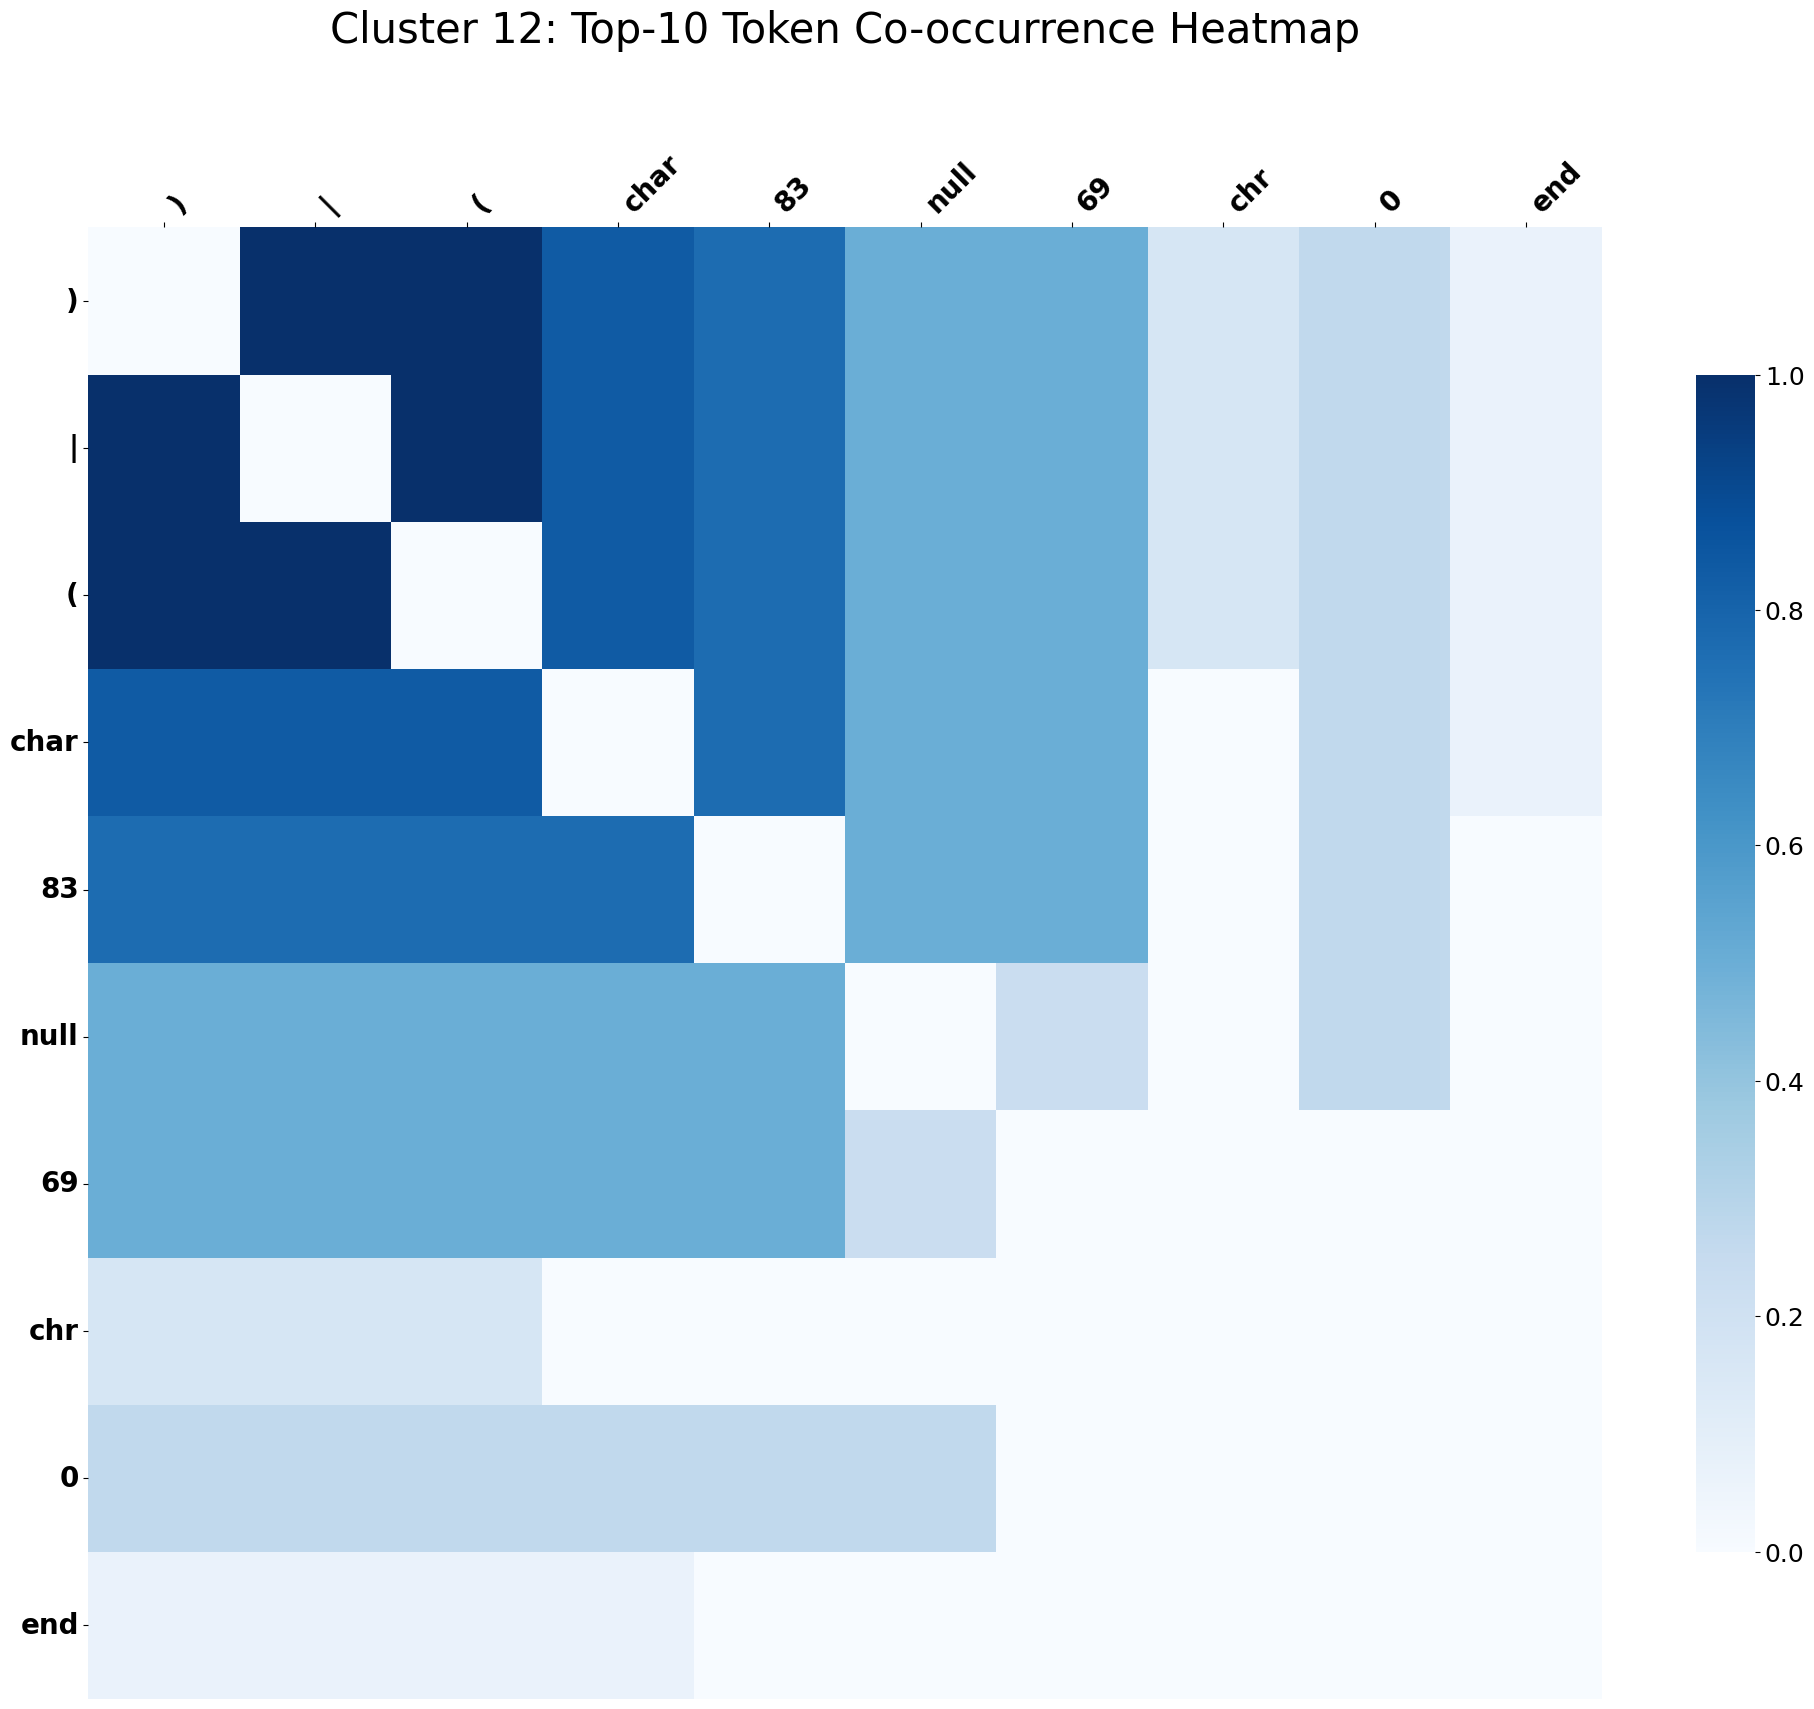

Discovered patterns for cluster 12 (Top-10): [['(', ')', '69', '83', 'char', 'null', '|']]

--- Co-occurrence Analysis for Top 20 Keywords ---


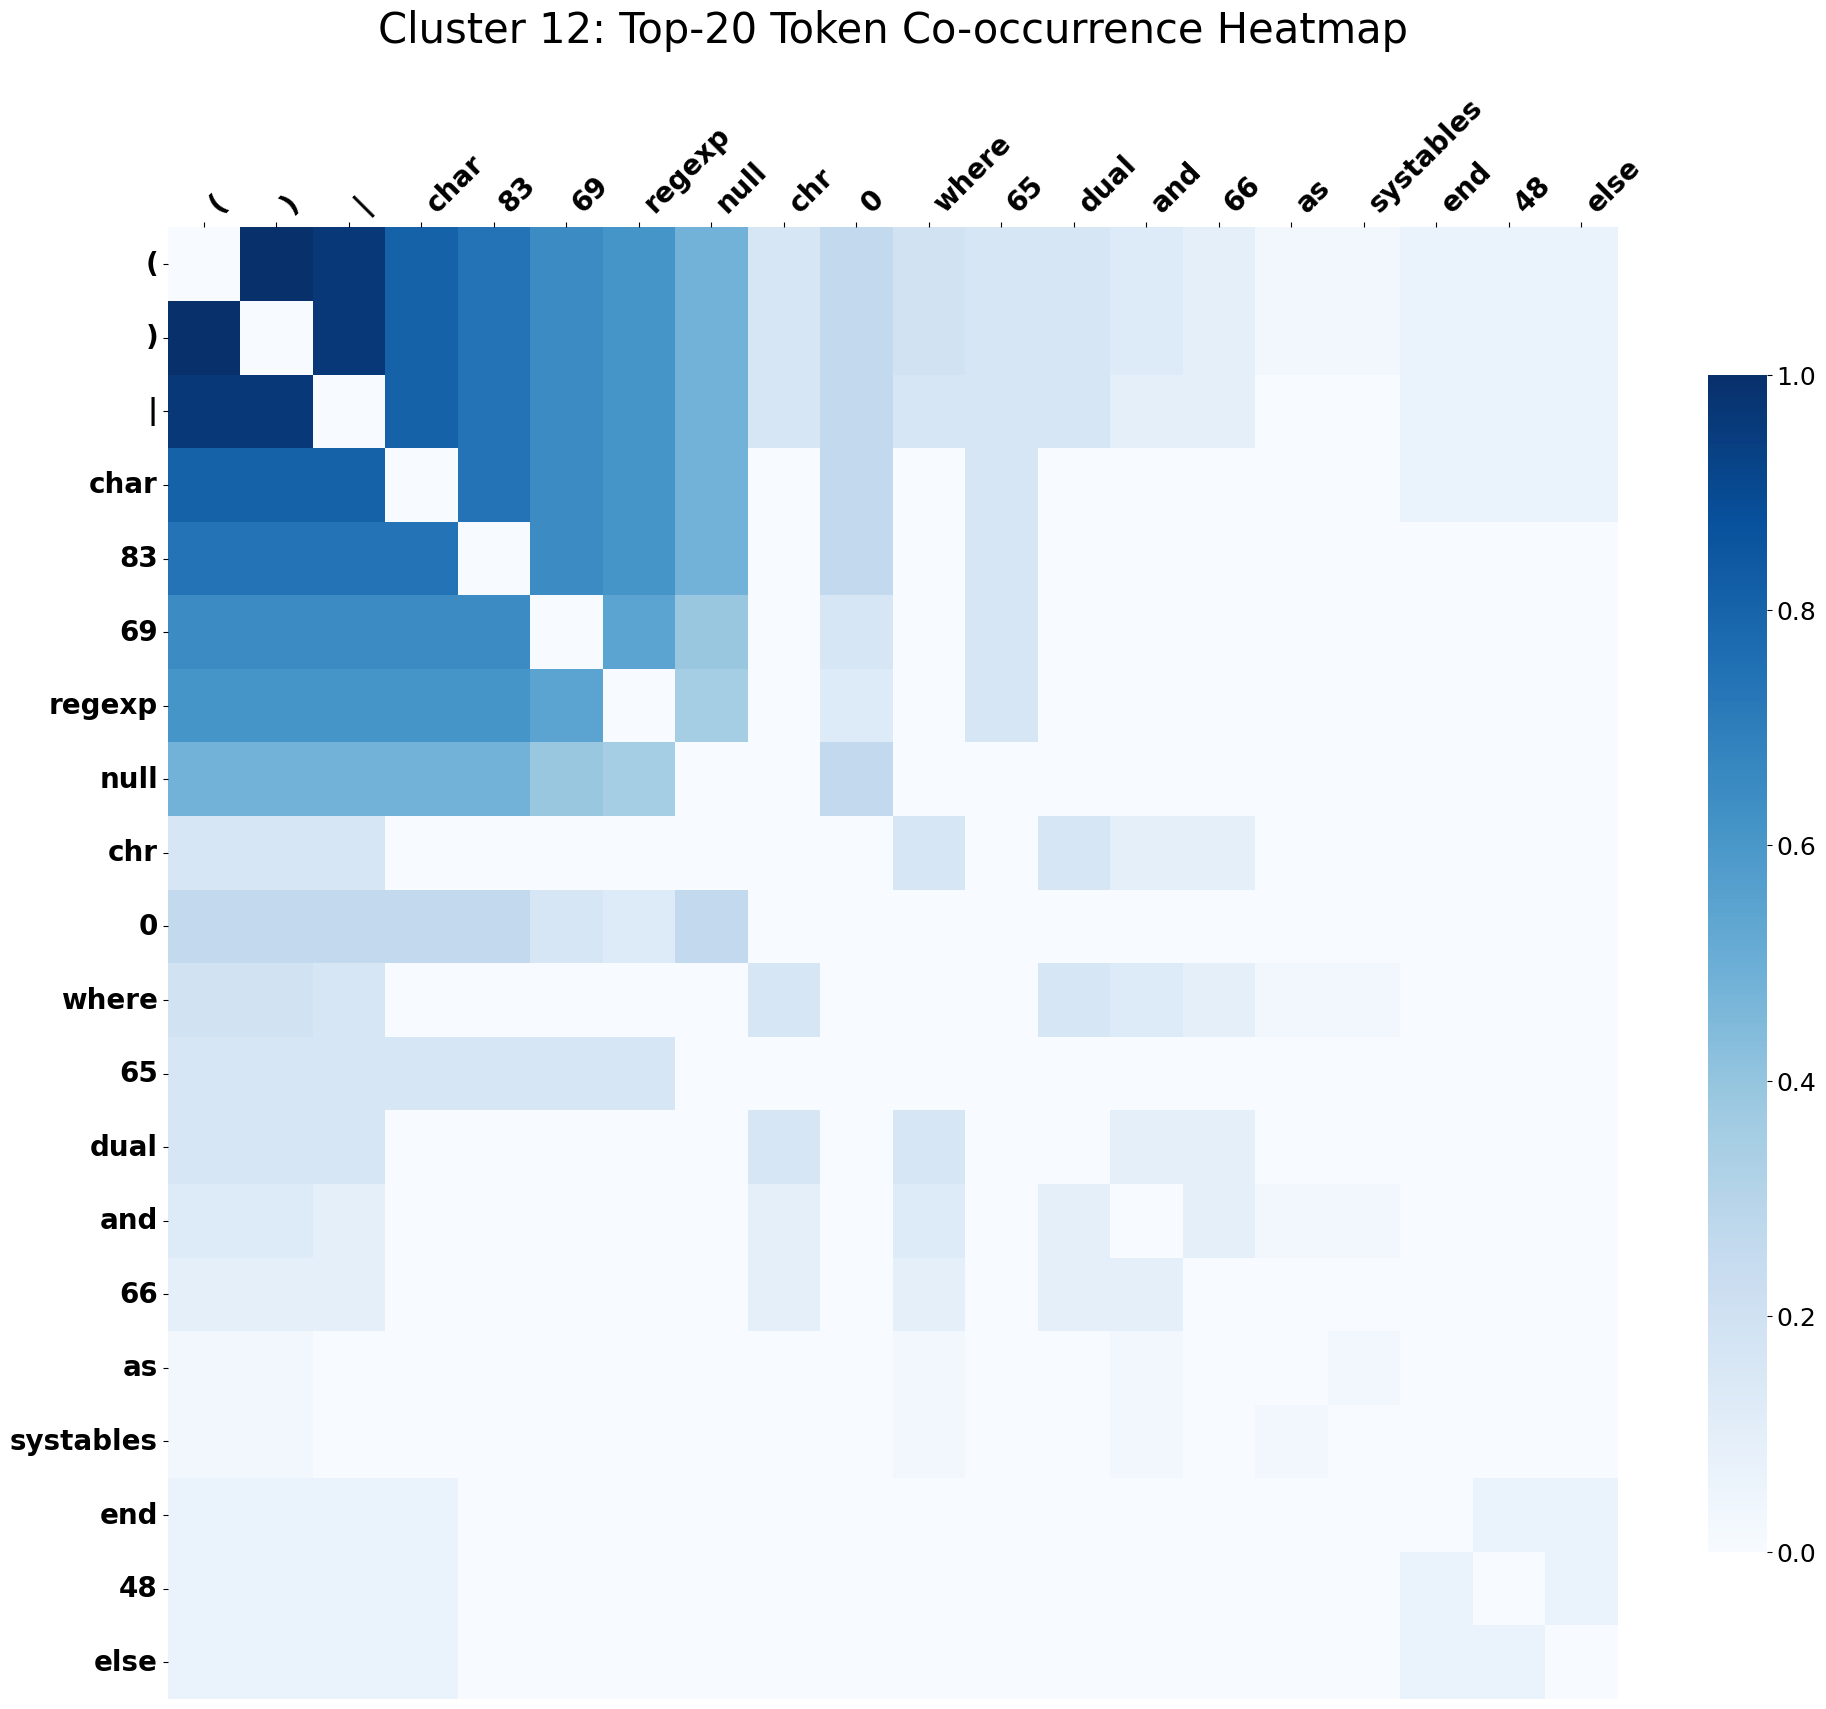

Discovered patterns for cluster 12 (Top-20): [['(', ')', '69', '83', 'char', 'null', 'regexp', '|']]

Processing Cluster 13...
Members in cluster 13: 16
 Top 10 words by TFIDF: ['char', 'chr', 'select', 'answer', 'question', 'pluginfile', '113836', 'from', 'where', 'or']
shape of candidate sets: 16

--- Co-occurrence Analysis for Top 5 Keywords ---


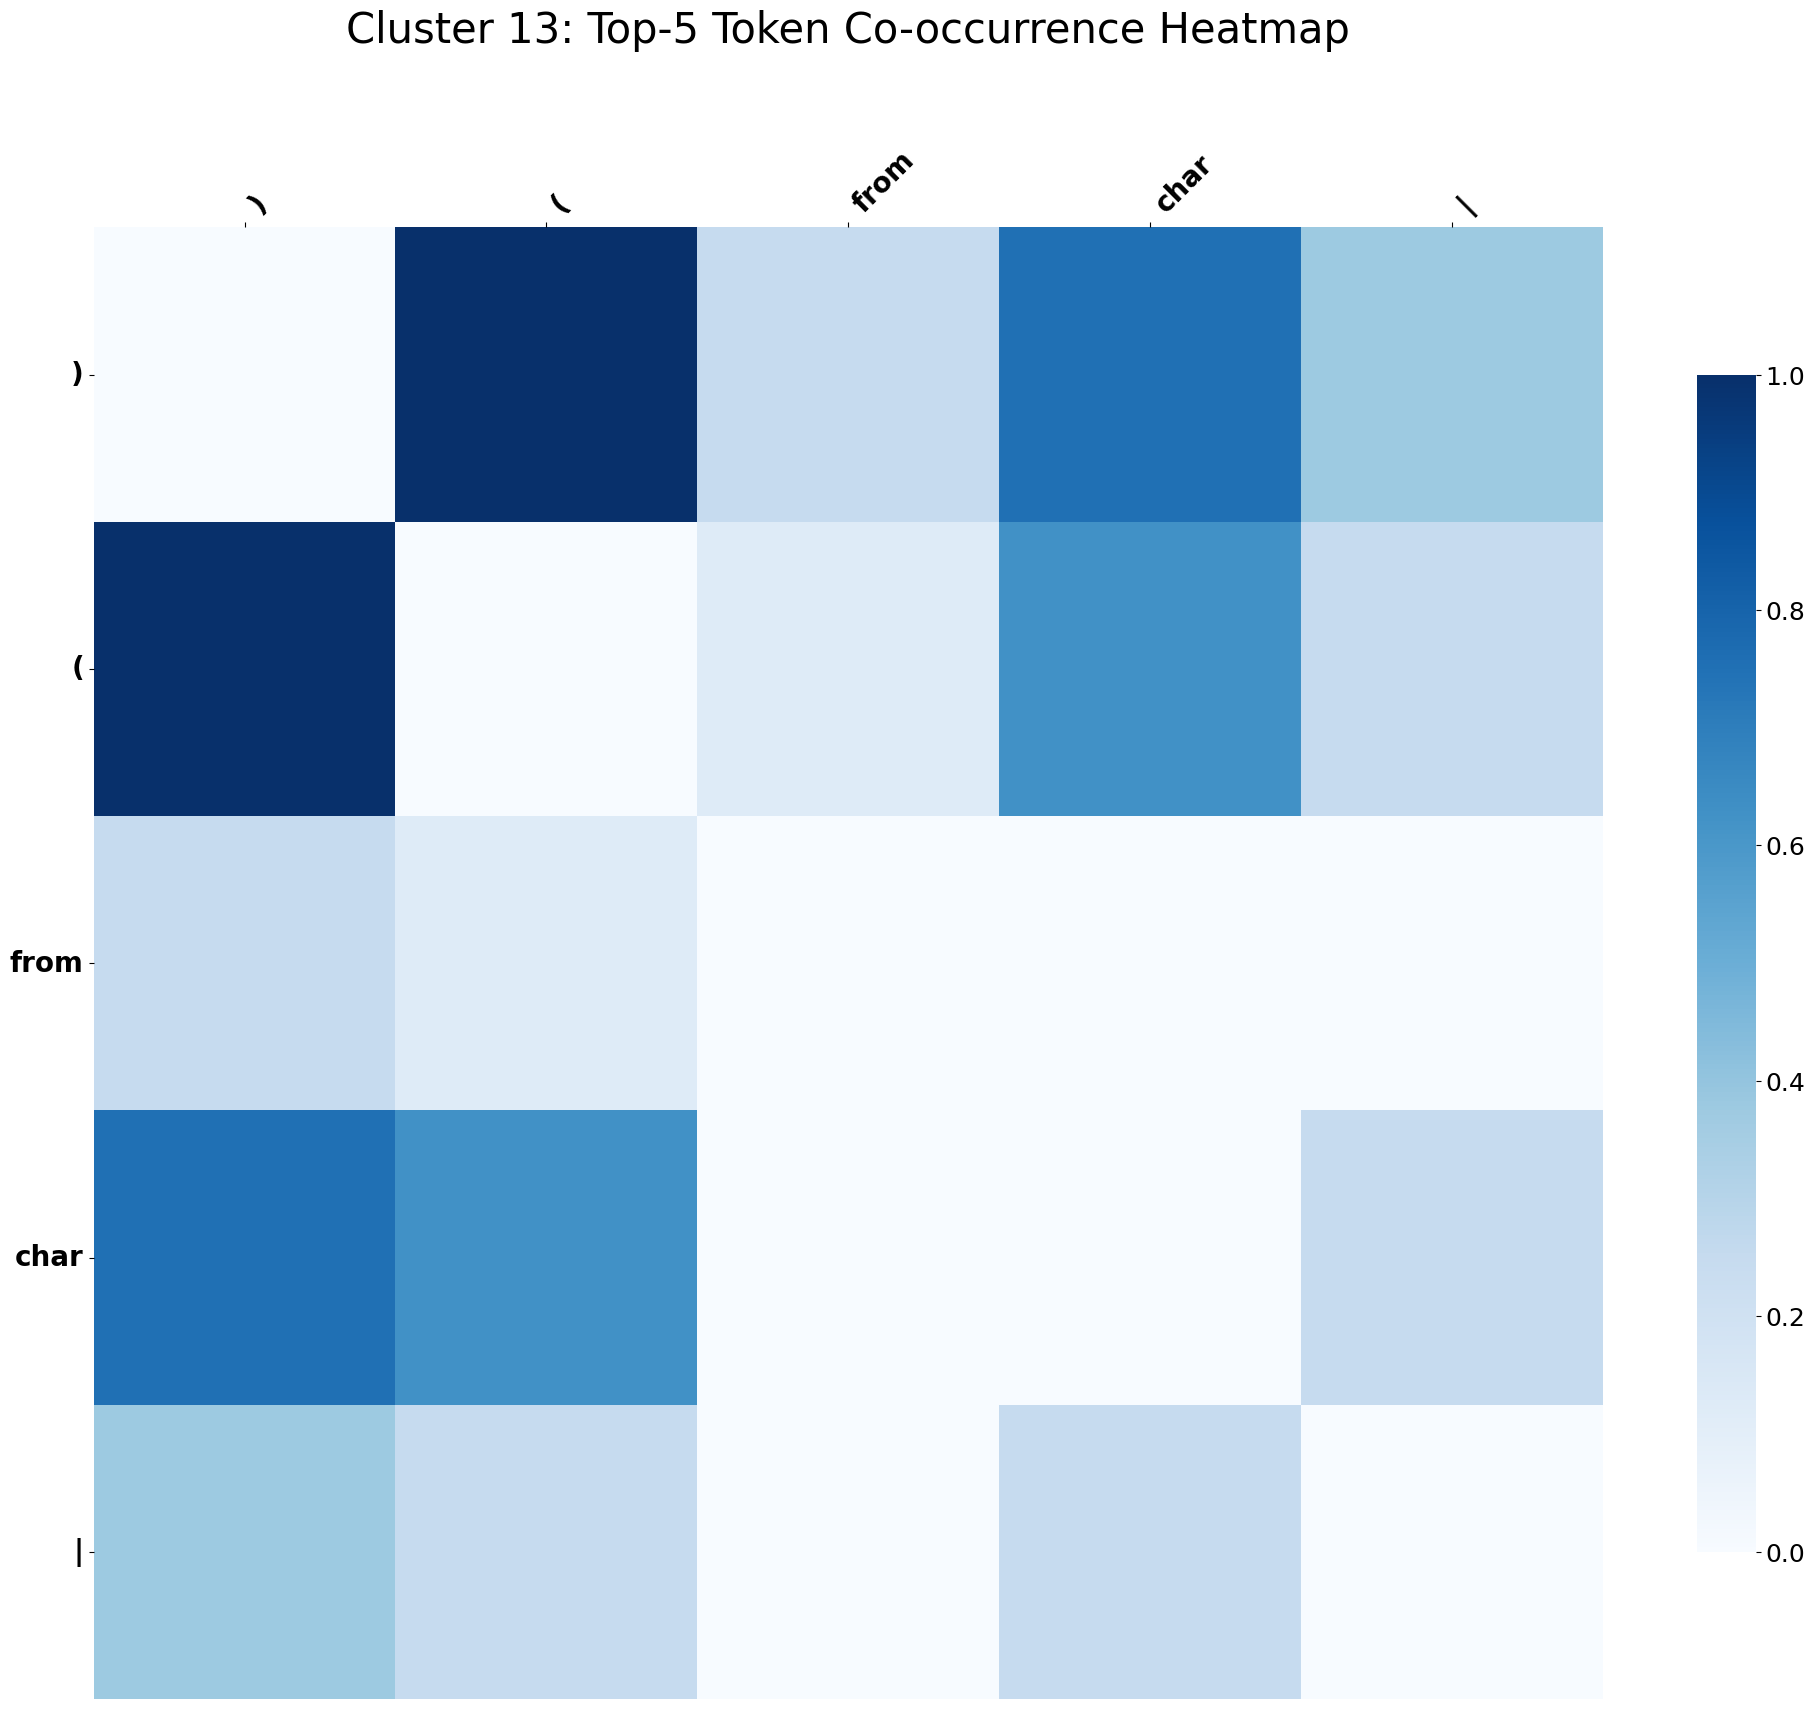

Discovered patterns for cluster 13 (Top-5): [['(', ')', 'char']]

--- Co-occurrence Analysis for Top 10 Keywords ---


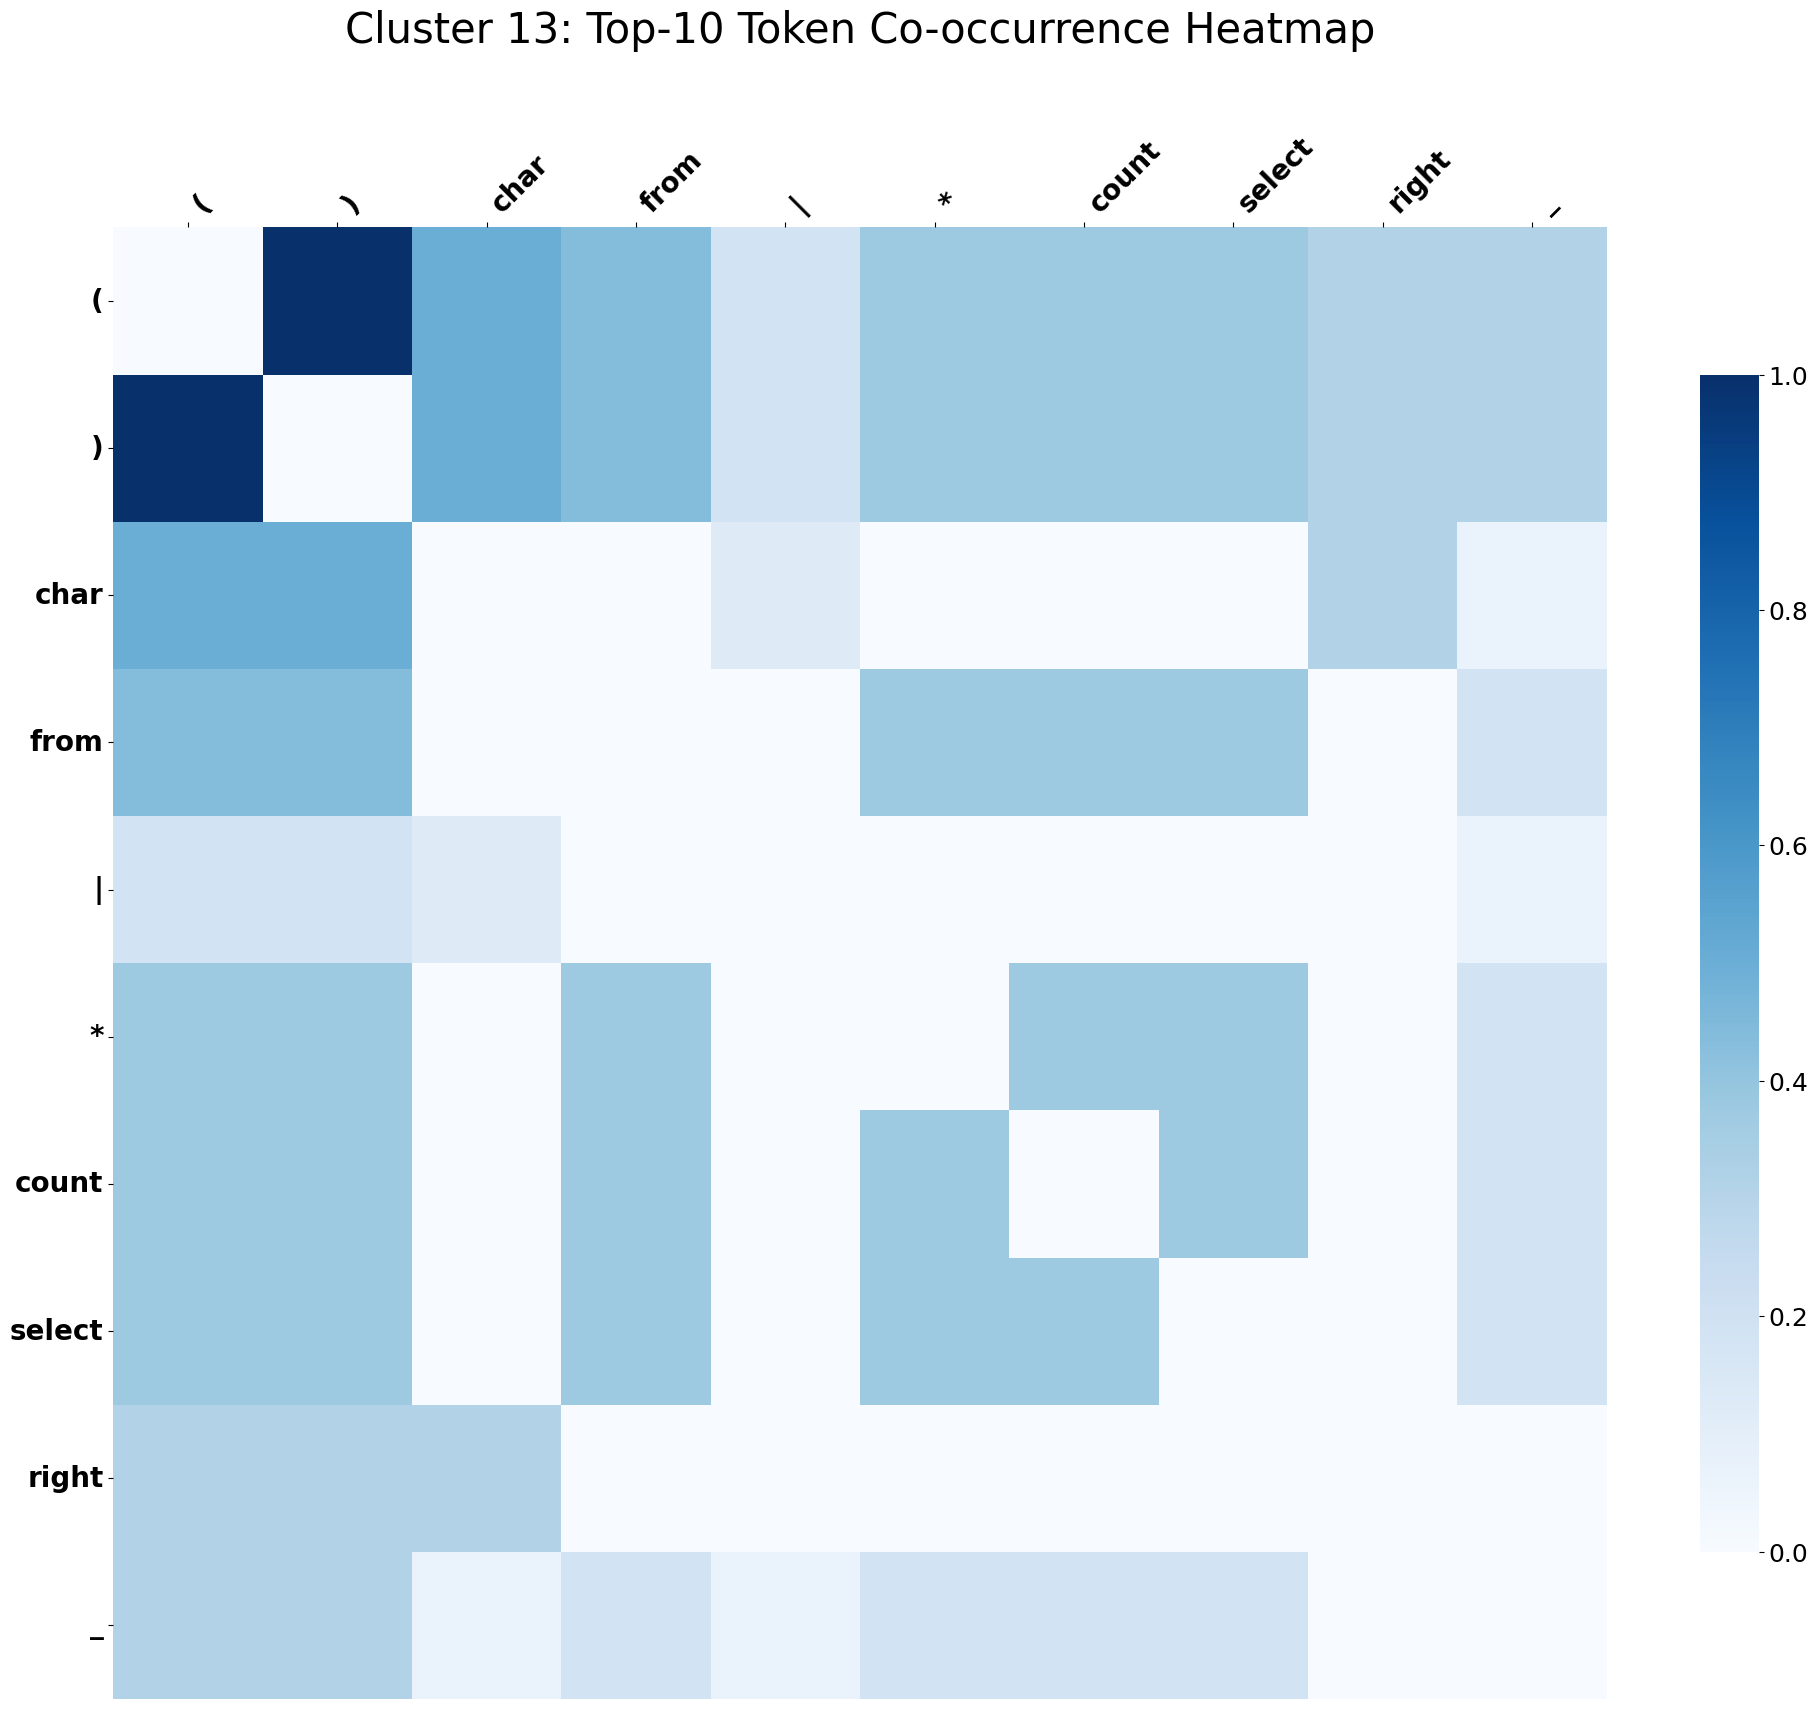

Discovered patterns for cluster 13 (Top-10): [['(', ')', 'char', 'from']]

--- Co-occurrence Analysis for Top 20 Keywords ---


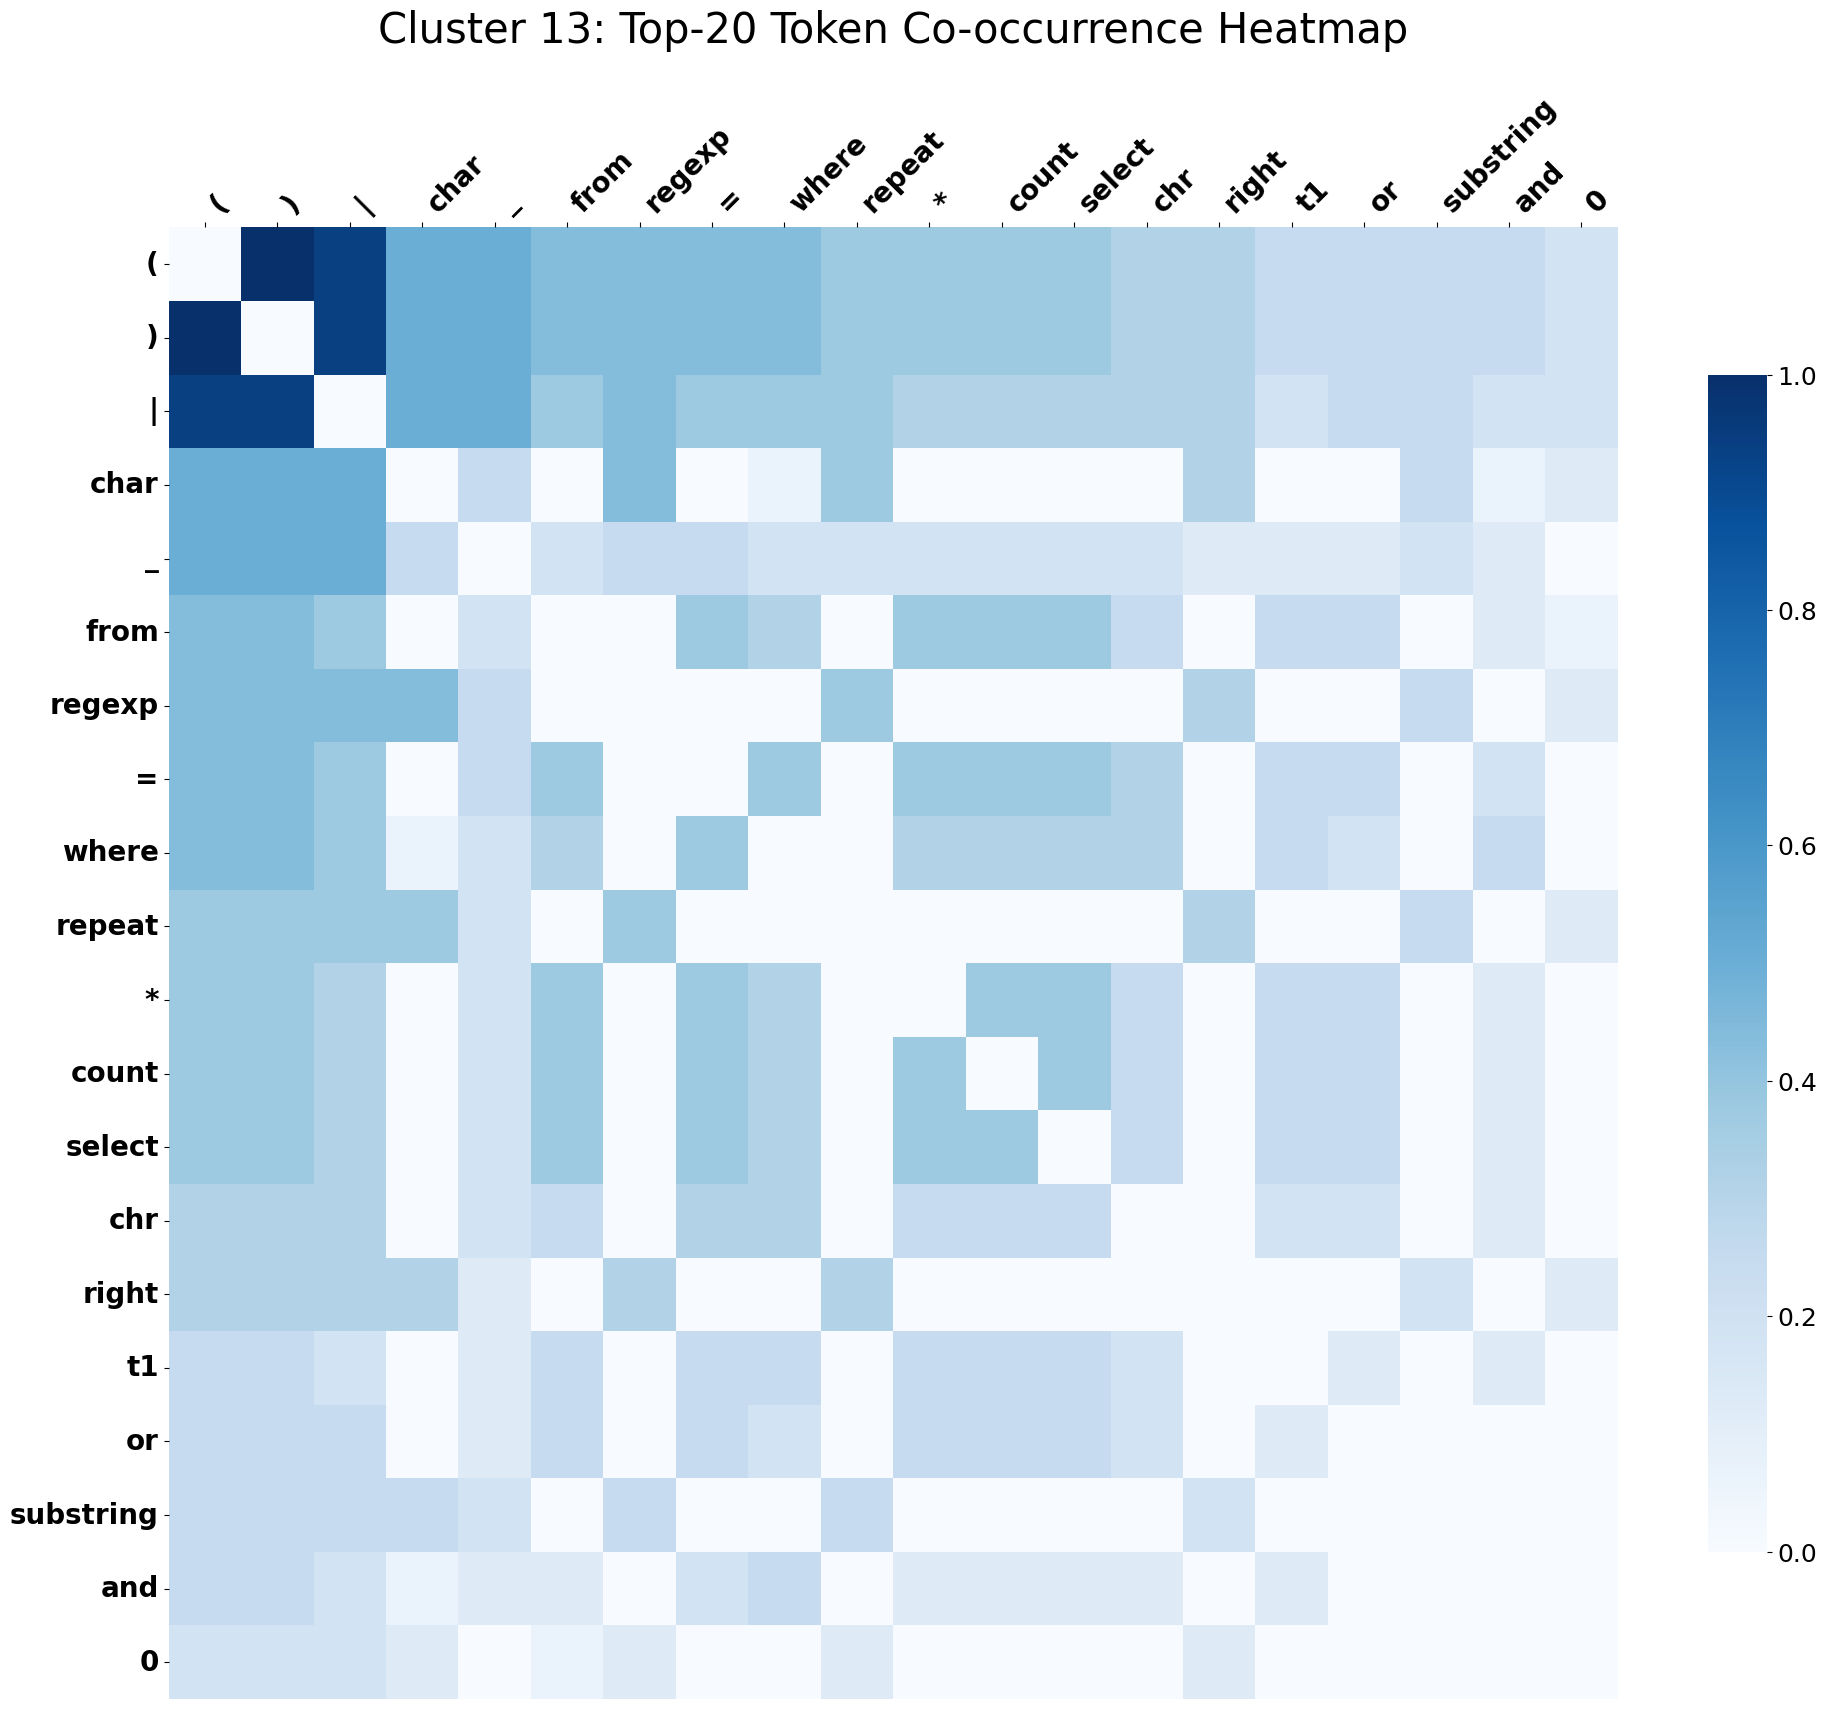

Discovered patterns for cluster 13 (Top-20): [['(', ')', '=', '_', 'char', 'from', 'regexp', 'where', '|']]

Processing Cluster 14...
Members in cluster 14: 10
 Top 10 words by TFIDF: ['union', 'all', 'select', 'pluginfile', '113836', 'question', 'answer', 'jpg', '3274', '16']
shape of candidate sets: 10

--- Co-occurrence Analysis for Top 5 Keywords ---


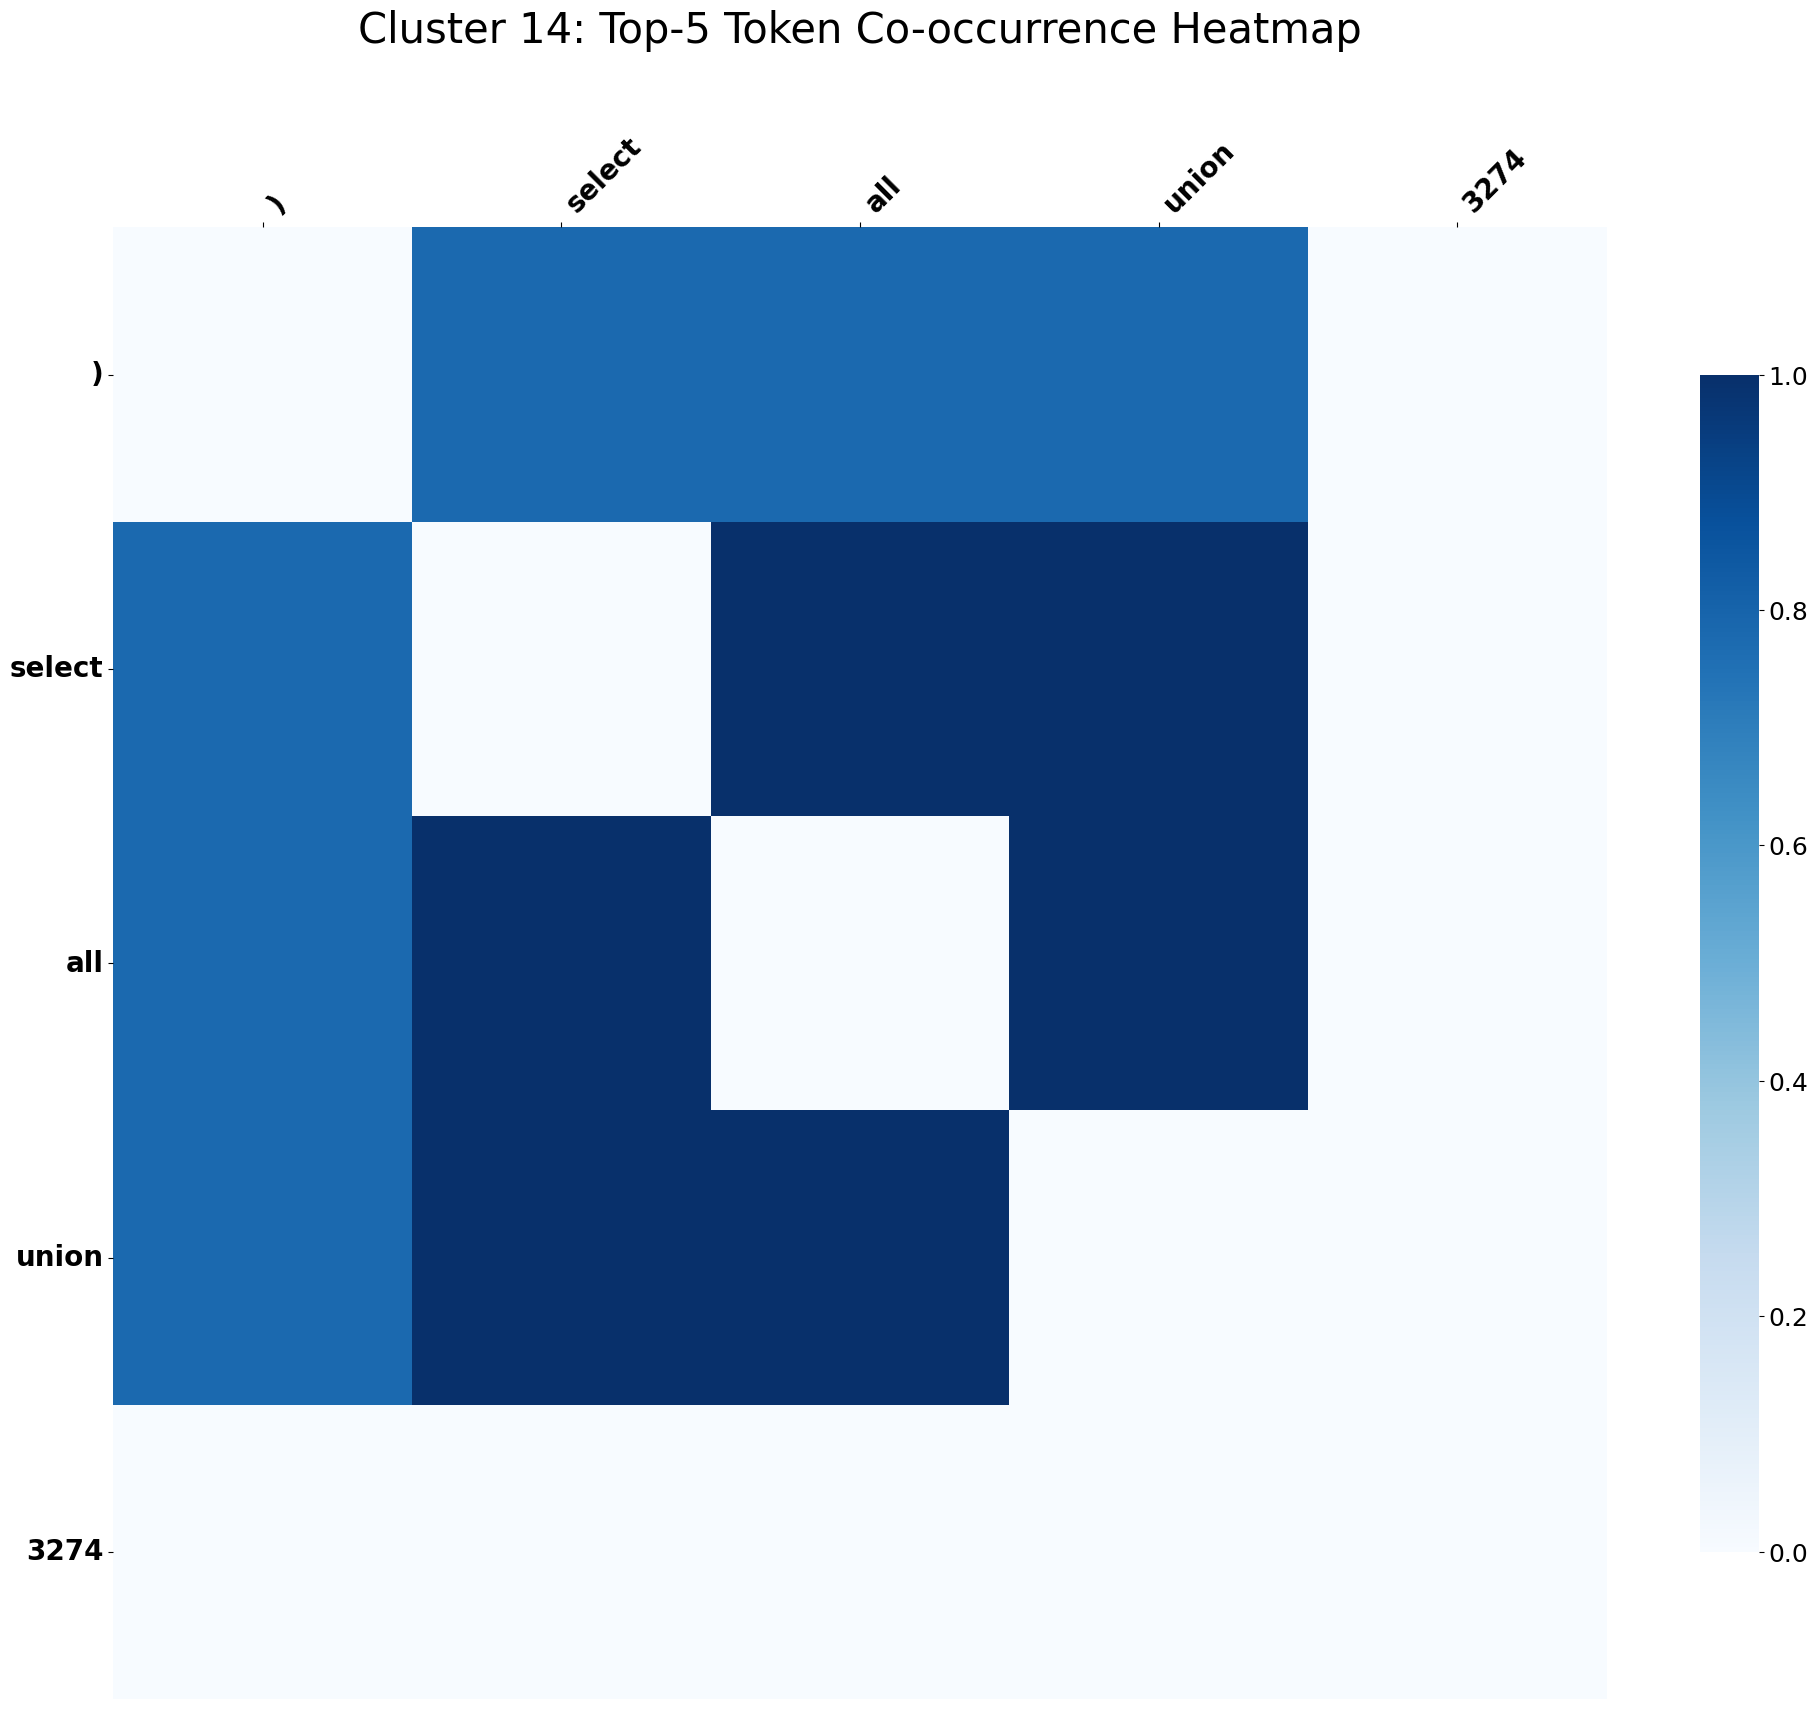

Discovered patterns for cluster 14 (Top-5): [[')', 'all', 'select', 'union']]

--- Co-occurrence Analysis for Top 10 Keywords ---


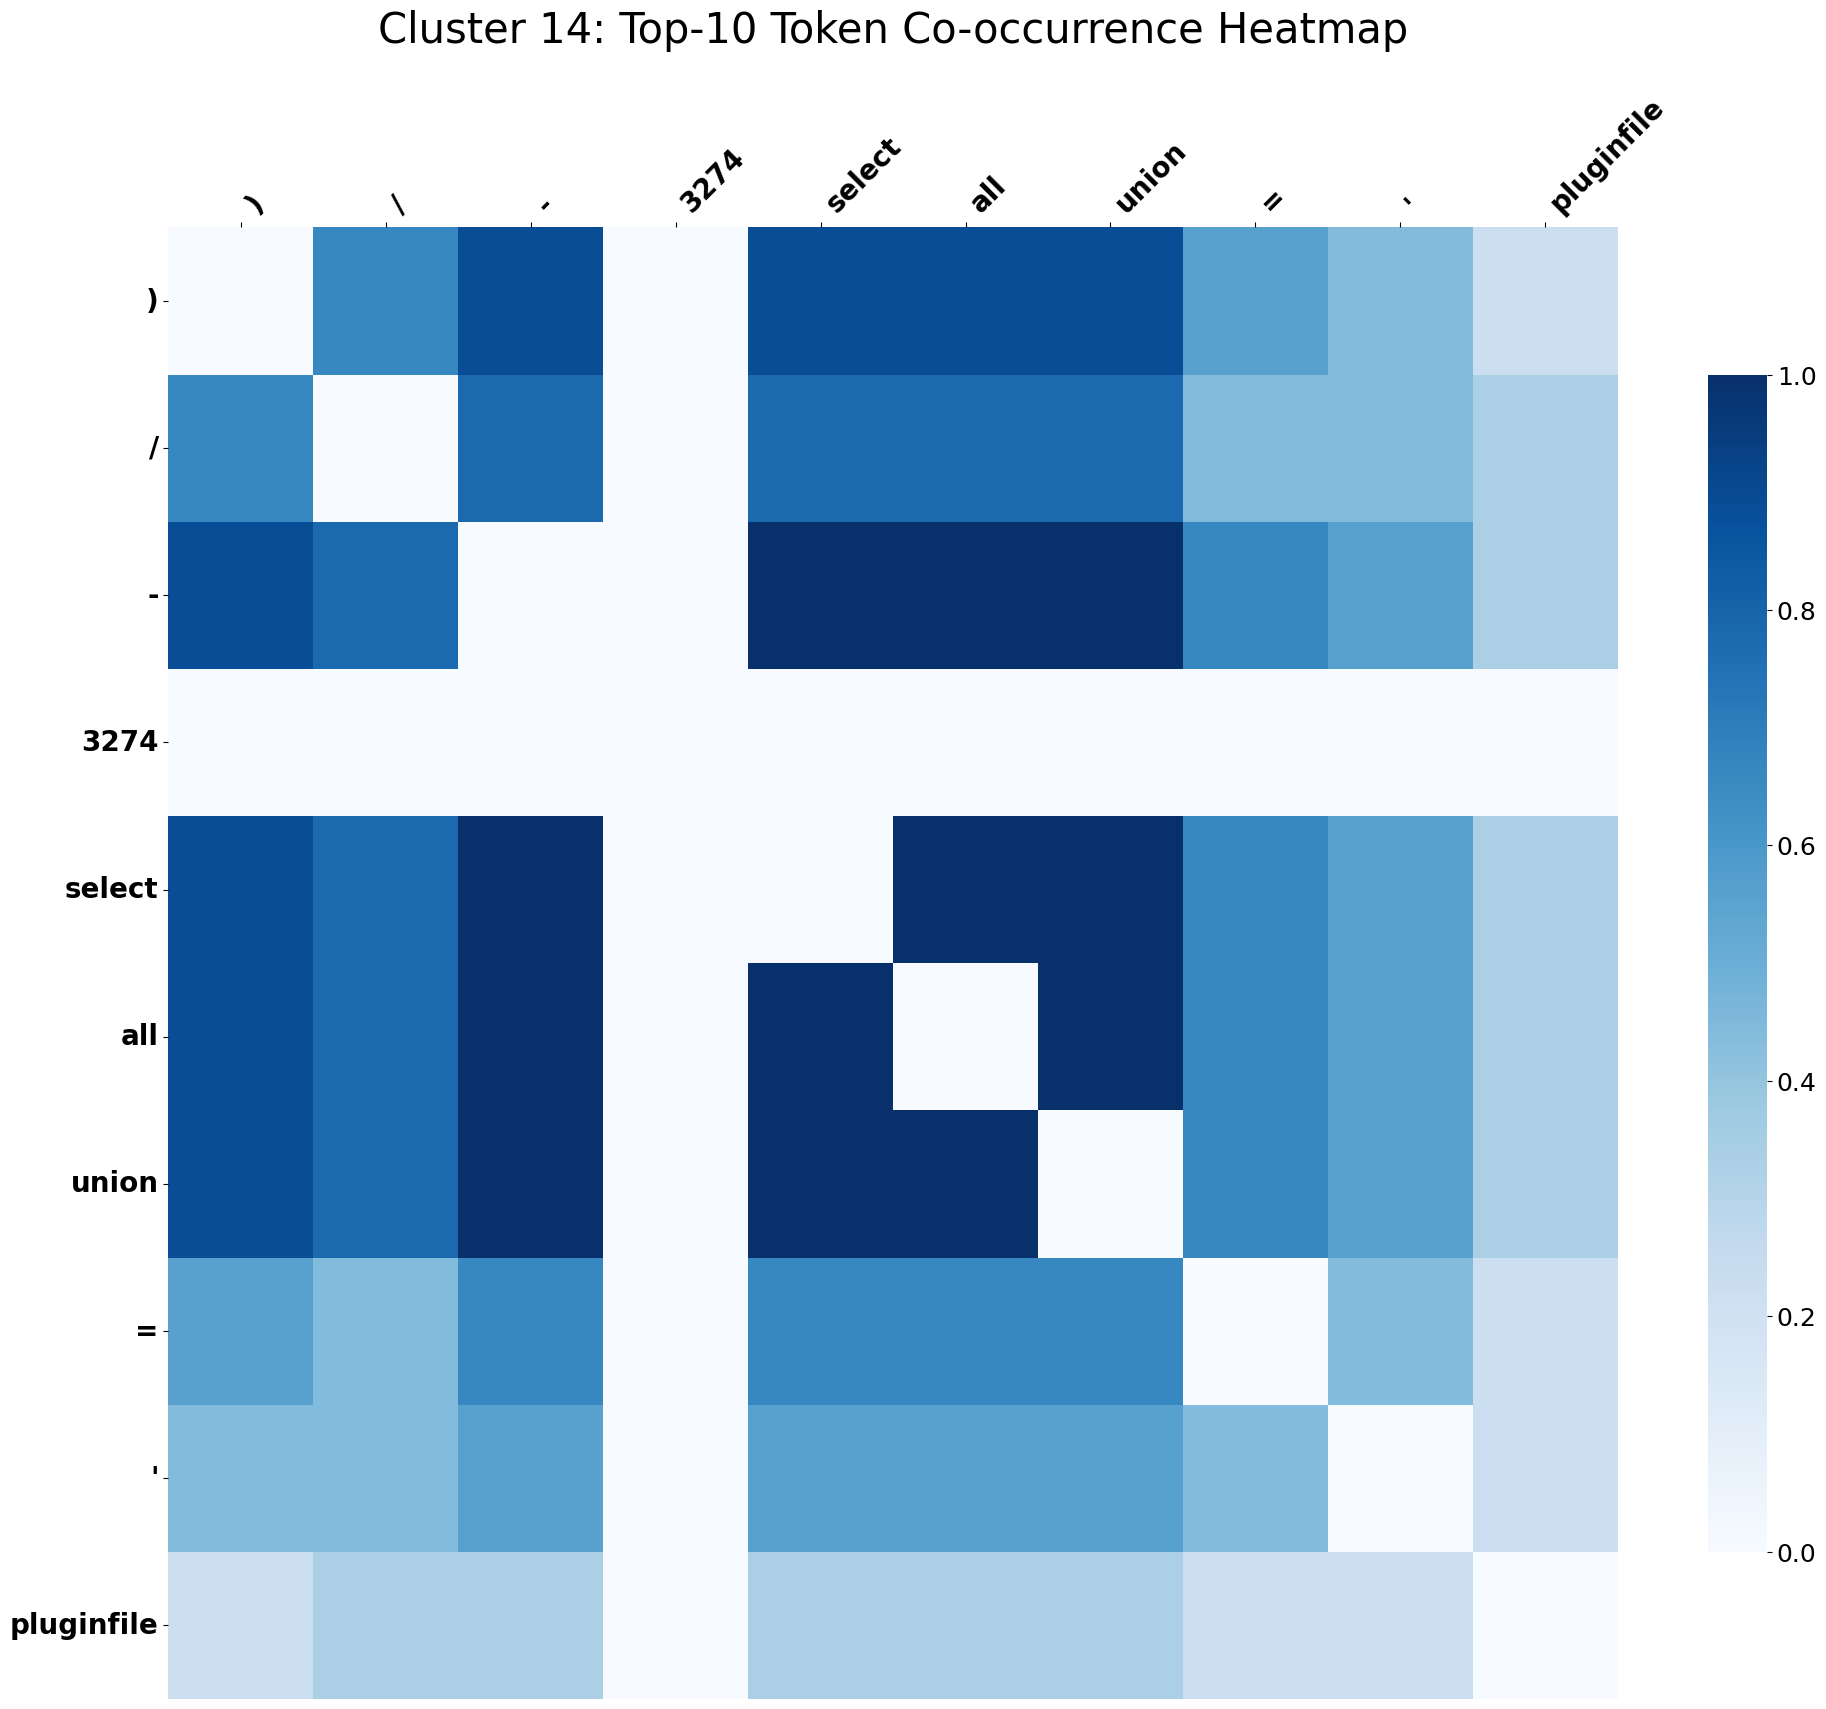

Discovered patterns for cluster 14 (Top-10): [["'", ')', '-', '/', '=', 'all', 'select', 'union']]

--- Co-occurrence Analysis for Top 20 Keywords ---


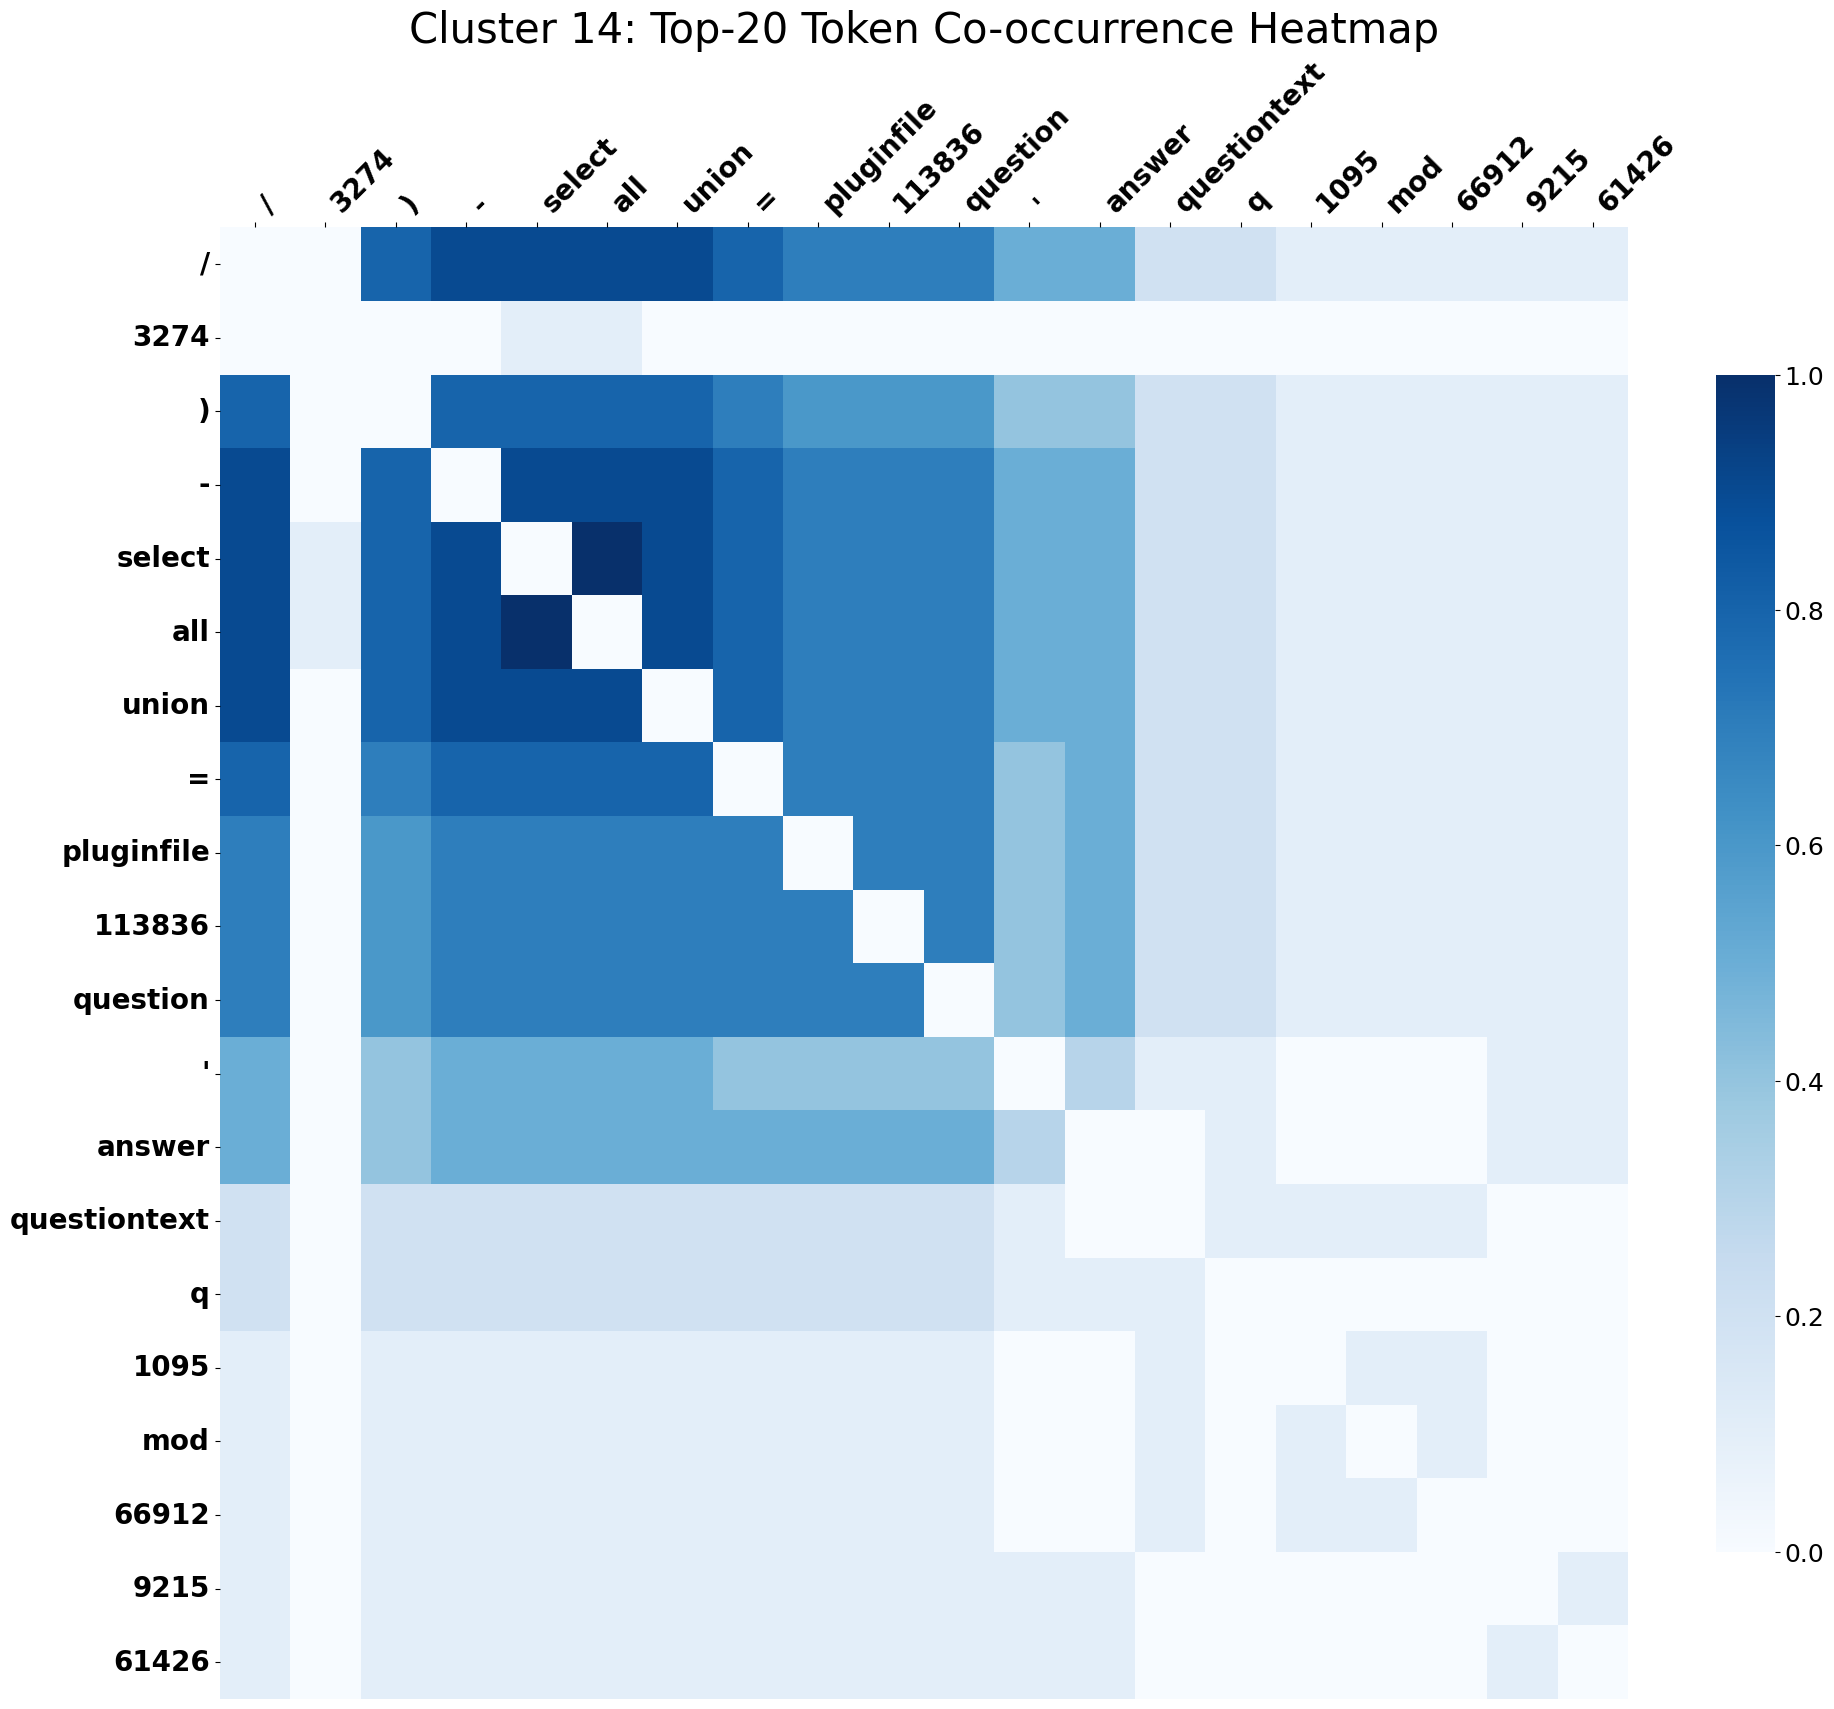

Discovered patterns for cluster 14 (Top-20): [["'", ')', '-', '/', '113836', '=', 'all', 'answer', 'pluginfile', 'question', 'select', 'union']]

Processing Cluster 15...
Members in cluster 15: 15
 Top 10 words by TFIDF: ['chr', 'char', 'jpg', 'answer', 'select', 'question', '3757', 'pluginfile', '113836', 'case']
shape of candidate sets: 15

--- Co-occurrence Analysis for Top 5 Keywords ---


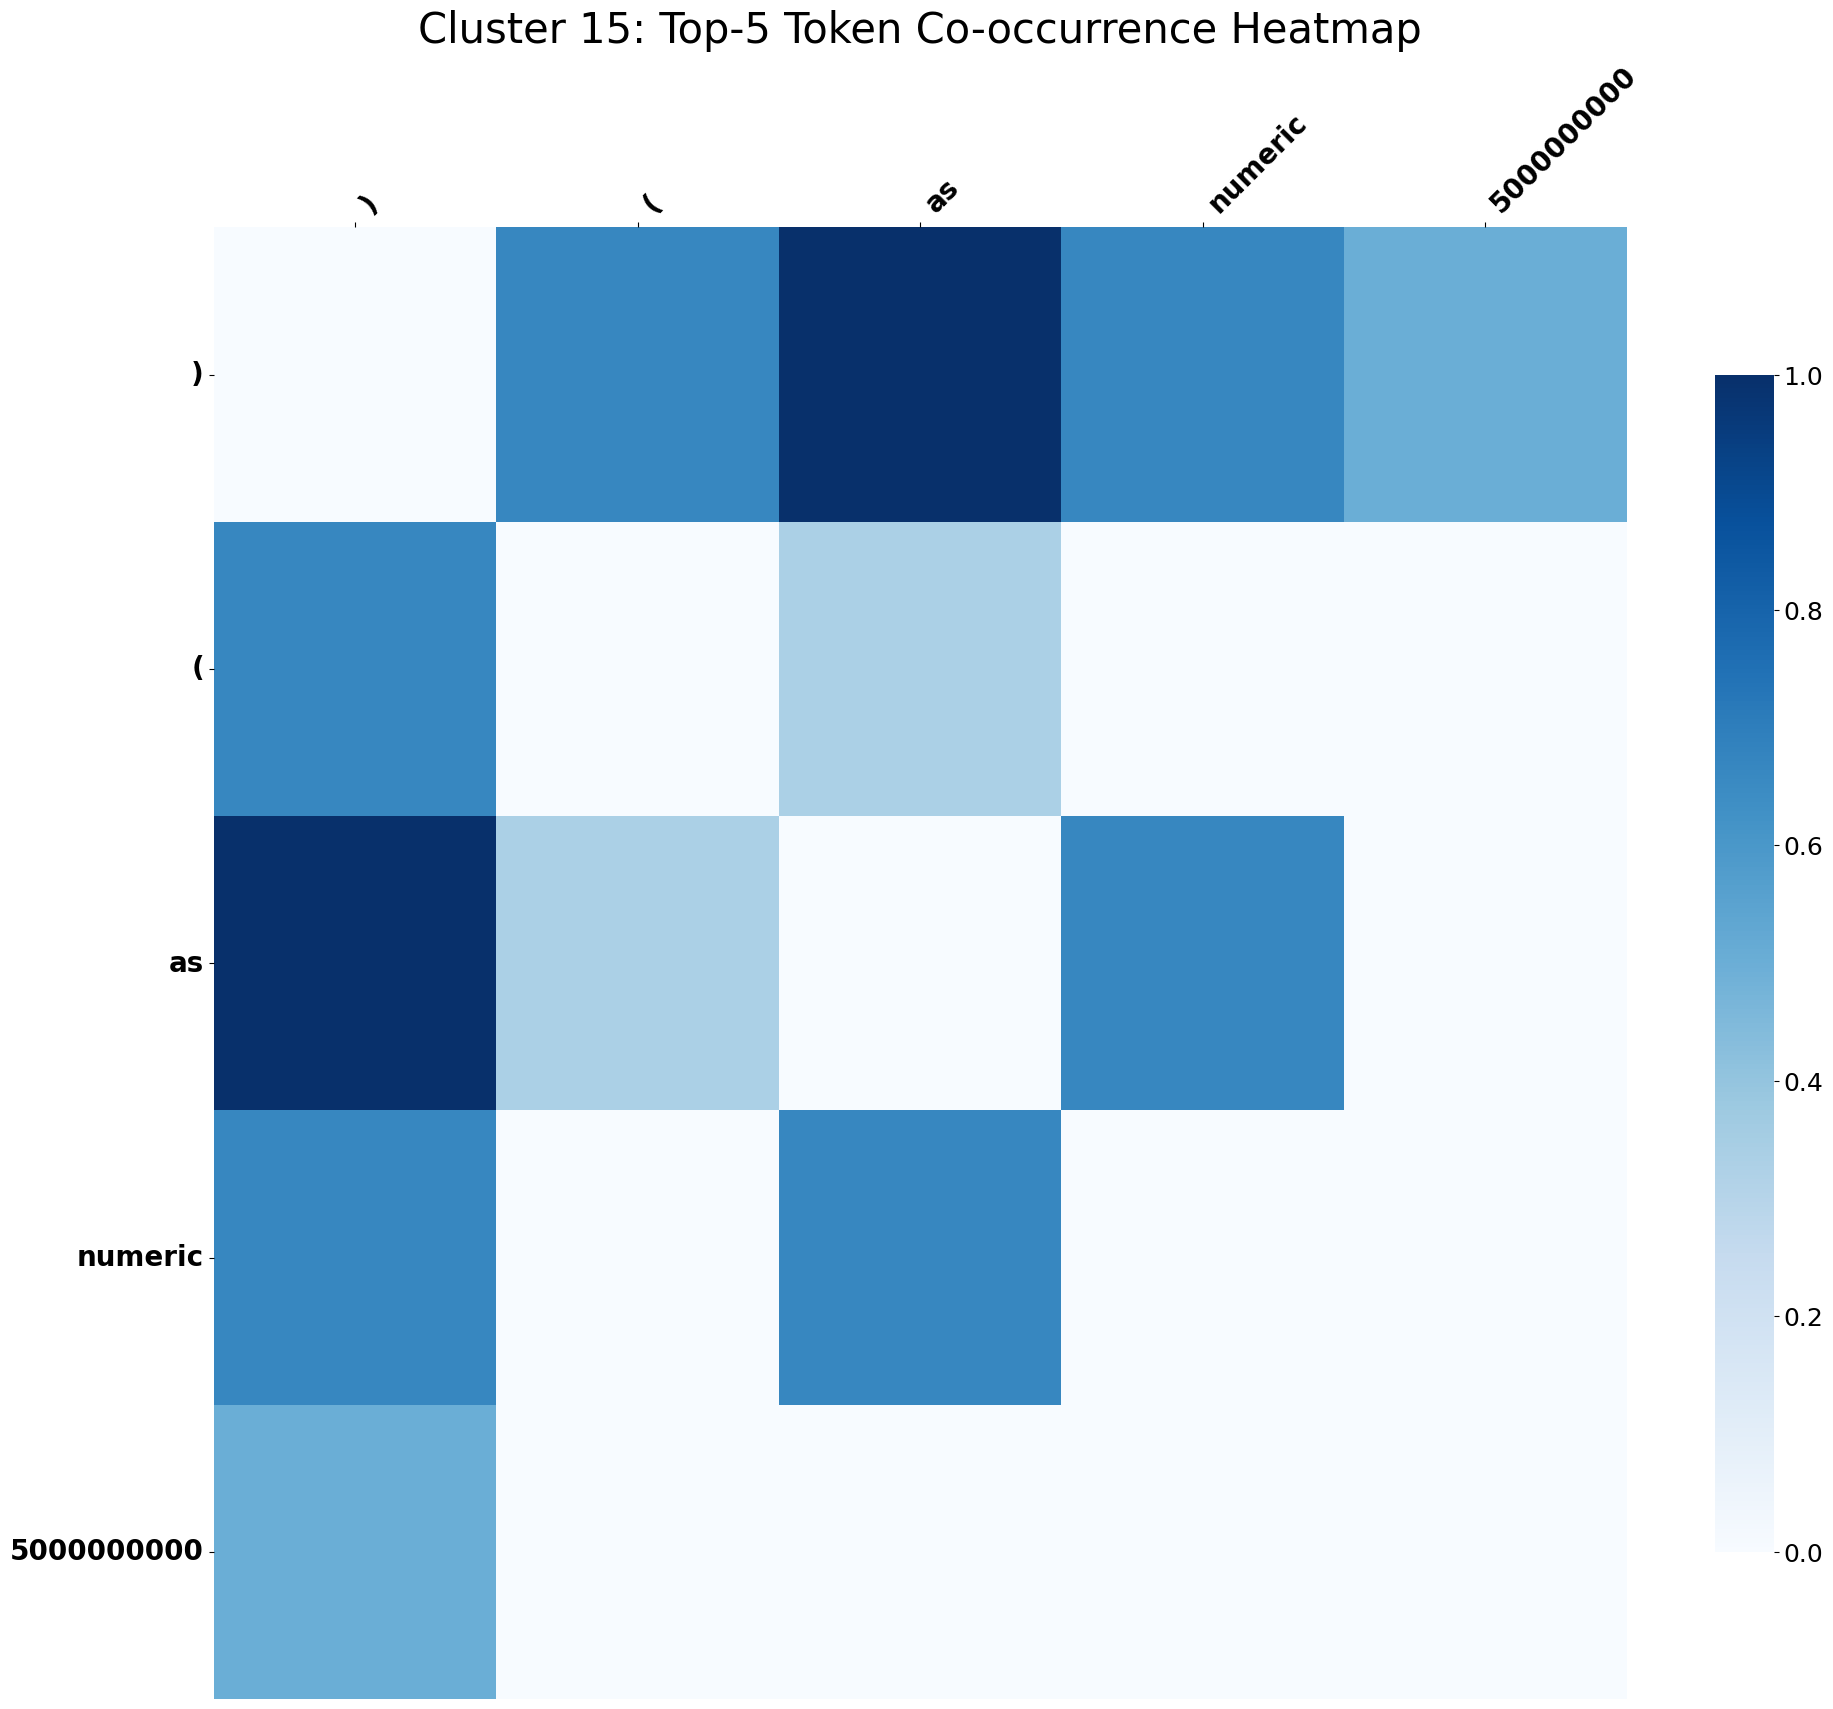

Discovered patterns for cluster 15 (Top-5): [['(', ')', '5000000000', 'as', 'numeric']]

--- Co-occurrence Analysis for Top 10 Keywords ---


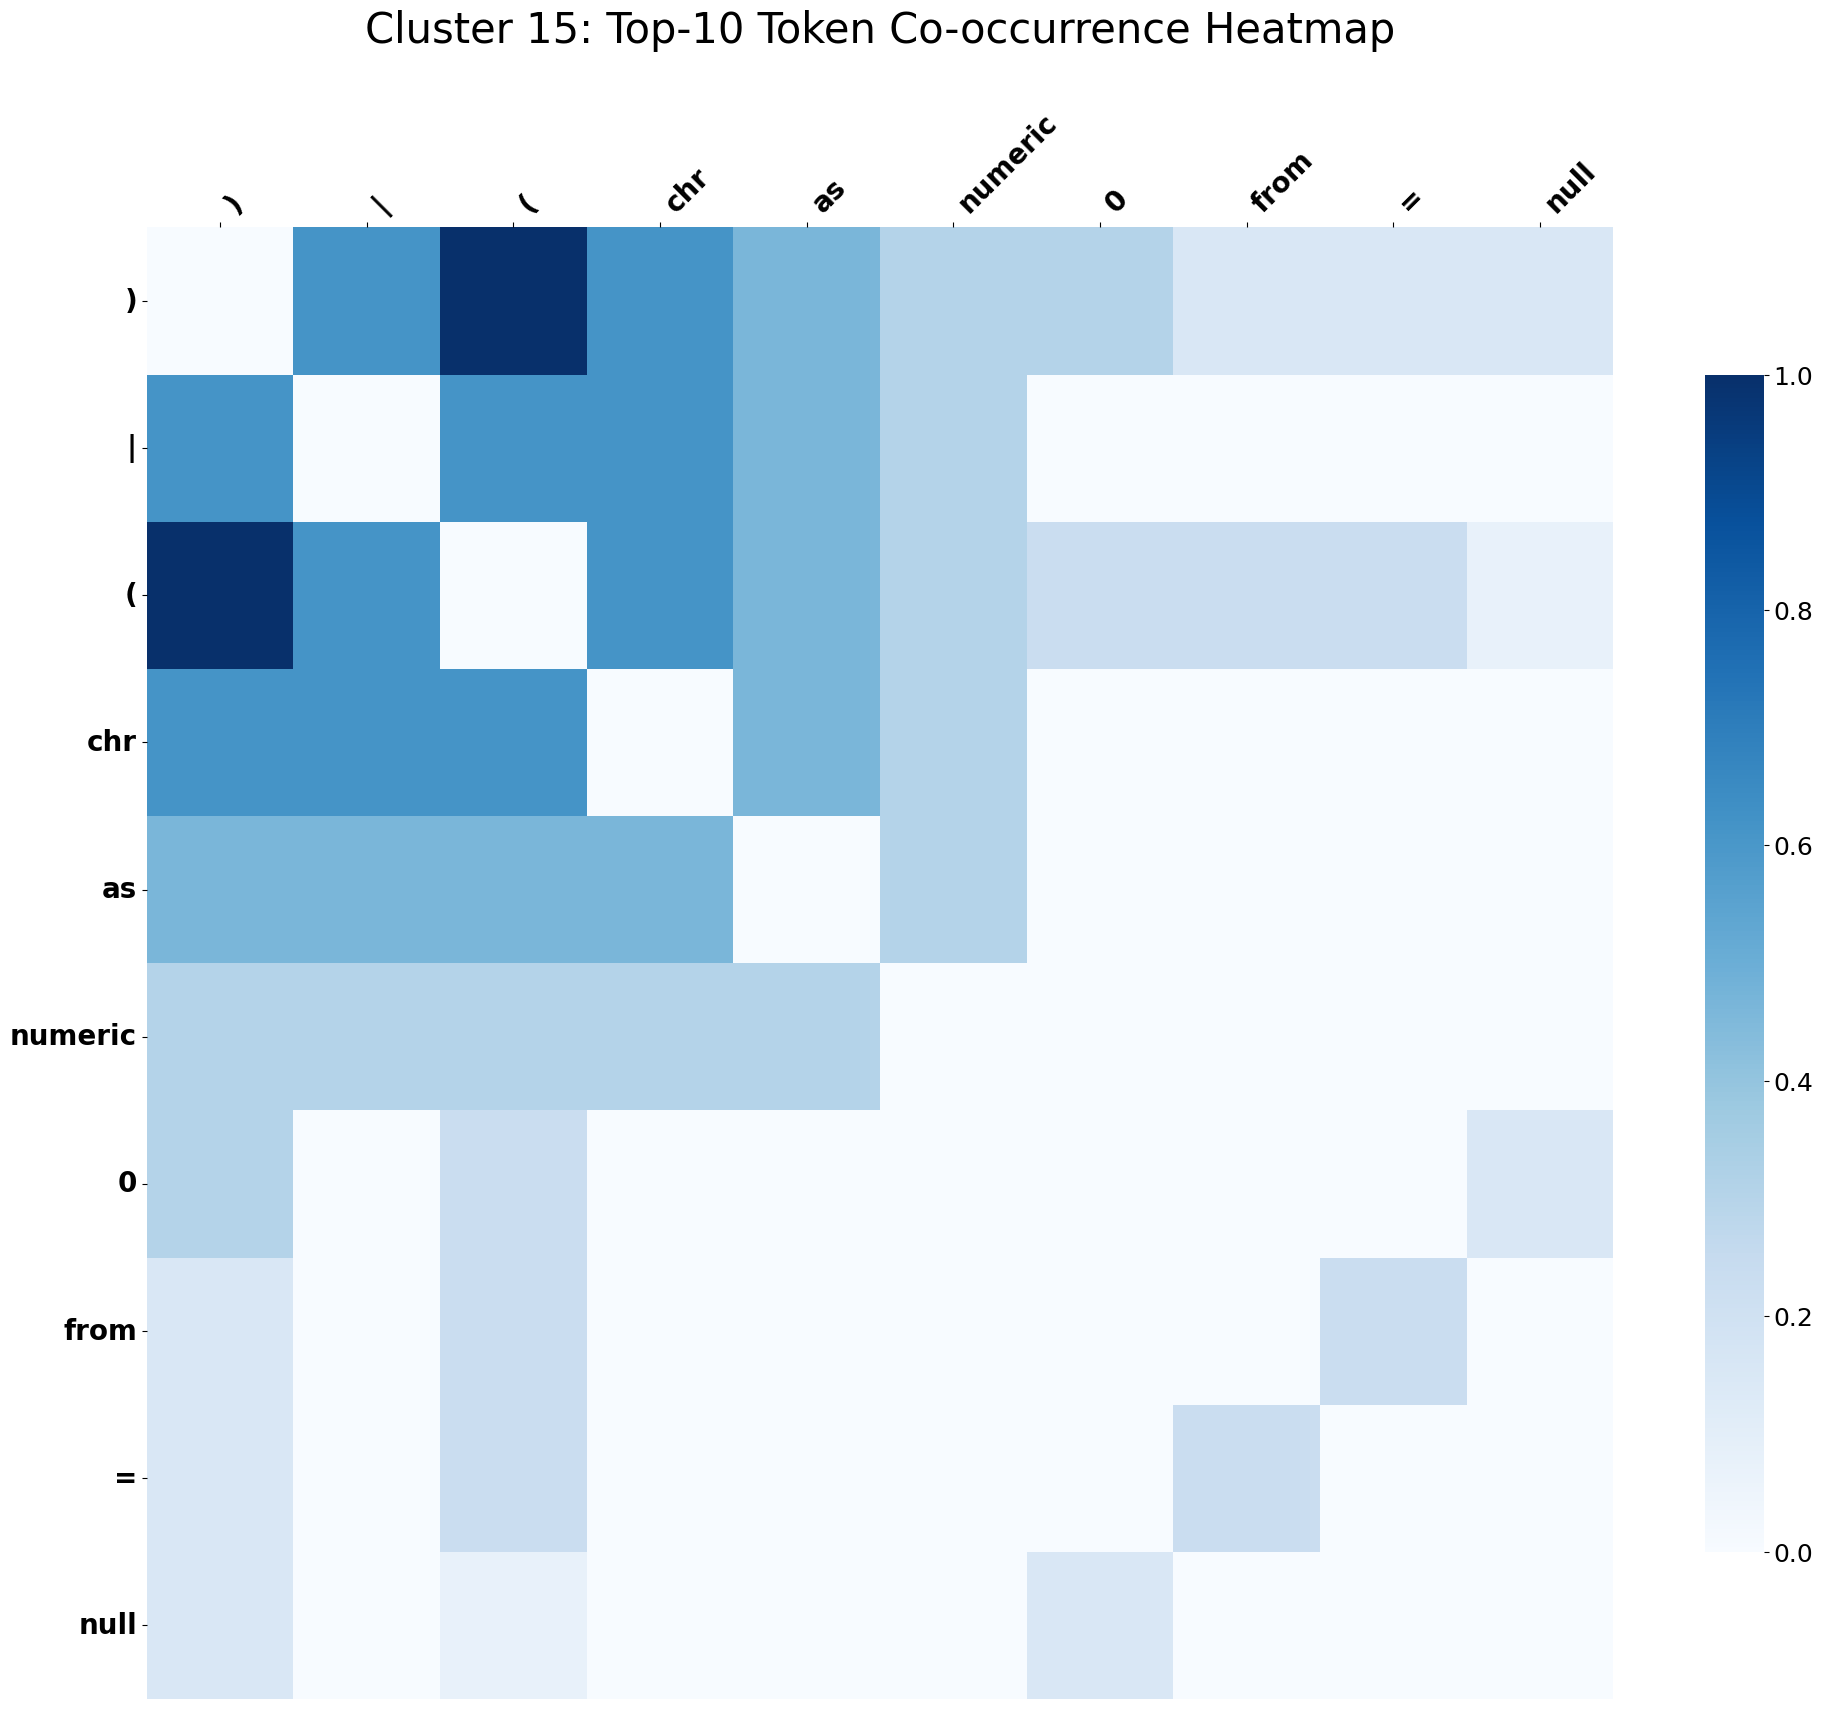

Discovered patterns for cluster 15 (Top-10): [['(', ')', 'as', 'chr', '|']]

--- Co-occurrence Analysis for Top 20 Keywords ---


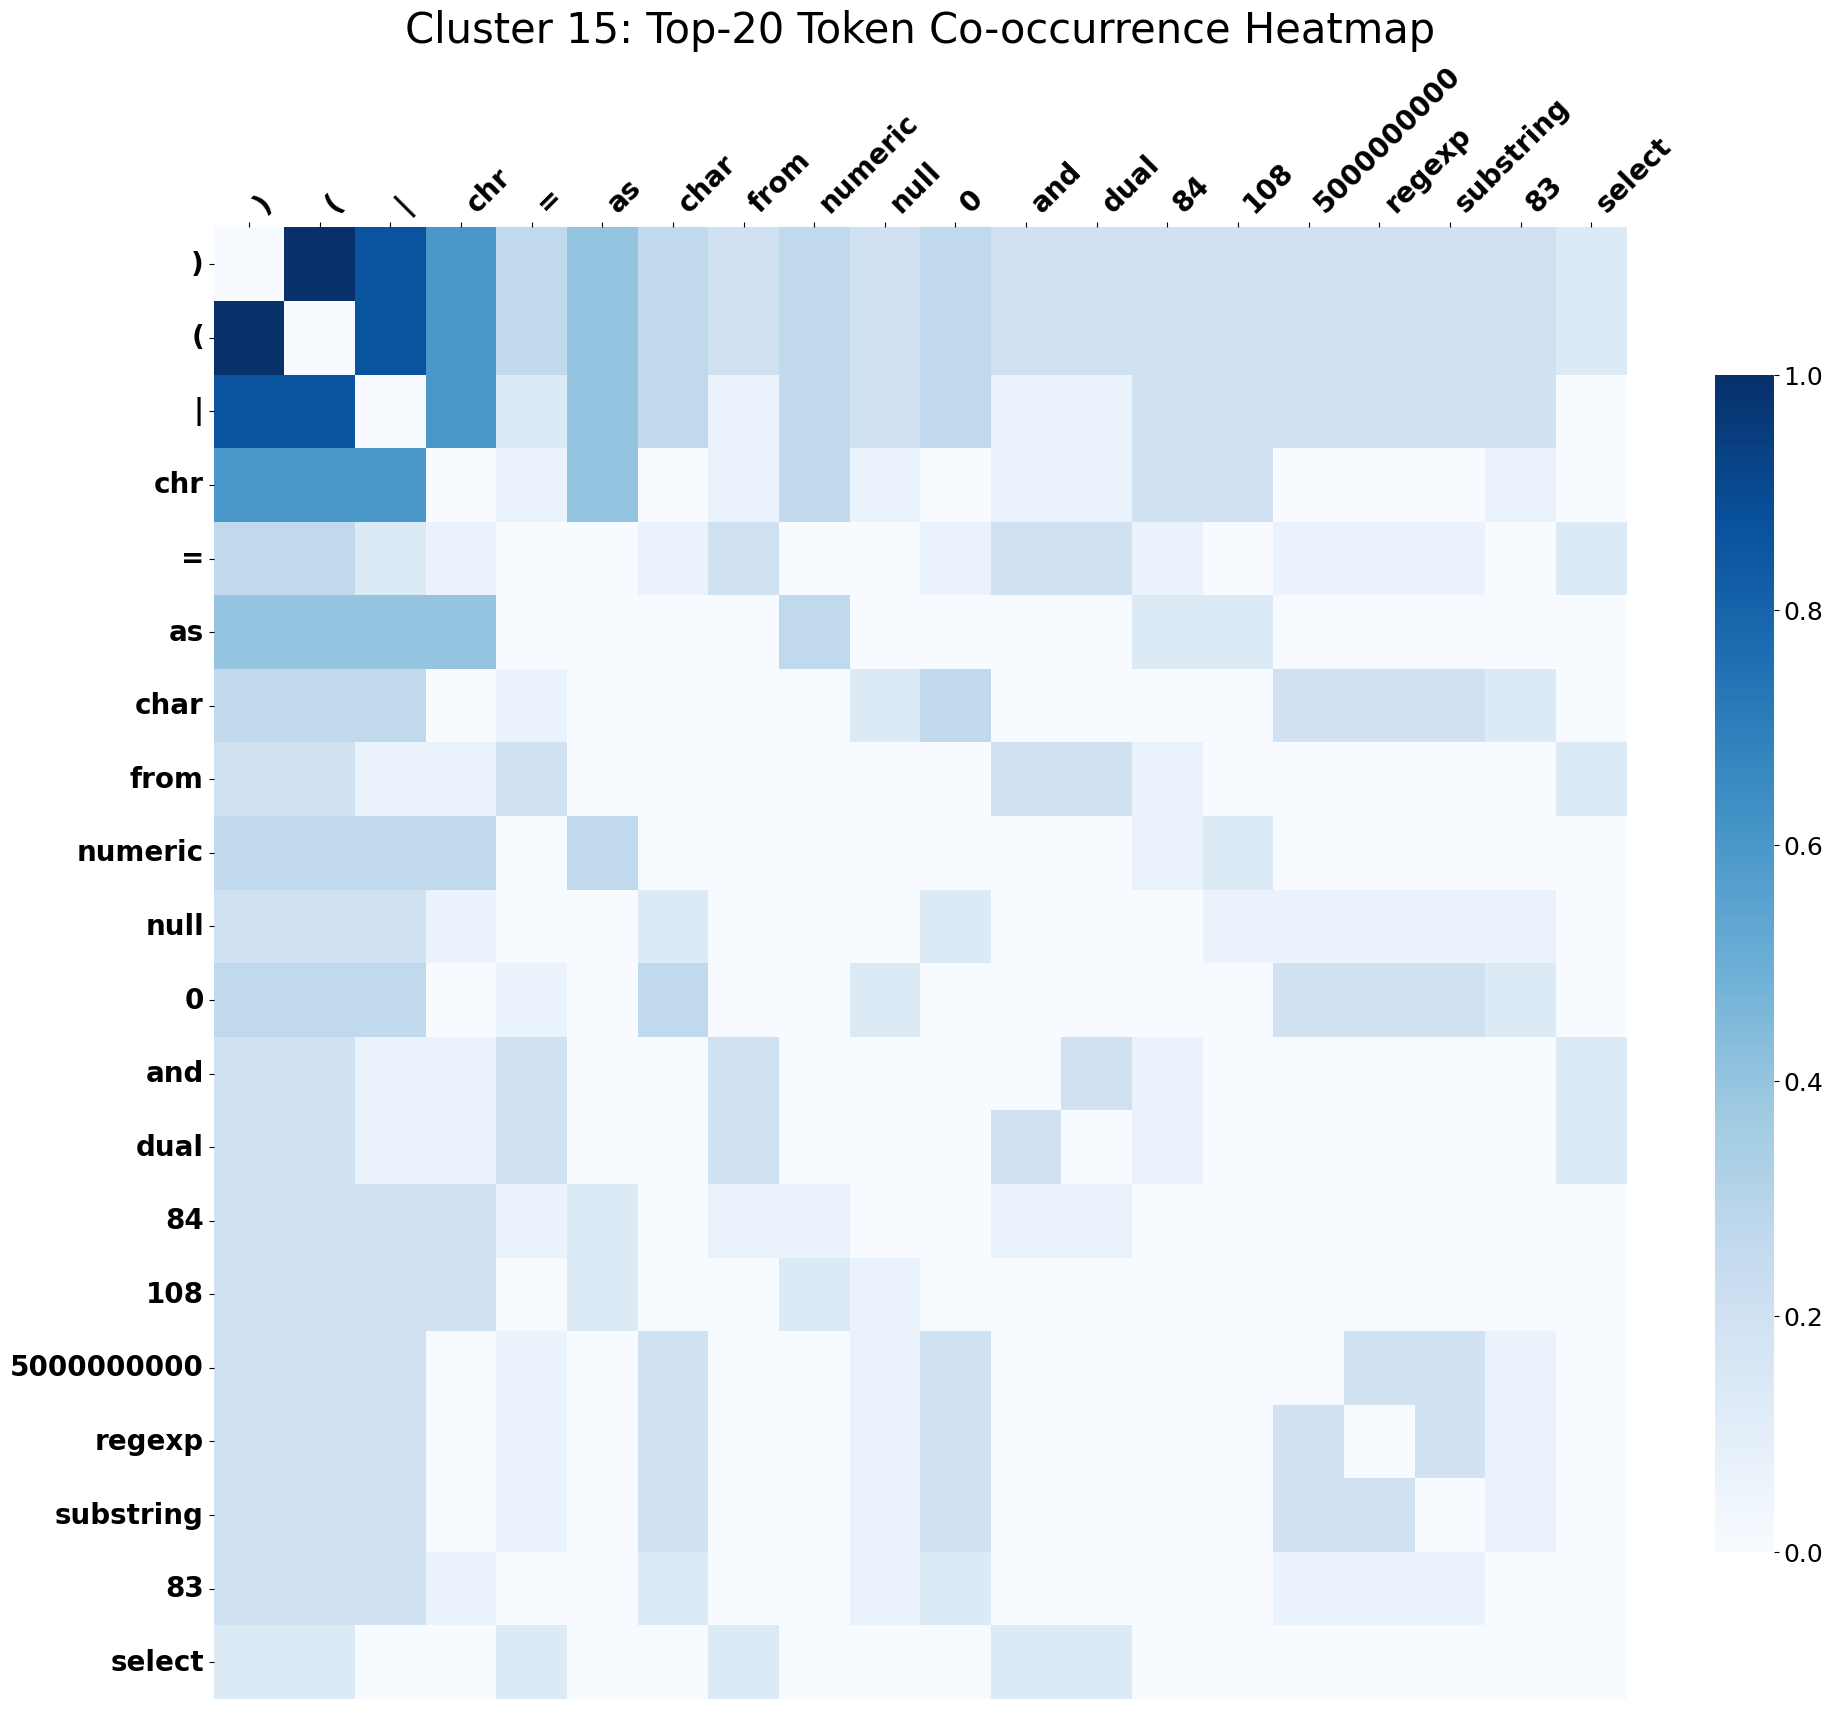

Discovered patterns for cluster 15 (Top-20): [['(', ')', 'as', 'chr', '|']]

Processing Cluster 16...
Members in cluster 16: 10
 Top 10 words by TFIDF: ['as', '5440', 'and', 'pluginfile', 'elt', 'concat', '113836', 'select', 'question', 'answer']
shape of candidate sets: 10

--- Co-occurrence Analysis for Top 5 Keywords ---


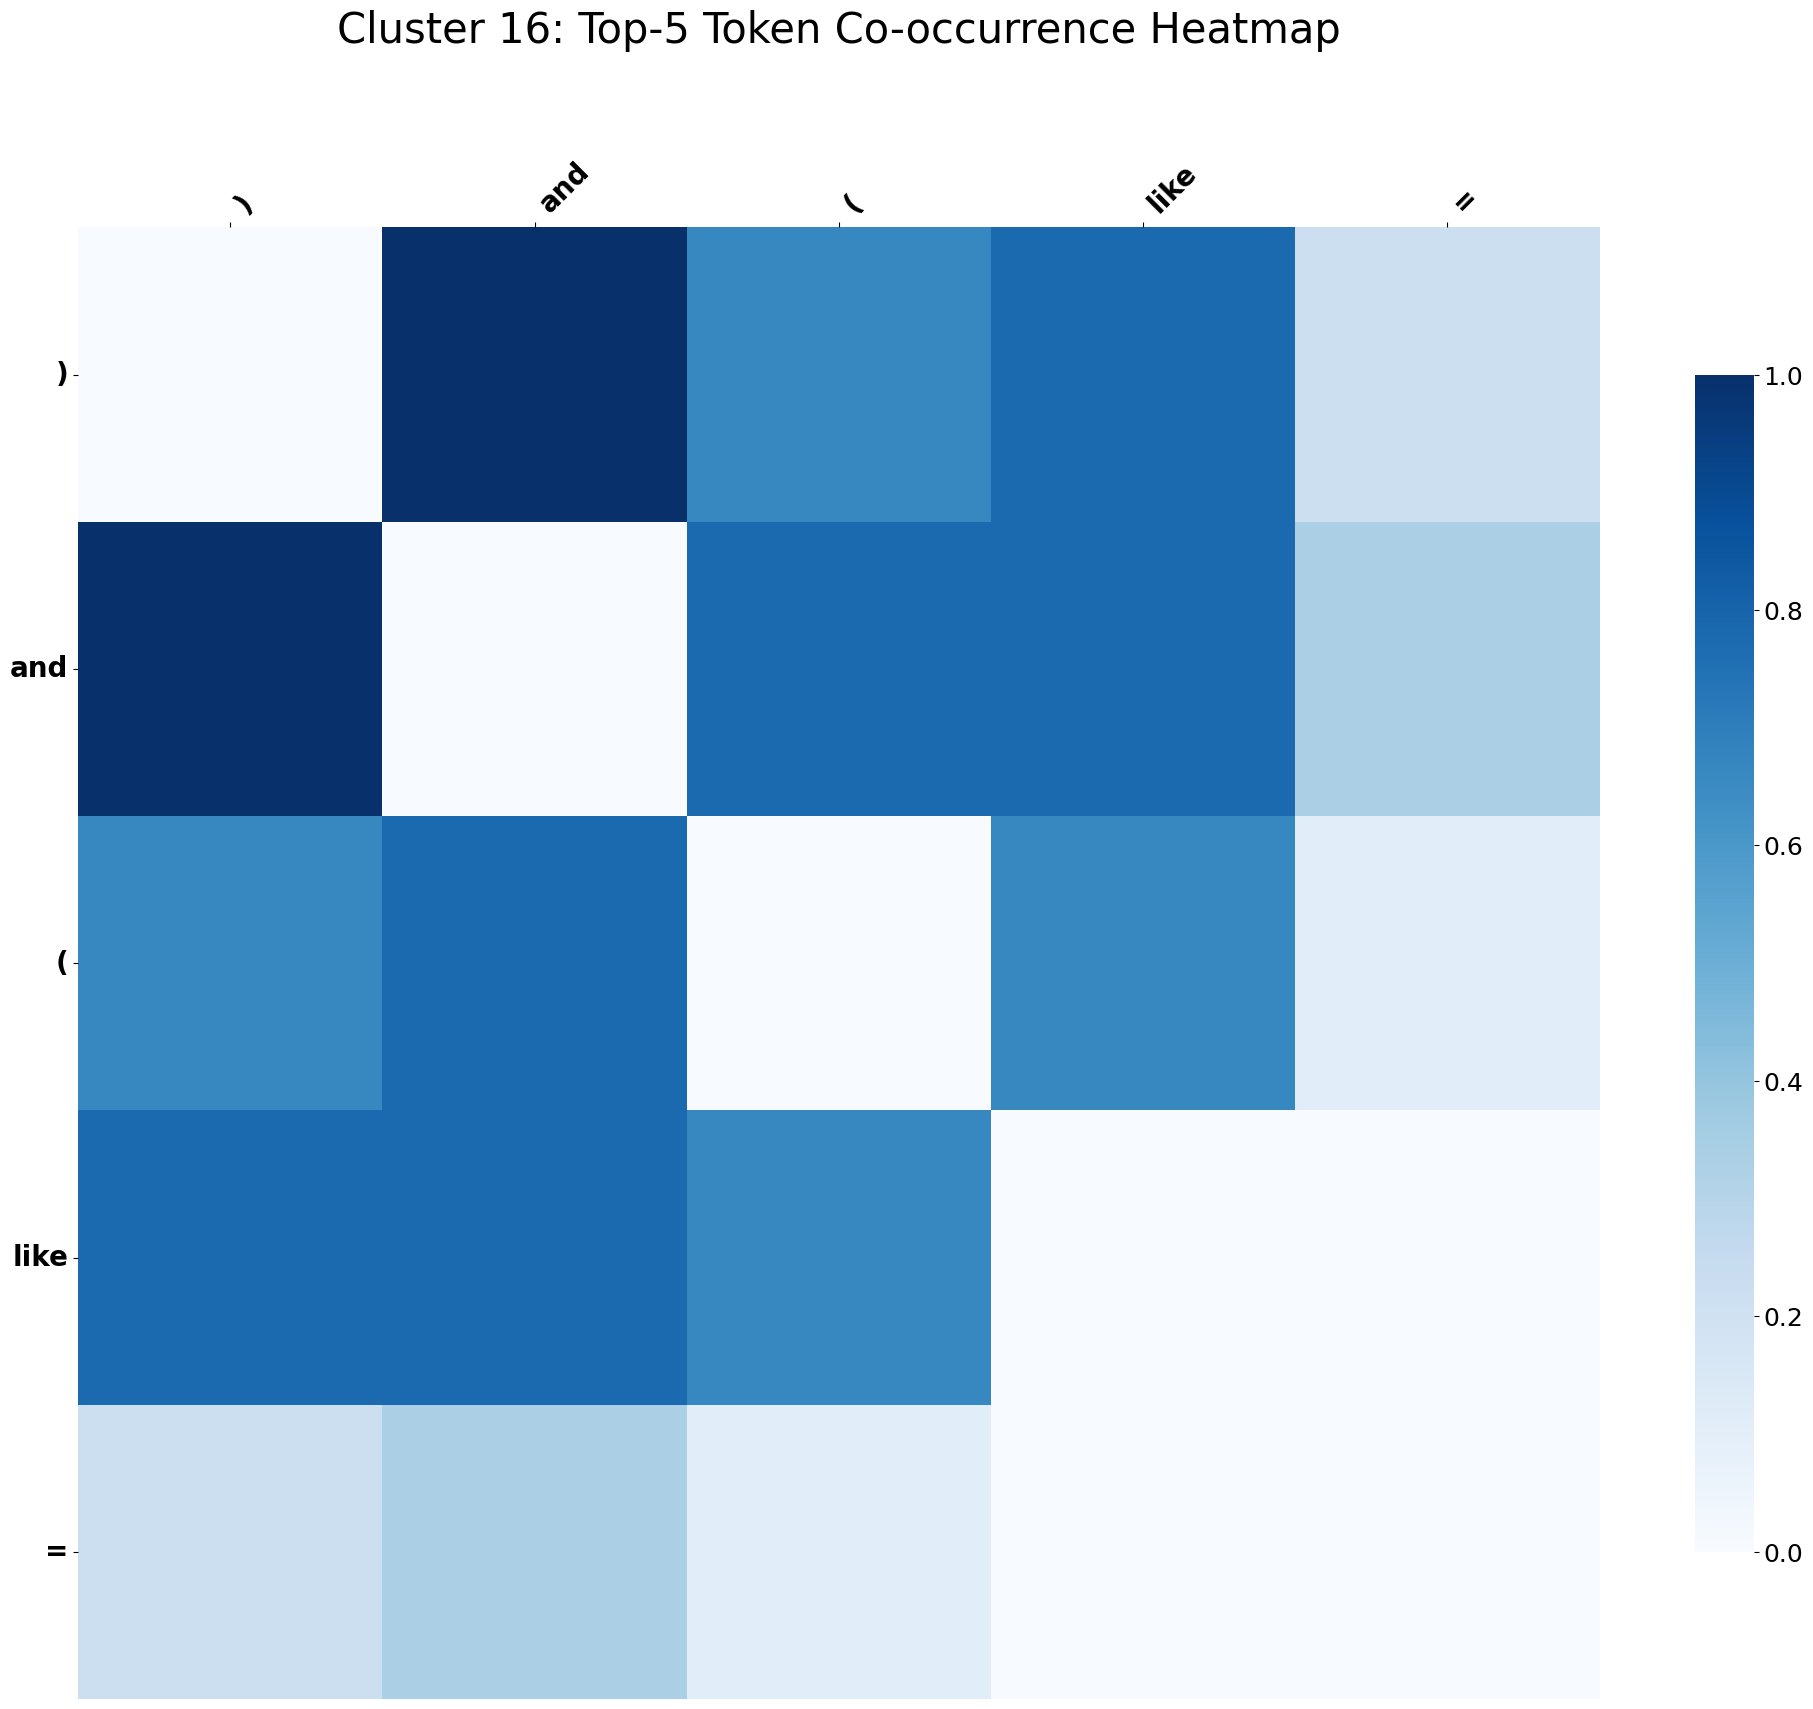

Discovered patterns for cluster 16 (Top-5): [['(', ')', 'and', 'like']]

--- Co-occurrence Analysis for Top 10 Keywords ---


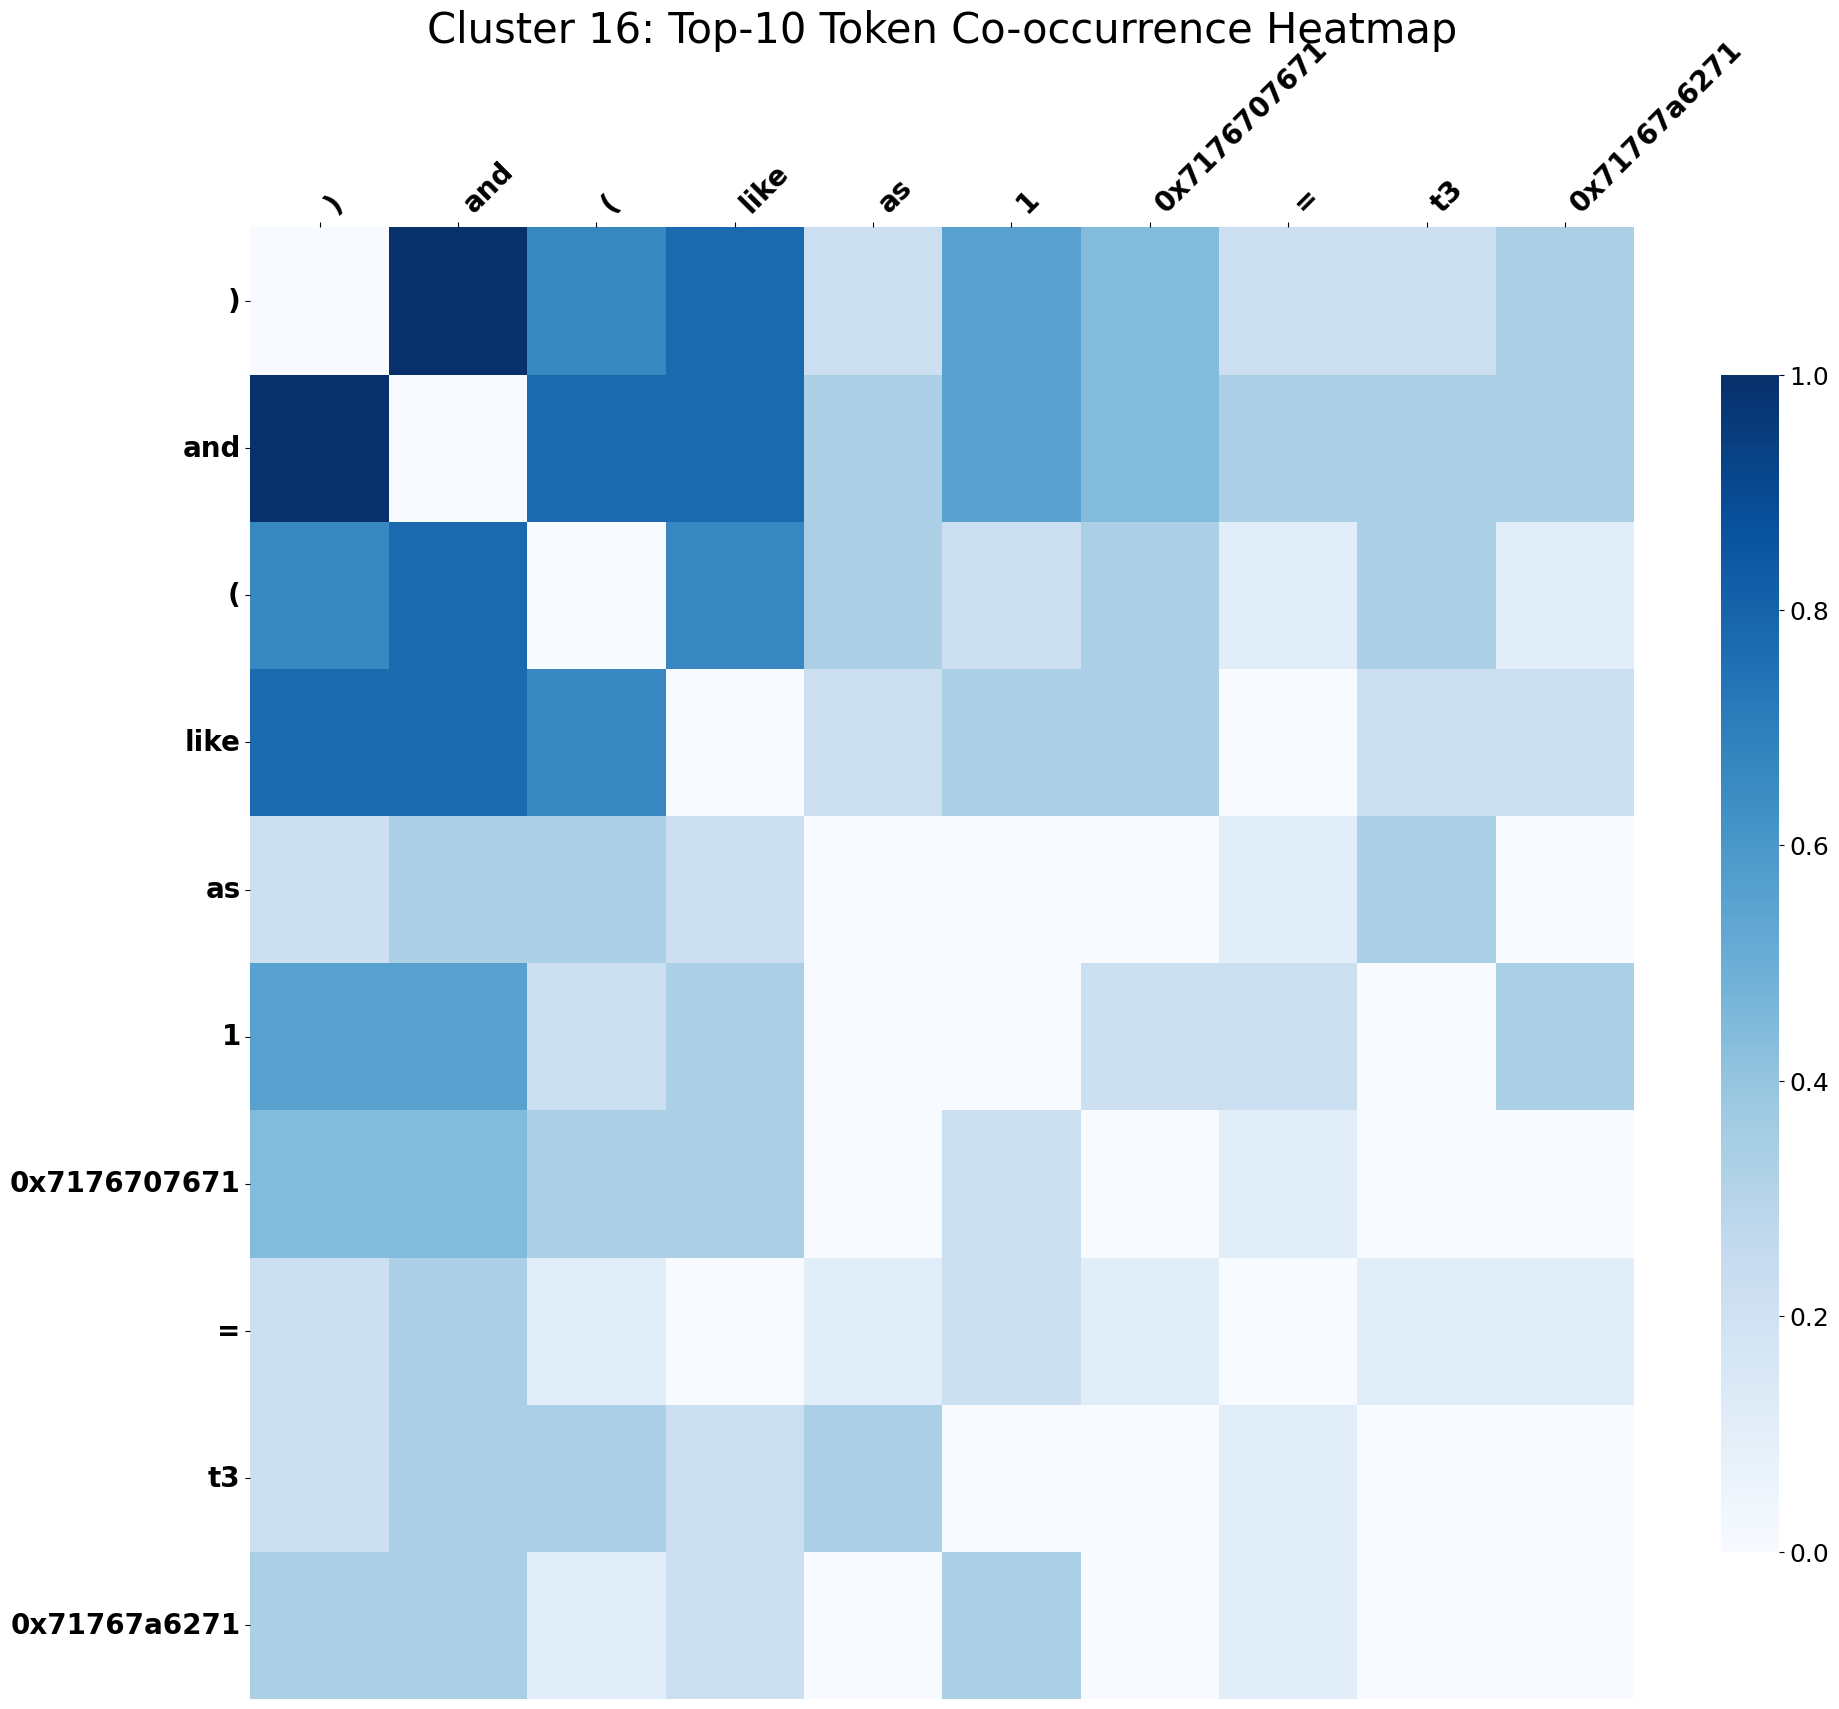

Discovered patterns for cluster 16 (Top-10): [['(', ')', '0x7176707671', '1', 'and', 'like']]

--- Co-occurrence Analysis for Top 20 Keywords ---


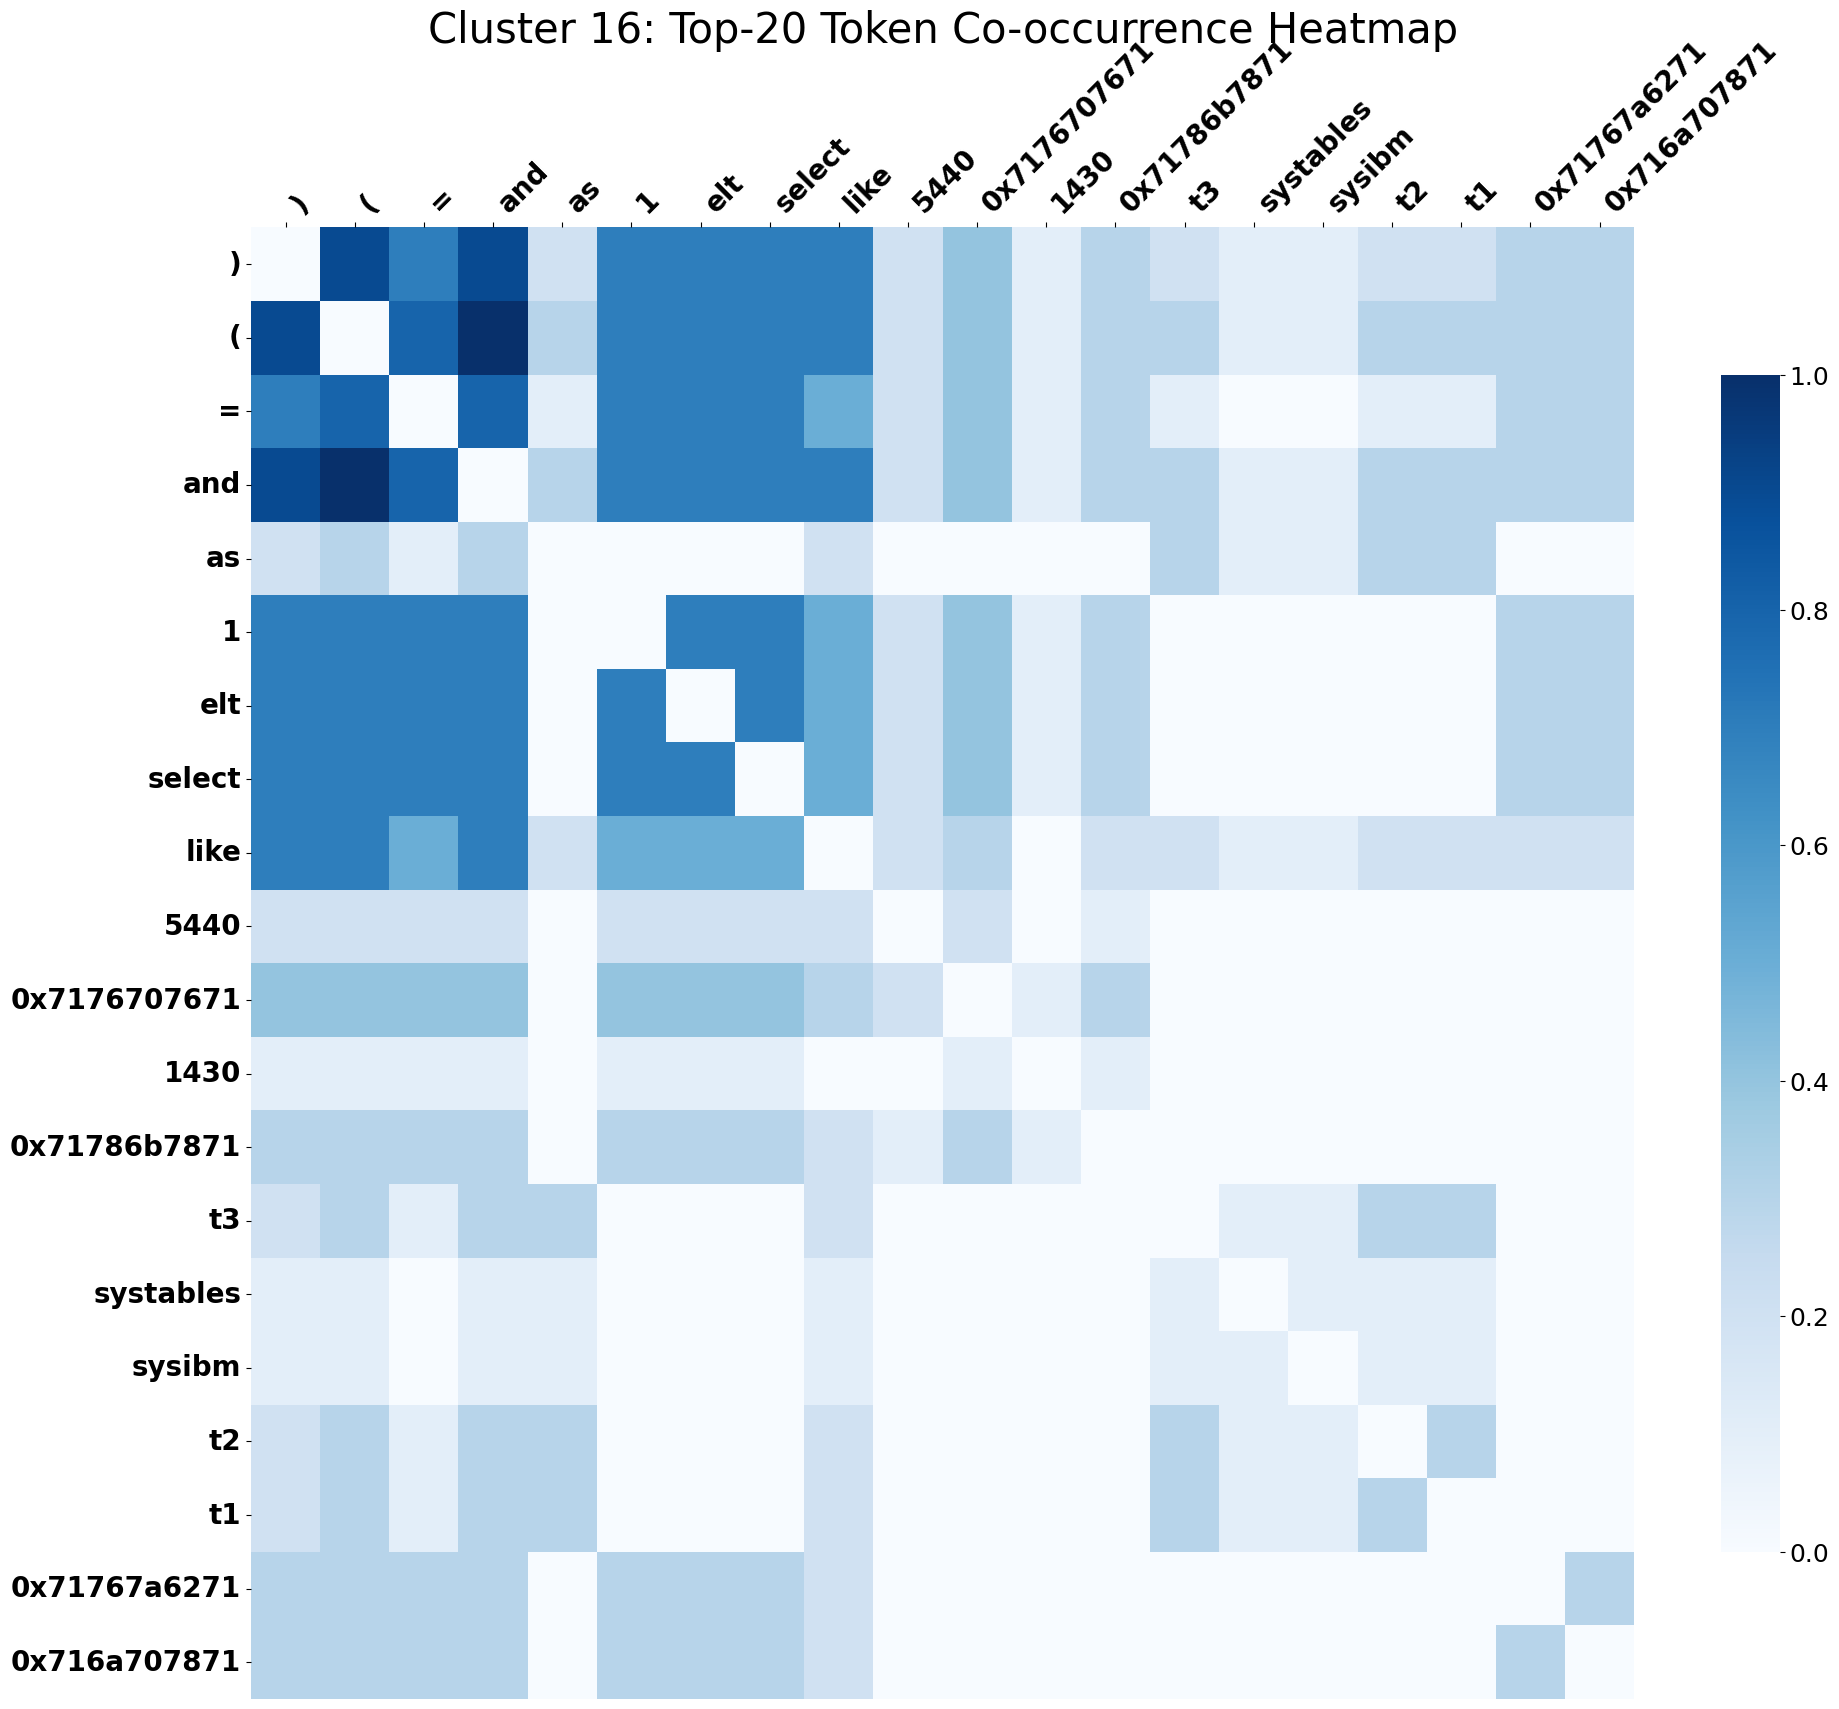

Discovered patterns for cluster 16 (Top-20): [['(', ')', '0x7176707671', '1', '=', 'and', 'elt', 'like', 'select']]

PATTERN MINING EVALUATION RESULTS - GLOBAL TOTALS

XSS Pattern Detection:
Pattern         Top 5    Top 10   Top 20   Total Samples
------------------------------------------------------------
iframe          0.001    0.002    0.002    9329        
script          0.011    0.011    0.013    9329        
body            0.002    0.002    0.003    9329        
img             0.001    0.001    0.019    9329        
input           0.013    0.016    0.017    9329        
alert           0.004    0.119    0.194    9329        
cookie          0.000    0.000    0.001    9329        
<               0.373    0.391    0.402    9329        
>               0.408    0.410    0.412    9329        
(               0.131    0.373    0.793    9329        
)               0.289    0.789    0.899    9329        

SQL Injection Pattern Detection:
Pattern         Top 5    Top 10   Top 20 

In [10]:
alphanumeric = list(string.ascii_letters + string.digits)
hex_digits = string.hexdigits[:16] + string.hexdigits[16:]

hexes = [f'0x{a}{b}' for a in hex_digits for b in hex_digits] + \
        [f'x{a}{b}' for a in hex_digits for b in hex_digits]
patterns = {}
malicious_index = np.array(malicious_indices)
os.makedirs('weights_images', exist_ok=True)
os.makedirs('patterns_images', exist_ok=True)

xss_patterns = ['iframe','script','body','img','input', 'alert', 'cookie', '<','>', '(',')']
sqli_patterns = ['select', 'union', 'from', 'limit', 'order', 'where', 'insert','*','(',')','-','\'']
global_pattern_eval = {
    'xss': {pattern: {'top5': 0, 'top10': 0, 'top20': 0, 'total': 0} for pattern in xss_patterns},
    'sqli': {pattern: {'top5': 0, 'top10': 0, 'top20': 0, 'total': 0} for pattern in sqli_patterns}
}

for cluster_id in unique_clusters: 
    print(f"\nProcessing Cluster {cluster_id}...")
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_size = len(cluster_indices)
    print(f"Members in cluster {cluster_id}: {cluster_size}")
    cluster_weights = [malicious_weights[i] for i in cluster_indices]
    structure_weights = [malicious_structure_weights[i] for i in cluster_indices]
    tokenized_urls = []
    for i in malicious_index[cluster_indices]:
        tokens = true_malicious_df.loc[i, 'tokenized_url']
        if isinstance(tokens, str):
            try:
                tokens = ast.literal_eval(tokens)
                tokens = remove_padding(tokens)
                tokens = [remove_eos(content_vocab[token]) for token in tokens]
            except:
                tokens = tokens.split()
                tokens = [content_vocab[token] for token in tokens]
        tokenized_urls.append(tokens)

    cluster_documents = [' '.join(tokens) for tokens in tokenized_urls]

    stop_words = ['query', 'unk', 'eos', 'page', 'submit', 'php', 'js', 'html', 'png', 'null', 'jsp', 'assets'] + alphanumeric + hexes
    tfidf = TfidfVectorizer(        
        tokenizer=custom_token,
        token_pattern=None,
        use_idf=True,
        stop_words=stop_words,
        max_features=100000)
    top_n = 10
    try:
        tfidf_matrix = tfidf.fit_transform(cluster_documents)
        feature_names = tfidf.get_feature_names_out()
        tfidf_sums = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
        top_n_indices = np.argsort(tfidf_sums)[-min(len(feature_names), top_n):][::-1]
        candidate_set = [feature_names[i] for i in top_n_indices]
        print(f" Top {len(candidate_set)} words by TFIDF: {candidate_set}")
    except:
        all_tokens = []
        for tokens in tokenized_urls:
            all_tokens.extend(tokens)
        token_counter = Counter(all_tokens)
        candidate_set = token_counter.most_common(top_n)
        print(f" Top {len(candidate_set)} words by frequency: {candidate_set}")

    candidate_sets = []
    for i in range(len(cluster_documents)):
        for token in candidate_set:
            if token in cluster_documents[i]:
                candidate_sets.append((malicious_index[cluster_indices[i]], cluster_documents[i], cluster_weights[i], structure_weights[i]))
                break
    print(f"shape of candidate sets: {len(candidate_sets)}")
    
    top_m = 10
    all_top_keywords = []
    exclude_words = {'<eos>', '<query>', '<unk>', '<eos>', 'query', 'unk', '<UNK>', '&', ',', '\\','"', 'assets', '.', 'php', 'js', 'html', 'png'}

    for i in range(len(candidate_sets)):
        weight = candidate_sets[i][2].flatten()
        tokens = candidate_sets[i][1].split()
        structure_weight = candidate_sets[i][3].flatten()

        min_len = min(len(tokens), len(weight))
        weights = np.array(weight[:min_len])
        tokens = np.array(tokens[:min_len])
        sweights = np.array(structure_weight[:min_len])

        combined_weights = sweights + weights
        
        valid_indices = []
        for idx, token in enumerate(tokens):
            if token not in exclude_words and token.strip():
                valid_indices.append(idx)

        if len(valid_indices) > 0:
            valid_tokens = tokens[valid_indices]
            valid_combined_weights = combined_weights[valid_indices]
            valid_content_weights = weights[valid_indices]
            valid_structure_weights = sweights[valid_indices]

            for k in [5, 10, 20]:
                actual_k = min(k, len(valid_tokens))
                if actual_k > 0:
                    top_k_indices = np.argsort(valid_combined_weights)[-actual_k:][::-1]
                    top_k_tokens = valid_tokens[top_k_indices]
                    
                    tokens_lower = [token.lower() for token in top_k_tokens]
                    for pattern in xss_patterns:
                        if k == 5:
                            global_pattern_eval['xss'][pattern]['total'] += 1
                        if pattern.lower() in tokens_lower:
                            global_pattern_eval['xss'][pattern][f'top{k}'] += 1
                    
                    for pattern in sqli_patterns:
                        if k == 5:
                            global_pattern_eval['sqli'][pattern]['total'] += 1
                        if pattern.lower() in tokens_lower:
                            global_pattern_eval['sqli'][pattern][f'top{k}'] += 1

            # Store for co-occurrence analysis - for top 5, 10, 20
            top_keywords_by_k = {}
            for k in [5, 10, 20]:
                if len(valid_tokens) >= k:
                    top_k_indices = np.argsort(valid_combined_weights)[-k:][::-1]
                    top_k_tokens = valid_tokens[top_k_indices]
                    top_k_weights = valid_combined_weights[top_k_indices]
                    top_keywords_by_k[k] = (candidate_sets[i][0], top_k_tokens, top_k_weights)
            
            if top_keywords_by_k:
                all_top_keywords.append(top_keywords_by_k)
        else:
            print(f"No valid tokens found for traffic {candidate_sets[i][0]} after filtering")
    
    # Co-occurrence analysis for top 5, 10, 20 keywords
    for top_k in [5, 10, 20]:
        print(f"\n--- Co-occurrence Analysis for Top {top_k} Keywords ---")
        
        k_keywords = []
        for keyword_dict in all_top_keywords:
            if top_k in keyword_dict:
                traffic_id, tokens, weights = keyword_dict[top_k]
                k_keywords.append((traffic_id, tokens, weights))
        
        if not k_keywords:
            print(f"No data available for top {top_k} keywords")
            continue
            
        top_m_showed = min(20, top_k)
        token_counter = Counter(token for _, tokens, _ in k_keywords for token in tokens)
        top_tokens = [token for token, _ in token_counter.most_common(top_m_showed)]
        
        if len(top_tokens) == 0:
            print(f"No tokens found for top {top_k} analysis")
            continue
            
        token_to_index = {token: idx for idx, token in enumerate(top_tokens)}
        top_word_co_matrix = np.zeros((len(top_tokens), len(top_tokens)))

        # Build co-occurrence matrix
        for _, tokens, _ in k_keywords:
            traffic_tokens = set(tokens)
            for i in top_tokens:
                for j in top_tokens:
                    if i != j and i in traffic_tokens and j in traffic_tokens:
                        idx_i = token_to_index[i]
                        idx_j = token_to_index[j]
                        top_word_co_matrix[idx_i, idx_j] += 1

        top_word_co_matrix = (top_word_co_matrix + top_word_co_matrix.T) / 2
        
        if np.max(top_word_co_matrix) > 0:
            top_word_co_matrix = top_word_co_matrix / np.max(top_word_co_matrix)

        plt.figure(figsize=(20, 17))
        ax = sns.heatmap(
            top_word_co_matrix,
            xticklabels=top_tokens,
            yticklabels=top_tokens,
            cmap="Blues",
            cbar=True,
            fmt='.2f',
            cbar_kws={"shrink": 0.8}  # optionally shrink the color bar
        )

        # Atur ukuran font pada ticks sumbu X dan Y
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        plt.xticks(rotation=45, ha='left', fontsize=20, fontweight='bold')
        plt.yticks(rotation=0, fontsize=20, fontweight='bold')

        # Perbesar label angka di colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=18)  # Atur ukuran angka di color bar

        info = f"Cluster {cluster_id}: Top-{top_k} Token Co-occurrence Heatmap"
        plt.title(info, y=1.12, fontsize=30)

        plt.tight_layout()
        plt.savefig(f'patterns_images/cluster_{cluster_id}_top_{top_k}_co_occurrence.png')
        plt.show()
        
        threshold = 0.4 
        G = nx.Graph()
        for i in range(len(top_tokens)):
            for j in range(i + 1, len(top_tokens)):
                if top_word_co_matrix[i, j] >= threshold:
                    G.add_edge(top_tokens[i], top_tokens[j], weight=top_word_co_matrix[i, j])

        clusters_nx = list(nx.connected_components(G))
        patterns_discovered = [sorted(list(cluster)) for cluster in clusters_nx]
        print(f"Discovered patterns for cluster {cluster_id} (Top-{top_k}): {patterns_discovered}")

print("\n" + "="*80)
print("PATTERN MINING EVALUATION RESULTS - GLOBAL TOTALS")
print("="*80)

print("\nXSS Pattern Detection:")
print(f"{'Pattern':<15} {'Top 5':<8} {'Top 10':<8} {'Top 20':<8} {'Total Samples':<12}")
print("-" * 60)

for pattern in xss_patterns:
    total = global_pattern_eval['xss'][pattern]['total']
    if total > 0:
        top5_ratio = global_pattern_eval['xss'][pattern]['top5'] / total
        top10_ratio = global_pattern_eval['xss'][pattern]['top10'] / total  
        top20_ratio = global_pattern_eval['xss'][pattern]['top20'] / total
        print(f"{pattern:<15} {top5_ratio:<8.3f} {top10_ratio:<8.3f} {top20_ratio:<8.3f} {total:<12}")

print("\nSQL Injection Pattern Detection:")
print(f"{'Pattern':<15} {'Top 5':<8} {'Top 10':<8} {'Top 20':<8} {'Total Samples':<12}")
print("-" * 60)

for pattern in sqli_patterns:
    total = global_pattern_eval['sqli'][pattern]['total']
    if total > 0:
        top5_ratio = global_pattern_eval['sqli'][pattern]['top5'] / total
        top10_ratio = global_pattern_eval['sqli'][pattern]['top10'] / total
        top20_ratio = global_pattern_eval['sqli'][pattern]['top20'] / total
        print(f"{pattern:<15} {top5_ratio:<8.3f} {top10_ratio:<8.3f} {top20_ratio:<8.3f} {total:<12}")

summary_data = []
for attack_type in ['xss', 'sqli']:
    patterns = xss_patterns if attack_type == 'xss' else sqli_patterns
    for pattern in patterns:
        total = global_pattern_eval[attack_type][pattern]['total']
        if total > 0:
            summary_data.append({
                'Attack_Type': attack_type.upper(),
                'Pattern': pattern,
                'Top_5': global_pattern_eval[attack_type][pattern]['top5'] / total,
                'Top_10': global_pattern_eval[attack_type][pattern]['top10'] / total,
                'Top_20': global_pattern_eval[attack_type][pattern]['top20'] / total,
                'Total_Samples': total
            })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print("SUMMARY TABLE - Pattern Detection Accuracy")
    print("="*80)
    print(summary_df.to_string(index=False, float_format='%.3f'))
else:
    print("\nNo pattern evaluation data found. Make sure the data contains relevant attack patterns.")